# Generative Adversarial Networks 
## First attempt at generating doodles

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [34]:
from PIL import Image

This notebook goal is as the same time **experiencing Generative Adversarial Networks** and improving my **PyTorch** profiency

## Dataset 
![](https://abovethelaw.com/wp-content/uploads/2013/10/Raccoon-USE.jpg)
The idea was to used a simple toy dataset. I tried with a subset from the [Quickdraw](https://quickdraw.withgoogle.com/) dataset from Google. <br>
I took a subset with only racoons on https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/ <br>
Info available on Github https://github.com/googlecreativelab/quickdraw-dataset <br>


### Reading the images

In [33]:
racoon_data = np.load("C:/data/gans/raccoon.npy",encoding="latin1").reshape(-1,28,28)

In [49]:
len(racoon_data)

119588

##### Define a helper function to visualize

In [47]:
def plot_sample(images,n_row=8, n_col=18):
    """
    Helper function to plot a gallery of images
    """
    
    # Random selection
    selection = np.random.randint(0,len(images),n_row*n_col)
    selection = images[selection]
    
    # Plot figure
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(selection[i],interpolation="nearest",cmap='Greys')
        plt.xticks(())
        plt.yticks(())

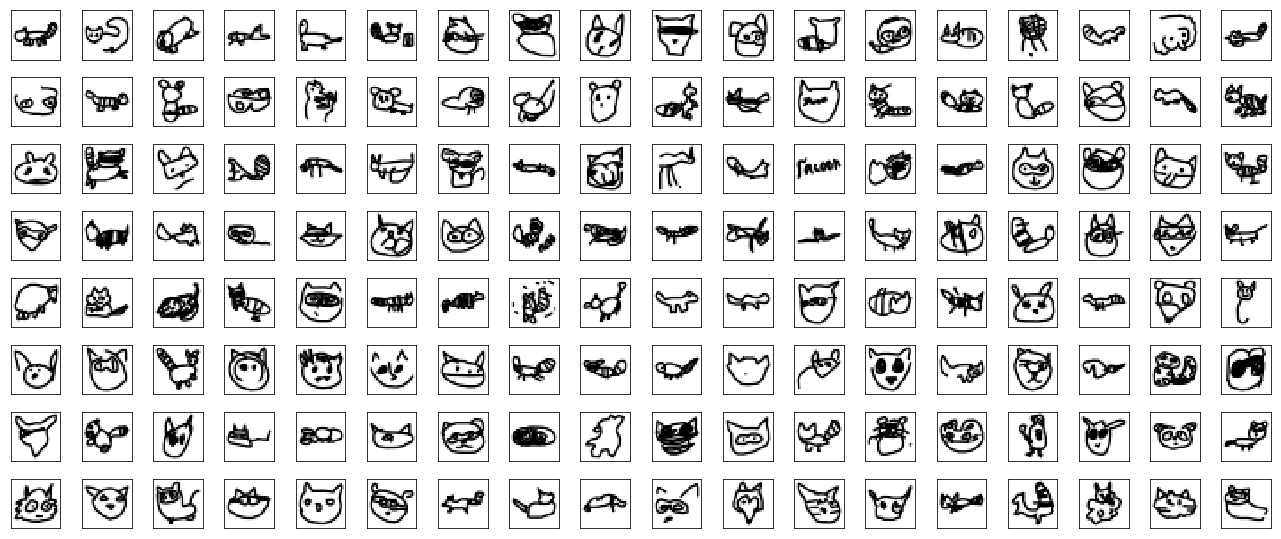

In [48]:
plot_sample(racoon_data)

In [50]:
data = '{"id":{"0":"5941774d","1":"4023181e","2":"b20200e4","3":"e7f018bb","4":"4371c8c3","5":"a8d9b1fd","6":"29e7727e","7":"92a51ffb","8":"c769ac97","9":"aee0547d","10":"565b28ac","11":"e04e9775","12":"8e8161d1","13":"4cf4d256","14":"139e5324","15":"f156976f","16":"68a117cc","17":"d9aa7a56","18":"9005b143","19":"5f6d3988","20":"9ad70954","21":"b9087b9e","22":"a39a1427","23":"82fbe8ed","24":"1fae4879","25":"6dd8f13d","26":"bbad5958","27":"54527583","28":"be8fa29c","29":"81a3328f","30":"1a3c0ab3","31":"4deeeb8b","32":"ac6d5632","33":"472dadb5","34":"96093f95","35":"f5b4e3df","36":"e01a3c92","37":"001680af","38":"8e639f33","39":"a2c16612","40":"a6d76474","41":"19c47684","42":"015827b6","43":"7df7f7ce","44":"0bbf1a3f","45":"636cfbb7","46":"7370030a","47":"43aa97ad","48":"ba2b5e63","49":"dfdd335b","50":"e79b13dc","51":"dc32b195","52":"6d868590","53":"75fa59aa","54":"ffe50836","55":"a7bfd784","56":"b3d569e3","57":"6c538c5b","58":"5c7c15f4","59":"0b745139","60":"fd14608e","61":"f0bc8305","62":"a10ccb28","63":"543304c7","64":"6c3a4078","65":"9b73cc75","66":"5c6c71b1","67":"09ee9186","68":"207c35cf","69":"153c813e","70":"5605d58b","71":"642ca396","72":"d32d72c0","73":"16646a17","74":"384074af","75":"69bf1e8c","76":"9e90a054","77":"89dbe7f7","78":"dbd27d22","79":"a2ea1561","80":"d63402af","81":"1ac8bb92","82":"8beffca5","83":"46741f3e","84":"e5ee6aa7","85":"5ecd892b","86":"69892166","87":"2f725a81","88":"810abfe4","89":"e6f973e6","90":"c60a5c46","91":"c42b9e08","92":"c3f00c23","93":"5307fdb8","94":"3e4f005e","95":"4a4cc2e0","96":"9bdd88d1","97":"0d832bed","98":"14a134fa","99":"78a41676","100":"0bd4658e","101":"4a311bb0","102":"f939c817","103":"956adc4d","104":"f8a119f5","105":"61faa1ad","106":"6725eb3e","107":"17b3a8fd","108":"49a88dfc","109":"2d6ec645","110":"0d4d77ba","111":"3ee672a2","112":"738b41fd","113":"f7fb320d","114":"b42fad18","115":"4ab8b00a","116":"f7870f2b","117":"4978666a","118":"f1b0d6c7","119":"5642407f","120":"36d4ff92","121":"4139aba2","122":"7585ce58","123":"33e25984","124":"ac46f3c9","125":"fc34a5b8","126":"85c36a8f","127":"b2d8a426","128":"13ec60d1","129":"9d440f42","130":"1c0a891e","131":"981c3bc3","132":"295604f4","133":"16ca16c3","134":"b4dda837","135":"88d088ef","136":"1b4fa160","137":"f371bd82","138":"b130a0b7","139":"ebf1de82","140":"01e651c3","141":"51b1fecc","142":"fa635a31","143":"97b7d789","144":"2f598053","145":"c0e3e148","146":"cfa175a8","147":"3d7e09d8","148":"44a13d1b","149":"c66b0948","150":"976a6d64","151":"8bbd8909","152":"522890fd","153":"f23a3b95","154":"680039dc","155":"93028e53","156":"22a16932","157":"7d8126d2","158":"ba2ecd75","159":"8071bdd7","160":"96d5aeee","161":"154be68f","162":"d8c2bfe2","163":"f76d47b0","164":"0e781ade","165":"13cf6060","166":"cd99f710","167":"d10005bb","168":"3a31445f","169":"3157202d","170":"6ee64703","171":"e5de8685","172":"02cc70ba","173":"50984a87","174":"fa94957a","175":"eab406b4","176":"3ad39398","177":"9ecf3802","178":"6048ae7b","179":"9dc68871","180":"13701465","181":"8d8779f3","182":"0712f269","183":"722c2597","184":"478a2b08","185":"38f5fb41","186":"c52ad74d","187":"0c85fd09","188":"f1582cba","189":"ff836697","190":"ddfe4802","191":"3cef3bc7","192":"6a21542b","193":"150e23c4","194":"078c6d99","195":"1dcd1dc3","196":"39967e45","197":"6b6333aa","198":"4ae61433","199":"f96362e0","200":"97a88aac","201":"427ae8ce","202":"209d4b15","203":"64b453bd","204":"0f5a484e","205":"5ac74969","206":"736ed43e","207":"8533795f","208":"f5b54fb6","209":"6eb4c041","210":"97afdf42","211":"1bb488db","212":"f132e44d","213":"d3c2f140","214":"1756794d","215":"9efcc11f","216":"14c966cf","217":"59cfe4d1","218":"883151f4","219":"34c4c9ff","220":"70b4c2eb","221":"96a337d9","222":"7fe89ffa","223":"057c7a22","224":"451cc057","225":"05076700","226":"dc52f6c1","227":"b03a59f9","228":"129ed4b0","229":"fb611563","230":"ac32e6f1","231":"c05c5ab0","232":"3163d5ed","233":"02096ca4","234":"e92496c0","235":"1a9e2c50","236":"0864e334","237":"d976faeb","238":"1d7b342f","239":"281bc1ea","240":"bea9f0cf","241":"f4afa0e6","242":"e1b5ef69","243":"b50539fd","244":"2a8c9c15","245":"157ebb0c","246":"247d3614","247":"0c6cc0cb","248":"aae88d39","249":"0c77b464","250":"963cf5ea","251":"1b371d8b","252":"225bc00f","253":"bc0a4eec","254":"1099782e","255":"a18feadd","256":"ad7f4932","257":"5f8f831e","258":"b5167c35","259":"0230b06d","260":"f8d7f7ba","261":"08bd1053","262":"58e4dc8c","263":"4793ce8e","264":"304caab4","265":"f2ee6d7f","266":"e1f9c0e4","267":"8e40401c","268":"5d9eaba2","269":"55e7562c","270":"9da6cb4b","271":"c3c1c8ec","272":"3b38698e","273":"6c9eb909","274":"482a3d1d","275":"0e9918f0","276":"ef894fd2","277":"4b82e7f7","278":"b9cdd7fb","279":"94a496f4","280":"995eacae","281":"41b02e58","282":"69f04617","283":"c889a03c","284":"91f98acf","285":"9135c19f","286":"1f0e9c09","287":"260d6e8e","288":"46334397","289":"f34ddf31","290":"4d6177d7","291":"76a57270","292":"217b8cea","293":"9a45a566","294":"1b55c75e","295":"7bd92ec6","296":"6c409f41","297":"df3e48eb","298":"62723e57","299":"b8e627bf","300":"86bb5d85","301":"77e5034c","302":"607079e5","303":"96879fb4","304":"6afe606d","305":"4129802f","306":"a42300ef","307":"1af842f5","308":"3fe57d78","309":"f4e60ed5","310":"68c8337b","311":"914ed5b5","312":"a6bb5987","313":"c781c439","314":"47a1a25e","315":"80ea0713","316":"a9d001bc","317":"f94d098a","318":"3e230e0e","319":"24afa485","320":"bc37db7f","321":"83f99e4d","322":"1a8d86f7","323":"38136419","324":"d393e637","325":"36902570","326":"327f7b25","327":"3f8543c6","328":"a0d42a70","329":"e07ba430","330":"c6e53803","331":"fec4dad8","332":"933fc5ba","333":"c27eda4e","334":"9b94d2c2","335":"a2dbdb31","336":"816258dd","337":"81f11218","338":"c4bd9d04","339":"c6ce9bf9","340":"a7b3cc29","341":"527870bf","342":"9af26068","343":"0b591e70","344":"2b1e57c5","345":"194db786","346":"e09ba644","347":"fa2ed3e5","348":"1ba92726","349":"8c8f45b4","350":"f8889f44","351":"598e255b","352":"45f1aa7a","353":"022956a3","354":"d406064d","355":"76617947","356":"d0e5dccb","357":"33271da6","358":"0840e2b1","359":"521a9f4d","360":"7286b1dc","361":"5b6acc2d","362":"e034cd34","363":"46577660","364":"bb4d6f24","365":"bfc7a3f2","366":"abc66be8","367":"3627189f","368":"e49a77f6","369":"a209d7ee","370":"dee69cf6","371":"9a6261a0","372":"a8e444c6","373":"a6a66a28","374":"db7022ff","375":"0dfb45d9","376":"81c983aa","377":"a98fb5e1","378":"99e004d7","379":"d16e5fbb","380":"3c352f9e","381":"12202699","382":"86af0236","383":"f3703e6f","384":"4a71dc34","385":"321edcdc","386":"e365a657","387":"45755c9c","388":"873b0829","389":"72ccd009","390":"205243d9","391":"d9202f36","392":"9d0c30b0","393":"56644ace","394":"c63f527f","395":"bb84b9bd","396":"6f68caf0","397":"8492119b","398":"71bde48d","399":"d2d6e2ba","400":"6f4b309c","401":"b3cc5ba3","402":"fee39547","403":"4893137a","404":"e283c4c4","405":"25bac62b","406":"8fd88dd6","407":"b48c104e","408":"221d500b","409":"8f0de087","410":"32342e03","411":"a8da99d8","412":"93203755","413":"d3c88528","414":"0d7a17b3","415":"bd72f5ec","416":"e953c0fd","417":"e730b6c6","418":"c086033a","419":"a521d303","420":"b023957a","421":"3e0f04e8","422":"60647cba","423":"2f5c43a8","424":"b54ba69b","425":"eac962ff","426":"7e2a3763","427":"9362d863","428":"8f1b833c","429":"79727ff5","430":"62614c75","431":"75a03adf","432":"cf138392","433":"bf467a96","434":"c8b34651","435":"105a5c54","436":"bf6de75c","437":"060702c8","438":"921bad2c","439":"e0d17eb0","440":"9a3825c9","441":"8eda717f","442":"78906e0c","443":"c60100ad","444":"90a72a52","445":"d80e4ed4","446":"339cd0d2","447":"d99de899","448":"357e20d1","449":"a4d190da","450":"bd226217","451":"476e2771","452":"4e483506","453":"f70ea081","454":"4645e56f","455":"e6d05940","456":"f8b3c6af","457":"c89d6aad","458":"0cb57f6e","459":"86a4be46","460":"75e62d7e","461":"ebc36374","462":"0ebcb731","463":"24d000c5","464":"f3c9a4f6","465":"1bc59730","466":"47ea0bff","467":"cdeccfdd","468":"15e09a1d","469":"00652788","470":"23649c84","471":"91188a77","472":"eaca8580","473":"4ce9daeb","474":"d4220673","475":"b6a87aef","476":"8333ebed","477":"950a3453","478":"7074f6c9","479":"98a02caf","480":"59c8d2b3","481":"d99d13bd","482":"de86f1cf","483":"8f4b1985","484":"a7779b04","485":"2caeab11","486":"16aeea7c","487":"b9d19ab9","488":"29c5d2fd","489":"efcefa55","490":"099161c3","491":"12b49195","492":"96a1ce13","493":"67964b4f","494":"b61c605c","495":"bcfc0f16","496":"bf0cb956","497":"12f6aa7d","498":"f36f3a0c","499":"83490492","500":"e3b62b60","501":"20b27d66","502":"25c3ce93","503":"67a2ff0b","504":"9b2d3c1a","505":"8ad51f7d","506":"14137b57","507":"9ea5aa79","508":"5ea1d2dd","509":"979c867e","510":"7ea1e1b6","511":"d65520ba","512":"765ad2e2","513":"d2957326","514":"24349e24","515":"fd8a2ae3","516":"b282d98e","517":"3eaa7a61","518":"16533dd4","519":"4adb68d7","520":"565005b9","521":"51d86e0c","522":"30635642","523":"d9480a60","524":"b2647128","525":"20478c55","526":"caa0d105","527":"474f4534","528":"d51e3867","529":"e5d1bba7","530":"e7000b2a","531":"78f06b79","532":"8a9f4bee","533":"3d716bbe","534":"6e1ddef1","535":"9826f39a","536":"3fdc82f7","537":"31f013c3","538":"97a9df6d","539":"10e65294","540":"0bdca1a5","541":"374037fa","542":"1d1a0cec","543":"d415c5ad","544":"ced1306d","545":"f43497f3","546":"ffd13a9e","547":"6f67148e","548":"be322b68","549":"af209b44","550":"69b53a4a","551":"4c085180","552":"608cea18","553":"f8bebbfd","554":"ae16855d","555":"dfc700b3","556":"e3bdd9ac","557":"87a8ea20","558":"3c3da9aa","559":"76c882d6","560":"9e429645","561":"7dc9c990","562":"f38d53ef","563":"e1785b6e","564":"80c673fb","565":"a8b8c20b","566":"6a1ff150","567":"2f68d4fe","568":"c462ec65","569":"c374d5c4","570":"d20769b3","571":"c467fe4d","572":"1356229e","573":"b1532127","574":"3777ee22","575":"4ba6023f","576":"08504ae6","577":"5e0b4cc5","578":"249a0c1f","579":"24b3497f","580":"9edcf494","581":"53297290","582":"6d3a269e","583":"1b0d38fc","584":"02747427","585":"38867253","586":"c392dbd0","587":"8939734c","588":"097ba3af","589":"30f0f835","590":"bdab1bcf","591":"1070a984","592":"c41b8a90","593":"86a3b5cc","594":"d0a3719e","595":"b1a8067b","596":"911bc6aa","597":"67a2d0ac","598":"11447262","599":"12fd1375","600":"f2898538","601":"0e7355e2","602":"bc2c87c8","603":"94001156","604":"d5855224","605":"a3c1a552","606":"edcf54fa","607":"a28b90eb","608":"63cd028f","609":"dbc79657","610":"bc856bf1","611":"c7e25a70","612":"9771b119","613":"836db0d9","614":"f5685d3e","615":"bb04299d","616":"163a9d23","617":"5283c614","618":"2276d5d8","619":"ccb77e34","620":"d4a75bf3","621":"e15f46ea","622":"992a45ba","623":"056e7768","624":"a1dc016b","625":"38db82cd","626":"3295f3ae","627":"a6ff3660","628":"5981b799","629":"2636d79d","630":"7a8521e2","631":"9b53021d","632":"0a37be18","633":"a8676e55","634":"3488b8fc","635":"b86d4006","636":"33888635","637":"aa9ca5f9","638":"08faf0f6","639":"5320cd26","640":"2c57fdaa","641":"d467ce62","642":"888a568e","643":"88d6c838","644":"8f138517","645":"e1108dc0","646":"9e9cd6c9","647":"ab893af4","648":"4d4b30ba","649":"7ce15e26","650":"dbc45500","651":"6a0cde3f","652":"2658014c","653":"08d20604","654":"03c83dc9","655":"d741ccd1","656":"992d48b6","657":"b1ea3253","658":"da379e69","659":"73b429af","660":"2aefe712","661":"1e3634f9","662":"069ee09e","663":"a7970f81","664":"23084d2e","665":"ac57710a","666":"02553267","667":"0971c6c7","668":"cdb7f1fe","669":"d3af3f60","670":"59daf44b","671":"c2169934","672":"da03b56e","673":"474ea404","674":"f686cdc4","675":"f865b354","676":"106df554","677":"e5637171","678":"cba8985c","679":"cc09c9ce","680":"0b85b33f","681":"92f20625","682":"6b1379dd","683":"ed2b1df1","684":"325124e4","685":"7455c944","686":"fd68ccc1","687":"8df9100d","688":"c406df9b","689":"4978870c","690":"383f95d6","691":"aba96bbf","692":"6bba66b4","693":"b86fa0c9","694":"a2abc369","695":"0b40c014","696":"d45add48","697":"00193999","698":"c2f1b710","699":"53750c72","700":"3137ef1d","701":"bc6b8e2a","702":"7cb546c6","703":"d59a2349","704":"04d04b9a","705":"05ac1343","706":"2917895f","707":"342a1d01","708":"78309e4b","709":"5c1a5aba","710":"fae57f79","711":"23821d71","712":"5780b19d","713":"11c67865","714":"8564f114","715":"ec7d0fdd","716":"9a0446b8","717":"5f5da69d","718":"7a11839b","719":"763c9bbf","720":"15a7b5c5","721":"e9c7e251","722":"2555c207","723":"ec8d9784","724":"08fd9d10","725":"9504ae29","726":"0b91a24d","727":"e62e6cfe","728":"5d1291bb","729":"b3c1f2e7","730":"c6a8db21","731":"f2c137fd","732":"b61e8155","733":"45b9ee35","734":"8fe9c49b","735":"b98ceb09","736":"70c4a435","737":"d953d111","738":"da7de86e","739":"519f8611","740":"75eefdc3","741":"62412092","742":"de8ec010","743":"ee6121f8","744":"412b66e0","745":"7405c131","746":"efff4306","747":"5658d679","748":"617f88fc","749":"a120100b","750":"0971369e","751":"83f7fe7b","752":"12437da1","753":"8e7f96a5","754":"a08237de","755":"a013bd6f","756":"c6fdd404","757":"317e2af4","758":"dd9878c0","759":"42e76a51","760":"022f77e3","761":"cada3682","762":"53074f1f","763":"e6c19679","764":"dfb69b8b","765":"e1572941","766":"8d549cd2","767":"6913594d","768":"6e528fd6","769":"c8b037c7","770":"c3b6c880","771":"9684ac04","772":"6d974acc","773":"57b10462","774":"b2373298","775":"8e946e10","776":"6acee7de","777":"8ad7cc2f","778":"8e6e087e","779":"c3e46df5","780":"f6983f34","781":"8130a3aa","782":"0f11be03","783":"766073e1","784":"e67f6889","785":"148a0930","786":"b333ff97","787":"1c148a28","788":"ee0b02d7","789":"fa1c5f6d","790":"9b12ae1f","791":"3bb60b1b","792":"096e7594","793":"ac98996a","794":"1b7b9b9d","795":"61b2ac6f","796":"2bd414a8","797":"73d12826","798":"29f7ec33","799":"265f8aa8","800":"0d6be675","801":"a00ecdf6","802":"c414328a","803":"d47de87e","804":"376f984f","805":"12a35aa5","806":"8ecfd739","807":"2cbc30f4","808":"aa4bdf31","809":"69d18f51","810":"50cd4394","811":"bda732e1","812":"8e77e385","813":"49dfd51a","814":"b0a3e728","815":"518061ec","816":"bb306c8c","817":"1b2cf099","818":"e7c405e4","819":"1fc79c9d","820":"3427cd60","821":"8fc604cd","822":"0981acfd","823":"512e9c5c","824":"ae9f2426","825":"a8cd44c8","826":"acac91c3","827":"35988937","828":"2a2dd539","829":"3f971e0a","830":"7e09131c","831":"82726c59","832":"ec4c3dbd","833":"2a851255","834":"2cebdab4","835":"013b617b","836":"21a8603a","837":"fe2f2579","838":"df069a3d","839":"595f7f57","840":"081bdb0a","841":"6f8e7b3a","842":"d1824fe1","843":"3ddc6778","844":"57e4244d","845":"18e2e176","846":"7394cdbc","847":"19821b41","848":"12e9563c","849":"b96c9ed9","850":"096d9c1b","851":"97454a30","852":"43b6c5d3","853":"2c58bcc5","854":"0c71dc02","855":"f7cd79b0","856":"922ec513","857":"561b6b2c","858":"32913f04","859":"77aad507","860":"d62d5a9c","861":"be70bb3d","862":"84920252","863":"b9623d93","864":"ba925eca","865":"181ecadf","866":"6fbcc9e2","867":"57d5b182","868":"d3013a36","869":"21cafb54","870":"d1a6cc74","871":"c4017d47","872":"22e05854","873":"7eb53ec8","874":"c77a806d","875":"c114c951","876":"71495521","877":"98bb1260","878":"546ec108","879":"78f39102","880":"26b6379a","881":"8cb14c23","882":"75892ee1","883":"3d31d65f","884":"30784a7a","885":"efba2a23","886":"9fcb2c5a","887":"9910ee7e","888":"dc97b587","889":"7732ca72","890":"c4bac1f1","891":"a80ddf30","892":"fe79c536","893":"84e34259","894":"7db3b563","895":"5e946e6e","896":"76881bf4","897":"7c606237","898":"7aa06d7d","899":"0d035cbc","900":"0838e69f","901":"f6715e39","902":"499004bb","903":"4cefc9ec","904":"ded95f0a","905":"073112c9","906":"96cb4df4","907":"0962de0b","908":"cea18b7b","909":"75463cb0","910":"4a59c201","911":"29d46646","912":"e6134ca4","913":"445ae936","914":"420d8dda","915":"bae1b5b1","916":"9f49327e","917":"18b52f62","918":"b02bb341","919":"e5be8689","920":"b5b85b95","921":"b94f72e3","922":"a79114fd","923":"502ffafa","924":"b8e274d7","925":"e37f8f63","926":"c8a5c9d9","927":"d574bf84","928":"88bc1b71","929":"3261e3ee","930":"e65424cf","931":"706d2090","932":"94d4c49c","933":"51ba3d48","934":"fdd4c395","935":"12eed563","936":"f93627e8","937":"df51a7cd","938":"c84092af","939":"514a25a2","940":"5d421481","941":"d3859efd","942":"eb024725","943":"0d8537a5","944":"fe708ff7","945":"1790bbf0","946":"8a30487e","947":"70a01d16","948":"89bb7fca","949":"398c1300","950":"41b43c73","951":"72d2839a","952":"beeb98cf","953":"c409f194","954":"0c654278","955":"fb155295","956":"103d1e1d","957":"6c755ff3","958":"3722a062","959":"90611922","960":"77b432f1","961":"ccf53246","962":"4c52089f","963":"81e05676","964":"732c51d0","965":"b60c6094","966":"2e9db48a","967":"68cdc732","968":"e1f9dbd9","969":"31fd12b9","970":"72bd3e45","971":"84e2f1ab","972":"b4b6d3d0","973":"874d507a","974":"44775bac","975":"83dfaf91","976":"a9a1cc1e","977":"227de452","978":"14519bcf","979":"970a9821","980":"e84230ac","981":"550e4ebc","982":"5e98d635","983":"667d386b","984":"503fefff","985":"08bcb429","986":"90c293d2","987":"bbc84c36","988":"3facaac6","989":"e8d1bc63","990":"0ba50202","991":"9d947517","992":"e084ed8f","993":"7051b370","994":"910f551e","995":"8d238915","996":"e7238f30","997":"a658f1ba","998":"0b4e7093","999":"4d59af79","1000":"99a7b417","1001":"e5798365","1002":"078c699f","1003":"b2cd6017","1004":"89b3960f","1005":"104d981d","1006":"05e410e9","1007":"44556da6","1008":"207e5145","1009":"390ddfc0","1010":"2e82728f","1011":"4245d2cc","1012":"d43a187c","1013":"52b60236","1014":"cc22996f","1015":"bf08f16a","1016":"47dea2c3","1017":"22ac0bab","1018":"49c670ad","1019":"1040e727","1020":"f39933c4","1021":"30474ea4","1022":"73978670","1023":"527ad437","1024":"78f83e41","1025":"12921cf8","1026":"b960192b","1027":"9dfaf61b","1028":"cec954d2","1029":"00bb437f","1030":"06458d98","1031":"37ba4455","1032":"2feeeaf3","1033":"06c83a48","1034":"dfe4fd55","1035":"0b7fb9da","1036":"52d1ae5f","1037":"0ef51267","1038":"0d9822ce","1039":"bcad7099","1040":"a26a7454","1041":"93b7cc9d","1042":"dcd0ddc6","1043":"16655d5c","1044":"2a6150ae","1045":"601fa9bc","1046":"3644a31b","1047":"396254ec","1048":"b01bf536","1049":"ff13313c","1050":"18c308c7","1051":"50b69cc6","1052":"76bd6e6a","1053":"74c587bb","1054":"11b26a63","1055":"bf2bc384","1056":"075634d5","1057":"7b1e388b","1058":"8eb02fc2","1059":"5b09ed4a","1060":"371b935e","1061":"7a1cbaab","1062":"c5c72595","1063":"c5ea95c0","1064":"a5b61d35","1065":"2c252c46","1066":"7d8e52d9","1067":"13fe65d5","1068":"a3d2abc6","1069":"9248daa9","1070":"605470fc","1071":"38717ccd","1072":"1144cbd0","1073":"6d32e09b","1074":"89b138f7","1075":"a83f69a4","1076":"68b7f89d","1077":"a0998397","1078":"7e20006f","1079":"93b12419","1080":"475c5a35","1081":"67f42c90","1082":"45a114e0","1083":"41a59ee9","1084":"6c2c6a39","1085":"9f840a7d","1086":"2ad5ee96","1087":"cb8b875e","1088":"2283d088","1089":"545f8210","1090":"7eeed38a","1091":"be77b9e7","1092":"16ec40a3","1093":"b7e74bcf","1094":"8a36acfd","1095":"d2e5b493","1096":"bd88797b","1097":"78566a26","1098":"32449528","1099":"5f6ffdad","1100":"38bdc33c","1101":"f88a9ed3","1102":"c1fe2103","1103":"63f7ddd9","1104":"97e123d2","1105":"7d078228","1106":"6b43e60f","1107":"e07665a4","1108":"4da0c147","1109":"1d2474a1","1110":"f39a3050","1111":"aaeb3f89","1112":"daa3d1e9","1113":"23cad3ed","1114":"dc8fd92d","1115":"994a2787","1116":"5009ce8c","1117":"95ba90c7","1118":"bb176f20","1119":"57ccd603","1120":"c3767f5b","1121":"076492b4","1122":"68864007","1123":"fb124dd7","1124":"c59fbfc0","1125":"ddce9f51","1126":"c459dbf6","1127":"1a39b44e","1128":"a31f8519","1129":"29ff4d55","1130":"c0a87a44","1131":"aa07ea34","1132":"ed7b77f3","1133":"ccb10918","1134":"aba1f2cc","1135":"0c4b7ce6","1136":"26a29fae","1137":"6a1a9b91","1138":"fda0d9b3","1139":"2f7da2f9","1140":"948317c5","1141":"df315de0","1142":"51762e5e","1143":"9be1f9d4","1144":"b20f16ca","1145":"24f677ab","1146":"19d36f67","1147":"db098e36","1148":"3ab323b5","1149":"db204654","1150":"f0b7c362","1151":"9c36083a","1152":"00247e48","1153":"99064331","1154":"fb023b97","1155":"834a13a2","1156":"b4fb7c3b","1157":"cccc91e5","1158":"e777f5c4","1159":"8a367850","1160":"01aee49b","1161":"09a3f3cb","1162":"b7837a99","1163":"0e5c18fe","1164":"433d92a6","1165":"d8c1c90e","1166":"5cf350ea","1167":"9e6adfeb","1168":"398c373b","1169":"8e1cb96b","1170":"c0ab7de5","1171":"b7519f43","1172":"54d7929f","1173":"222a4407","1174":"4cd8d439","1175":"ac31d9e4","1176":"0c51475f","1177":"926b4b5d","1178":"3072aeb4","1179":"5508aabc","1180":"7ff080c1","1181":"c8137158","1182":"73f4c54a","1183":"0ab19c8d","1184":"57c090c7","1185":"b3f4d7c8","1186":"d4a81cf9","1187":"497c4ff8","1188":"8949311b","1189":"d4f17d1d","1190":"cbd015d6","1191":"4ff7d773","1192":"5950d2f6","1193":"f0b4c564","1194":"4727e088","1195":"2c9b195c","1196":"04c441b0","1197":"9f1e2246","1198":"3bf56119","1199":"385033f6","1200":"1e14e9eb","1201":"4ec14d05","1202":"d16ffa50","1203":"6f2147d7","1204":"13540275","1205":"280aaa6c","1206":"63d6fcf6","1207":"e1130afc","1208":"8915b349","1209":"02cb6179","1210":"816084ef","1211":"e83e27ef","1212":"9928b6cb","1213":"398c44d5","1214":"4e9944c8","1215":"ade738c7","1216":"df106f1f","1217":"707c42f2","1218":"c7d6c968","1219":"2f62a2d3","1220":"58a62136","1221":"8e16308d","1222":"10d97d10","1223":"862a2dd5","1224":"45d7cd09","1225":"daef67d6","1226":"40b9f916","1227":"c17dc729","1228":"d008e04f","1229":"a5a6fe15","1230":"e9ce7834","1231":"518a5aeb","1232":"fd6e49ab","1233":"35ef2d54","1234":"be1f3e73","1235":"013825b7","1236":"c48b752b","1237":"a0f39ace","1238":"800aff52","1239":"e0eb259a","1240":"404bdcc5","1241":"9be770cc","1242":"e002bdfa","1243":"511f8764","1244":"d41e40d8","1245":"ff846aa6","1246":"c261a419","1247":"c3358fec","1248":"62972972","1249":"3f15e6a3","1250":"f239dd72","1251":"e9d815ef","1252":"568085b5","1253":"80708782","1254":"a578b01b","1255":"04b81012","1256":"3fbd3a3e","1257":"536bc047","1258":"6905e82d","1259":"352b0ab0","1260":"205506f4","1261":"b4075da1","1262":"0132c59d","1263":"5c471255","1264":"b9ee0383","1265":"aee38fe1","1266":"93eda776","1267":"d65ee363","1268":"7e6785d9","1269":"c006cf82","1270":"197f9050","1271":"efce51fc","1272":"d8dd1b33","1273":"ca5bae71","1274":"66eba58c","1275":"e080fee1","1276":"9626a2b5","1277":"c0298b7d","1278":"80f17a8d","1279":"fefe71e5","1280":"92a45990","1281":"8e922071","1282":"d5952199","1283":"3c56cf59","1284":"5b677f30","1285":"70986e85","1286":"ee110bda","1287":"e7b4d317","1288":"f59f29f5","1289":"3d1e179e","1290":"4e9c76d9","1291":"5b5d407e","1292":"bb4d8184","1293":"5f5ad493","1294":"a304ae2e","1295":"ac337f79","1296":"e00e495a","1297":"71477bcf","1298":"22ed2916","1299":"05fdb1ce","1300":"4c5e56dd","1301":"fab2df1f","1302":"afe6a1d1","1303":"fa03ba13","1304":"663dd2bf","1305":"5d3aa488","1306":"11d63814","1307":"11ac5623","1308":"dd28b028","1309":"bf244975","1310":"6a2fe659","1311":"bd689e7a","1312":"a7b21484","1313":"06626706","1314":"2fcb2613","1315":"1ee7f506","1316":"c462096f","1317":"59b91711","1318":"148ad313","1319":"a04c148d","1320":"142d14f3","1321":"0dccef06","1322":"bf9dea3e","1323":"121ec728","1324":"25ea1800","1325":"024bed49","1326":"771a9bc9","1327":"8b2562e0","1328":"fefe0db6","1329":"a6cc8fa1","1330":"fe33ce5b","1331":"c11a6fd5","1332":"69152132","1333":"dd54beb5","1334":"46d8944e","1335":"f278cc6a","1336":"9cba91e4","1337":"37e80ad8","1338":"6247d06a","1339":"0bb564ea","1340":"f8802638","1341":"cb77c1d4","1342":"edcad79c","1343":"ade84952","1344":"e9a4a8f7","1345":"8c3c9c0b","1346":"c105af7a","1347":"64a96816","1348":"d435722b","1349":"f8c2c17d","1350":"30b0c5a1","1351":"a241eee2","1352":"577af3a1","1353":"b1e49a9f","1354":"49eff60f","1355":"171ffc36","1356":"2dbb2931","1357":"851f9ad8","1358":"ef787241","1359":"3ed46d9b","1360":"61a96458","1361":"a0eb8b65","1362":"8058e7e7","1363":"5d0969c3","1364":"06dc5d13","1365":"614d8fdf","1366":"068ace8d","1367":"55bd7491","1368":"59db8d78","1369":"ee9ba395","1370":"3833c332","1371":"f9c56480","1372":"35041821","1373":"67426d52","1374":"f2eba496","1375":"cfc6b272","1376":"be6e6157","1377":"060762c6","1378":"28e5c819","1379":"165b73a3","1380":"1a16ebf2","1381":"c76353ea","1382":"c56aab52","1383":"19ba105e","1384":"4ccf1d67","1385":"d3f00ca5","1386":"dc366696","1387":"11ddfec4","1388":"71036847","1389":"9108a260","1390":"812d2c7d","1391":"601d54b4","1392":"2a21ddce","1393":"e03f632f","1394":"27c1c4f4","1395":"9929fc67","1396":"cc5b496e","1397":"9ec5c0b5","1398":"5fa292a8","1399":"d0e35d53","1400":"cfc89ddf","1401":"fd3916f4","1402":"019ab715","1403":"d0a7830b","1404":"2e1acd63","1405":"c5810152","1406":"8dae1e77","1407":"afe44c59","1408":"ac640b5a","1409":"5c47f5bc","1410":"2e5e1053","1411":"e30d5450","1412":"0de92cf0","1413":"e97daf2c","1414":"5bcc2bf5","1415":"d347d81e","1416":"2799f5cd","1417":"ce4b96f7","1418":"a6365299","1419":"6eb86fb2","1420":"d1384eb4","1421":"66c3ab6a","1422":"9be981c9","1423":"e5fc3dd4","1424":"fd3f01fc","1425":"5fbb0aa0","1426":"6968f510","1427":"7509aad8","1428":"9cf9c8ce","1429":"157c589d","1430":"fcc51d2f","1431":"6852ee69","1432":"8a388b27","1433":"e3b1fdd6","1434":"1d644f91","1435":"893a7d79","1436":"9ef2d53f","1437":"eaea1243","1438":"2d210670","1439":"b04329c3","1440":"1d88e97d","1441":"e5c8ae65","1442":"841810cd","1443":"187a1e4b","1444":"24f8bc83","1445":"071678c5","1446":"3121517d","1447":"62db6263","1448":"4b6fe0a5","1449":"016588cd","1450":"e47db8cd","1451":"6009575c","1452":"59d093d3","1453":"b3edce17","1454":"77cb2808","1455":"b318189f","1456":"eb804bc3","1457":"27af98c1","1458":"75bbd171","1459":"26a7450a","1460":"9f96c645","1461":"f295285a","1462":"1861ae59","1463":"320e2661","1464":"48b64c84","1465":"596115ad","1466":"24c5d2ad","1467":"513481e4","1468":"679ca3d6","1469":"550511fc","1470":"33ad621e","1471":"a7cd4c8b","1472":"942ce002","1473":"4a33d600","1474":"52512da4","1475":"199d9dd5","1476":"910c7a11","1477":"2dc4b47e","1478":"067c0baa","1479":"66ec0485","1480":"93e203f1","1481":"1eae71e0","1482":"9a320603","1483":"97c75edc","1484":"e3a3993c","1485":"03647606","1486":"b5758e75","1487":"cb341897","1488":"80a1d2ad","1489":"f2afc45e","1490":"e2e037d3","1491":"d8513bb1","1492":"2bb05740","1493":"568eee1e","1494":"48073219","1495":"52770a14","1496":"bb78aa77","1497":"d2041d74","1498":"0c650b7b","1499":"3ed634b4","1500":"4e7ef4d3","1501":"dc676914","1502":"9ef182ba","1503":"19456254","1504":"45c7e999","1505":"1e5f187e","1506":"8372c5dc","1507":"0a113574","1508":"22ac144f","1509":"82a0baaa","1510":"fb9c0a38","1511":"586d1724","1512":"42491e8b","1513":"32d8d667","1514":"2d658824","1515":"79e58200","1516":"50e426df","1517":"71d908c0","1518":"1f275072","1519":"a1bb2901","1520":"6c99ed0b","1521":"d8216f4c","1522":"ebb34ef7","1523":"0a71e0d1","1524":"3bebe07a","1525":"0de67b1a","1526":"7409fd1a","1527":"1e27c8fd","1528":"65cfde78","1529":"ab7841b4","1530":"f5064f4e","1531":"57457484","1532":"5492eb34","1533":"78dfcd52","1534":"7dcfa04d","1535":"0f7ccad8","1536":"730b2296","1537":"c1f05b03","1538":"265ced3a","1539":"92f976d4","1540":"2ac16805","1541":"b2de0386","1542":"898f0d27","1543":"b6d290df","1544":"64bc67c4","1545":"e54ee68e","1546":"5f14e447","1547":"9c736f77","1548":"328fd096","1549":"e8e9dfc3","1550":"a3a85eeb","1551":"d4b96d3f","1552":"bb255043","1553":"8696136a","1554":"be23ea08","1555":"777d00a2","1556":"bc8d3476","1557":"f6f8857d","1558":"c57f13ef","1559":"7aa6b7a3","1560":"512c569c","1561":"48b1c243","1562":"75ff94ee","1563":"c60f051c","1564":"032b1bda","1565":"77531032","1566":"06210232","1567":"d7418c1f","1568":"e2e957ba","1569":"566b0a76","1570":"7c6691b5","1571":"990a0ecd","1572":"16914cc9","1573":"e78a6709","1574":"98aa34a8","1575":"1908cc60","1576":"81946709","1577":"2fd07377","1578":"d5c0e0d7","1579":"58ec0c92","1580":"3aeb362f","1581":"147d59ab","1582":"e0829262","1583":"8b86d83e","1584":"9a350af0","1585":"aba1b542","1586":"b0112ad5","1587":"4ea094c0","1588":"74964450","1589":"e4a06bc9","1590":"245ef22c","1591":"828460e1","1592":"fcbdad05","1593":"50ff69e1","1594":"28cf2057","1595":"8ede8c69","1596":"323458ef","1597":"3c002c59","1598":"24e5b88f","1599":"a09d9139","1600":"d0b1be68","1601":"bcd22f87","1602":"f90b1c41","1603":"f14f533a","1604":"acfaa4ff","1605":"78e7617b","1606":"febe6575","1607":"5cd96fb8","1608":"88027f9c","1609":"388dd3bb","1610":"8e6cf4d3","1611":"0b2daf85","1612":"63f51c56","1613":"5b6305ad","1614":"241c50cb","1615":"495a6ed2","1616":"b04bf998","1617":"c55e7096","1618":"2c9d1b48","1619":"e20a003b","1620":"33725817","1621":"fe05fc09","1622":"b9022c8f","1623":"b5abb620","1624":"e62b3eb0","1625":"95812205","1626":"209f8e41","1627":"9bb3cd44","1628":"86bf6810","1629":"919cb6af","1630":"8cabc104","1631":"ca5fec7b","1632":"01e7f145","1633":"d2826f8e","1634":"e584f028","1635":"4bdcb525","1636":"6b2bc3e9","1637":"7a523e74","1638":"1c3a420c","1639":"8b383772","1640":"c420c42d","1641":"f0326766","1642":"d67ae313","1643":"7a00e52a","1644":"fd60ce30","1645":"d0de0afb","1646":"5dab3243","1647":"e82b326f","1648":"96ca682f","1649":"e7ba2cd2","1650":"47f2fbed","1651":"faac6b8d","1652":"2eb785f3","1653":"95f440be","1654":"e735e243","1655":"bd83f233","1656":"e2315156","1657":"07945467","1658":"256daf6a","1659":"70801a8b","1660":"518578cb","1661":"5e630a80","1662":"b2df2187","1663":"ff32d7dd","1664":"5144d458","1665":"f9f973c1","1666":"ac65b2c5","1667":"e5cece41","1668":"cc9ca990","1669":"2b771726","1670":"fcea895a","1671":"fd477a03","1672":"4aa26de8","1673":"9a842704","1674":"b1bb19c4","1675":"fc46a862","1676":"e43d659f","1677":"f344be4c","1678":"31671342","1679":"4d67ed4e","1680":"1dd1c8e2","1681":"ab08e37e","1682":"c2924cd3","1683":"fde48cdb","1684":"3c7c170d","1685":"ebeedf33","1686":"6235d8b4","1687":"73a8162b","1688":"b37e2349","1689":"0dbc58b1","1690":"14741b3d","1691":"fe1f82c2","1692":"9a75c053","1693":"581d8a32","1694":"eedeabd8","1695":"2208fecd","1696":"b68c71e6","1697":"dea2cdb7","1698":"ff3401e1","1699":"5ccfa32c","1700":"15370256","1701":"d81a82c6","1702":"c78671c6","1703":"7fbf3fc8","1704":"de8159e7","1705":"efcca249","1706":"c3cdfd7c","1707":"1fbae11c","1708":"a78197b9","1709":"9510487f","1710":"11f770cd","1711":"d2401c84","1712":"781d4a78","1713":"236f4be5","1714":"df56ab4b","1715":"ea825acf","1716":"cf992e29","1717":"66750962","1718":"fa423857","1719":"d6889deb","1720":"e62ff090","1721":"47acfd80","1722":"b9f5efc5","1723":"1a2a1f7f","1724":"e8067065","1725":"db61755b","1726":"c97e4c01","1727":"02538d0d","1728":"9930fe8b","1729":"1e053314","1730":"247e0650","1731":"a4eb05bf","1732":"66ea133d","1733":"3220362c","1734":"67162075","1735":"5af75025","1736":"5dd87bb9","1737":"010dc181","1738":"40dbd0a9","1739":"0c10fd9e","1740":"39c38975","1741":"20f60e12","1742":"4fb6e67f","1743":"d7d3e9fa","1744":"787d0e9a","1745":"7d92a013","1746":"65f79253","1747":"a20dfd11","1748":"c04f50a0","1749":"a007e147","1750":"80e35877","1751":"e3631e6a","1752":"684fd7ec","1753":"9dbdb2b8","1754":"1768e4bb","1755":"d84884d6","1756":"838a14ae","1757":"6e007f95","1758":"6e0c3725","1759":"d4c5252a","1760":"209cba64","1761":"1df44a05","1762":"d925c0cc","1763":"85981d62","1764":"18b93e7f","1765":"4936bb64","1766":"d57686b7","1767":"0d6d23b5","1768":"3859bfa4","1769":"2cfddca9","1770":"32eebbf8","1771":"79c40371","1772":"f7f432f6","1773":"d50e3a56","1774":"b63bbdee","1775":"de327375","1776":"43a0d395","1777":"db465006","1778":"44809656","1779":"3c72f288","1780":"3f449132","1781":"ec5d4a58","1782":"49d62856","1783":"b80fb15c","1784":"368e304e","1785":"f19bdd74","1786":"b55e823c","1787":"89dd11b9","1788":"4286352d","1789":"4b10a9dc","1790":"3bdbb13c","1791":"7e9f355f","1792":"f420301b","1793":"4e3c03ff","1794":"3227e0ba","1795":"d12d7771","1796":"6616970c","1797":"186ea788","1798":"42867a33","1799":"7ed03e02","1800":"f24ce309","1801":"18d7021a","1802":"9a18807f","1803":"a94b079b","1804":"255c4f02","1805":"93ba10ba","1806":"95567789","1807":"bb09a45b","1808":"a972a7db","1809":"2bd5da67","1810":"7a43c51d","1811":"29adcf10","1812":"6742855f","1813":"d20e49b2","1814":"9f81771e","1815":"de27fefb","1816":"d18f6f0e","1817":"69973737","1818":"76509472","1819":"57157f35","1820":"72f5cc06","1821":"19982389","1822":"4ed21d3b","1823":"5a0ca890","1824":"65ea29c4","1825":"b4f11fb6","1826":"8836e0c8","1827":"30456db6","1828":"19174e69","1829":"8baa045a","1830":"bfc86919","1831":"2f93bac6","1832":"c44960f2","1833":"b660e80e","1834":"76411374","1835":"839bbcfe","1836":"bc8c483e","1837":"d9577013","1838":"b47fc3d2","1839":"a57ef2a1","1840":"d6908d52","1841":"99814ee7","1842":"0b6c4509","1843":"095f1797","1844":"7dd828c0","1845":"764b4e82","1846":"91ef8a0c","1847":"a91ee052","1848":"a01318ab","1849":"325ad084","1850":"2ceb258a","1851":"a969eea6","1852":"1a538ed3","1853":"65e14f46","1854":"77c165c3","1855":"14c60c1d","1856":"630360e8","1857":"8d7026fa","1858":"13964a63","1859":"d0155b0f","1860":"46afff48","1861":"4868f534","1862":"26743a5c","1863":"ad50aaf3","1864":"89cc4fce","1865":"715785e6","1866":"3d28a858","1867":"ba36851a","1868":"51ecc6ab","1869":"b1ec4727","1870":"040c5d78","1871":"a8a77c55","1872":"32f51fe6","1873":"8ef7a06b","1874":"838fafac","1875":"7d0b89b1","1876":"7d9636c4","1877":"8d37529b","1878":"5fd612ad","1879":"323ca98d","1880":"842d7d88","1881":"c7529197","1882":"3235b7ca","1883":"2436a25b","1884":"e6d8d670","1885":"1c5a5a1f","1886":"1c1d6c80","1887":"9579aa49","1888":"aeb95ac9","1889":"db172beb","1890":"ae2a516d","1891":"63e579b1","1892":"a49b42ff","1893":"99fb914f","1894":"d86b48d1","1895":"6bca064a","1896":"d3bc5515","1897":"ded30e1d","1898":"d88e4b44","1899":"6f688a3c","1900":"a98dcb63","1901":"6d9d1eca","1902":"51924408","1903":"a8f910bb","1904":"7f12814f","1905":"cdcdc401","1906":"5dea100e","1907":"04738deb","1908":"e4064b10","1909":"c84df9ea","1910":"ba8130e2","1911":"7535f0cd","1912":"c915f66c","1913":"f0c360e7","1914":"fed2396a","1915":"5d58a277","1916":"21279402","1917":"873d8adc","1918":"2fb68d77","1919":"8fb1a67b","1920":"fe8c6150","1921":"c00db5d4","1922":"2e3a38d3","1923":"38464042","1924":"58d4e224","1925":"a7bfbc2a","1926":"9cdcf947","1927":"6c610fd4","1928":"50fd58f2","1929":"b093a813","1930":"28f4e51e","1931":"2d01ecdc","1932":"290992c4","1933":"e0f83a9b","1934":"7cdbe05e","1935":"2a33464b","1936":"84521f2c","1937":"a1d7e535","1938":"f77a2b74","1939":"f2c5216a","1940":"b516302a","1941":"564266ec","1942":"56d23ee0","1943":"8c9971b5","1944":"fe75e357","1945":"cfab3237","1946":"f7258c56","1947":"e79cb5cf","1948":"efbb58a0","1949":"ff8d6575","1950":"cf6d0221","1951":"b057a3cf","1952":"d7aa3d66","1953":"db1b3f2d","1954":"9cfd7cd3","1955":"0dc59065","1956":"f2742949","1957":"cfa8905d","1958":"6bc7bb68","1959":"df228195","1960":"92b3fd07","1961":"99181903","1962":"17b47421","1963":"54c58af0","1964":"c533141a","1965":"3a89f639","1966":"2b9438cd","1967":"de0fc4ea","1968":"d0b4812d","1969":"5ab3daa8","1970":"3a205fb9","1971":"81d06d13","1972":"5b155890","1973":"b7332f47","1974":"13a49895","1975":"a9dcaf7e","1976":"daccb199","1977":"0a31aaec","1978":"effc32ab","1979":"b9b1d1ae","1980":"837567b0","1981":"76364052","1982":"614324a1","1983":"3b20239f","1984":"49054d2e","1985":"59eea5d5","1986":"eaa8408c","1987":"3b3369f8","1988":"06f7cf48","1989":"99cae923","1990":"c2b732c8","1991":"5652b0eb","1992":"033f2509","1993":"d32b7520","1994":"86bfefc7","1995":"3279d1d5","1996":"22221e9d","1997":"9bdc1896","1998":"49fa8e72","1999":"d911954a","2000":"16fcc6f5","2001":"b5e8f248","2002":"10f410ba","2003":"fb702ee7","2004":"a162448e","2005":"2e757023","2006":"877bcc05","2007":"0dfcd873","2008":"c4e06675","2009":"a1c03878","2010":"d187d757","2011":"967875e8","2012":"7fe478cb","2013":"d43aa540","2014":"964acdef","2015":"d7ecc1b7","2016":"a5b32893","2017":"5b68a817","2018":"8f374224","2019":"8deced1c","2020":"c5959db1","2021":"d3c61d2b","2022":"f4cb6420","2023":"18b8670f","2024":"777d03d6","2025":"57b18759","2026":"4843496a","2027":"6156c963","2028":"73165630","2029":"53c49cf8","2030":"1f2e9806","2031":"5addc113","2032":"35d2fbc5","2033":"3a451e5b","2034":"59b9eb6e","2035":"f8669a86","2036":"fa3ff835","2037":"6e7e427b","2038":"8b05e1a1","2039":"ad3727d3","2040":"8965e560","2041":"821e0c31","2042":"2b33b417","2043":"acc4dd50","2044":"4a0a5cd5","2045":"21aa40fc","2046":"1d91bf6e","2047":"923910f8","2048":"54c012c3","2049":"00d366d6","2050":"278627ff","2051":"1372a58e","2052":"4b4247a5","2053":"0c496d3a","2054":"d6774ba7","2055":"814bc35f","2056":"36497217","2057":"c9a9bb5b","2058":"ac07e085","2059":"f806ebf1","2060":"bd9dd604","2061":"3679bbf9","2062":"db1343a0","2063":"679dd63b","2064":"43eebf55","2065":"74e2d160","2066":"e09bc632","2067":"1b2227be","2068":"989685c7","2069":"05ba66d2","2070":"ed366c4e","2071":"954f4238","2072":"21f4f395","2073":"127bda37","2074":"ca5c432e","2075":"4429971a","2076":"a6179f95","2077":"d0d5165e","2078":"fe3f7d13","2079":"66be84a3","2080":"154d8985","2081":"27260e05","2082":"6c37d4ca","2083":"69a6b224","2084":"9d37a1ab","2085":"5998bcf9","2086":"1198c02c","2087":"9b7c82ed","2088":"4b335d8a","2089":"9655bde5","2090":"2df55cab","2091":"97c45082","2092":"a8ad8cd3","2093":"591b8504","2094":"4cfc4b39","2095":"cf87475a","2096":"ea222d2d","2097":"f1266956","2098":"c3bf1074","2099":"92633d3e","2100":"bfe11458","2101":"f142d550","2102":"03942109","2103":"9381009e","2104":"db9508e8","2105":"dc61215b","2106":"d7b962ae","2107":"ac883af0","2108":"a18d0c4a","2109":"4b656126","2110":"6adfd15a","2111":"5ebfa034","2112":"3363e0db","2113":"852a432a","2114":"6fa80d7a","2115":"569c4651","2116":"57422abf","2117":"64c1438f","2118":"0f7a771a","2119":"cf68a502","2120":"ebc580bb","2121":"17d13500","2122":"f1565d79","2123":"e5ac1d27","2124":"62339204","2125":"49807b4a","2126":"8935c7e2","2127":"a561f2b4","2128":"04387235","2129":"04aac344","2130":"54063004","2131":"1b5e08dd","2132":"6968282d","2133":"281524f9","2134":"fd553fc8","2135":"e45f0b13","2136":"b34a4ca2","2137":"0dcd8be5","2138":"c90f547a","2139":"4c34de66","2140":"a47f4d0f","2141":"2a317a41","2142":"b64c8598","2143":"2bdbb188","2144":"ccc89b62","2145":"645ba2a0","2146":"09e8a5e5","2147":"be3a1e7a","2148":"92d0180c","2149":"2e8ae485","2150":"007f8195","2151":"2bc2e785","2152":"baed3d4d","2153":"fe9848ab","2154":"426619f5","2155":"6d129e11","2156":"906e6124","2157":"d96aba17","2158":"2d18a140","2159":"4b6c1a2b","2160":"da62caad","2161":"5a0cfeff","2162":"befbb68e","2163":"cad3b152","2164":"d79fa5f7","2165":"7462cddb","2166":"0097d47d","2167":"68d6335c","2168":"9f81549c","2169":"638d49b9","2170":"51a50ebd","2171":"95131535","2172":"3c470d57","2173":"845a97f7","2174":"feed4566","2175":"fb6a5915","2176":"4d47e42c","2177":"930bcf1b","2178":"69aa8b45","2179":"14c07f0b","2180":"90e44340","2181":"1b8f6a9e","2182":"3552689b","2183":"087c5094","2184":"087e1232","2185":"321e2099","2186":"e08939b8","2187":"e624f417","2188":"93291138","2189":"9c3c7962","2190":"56c42675","2191":"736c4009","2192":"6a203662","2193":"7e4ad586","2194":"3aa99a38","2195":"8c74137b","2196":"b4181d37","2197":"fc80eb35","2198":"64e1b981","2199":"1286ea75","2200":"7d276b6e","2201":"a386d706","2202":"ec149576","2203":"cd93b8c8","2204":"a534e7e7","2205":"ac9eb453","2206":"90076078","2207":"2cc7deb1","2208":"8a1d8803","2209":"ed549ef5","2210":"52f93bc4","2211":"87b26c7e","2212":"8b4b736a","2213":"51f1f1c1","2214":"7ccb045d","2215":"fc6879b6","2216":"af01f762","2217":"95e519dd","2218":"7e83b19b","2219":"a14f35c8","2220":"a61cadc3","2221":"1b769b14","2222":"80c3cbdb","2223":"843612fe","2224":"59fcb7e0","2225":"529593d3","2226":"5898a695","2227":"081c5fef","2228":"517c5fab","2229":"4daf7af0","2230":"85b02f43","2231":"2773053c","2232":"8fbc896a","2233":"3d6d6648","2234":"bb671f69","2235":"5332d0ac","2236":"efdf6eff","2237":"1f3e21c9","2238":"4060450c","2239":"1cd8282a","2240":"22807879","2241":"a30f4fb7","2242":"2560cee9","2243":"f85dfff6","2244":"6fe4f47e","2245":"69d6387a","2246":"98842917","2247":"fcc96959","2248":"7e26baf0","2249":"4d609734","2250":"c96d08d2","2251":"11b14d14","2252":"22b68133","2253":"65cb30aa","2254":"80967ba7","2255":"b54aef48","2256":"020dfbda","2257":"4de9c502","2258":"e9f4af18","2259":"04c7c4f2","2260":"1ffbf411","2261":"cc57c57b","2262":"15373a40","2263":"a992225a","2264":"fbaf302b","2265":"8339a6ca","2266":"29d824f7","2267":"659f11a0","2268":"88fb9b4e","2269":"db2d689d","2270":"18da6fdd","2271":"0c16c0ce","2272":"7b7da3de","2273":"a44e0e0f","2274":"490e3fb1","2275":"0ffe1475","2276":"27efabd7","2277":"3dcdfda3","2278":"637da450","2279":"16b64b9d","2280":"c76b1927","2281":"9126c78e","2282":"ceea2fdf","2283":"371c75e1","2284":"dd09f50d","2285":"73674456","2286":"68d33c24","2287":"f703b77f","2288":"732d6b4f","2289":"5085b269","2290":"f42e8155","2291":"7fd58dbd","2292":"22666426","2293":"4bae16b9","2294":"a5953b7b","2295":"720ddece","2296":"e4fc697d","2297":"e2e1df27","2298":"42a1cc87","2299":"7cd4c795","2300":"912c11aa","2301":"619f82b2","2302":"a883693e","2303":"6b810953","2304":"7b8ec14a","2305":"ce40c72a","2306":"88d0e09f","2307":"5be97bce","2308":"26014fd2","2309":"278008b7","2310":"e8cf967c","2311":"7045bc53","2312":"da9cbaf4","2313":"8d656494","2314":"c55988d0","2315":"780e1171","2316":"13a31d5e","2317":"1883e583","2318":"5ee65141","2319":"260e1d2e","2320":"c874b041","2321":"04f5386e","2322":"e575d0c0","2323":"44d63bf6","2324":"5c4e9b0b","2325":"eebcc3b6","2326":"2f33c31e","2327":"28f5f216","2328":"bb368d74","2329":"9dd66aea","2330":"bf89449d","2331":"de1b8020","2332":"e9af758d","2333":"64022bd4","2334":"526789d8","2335":"09025dbe","2336":"115c6134","2337":"ce6aa2b2","2338":"b80c3064","2339":"4e2762bd","2340":"364242f4","2341":"bd3a96f4","2342":"73d09bf9","2343":"86937a8c","2344":"0969a0e4","2345":"cfa4c867","2346":"da1e5985","2347":"dd22bfc6","2348":"2fa1cecb","2349":"4fde6327","2350":"4457c5ae","2351":"ad27be49","2352":"ba21ffbe","2353":"abd65309","2354":"6e3587f9","2355":"0e02c37f","2356":"b3fbf138","2357":"5d494001","2358":"d5d660bf","2359":"e4b67cb7","2360":"2fbc6b02","2361":"3ca0c3b2","2362":"7af13b7c","2363":"382198f0","2364":"cdc5c9ed","2365":"cca129c4","2366":"be9a6bea","2367":"0c2b9434","2368":"15e0def7","2369":"c193ae99","2370":"42ec7df2","2371":"917300c1","2372":"29e487c8","2373":"ff66dfbd","2374":"1dfbef19","2375":"ef8d5737","2376":"5ac62625","2377":"9eda83f8","2378":"c5ff45a7","2379":"8b031162","2380":"11fa3e76","2381":"93da94f9","2382":"68e53103","2383":"dc0dc7fe","2384":"24e94921","2385":"d392087f","2386":"f5e7a1bc","2387":"7b42399c","2388":"9e2f2501","2389":"88f7c9f8","2390":"889ea184","2391":"5e0d7a22","2392":"80042bdf","2393":"077b6c68","2394":"006369ec","2395":"0ef3db85","2396":"187d1375","2397":"19421236","2398":"36856034","2399":"184095a0","2400":"cb857d4f","2401":"a49f2976","2402":"c885c8fb","2403":"290ad1c1","2404":"5da44185","2405":"4e1c0f40","2406":"6811f516","2407":"c643494a","2408":"89b389ae","2409":"99f69fae","2410":"85ce64f5","2411":"f39fda18","2412":"62fde645","2413":"54d976e4","2414":"214093ab","2415":"9e091904","2416":"58524bde","2417":"3a7c5aa7","2418":"98ff7b84","2419":"ba3a611d","2420":"3bde5fa5","2421":"a0030881","2422":"2eb4938c","2423":"9a605545","2424":"844f2bfa","2425":"4d5e1ea0","2426":"e4fbfec8","2427":"86ce8eca","2428":"d52c6043","2429":"21c46c83","2430":"dfdfb031","2431":"35e4aaca","2432":"017bcd36","2433":"8ae998ba","2434":"6c08a718","2435":"a54ad43e","2436":"587bf099","2437":"b8e4ba9a","2438":"d29eff4d","2439":"5edb551d","2440":"6eec33e0","2441":"c2149448","2442":"bd81b915","2443":"b10b49f8","2444":"cf14ef53","2445":"c27fdbb6","2446":"e4351dd8","2447":"1ca3c9ec","2448":"2dcccddb","2449":"a8c32975","2450":"d940095f","2451":"ca389493","2452":"dbc9cdf1","2453":"dbb14840","2454":"d52cfd90","2455":"b4096333","2456":"93e8e5ad","2457":"b0dfd29c","2458":"cd4b5986","2459":"aa3a8108","2460":"254d2238","2461":"738ee6ba","2462":"f5af2459","2463":"809b49f3","2464":"e3539167","2465":"a1f32e74","2466":"b348ac39","2467":"4db8e0d7","2468":"d66d465b","2469":"b10d2bbb","2470":"01e63d93","2471":"4b7aada2","2472":"7583914c","2473":"caf59295","2474":"4a9404f6","2475":"45d719e3","2476":"71716a82","2477":"5a0dd3ab","2478":"c5810d21","2479":"f678038a","2480":"e3f2411e","2481":"070fa8e6","2482":"fe6e897a","2483":"05f4931b","2484":"4ce91a00","2485":"0246ee0c","2486":"d0cd49b0","2487":"d0a8b2f0","2488":"f108894b","2489":"156c5a85","2490":"df33d7b2","2491":"baa0ec5c","2492":"243bac76","2493":"72b7819c","2494":"3bf4c2f4","2495":"70b0d042","2496":"51e2b7ca","2497":"0dd1212b","2498":"c721c53c","2499":"a9028dea","2500":"7ce9e776","2501":"6578f35d","2502":"0ed8cf16","2503":"447846f7","2504":"0699c09a","2505":"d28af579","2506":"6569075e","2507":"1ab85794","2508":"1745f65a","2509":"857d0e74","2510":"8a24db5a","2511":"dbdbfc89","2512":"bf742a69","2513":"3fa06975","2514":"346bee7d","2515":"1f0f8e85","2516":"65f5a422","2517":"ab6e8e04","2518":"8c5ec9b8","2519":"33f6b29a","2520":"0129bddd","2521":"914dced2","2522":"4e43ed1c","2523":"4cabc6b4","2524":"8c1e831d","2525":"8e7d4626","2526":"8f6d47ba","2527":"fddd6685","2528":"9ab2d11f","2529":"d144c4fe","2530":"d809a3e5","2531":"888e38cf","2532":"0cadb51a","2533":"a3c247d3","2534":"8d866bfd","2535":"fc0b7b59","2536":"bb58f257","2537":"5abd9ea2","2538":"f31369c0","2539":"b2df1546","2540":"2d955a2f","2541":"224f31a7","2542":"7354202b","2543":"91bdeaa6","2544":"4af9acf6","2545":"e78ddb82","2546":"9c0d19a3","2547":"ff042ec1","2548":"89f9dbb6","2549":"51062fd7","2550":"81fbf318","2551":"0226002d","2552":"af182c5f","2553":"1a49506e","2554":"fa530b08","2555":"aedf4fac","2556":"0ecfc382","2557":"6b055252","2558":"e84e4298","2559":"5cbebe85","2560":"f43ac361","2561":"4c44148d","2562":"d3320ed0","2563":"076589f2","2564":"ea34a408","2565":"60b2a91b","2566":"c79f6c3f","2567":"dd40e451","2568":"a0bfc4d6","2569":"c68e8922","2570":"75b9b3d3","2571":"09585ae4","2572":"ade05c36","2573":"8aa76684","2574":"6399fe30","2575":"9b7ad695","2576":"7f6d3c16","2577":"8b5497a2","2578":"b61ac08b","2579":"70c83161","2580":"f41de0c7","2581":"01172550","2582":"878baaa6","2583":"a71ac38d","2584":"3e61c5e1","2585":"2d10aadc","2586":"b3027c0a","2587":"2b76b075","2588":"c47fc129","2589":"bb478cae","2590":"b3c9e845","2591":"4b1b2a61","2592":"14b311f6","2593":"e5c8e775","2594":"566c86ca","2595":"149b5e89","2596":"f2aaa705","2597":"6b7e4a08","2598":"ebb4f679","2599":"5a17b824","2600":"2c407095","2601":"93e299b6","2602":"dee0c66e","2603":"3f9d7570","2604":"3be9624f","2605":"e9ee98da","2606":"e73d6bae","2607":"f0ccd2ed","2608":"1a6fd33e","2609":"c4be528d","2610":"9568e398","2611":"319842ec","2612":"6eb11771","2613":"f902ef9a","2614":"7d324378","2615":"1d0c5e40","2616":"674b40ff","2617":"fb24d7d7","2618":"bc1540d3","2619":"6ee01efd","2620":"27c82155","2621":"b26da393","2622":"13a05958","2623":"2f077a39","2624":"a6ab4353","2625":"518ca536","2626":"75f5fe9c","2627":"c6e42e94","2628":"5f2bae34","2629":"2b6e8231","2630":"b37e6922","2631":"08608737","2632":"0712e0b2","2633":"acbd4462","2634":"16a25321","2635":"abb85c83","2636":"621fc582","2637":"2b692382","2638":"fcf645f5","2639":"8dc77e3e","2640":"a6a980c5","2641":"c835f175","2642":"4d1fc845","2643":"6f2dc077","2644":"9ba185f6","2645":"4e5f188f","2646":"a495efac","2647":"1f3d6cbd","2648":"0f6372d9","2649":"830e6f72","2650":"84922e32","2651":"b7d95c92","2652":"18d29c0b","2653":"d337c39b","2654":"0fecb752","2655":"e59ce961","2656":"3131bac2","2657":"85cd075b","2658":"53eae829","2659":"c52d4735","2660":"8d0dff4e","2661":"af396578","2662":"81b71a3e","2663":"b081a6be","2664":"a298e472","2665":"2c3040d5","2666":"777e918e","2667":"8f140837","2668":"69e74507","2669":"d2fa49dd","2670":"e4b8a658","2671":"b22b7bb0","2672":"e28e413d","2673":"d79a5b42","2674":"8d05dd93","2675":"655b528c","2676":"fef22c11","2677":"11ce85c7","2678":"2abdf225","2679":"691e57a6","2680":"5edf8257","2681":"2e3e6525","2682":"5e1e95ef","2683":"2d6baf47","2684":"ea692aeb","2685":"326ea4da","2686":"2c2144a8","2687":"995f5f0a","2688":"b10fdf53","2689":"3dc110b0","2690":"1e423da1","2691":"e415b627","2692":"f905d8be","2693":"ebe75960","2694":"9887d0d7","2695":"d20fc497","2696":"57cc8d82","2697":"19c1c0a3","2698":"bd5242b8","2699":"a93c966a","2700":"69f7ee7c","2701":"400c030f","2702":"f7cf59db","2703":"9057f177","2704":"f874aa96","2705":"3d2b2f65","2706":"b1a9889f","2707":"5638800a","2708":"6cc3de85","2709":"c45a6f9a","2710":"719dcb55","2711":"abc29c67","2712":"0d8454bf","2713":"da9b4543","2714":"f5643fec","2715":"d8f178ad","2716":"6813bfff","2717":"f517bc3c","2718":"c1254561","2719":"fb1ed800","2720":"42cd718d","2721":"3a3f1352","2722":"531c29eb","2723":"f6383a5e","2724":"9927fa32","2725":"de4e8cd1","2726":"0df14296","2727":"9604cf33","2728":"3ae2ee8a","2729":"95996594","2730":"2908036d","2731":"59b96076","2732":"1b511fe9","2733":"52e0670a","2734":"8b045c21","2735":"d818079e","2736":"0e359c0e","2737":"9f68e110","2738":"2257324c","2739":"6d5c700c","2740":"ac3efb70","2741":"c17b7dbe","2742":"9cbbe5f8","2743":"2f7d1ca6","2744":"2a773c6b","2745":"4aa51844","2746":"50414b6c","2747":"fa708c94","2748":"4ffb2214","2749":"f080f2fd","2750":"7686a991","2751":"210584fa","2752":"314a0c60","2753":"652738be","2754":"97328fb4","2755":"1ffc4b1b","2756":"285775b5","2757":"fae7c37d","2758":"95faa6e2","2759":"2cc92463","2760":"be0a4884","2761":"0ec6cc07","2762":"7addeb4a","2763":"7078e35a","2764":"00bb722d","2765":"fb6d9aaa","2766":"8739c78f","2767":"b80307d7","2768":"d6aba752","2769":"239e313f","2770":"71cd2877","2771":"b870c6ec","2772":"148f600c","2773":"f2de5d65","2774":"9c48afc7","2775":"888d5190","2776":"c2d79443","2777":"07458d5d","2778":"80eedd13","2779":"281ec65c","2780":"2d85da71","2781":"88e6d0b1","2782":"b2bd9d8e","2783":"38a978ce","2784":"23ff220a","2785":"db055794","2786":"e1707308","2787":"83a3aeef","2788":"7e15b042","2789":"0bd24025","2790":"ffd5b968","2791":"bbbeb3f3","2792":"8b8867f6","2793":"e194338e","2794":"6f151f1d","2795":"195dca0c","2796":"f53d80c7","2797":"11e40b77","2798":"68ef9a7b","2799":"9e71b979","2800":"468c860e","2801":"db924274","2802":"bd440b55","2803":"00aa3cc0","2804":"4a12a86b","2805":"2c6d8b37","2806":"e3627025","2807":"be761ffe","2808":"b0656196","2809":"ece21805","2810":"588abb8a","2811":"6cbbefe2","2812":"4b8bfbee","2813":"6e92fb57","2814":"9a44a5f2","2815":"4f0b2b92","2816":"1505b82b","2817":"7d466bf9","2818":"576c6542","2819":"8291657d","2820":"f511d824","2821":"4d47c4c7","2822":"fa54293b","2823":"01b9a8b1","2824":"c28c7b2c","2825":"584ce991","2826":"f3f4b189","2827":"7198ab97","2828":"5e72d0b6","2829":"f6515d3b","2830":"8bc9742d","2831":"22c36469","2832":"7fcfd569","2833":"80a85ac1","2834":"76ba4556","2835":"bb77bbf5","2836":"3f73ab1e","2837":"097e911c","2838":"e10f4392","2839":"806d5b36","2840":"3d39d621","2841":"fde36964","2842":"e0f2ae24","2843":"f6988945","2844":"3b11719a","2845":"0deb60e7","2846":"c0b9e68a","2847":"3494a0d1","2848":"acbb9196","2849":"52986021","2850":"d544ca63","2851":"65f12c9d","2852":"b2481ac9","2853":"c243a8fa","2854":"72d75152","2855":"8bab8f93","2856":"cd4e72c6","2857":"650ce31e","2858":"b7e02cd3","2859":"31c6cf57","2860":"a602c92d","2861":"b00d875e","2862":"b9fe2749","2863":"24ec82b4","2864":"b4e44ab4","2865":"5cac86aa","2866":"521c5d2b","2867":"edc2db0b","2868":"99042dbf","2869":"284a1e3b","2870":"2b162deb","2871":"7b2d72ff","2872":"98976b64","2873":"df369406","2874":"ba529f7f","2875":"0ee35685","2876":"5c9153a7","2877":"c34bfffa","2878":"7f2f2bef","2879":"36b6304f","2880":"8500f7a8","2881":"31edcffe","2882":"b17fc779","2883":"b1301f39","2884":"78f1eb1c","2885":"29fd91a7","2886":"7fc4ec36","2887":"6d519a8f","2888":"b98b48fe","2889":"00798379","2890":"b182e233","2891":"72481332","2892":"a3dd6b46","2893":"55e1a2fa","2894":"ca167f7e","2895":"a2f6fc60","2896":"c12ce38d","2897":"41cc3cf1","2898":"75d15e82","2899":"3ea7f47e","2900":"f78236c5","2901":"23e4de19","2902":"46bb840e","2903":"0163756d","2904":"760c3340","2905":"f657d0b3","2906":"2834e5e7","2907":"e1c188b9","2908":"ebc4685b","2909":"dad4ec14","2910":"598af27d","2911":"b4dc7f97","2912":"720f420d","2913":"c76d8118","2914":"b471c603","2915":"d7f44170","2916":"c9b9f79f","2917":"ab4da4fb","2918":"178aa124","2919":"8c5d18fd","2920":"cf2a2fc7","2921":"2e246f9f","2922":"2ba7907a","2923":"f214540a","2924":"03d3ec95","2925":"63d2d8ae","2926":"baaaa0bb","2927":"156bd669","2928":"cec57749","2929":"451cf7a1","2930":"67ee7a39","2931":"0e8a2a9a","2932":"a52e73bd","2933":"e6ac7aee","2934":"7a85f62a","2935":"43a086e4","2936":"32136d23","2937":"e7f5ccba","2938":"58476959","2939":"8ccec255","2940":"4b22ad9f","2941":"a1401886","2942":"2686bacc","2943":"2989e2e0","2944":"b77deb16","2945":"08493b52","2946":"23d82bac","2947":"9ac4b71e","2948":"e6ddc0f5","2949":"17832ef4","2950":"ed60af4f","2951":"aaa95c59","2952":"f9a48982","2953":"316eab1d","2954":"2a57d8ad","2955":"6f19f77d","2956":"8da56219","2957":"67fb6867","2958":"ce92720e","2959":"2893de1d","2960":"257e9545","2961":"f3dd39cf","2962":"5b6ac9d0","2963":"71d93ab6","2964":"ba6f3747","2965":"22c4a251","2966":"663a0e81","2967":"006abe61","2968":"73101c44","2969":"6532ea43","2970":"6b212e40","2971":"ba767a4e","2972":"b68fda7b","2973":"8c7e4855","2974":"6e303b94","2975":"973c63c0","2976":"91bc8a61","2977":"b9d42d7e","2978":"1e50c3f4","2979":"e6515685","2980":"c0d02666","2981":"420c7bc4","2982":"35d0788a","2983":"56f15158","2984":"f0a0586b","2985":"ee809167","2986":"83f5d9e4","2987":"e897ba70","2988":"da4f1697","2989":"6a5c8da8","2990":"b352e469","2991":"e7fc4119","2992":"95906de0","2993":"f6a9fa75","2994":"f0e65285","2995":"00ba1b5a","2996":"c6452bbc","2997":"10841913","2998":"55a784b5","2999":"37d789ea","3000":"6e7afade","3001":"98cf7b29","3002":"81f2879e","3003":"6ac9185e","3004":"37799494","3005":"37cfb516","3006":"3999e2a6","3007":"571a73c4","3008":"5c946fa7","3009":"293d4dcf","3010":"92165d7c","3011":"4af76897","3012":"fb33d700","3013":"86e22626","3014":"da603904","3015":"c85e38bf","3016":"8046c7d3","3017":"115f4b3c","3018":"1b513356","3019":"aeff3630","3020":"707505e3","3021":"2494f3db","3022":"8711f61e","3023":"381bdd01","3024":"efc85238","3025":"ea62c1f2","3026":"738bc412","3027":"b6357cd7","3028":"dcbd2946","3029":"60d6c35b","3030":"a66ab78b","3031":"1a71e92f","3032":"9adc2c2a","3033":"00503faa","3034":"cddbbe52","3035":"bda9d3f7","3036":"a3396076","3037":"f96b8060","3038":"1f692c31","3039":"80fc2b4c","3040":"bcde0042","3041":"00abc1a2","3042":"19dd8b45","3043":"21c789c0","3044":"47a552ec","3045":"7817f1f6","3046":"3a9d0cd3","3047":"6a461834","3048":"9bebaa19","3049":"f1c137fc","3050":"c10a2b86","3051":"f7078526","3052":"ca783374","3053":"8288ecbc","3054":"6c8cc252","3055":"d0d8eac7","3056":"ca13b8fc","3057":"b6f813a0","3058":"a7f9dd0c","3059":"2b3dce68","3060":"d3ddf42a","3061":"ad975bfd","3062":"d6684c82","3063":"cff528a7","3064":"f320ea1f","3065":"d70f80d8","3066":"301e2089","3067":"f2101db5","3068":"e9609fde","3069":"6b06f3d4","3070":"dc5f06a5","3071":"ad3b1c8d","3072":"87fa851f","3073":"edfe0d9e","3074":"484e7e3f","3075":"747fc25f","3076":"06e201c9","3077":"6a7b7b16","3078":"76f51088","3079":"0c6ce303","3080":"a8750a23","3081":"005d1a8d","3082":"7f0be083","3083":"7a0f2f2f","3084":"e1f9257f","3085":"a6fb4681","3086":"c1c7e9be","3087":"ac869afa","3088":"e99c19c1","3089":"bbef7d99","3090":"37e2e959","3091":"cbcaf60b","3092":"87e7af15","3093":"343c2321","3094":"86bceac5","3095":"4ab48f91","3096":"5f483683","3097":"08d13069","3098":"c35ffbea","3099":"fe432129","3100":"f5f77552","3101":"59eef4b5","3102":"8a9683f3","3103":"3469718e","3104":"403b44fb","3105":"41b9e7ec","3106":"41f2ae81","3107":"f08c166b","3108":"6b2ff695","3109":"80896ecf","3110":"ae4686ff","3111":"c7f2e193","3112":"f225df4e","3113":"c1746a28","3114":"b784e5eb","3115":"c3dde492","3116":"1f8ded3b","3117":"c94ccf7c","3118":"cb094c48","3119":"a3c7ad85","3120":"50e04b40","3121":"1e4c051e","3122":"8988d5d3","3123":"c642619f","3124":"c6acb363","3125":"8be4b652","3126":"44dca4a2","3127":"f907ebd5","3128":"f7dd1654","3129":"0c758a71","3130":"f9b8bbb3","3131":"7c70db2c","3132":"c8dc61a5","3133":"85d93789","3134":"dca344ad","3135":"af2fbdce","3136":"8b83889a","3137":"78dfc07d","3138":"4e94be53","3139":"0e817454","3140":"dfe6fa99","3141":"3edc1cc0","3142":"8c6dbe7d","3143":"bdf32d47","3144":"2760f741","3145":"ef55d0c0","3146":"8fcfa985","3147":"60161993","3148":"25ad6a48","3149":"696f6720","3150":"04362967","3151":"5258c583","3152":"f879fe70","3153":"2439dfdc","3154":"ac950d25","3155":"e6959965","3156":"19a32064","3157":"5d50c406","3158":"dcec8355","3159":"5c8d42bb","3160":"51c63020","3161":"084e91db","3162":"6b8a360a","3163":"9472ba7d","3164":"44a04f77","3165":"942e9022","3166":"527e6832","3167":"9e227218","3168":"604418cf","3169":"1cb56f66","3170":"0c6632d8","3171":"f4a5d0a4","3172":"dfdc63d6","3173":"30aa34b3","3174":"17e1ddd6","3175":"d537c796","3176":"c767fce2","3177":"b99a21ba","3178":"ba1b5388","3179":"cecd5499","3180":"bb76f9a9","3181":"65c7d23c","3182":"ec5777c1","3183":"5e6863d7","3184":"d8776c31","3185":"d2259acc","3186":"d99d01b1","3187":"b7baff6a","3188":"a6bf99c2","3189":"b01fdaf1","3190":"dd8ad5ed","3191":"9cff4ede","3192":"14ab6ce9","3193":"d0868f38","3194":"7351accf","3195":"8469d948","3196":"9cc731e6","3197":"c991b886","3198":"15c427d5","3199":"7c7afc5f","3200":"99cd0a99","3201":"1d4e77b5","3202":"ff2d1583","3203":"1041e785","3204":"0ce1b293","3205":"8ba6ac8b","3206":"7c0d1b8c","3207":"b8365041","3208":"844e0e89","3209":"f9075b74","3210":"26758b1d","3211":"c071ddaa","3212":"e5664562","3213":"5ab278a3","3214":"9135a187","3215":"199b3b1c","3216":"99772654","3217":"fefe466b","3218":"0a0a0a22","3219":"765bfc2a","3220":"65c8d6d5","3221":"cc895cb8","3222":"73664654","3223":"b3a8a04e","3224":"da02c8c5","3225":"5359feb3","3226":"72201aa5","3227":"a0f90d86","3228":"6636f228","3229":"505fec03","3230":"6bc192b8","3231":"3cf96637","3232":"8b118095","3233":"5ee7a2d0","3234":"777c5dd0","3235":"fb470e0f","3236":"3dd51326","3237":"274ddcfb","3238":"40e0e281","3239":"4ee8792b","3240":"b7073f4b","3241":"57746572","3242":"c663ce18","3243":"8e4a1245","3244":"61a8d153","3245":"f542678c","3246":"b5634a66","3247":"2f45d195","3248":"292f4a29","3249":"1c05dc2a","3250":"d55bd660","3251":"f4a5f0d1","3252":"431c633e","3253":"f405840f","3254":"b99f6ab7","3255":"c5a74119","3256":"11a31337","3257":"766b2fed","3258":"8c4798af","3259":"85a25590","3260":"5cc7453a","3261":"bf6837a6","3262":"027d40aa","3263":"fed054e5","3264":"8caa268c","3265":"def46fec","3266":"4b85d4b5","3267":"20eb4bf0","3268":"38511b3d","3269":"f89f4fd5","3270":"9364c592","3271":"9dadbf56","3272":"9f2f6c98","3273":"a401ce15","3274":"d4dbb7bc","3275":"630ce8fc","3276":"cb11a60d","3277":"5b401901","3278":"3db072ff","3279":"13a62b30","3280":"af587b12","3281":"cb657124","3282":"8fc19121","3283":"a115756d","3284":"927737e3","3285":"756a273b","3286":"a488956f","3287":"378606db","3288":"3e01d989","3289":"a7831a63","3290":"7321a6b9","3291":"c1cb7c8f","3292":"b2fc2d63","3293":"131c0fd8","3294":"03f9ac23","3295":"23b33e7e","3296":"1c5a5994","3297":"f421dd8f","3298":"cb80fc56","3299":"d23e670b","3300":"9eb861ae","3301":"bcf6e92a","3302":"0961bca0","3303":"abf98bd1","3304":"c17bd57a","3305":"016a5124","3306":"f467e65d","3307":"1fb7792c","3308":"54ac93c7","3309":"fc1743ea","3310":"59f38354","3311":"24affc51","3312":"765d7238","3313":"821b5dfe","3314":"5b51ab9a","3315":"6723d8cd","3316":"226b6db8","3317":"923d35b6","3318":"33e97dee","3319":"aecdac56","3320":"d55660ed","3321":"3f5b7972","3322":"c7913f57","3323":"1e6d2b43","3324":"46b2fa10","3325":"cce54f1a","3326":"30bc12f5","3327":"c51afc45","3328":"6d7f70d5","3329":"ee91ab54","3330":"28ab6815","3331":"1aa1b7f9","3332":"751314d0","3333":"2331401b","3334":"0c392e3f","3335":"54d448c5","3336":"a260dcfb","3337":"fb15f329","3338":"8ae39645","3339":"6cd21507","3340":"4f0dc232","3341":"b0957592","3342":"27ac258a","3343":"9548cb6b","3344":"f53292ca","3345":"9d4bd354","3346":"87e50f45","3347":"678947ea","3348":"5cc342c7","3349":"64b4b92f","3350":"60c50aa3","3351":"9a424825","3352":"e077b520","3353":"3ee12ffc","3354":"3face647","3355":"0e7cae84","3356":"8dbef7f5","3357":"6aef926a","3358":"b0175929","3359":"fcf0751d","3360":"5b2373bd","3361":"bb18d6ef","3362":"4f3b0838","3363":"518e7a7e","3364":"83c64191","3365":"38599a8c","3366":"475e772b","3367":"dd180e4c","3368":"e3af1bf5","3369":"d6a485cd","3370":"af3c091e","3371":"0ce5e063","3372":"57b8fe56","3373":"a4e1f1c4","3374":"945d3f45","3375":"9a62a2cc","3376":"231fadd0","3377":"f890cc62","3378":"6ac5eb8d","3379":"2d89ebf8","3380":"365d70d2","3381":"400de3d2","3382":"9f7ad958","3383":"287e19f8","3384":"16c0f215","3385":"3fefa1f3","3386":"c5ef001f","3387":"ddfcc6b1","3388":"dd844bf3","3389":"892013d2","3390":"cde05d3e","3391":"992a9418","3392":"53fcfcec","3393":"9f8d1ff8","3394":"d75a080c","3395":"56caf0de","3396":"a55b7d16","3397":"fa9492ce","3398":"144c9f99","3399":"dcc94dd6","3400":"f58fb670","3401":"78241e5f","3402":"a6c9326c","3403":"6c791d8f","3404":"45bff101","3405":"82b0e16b","3406":"16826224","3407":"66d22c69","3408":"2aa7cc01","3409":"de847081","3410":"aeb4a10b","3411":"c72a3058","3412":"1c778daa","3413":"93eeaae1","3414":"e69e7680","3415":"97591ef3","3416":"2eb5ca8f","3417":"b987621c","3418":"6cd16cdd","3419":"edfc7b50","3420":"1f2cd5e5","3421":"63328484","3422":"45faaa16","3423":"909e1a51","3424":"e3aa7e37","3425":"573e4bb0","3426":"a0f1e6dd","3427":"bedb4150","3428":"8dffc2fd","3429":"f9a2b3fd","3430":"556ca1d0","3431":"d9886e3b","3432":"d02a09c2","3433":"79c32b2b","3434":"bfe30556","3435":"c4fa8451","3436":"3da2b0ec","3437":"b27fb3bc","3438":"c549db7d","3439":"81375d18","3440":"cc0a4c2d","3441":"218d6ec1","3442":"ce62ef9d","3443":"99ecb476","3444":"e43e8110","3445":"17e5eea0","3446":"f991c964","3447":"fe4d781b","3448":"39173920","3449":"266a909a","3450":"832554fe","3451":"c7597eb8","3452":"65664217","3453":"33a6ea60","3454":"090a04aa","3455":"86e094f5","3456":"4d812943","3457":"a2e1a8d8","3458":"30af74a7","3459":"aadff1eb","3460":"dd9d9a21","3461":"80535e15","3462":"562addc3","3463":"ccc5fdf6","3464":"6c08394b","3465":"3611d417","3466":"2730a9a7","3467":"87ee6f50","3468":"41b1d556","3469":"8cbd0464","3470":"115ede88","3471":"32a4759e","3472":"3e45b0e4","3473":"66293730","3474":"89ac5690","3475":"be0ec8fe","3476":"f43c7c78","3477":"ae762a56","3478":"778b0270","3479":"8d36092f","3480":"0e064722","3481":"9563d4c7","3482":"733cf593","3483":"0abd69a7","3484":"bb38c4e8","3485":"8b2eac97","3486":"aec852c9","3487":"cd6b92a4","3488":"538a4d38","3489":"7989134c","3490":"1fc98713","3491":"95965fcb","3492":"a567dd8c","3493":"5efe35c5","3494":"33067406","3495":"313d8e57","3496":"1c36c858","3497":"c19ab1e6","3498":"c4947b2a","3499":"b3f66953","3500":"8bdd8496","3501":"4febdca3","3502":"8a41ed62","3503":"d6b6ca61","3504":"52ced630","3505":"43a9c683","3506":"d623e6f9","3507":"fb7cd74b","3508":"11c4764d","3509":"f5f1a311","3510":"3cd6dd28","3511":"c155dcb6","3512":"14e09953","3513":"24efa36c","3514":"a2cfe931","3515":"e3aaf250","3516":"bd60424c","3517":"78c39702","3518":"cd25f264","3519":"4dd2926a","3520":"6c34da5f","3521":"39e598b2","3522":"714d7c54","3523":"8986351c","3524":"782b40b0","3525":"f5ed3e6c","3526":"d40b09f6","3527":"9e5a9cc1","3528":"2d662772","3529":"fc226b34","3530":"b8e9f1c4","3531":"21e607e2","3532":"66414b26","3533":"db5ed1b8","3534":"d0306d5b","3535":"819c8178","3536":"8d0aee2d","3537":"1f9a7268","3538":"5d58ad56","3539":"773b5537","3540":"e576235c","3541":"3c62de40","3542":"a163f4a8","3543":"f1198dd7","3544":"4e9b3d7c","3545":"f9e02c64","3546":"d93d85fe","3547":"edd6cae5","3548":"aa764494","3549":"2b02decd","3550":"272558c0","3551":"462e6cb3","3552":"9d74f2ca","3553":"93085817","3554":"0b5fadf3","3555":"55499544","3556":"626cc2e8","3557":"5c3ca9ed","3558":"053e4112","3559":"515ac894","3560":"94802178","3561":"59ca07ec","3562":"1c9dcd7f","3563":"d1e5eb89","3564":"4de90ad9","3565":"1f8d1267","3566":"8d580e34","3567":"8bf70c95","3568":"cc8decf1","3569":"3ce3d733","3570":"b6c604da","3571":"5330879e","3572":"bc495c69","3573":"b252cfd1","3574":"154c1ec1","3575":"9debef36","3576":"b85f0ca9","3577":"9457c74d","3578":"154bd54f","3579":"0e1530d8","3580":"fd083ad5","3581":"fe8ad320","3582":"4e9ed740","3583":"aaabf68d","3584":"d96b736e","3585":"c59701d9","3586":"2eab1c5c","3587":"88598e79","3588":"152266ae","3589":"906ffcd2","3590":"d7e148f6","3591":"d8235f63","3592":"80985fd7","3593":"8dac29ff","3594":"cc4890f3","3595":"7373120e","3596":"6b420c6d","3597":"54cd85c6","3598":"8617be1b","3599":"0df9818b","3600":"ab86845f","3601":"661a8547","3602":"4bd5eb35","3603":"eb9e1acc","3604":"4d47b782","3605":"b020f20a","3606":"e7fd2f29","3607":"a6d7f281","3608":"45b7ed4e","3609":"4d8d8b6a","3610":"5dc7c9d7","3611":"bfdaf170","3612":"e3227465","3613":"fb1dd7a3","3614":"2902b6c5","3615":"9e4acf9b","3616":"ad2a0a07","3617":"9cb2eca6","3618":"34492ffb","3619":"9c1b12f6","3620":"75c2fec3","3621":"03837b79","3622":"5f99f309","3623":"39db1f79","3624":"80cebd47","3625":"00542824","3626":"ac2c2895","3627":"c3cc385e","3628":"fbffa21a","3629":"af8e517a","3630":"cfadc57d","3631":"6338f274","3632":"4ad5e9f0","3633":"40677f7e","3634":"c8588213","3635":"0e8aaa90","3636":"b0367c51","3637":"d924c6ed","3638":"a1c2cb84","3639":"84626a3a","3640":"f9be4a75","3641":"35f72122","3642":"77f6f281","3643":"d15d08e2","3644":"82062544","3645":"1843568d","3646":"9bb8bdd7","3647":"ae352427","3648":"28305102","3649":"4cd036db","3650":"947a62fb","3651":"39f9fcf2","3652":"5b2f2ba2","3653":"06d8a692","3654":"90c8c866","3655":"0df3930f","3656":"74e81de3","3657":"c85e200c","3658":"2bfd17e2","3659":"8c49a5b7","3660":"39b4449c","3661":"a09113e1","3662":"37e20120","3663":"87d94d1b","3664":"f445739a","3665":"b0cdd6c9","3666":"68bd764b","3667":"f778d9de","3668":"4e7028bd","3669":"e9f34395","3670":"12fd028a","3671":"b05c4f0e","3672":"99bbe8c0","3673":"5c7d5d65","3674":"10494057","3675":"765947ac","3676":"de7e6694","3677":"e2270219","3678":"1a9a474a","3679":"374c9fe6","3680":"621b4004","3681":"51c35fd3","3682":"4e66ddc9","3683":"98275520","3684":"b8ba032a","3685":"f23bdc03","3686":"7bac1d08","3687":"f05fbe5f","3688":"498d8af7","3689":"b904a480","3690":"b0864319","3691":"f68d5476","3692":"04949a2d","3693":"d02326e2","3694":"f073da33","3695":"ed33d36c","3696":"a58f05fe","3697":"e93ff864","3698":"1330f3ec","3699":"4d40ffc8","3700":"8714e372","3701":"dd05aede","3702":"a0045380","3703":"de900bd1","3704":"01a44dd8","3705":"2da9a39c","3706":"27700711","3707":"d45e9db6","3708":"e93ede94","3709":"8d55c5a6","3710":"11ac04bd","3711":"54bcbc00","3712":"ed3ef765","3713":"e3dae722","3714":"b56a211b","3715":"b461a266","3716":"990c1d71","3717":"58d5fb24","3718":"381c501e","3719":"32011581","3720":"7f85613e","3721":"b83ae744","3722":"24606622","3723":"58dac16e","3724":"9d696937","3725":"d8a56fee","3726":"276d5f72","3727":"e7f63d52","3728":"a3b65474","3729":"671f3e01","3730":"f5c80ee9","3731":"166f2f46","3732":"e8862863","3733":"8f8773f1","3734":"645ef530","3735":"34e0ceed","3736":"c2b7aa44","3737":"63e61f7c","3738":"8fddc17d","3739":"30709b83","3740":"24c7e642","3741":"298edf18","3742":"0a469f82","3743":"183410b6","3744":"4b9aa4c5","3745":"8f6f6c6f","3746":"991d4bc8","3747":"798dbc60","3748":"31583adc","3749":"8c28dc2f","3750":"f9a5c415","3751":"24ada6cf","3752":"24a8a082","3753":"53c0c279","3754":"5ecfcf04","3755":"2ae001a0","3756":"f0da2fca","3757":"d7eb0174","3758":"efb61a51","3759":"d80b32aa","3760":"7a33a699","3761":"fff77564","3762":"7821b06d","3763":"16e76c49","3764":"23db9196","3765":"6dc30368","3766":"7a3aaa78","3767":"075e95ec","3768":"32c64a02","3769":"12cc39bd","3770":"9cbe23d1","3771":"27895931","3772":"ef0e9b5a","3773":"b0948d69","3774":"886f0c7b","3775":"ea9ad720","3776":"26d892b8","3777":"70ad8b2b","3778":"65d5721a","3779":"1754e3f0","3780":"0ce3a143","3781":"71fe37b6","3782":"351247c2","3783":"3e0af8d5","3784":"a44ce343","3785":"96f59857","3786":"2855ae74","3787":"7043bdf8","3788":"df2a3e49","3789":"7dcbb4ce","3790":"00f9885f","3791":"81110506","3792":"5f697b8d","3793":"42d1108d","3794":"32eb2a0f","3795":"d2486f06","3796":"f6ea1450","3797":"81f719be","3798":"66756e63","3799":"2835d46a","3800":"1fb76118","3801":"8e64e263","3802":"52f94609","3803":"334367e5","3804":"0be0874c","3805":"05f29386","3806":"b6132b68","3807":"0bff23f0","3808":"514ab474","3809":"5356f45d","3810":"0a043578","3811":"19108fa4","3812":"61748b60","3813":"71007896","3814":"0a860bd6","3815":"7e9b70a7","3816":"0b027d59","3817":"af208205","3818":"d769f8e2","3819":"f9871582","3820":"8af61652","3821":"262a62c0","3822":"4732fea1","3823":"822839fa","3824":"14ffc301","3825":"41393213","3826":"3c46d0d6","3827":"352437fa","3828":"2c3d7429","3829":"ed1ddc07","3830":"e7e522fc","3831":"891bb483","3832":"23827390","3833":"8df4bac4","3834":"abbdd240","3835":"8e401749","3836":"9ca72e7b","3837":"cbc22150","3838":"03a6a81f","3839":"e4045607","3840":"61196555","3841":"a8c923e6","3842":"6f425077","3843":"5606343b","3844":"bf9c1566","3845":"bf558d13","3846":"17a3f55d","3847":"379871d3","3848":"f74d7ba5","3849":"f29e6434","3850":"43bc5132","3851":"1fddb985","3852":"9d0e86d9","3853":"3df4743a","3854":"42ea0f81","3855":"d90b6e19","3856":"2ef2318e","3857":"eea8f5ac","3858":"cc9c4fef","3859":"5ef98068","3860":"d340a034","3861":"211c1be0","3862":"67497c56","3863":"d1421f97","3864":"b8ca9544","3865":"02cabf20","3866":"369bf8af","3867":"6bca3db0","3868":"19c646e7","3869":"de2c682b","3870":"ad0bdcbd","3871":"20ceb35f","3872":"24b1e229","3873":"e8464815","3874":"2a74a251","3875":"8a581e96","3876":"74ee7c5e","3877":"840fe112","3878":"ea0191a9","3879":"31db6283","3880":"34daafee","3881":"b571e767","3882":"412ff05f","3883":"e03d0755","3884":"ffba6480","3885":"1c5aaa67","3886":"ed5d755a","3887":"b57d5450","3888":"95e7cd7a","3889":"a33b9809","3890":"a4c9326a","3891":"f41c5831","3892":"eab34fc2","3893":"3e62332d","3894":"3327c71c","3895":"c86b6687","3896":"191e9303","3897":"b724c9a0","3898":"1e74df9c","3899":"298cb369","3900":"c37dcd95","3901":"5d5e336f","3902":"3046e2c3","3903":"ef790cae","3904":"8774a842","3905":"81343dfa","3906":"6c3a8033","3907":"3a9fb87d","3908":"33977f61","3909":"453b1db4","3910":"fbccb3e6","3911":"e4ae4e41","3912":"b90c4398","3913":"774dceca","3914":"16a5f3c9","3915":"9de73f23","3916":"8311558e","3917":"f6b5b177","3918":"009cb34f","3919":"7f82fcba","3920":"47928bbc","3921":"112fdc7c","3922":"41a917cf","3923":"d561c04c","3924":"fd925146","3925":"c0805ed9","3926":"95c27c12","3927":"565dbedb","3928":"1f02291b","3929":"7453d2a7","3930":"cd85e12b","3931":"be814982","3932":"ac7c9235","3933":"dec94e06","3934":"83bdcda0","3935":"98a074b3","3936":"538ac300","3937":"9ae87b55","3938":"59a62300","3939":"287a8943","3940":"db2e4e9b","3941":"0c93b27b","3942":"628678d8","3943":"bee8e91c","3944":"f6536099","3945":"c4cca51e","3946":"e3db1cde","3947":"fc70dace","3948":"858fd565","3949":"77ac02a8","3950":"538cac65","3951":"2051a682","3952":"aeee0d00","3953":"73b4e78d","3954":"127f83dd","3955":"6c8a1298","3956":"5e5b20b1","3957":"0de62b6c","3958":"24ff871d","3959":"f22485ec","3960":"d0d30a0a","3961":"f9b8b99f","3962":"99925c55","3963":"9f5f1623","3964":"9bab2889","3965":"3ac2025f","3966":"28df2d9e","3967":"32eb673c","3968":"e296bd46","3969":"0d59b9da","3970":"e3656548","3971":"4b10a092","3972":"762d26ee","3973":"b0cd2ed9","3974":"df0b66ce","3975":"982c66f4","3976":"d8712305","3977":"2a0d26e0","3978":"db6ea613","3979":"2875473a","3980":"effed393","3981":"3d000dbb","3982":"512b4c6d","3983":"141dc189","3984":"e28e1216","3985":"5c105b53","3986":"e6e579dc","3987":"bccfb384","3988":"c4bc31ca","3989":"d1ae0513","3990":"5dac33bf","3991":"ff0545c6","3992":"1a8da801","3993":"bf129243","3994":"0ed9444a","3995":"a25dae68","3996":"09284b81","3997":"295e8d17","3998":"83cebb00","3999":"b32f8dc8","4000":"5d9f89f9","4001":"da688a85","4002":"ecfd8ef9","4003":"eceb4a58","4004":"f6749448","4005":"17272530","4006":"3a58c2c2","4007":"1bd5dbd7","4008":"e34504e3","4009":"b40690fb","4010":"339e4d8a","4011":"3a2ca55e","4012":"1c9ac643","4013":"154212bf","4014":"a1b9d313","4015":"44e13908","4016":"aeec1bd7","4017":"543adf46","4018":"6797a5f9","4019":"fa23951f","4020":"7721c077","4021":"529a3089","4022":"7850575a","4023":"5c5426a6","4024":"5533187f","4025":"0f5bfb6f","4026":"2c5ec3d7","4027":"f806dc80","4028":"6fc96c7c","4029":"486085ce","4030":"ac1f8e6d","4031":"4067e173","4032":"8db7f585","4033":"1d1ab097","4034":"16b614d5","4035":"f28c55e8","4036":"27e2afb0","4037":"41989438","4038":"921d00ff","4039":"b50303bf","4040":"85fc8008","4041":"ccf47f6e","4042":"4f9a7159","4043":"31e348bf","4044":"a7f55070","4045":"6f88c408","4046":"bcf906f8","4047":"d609f4f1","4048":"b1cf9cb2","4049":"2ad9fec5","4050":"758a0fc0","4051":"eef2452d","4052":"e22d581a","4053":"bb7fe55e","4054":"f2f7c44b","4055":"8cd2fb0a","4056":"fe5461c2","4057":"4836e116","4058":"869f5e51","4059":"9be0a523","4060":"2367b875","4061":"801522dd","4062":"5521b864","4063":"91484179","4064":"38a3daf9","4065":"4c1a91bc","4066":"8fb29913","4067":"a971ccb4","4068":"df609d5f","4069":"077e967e","4070":"eb13f6ee","4071":"7953efef","4072":"b2e50b39","4073":"de48fdef","4074":"0632b82b","4075":"35722893","4076":"6c1a60db","4077":"4e4d3cf0","4078":"923cb981","4079":"2d1cfcad","4080":"1703c088","4081":"b3c7f620","4082":"3d2b55a2","4083":"33628315","4084":"e3013f31","4085":"8341a418","4086":"75f823d1","4087":"0e2d22cc","4088":"4a859364","4089":"8a221ede","4090":"4825974b","4091":"0ed2d9fb","4092":"6bc82eb2","4093":"be05f875","4094":"a5f5db92","4095":"40f42c04","4096":"fa27fb06","4097":"bcd4f1e4","4098":"c924a696","4099":"7e0185e3","4100":"92291caf","4101":"6f20bfc8","4102":"88c14f67","4103":"9af45783","4104":"c2a6ebb9","4105":"981e50c0","4106":"5ce88856","4107":"f2410c03","4108":"ea42ab29","4109":"1048dd59","4110":"98078f3d","4111":"c8398c92","4112":"e07c9af3","4113":"72bafd69","4114":"46e7dd9a","4115":"74abc649","4116":"8753e164","4117":"963feedf","4118":"6b376828","4119":"753f66cc","4120":"8266d91f","4121":"1c377b94","4122":"4327ee74","4123":"9f0d8165","4124":"3d1d9227","4125":"8408f127","4126":"9a5b3da6","4127":"d2046e59","4128":"0706d45e","4129":"03c932bb","4130":"102cc533","4131":"6e693b55","4132":"8dbd015b","4133":"6f4d1771","4134":"5e57e158","4135":"98c71a75","4136":"92191805","4137":"ece624e9","4138":"28bad78a","4139":"645c9b09","4140":"2c125029","4141":"eb74572e","4142":"8544a2da","4143":"57ce91ca","4144":"1b7a9ee1","4145":"ba190d34","4146":"a6b4dd79","4147":"4bbad07c","4148":"23745fb4","4149":"e563bd67","4150":"41291b05","4151":"31c09e0a","4152":"9d75d5b4","4153":"744b7d82","4154":"dc12b11b","4155":"523daa21","4156":"76524a33","4157":"d277d9e5","4158":"1a472f8c","4159":"ddec3b65","4160":"514b742a","4161":"f9457c40","4162":"e848f31c","4163":"fbab68cc","4164":"4d51406b","4165":"8ca84d02","4166":"4584f13d","4167":"56e01410","4168":"d84d6a66","4169":"c018e51d","4170":"18f79023","4171":"ac17ded4","4172":"86495291","4173":"3a1e6edc","4174":"04ae316c","4175":"55b72f88","4176":"9edf0874","4177":"de7eb7b0","4178":"8fd16b45","4179":"de17a92d","4180":"4f51dde2","4181":"db88e2da","4182":"033bf9cc","4183":"2c90e088","4184":"b25710d6","4185":"0c8745a1","4186":"ec09233c","4187":"a32fa735","4188":"8921684e","4189":"3850bd24","4190":"ba94b662","4191":"51947437","4192":"48ef9920","4193":"80f839bd","4194":"d52181a5","4195":"a07b801c","4196":"ee59f0b7","4197":"e93abe2c","4198":"5c38e92c","4199":"2f426cd3","4200":"fa8081fa","4201":"cead086a","4202":"e31a4505","4203":"366668dd","4204":"a4f0d913","4205":"38209683","4206":"85858e46","4207":"38e9bbc7","4208":"2331ad83","4209":"86fb5c2c","4210":"40a5ad4c","4211":"dd257f72","4212":"1346d6f3","4213":"bdaa3500","4214":"68bc8f81","4215":"b3be1080","4216":"042addb1","4217":"a3b21b81","4218":"8507aa1b","4219":"49e04ac3","4220":"9373b2b5","4221":"793cdf75","4222":"3c8b861c","4223":"a2a949fd","4224":"240d0de9","4225":"cd6587f9","4226":"2919a291","4227":"0c731f98","4228":"0cde1ea2","4229":"2ba68887","4230":"c48bcc28","4231":"06f67e54","4232":"d0eea3d7","4233":"91c2cbdc","4234":"f8824e71","4235":"da201a69","4236":"b1763bba","4237":"3defbdf2","4238":"03375173","4239":"34e938ae","4240":"cddb4fd1","4241":"dfc02239","4242":"09c8b4bb","4243":"78e3bc48","4244":"3d9d5d0a","4245":"75777e5e","4246":"874e0674","4247":"a2c271b7","4248":"fcda7b52","4249":"9b1141bc","4250":"ef783f5e","4251":"1ec056d9","4252":"21848a3c","4253":"2fbd6d72","4254":"81b69ec9","4255":"b07684d1","4256":"da10a121","4257":"c8c862ad","4258":"c6255c3d","4259":"7f7f6e92","4260":"ed77ef56","4261":"617a4212","4262":"4625acb2","4263":"fbc4c5a6","4264":"3e396833","4265":"07d44170","4266":"20ea26b2","4267":"75111b42","4268":"db0571af","4269":"09db79ee","4270":"6f32e885","4271":"d3b661d1","4272":"997e1935","4273":"1daa6fa5","4274":"f9928d0a","4275":"422bf7a9","4276":"4bf4444c","4277":"ef688a95","4278":"3d4a5aa5","4279":"ccb301e6","4280":"2c4f7049","4281":"fe465269","4282":"28a3410a","4283":"ab03609f","4284":"bb00cc2c","4285":"bea698d4","4286":"4bb3b85f","4287":"81bad45c","4288":"38160980","4289":"aeacbdfe","4290":"90170a4b","4291":"98bb2653","4292":"aaf748d5","4293":"8e66457a","4294":"dd02276a","4295":"122d40e0","4296":"c8bf55da","4297":"fa1adbf1","4298":"7aa69166","4299":"dd7bd19f","4300":"6328108a","4301":"1e8a608e","4302":"8b86dd56","4303":"69a787ad","4304":"1d3146f4","4305":"81730562","4306":"8a35f5c2","4307":"61ab72d3","4308":"044a7406","4309":"fc3151cd","4310":"f36504ee","4311":"ba683156","4312":"542117da","4313":"5a162a7f","4314":"025b5b6f","4315":"bde54a2d","4316":"adeec0c5","4317":"3c4926bd","4318":"15c1df8c","4319":"b82b4ac1","4320":"3a5b4e9b","4321":"585ed630","4322":"dd278a47","4323":"60480549","4324":"624c9940","4325":"13e9b91f","4326":"7568291c","4327":"88163388","4328":"b971a89f","4329":"e3d4231f","4330":"e819a47d","4331":"b2c53a73","4332":"283d644f","4333":"ebf7ad18","4334":"60d87a61","4335":"85d48d3e","4336":"26c99563","4337":"96a7db8b","4338":"2fb2bf43","4339":"ab7b57bf","4340":"d9b5b9a6","4341":"ed105429","4342":"a4d07f1f","4343":"f4d0acf0","4344":"82ee82c5","4345":"fe1a25fa","4346":"168ea5f9","4347":"ca4a4220","4348":"51afbf15","4349":"6fe1cb35","4350":"325a74c2","4351":"f5542416","4352":"f616137e","4353":"41efe2bf","4354":"93dc88d3","4355":"8c9405a3","4356":"045279bf","4357":"b57b83cc","4358":"4191b0c5","4359":"5c431a6c","4360":"e24eaa9c","4361":"3b7cede2","4362":"4c88cea7","4363":"735123bb","4364":"e0863e49","4365":"17337a3c","4366":"cdf6bf13","4367":"9cb5ffb6","4368":"991e8928","4369":"4ec88382","4370":"1135316a","4371":"a9c4017c","4372":"3eb009f8","4373":"41c8f59d","4374":"bd08f301","4375":"2dea3c10","4376":"21df9aa8","4377":"4fb98066","4378":"88278d00","4379":"b91fc4f6","4380":"a81801a7","4381":"a7011888","4382":"20797ee0","4383":"156de434","4384":"e3fa79e1","4385":"673d05f9","4386":"6f1a2bea","4387":"0722529a","4388":"9a36ea20","4389":"82ba8e45","4390":"e5071475","4391":"3982603e","4392":"315f79dd","4393":"38966c15","4394":"6fc77029","4395":"6bbfb792","4396":"c1f9de1c","4397":"0448f16d","4398":"9c0887bc","4399":"99876723","4400":"e9977f35","4401":"05990fe8","4402":"6da49be1","4403":"42968946","4404":"8bac146d","4405":"52be3878","4406":"b5d334a2","4407":"cd54eab7","4408":"70e17a00","4409":"76da2e09","4410":"1018fafd","4411":"a6f86664","4412":"0925e0f3","4413":"c0cd8ad3","4414":"08eeb467","4415":"d342c127","4416":"a31b063f","4417":"838e443b","4418":"00ffd537","4419":"ea8ac8e3","4420":"5739c2ed","4421":"1827f4a9","4422":"559d3e5e","4423":"a6a2f417","4424":"98506661","4425":"54762b78","4426":"b34b9b95","4427":"1295f069","4428":"5931c596","4429":"aa62d2b2","4430":"3c467ef0","4431":"d7b396c0","4432":"00fd8535","4433":"6d922625","4434":"1f749690","4435":"5c2c30dc","4436":"4bcebbbd","4437":"9b4af647","4438":"35819270","4439":"aba22784","4440":"d1ecb44b","4441":"47f97476","4442":"958f8945","4443":"bb83e011","4444":"32549da9","4445":"812f352b","4446":"a1a7da5e","4447":"40dd9e4f","4448":"f6911b40","4449":"ba21fc44","4450":"2cd3d75b","4451":"76b1a062","4452":"a328f94d","4453":"6ddcf135","4454":"f085c2b8","4455":"4c0c92f2","4456":"2f32716f","4457":"f543f25e","4458":"5e079fbc","4459":"8d2dcf2c","4460":"e92e43a1","4461":"ff31a7eb","4462":"a25a9ed4","4463":"650adcd4","4464":"3fad366d","4465":"fcf7b45e","4466":"024a495f","4467":"ce7b4316","4468":"aea93ae2","4469":"56de208d","4470":"cf605bb4","4471":"5e8d0b1a","4472":"58c92118","4473":"178e3900","4474":"05ace38d","4475":"70ca10e9","4476":"2905e883","4477":"ed28066c","4478":"a41c4e66","4479":"ae6960d4","4480":"077abf82","4481":"d5ae91b7","4482":"15d542ec","4483":"54d6c134","4484":"b20b3b2c","4485":"5d0fb3ca","4486":"26c5b453","4487":"9a4a0720","4488":"a82f0e68","4489":"13c555da","4490":"535c04c0","4491":"4afa3311","4492":"187a71e9","4493":"fc668335","4494":"699e6228","4495":"d81d6a6b","4496":"2d0e8dfe","4497":"2e9f7689","4498":"92d9b192","4499":"0350f9c9","4500":"dab6ef2f","4501":"971c0e2d","4502":"85ff72c1","4503":"6e0dedfb","4504":"719ecd9f","4505":"1f84ad32","4506":"8beb23a3","4507":"6b6cda4e","4508":"7813a178","4509":"f6d8c596","4510":"ad72e7cc","4511":"36f10464","4512":"b5bbe5c1","4513":"93616adf","4514":"426dc3c3","4515":"b4a715af","4516":"7147e6ce","4517":"6824d568","4518":"ef70ca77","4519":"1d6a39d1","4520":"d72e194e","4521":"dead08da","4522":"fd8b350e","4523":"1dd36292","4524":"9f9360cd","4525":"405a0743","4526":"a5b8617f","4527":"45b17db1","4528":"0813f8c6","4529":"d0cfb33f","4530":"6f32bdde","4531":"24ce1fe1","4532":"1bb6edbf","4533":"da191058","4534":"4ff53c75","4535":"e842f5fa","4536":"69e2364a","4537":"15235cc1","4538":"d345c4c6","4539":"b18a8a69","4540":"3fd9206e","4541":"2ed7a5fe","4542":"70fe9ca4","4543":"13565498","4544":"ddc3fa9f","4545":"e491a6e7","4546":"5b2c46a2","4547":"13d2e078","4548":"f760d407","4549":"e8326cfe","4550":"7cd3b62b","4551":"1969a59d","4552":"9c523426","4553":"18c64bfe","4554":"49468b7f","4555":"7c96ac36","4556":"d5d5f209","4557":"7244e8c2","4558":"1c886329","4559":"0279acd6","4560":"39194f5b","4561":"ab792a35","4562":"3be44370","4563":"215e6c06","4564":"838fffb0","4565":"ccf5f427","4566":"5952b07f","4567":"042f7e39","4568":"72b0a22b","4569":"0f6e119b","4570":"7572f0f4","4571":"8dc03a14","4572":"a6acf575","4573":"3eac5d7d","4574":"ae5b5c79","4575":"7662252a","4576":"da217416","4577":"e606610f","4578":"00a92ec1","4579":"d123323e","4580":"b0f07395","4581":"e91a8ce8","4582":"66be052e","4583":"03eec7af","4584":"f58ff82f","4585":"0ce8152a","4586":"436a6ee7","4587":"7d79cc0d","4588":"b4d31d23","4589":"ed22dcf0","4590":"0185ee37","4591":"9825dad4","4592":"4caff066","4593":"7656d0d0","4594":"13679a89","4595":"e199f1f8","4596":"499deede","4597":"60e363bb","4598":"04b1fd61","4599":"b44e4dc6","4600":"40480e3c","4601":"55886517","4602":"3040470f","4603":"f8d6ce56","4604":"d2631ea8","4605":"e4791291","4606":"c7af3aa5","4607":"601fd48a","4608":"3e8201a7","4609":"4ffa7e0f","4610":"e33d32a7","4611":"31652052","4612":"f56f7656","4613":"b8ecb76c","4614":"f4373ff7","4615":"764dd46b","4616":"903031d0","4617":"33a3c7f6","4618":"6f7fccbd","4619":"c747068b","4620":"ba6855c5","4621":"33d07116","4622":"13e9917a","4623":"cfc7bdff","4624":"c2a4e518","4625":"36c863a4","4626":"6480ab5e","4627":"a4e2734d","4628":"8b586a81","4629":"37230b91","4630":"574ddc67","4631":"c0e7b7b1","4632":"8a452c3d","4633":"93ae27e1","4634":"f6768984","4635":"3f858462","4636":"253af8b2","4637":"45432f00","4638":"092e93de","4639":"7796b464","4640":"36c1c451","4641":"a0ce9d08","4642":"18d6f180","4643":"8bdc40d3","4644":"c0c11fcb","4645":"548712f7","4646":"721b0e56","4647":"c4ad51c9","4648":"d28cb1f5","4649":"44ecd438","4650":"560f1c45","4651":"ace3a687","4652":"5310892a","4653":"490b57dc","4654":"1495f48a","4655":"9ae90aa2","4656":"a4c33fab","4657":"3ff9a8be","4658":"910821da","4659":"5e111abb","4660":"cb484c45","4661":"a84be26f","4662":"da2ef14c","4663":"58d12303","4664":"f7ddebe5","4665":"06bbafe1","4666":"b22f653a","4667":"bb9ba9df","4668":"77106abe","4669":"1a45267c","4670":"5bf0841d","4671":"347f0648","4672":"00f507bd","4673":"bdd65567","4674":"34c9762e","4675":"44a11305","4676":"61836ff8","4677":"5044036a","4678":"f499c99e","4679":"53f3b469","4680":"d87c69f7","4681":"b4bf25ff","4682":"d6fbc09f","4683":"99ef4e08","4684":"c654cb23","4685":"ad288689","4686":"1dbe6f7f","4687":"a6ab3848","4688":"187ed035","4689":"c1f2b3d6","4690":"9a26b2a1","4691":"0587305b","4692":"4a1ca51c","4693":"393d3aad","4694":"fa326385","4695":"9a5ac32a","4696":"7171a384","4697":"9bce9cc1","4698":"07df58fe","4699":"85f88844","4700":"c2ab1469","4701":"c2ea4640","4702":"d3b46696","4703":"a301c996","4704":"96344963","4705":"ada29cc3","4706":"f30d5da9","4707":"c39c54c3","4708":"ea3ca210","4709":"0cb04575","4710":"df6b39bc","4711":"1ebb953c","4712":"fc200771","4713":"ee7cac78","4714":"84fcd18d","4715":"6b9c126a","4716":"2dd504d7","4717":"1939249d","4718":"ecd89451","4719":"37245434","4720":"a865b40f","4721":"414ba410","4722":"53a74a6b","4723":"5d625ee7","4724":"e999e44f","4725":"3c812cad","4726":"10420d24","4727":"6d8e55ec","4728":"101697e2","4729":"c7db370f","4730":"0159d0d2","4731":"b79de3a1","4732":"fd1906b4","4733":"a7c30476","4734":"c71c214c","4735":"329a920c","4736":"7151931a","4737":"d65cfc2c","4738":"60e99a70","4739":"0db30533","4740":"f451a7c3","4741":"276d1013","4742":"2b470d79","4743":"022bf32e","4744":"a619ddec","4745":"d5dd7725","4746":"8349d9a1","4747":"602d9be8","4748":"cfdf57f2","4749":"d10e56a1","4750":"33ce9b25","4751":"87e2fc5a","4752":"be11c460","4753":"6720afaf","4754":"a21dd315","4755":"5c1fcc43","4756":"fde0f878","4757":"1954f898","4758":"0620faf4","4759":"21f8c79f","4760":"8fd85fa7","4761":"a4f38c9e","4762":"d6094cc0","4763":"82a79fd3","4764":"1f189089","4765":"3ebdbc01","4766":"eb2f9bbd","4767":"c35939cf","4768":"30fa6361","4769":"af7b68a7","4770":"07bf29e1","4771":"edee2b75","4772":"0d78044a","4773":"6a480cdc","4774":"f01ea09e","4775":"2c21bd36","4776":"482407bf","4777":"d31f25f3","4778":"ae81adc1","4779":"196dc6ff","4780":"ee982429","4781":"2e211931","4782":"5c3994ec","4783":"86251695","4784":"f94f31b7","4785":"2ce05503","4786":"99603d05","4787":"51214b7a","4788":"770e1a3f","4789":"7d60b78c","4790":"c331d413","4791":"d8ba05b1","4792":"6a7e02b9","4793":"c8a2c61e","4794":"8977b7d2","4795":"31dd4731","4796":"ae67ed08","4797":"daa5c21d","4798":"42c59d6a","4799":"66940d2f","4800":"d1ab883f","4801":"30f69e66","4802":"35dc2fa8","4803":"95d5620a","4804":"f476c362","4805":"37356fd3","4806":"8b016790","4807":"e22cc599","4808":"ddc318e3","4809":"d2ede6e7","4810":"ca986a62","4811":"85cedf12","4812":"006655ad","4813":"589d1f8b","4814":"d65cd207","4815":"84a51b2a","4816":"1f556052","4817":"7f9f3f26","4818":"f1cb2169","4819":"5fdb7edd","4820":"47906d73","4821":"56de935c","4822":"0418705e","4823":"9a1f69b2","4824":"2a95b056","4825":"fd950286","4826":"87dddc4d","4827":"751f5682","4828":"a6208877","4829":"26a49b94","4830":"dfe78561","4831":"cf37dc90","4832":"1cdc9fb7","4833":"cd1a13cb","4834":"aaee25d1","4835":"4462aabb","4836":"d47ba10c","4837":"5e79a476","4838":"aaad61d8","4839":"0dd8474f","4840":"5fd9cb5e","4841":"5c23d503","4842":"97ac33c1","4843":"e944eb0c","4844":"31c2fea7","4845":"916927c7","4846":"37fdc86b","4847":"460c7ce6","4848":"c23c235d","4849":"5fb39808","4850":"08f77f45","4851":"b33ce5df","4852":"dae44dab","4853":"0a933147","4854":"e103cde7","4855":"54d6a695","4856":"1c059c07","4857":"7ab133a0","4858":"fbe7ef91","4859":"b664f8cd","4860":"0d9883e6","4861":"8e9b65eb","4862":"0cffd12c","4863":"28b81b98","4864":"db881b67","4865":"d68e6594","4866":"e8d8b694","4867":"93fefdb6","4868":"f368ba9e","4869":"fdb688d4","4870":"c8e48bf2","4871":"80489dd4","4872":"7daf3279","4873":"631576c2","4874":"5f31a973","4875":"e62a6db4","4876":"e773aac4","4877":"c6eaaf44","4878":"4cbdfeed","4879":"baa3cfd8","4880":"0454415d","4881":"2ad227be","4882":"97acfa34","4883":"06df195b","4884":"01e7c147","4885":"52233217","4886":"49af2bd6","4887":"a327d461","4888":"75407d17","4889":"438b12ce","4890":"645ae5b9","4891":"9a18bb79","4892":"6246f2eb","4893":"ac7abe28","4894":"ded88989","4895":"5bd60298","4896":"a86c009d","4897":"5a909ed7","4898":"498b1d70","4899":"ff554306","4900":"e75c268f","4901":"c2b6ea9a","4902":"4fed39ac","4903":"b160de23","4904":"7bc94a10","4905":"557fa940","4906":"7330ebec","4907":"cbdc8684","4908":"571718b0","4909":"6fa1201a","4910":"92c45fd4","4911":"b05ac09e","4912":"e31213cb","4913":"6d83f1fa","4914":"b8be9081","4915":"ceb1015b","4916":"1a9d07af","4917":"5730593b","4918":"d0e0769a","4919":"ef4cd33f","4920":"a9f0bfce","4921":"6eb6db7a","4922":"27a55cca","4923":"1731c7e2","4924":"410b8b48","4925":"e3f1fb8a","4926":"d056afb4","4927":"908ea05d","4928":"16641e2f","4929":"36799b97","4930":"b39b75a0","4931":"ad0f9d80","4932":"c850637f","4933":"d1db3550","4934":"5618e33d","4935":"952fc28d","4936":"f084666d","4937":"9a323fae","4938":"487a491f","4939":"6fc37a92","4940":"c9035805","4941":"b07ff3e5","4942":"1e143cc7","4943":"d7728546","4944":"4465c81d","4945":"0e6a9039","4946":"8dd53ecd","4947":"2cc9754c","4948":"cfb33ebc","4949":"901e501d","4950":"7974f9e0","4951":"0295402f","4952":"779813c8","4953":"5414d6db","4954":"d7685413","4955":"eed136ee","4956":"124fdd55","4957":"eb89dd1b","4958":"b30e0f1c","4959":"c88b183c","4960":"fd445fec","4961":"cd7c6b72","4962":"1de8b629","4963":"9c1fdb19","4964":"57aaf462","4965":"92a82791","4966":"ad1731d6","4967":"370d546b","4968":"afd2650e","4969":"36a63721","4970":"f585c733","4971":"dcfeeb9e","4972":"b7ff5c4e","4973":"c6f5de01","4974":"c04debb4","4975":"116042a7","4976":"af5a6b11","4977":"b4abfb3c","4978":"590ab851","4979":"b64a4e77","4980":"a556844f","4981":"0d95ae93","4982":"41fe554e","4983":"cd53f478","4984":"5179da5f","4985":"6bb0fe6f","4986":"6220c437","4987":"0dbd653f","4988":"568cb045","4989":"d995009c","4990":"642b385e","4991":"71d3a632","4992":"5bea14c0","4993":"f93f71f6","4994":"358d1a3d","4995":"c5ccb9c3","4996":"e50a21b3","4997":"1ef6093b","4998":"39fe7551","4999":"7adb6654","5000":"f81d65ef","5001":"3efe5b77","5002":"3b808011","5003":"5548a310","5004":"27ecac74","5005":"1f919bdb","5006":"5e2a9fba","5007":"1af71c10","5008":"cfe8292a","5009":"13de6cfb","5010":"8527a008","5011":"ea2cb748","5012":"59c8e628","5013":"cb0dabd7","5014":"252a1428","5015":"748f6818","5016":"c1f6d798","5017":"c3f00499","5018":"9c6f118a","5019":"45929da8","5020":"898c7fae","5021":"f3c80771","5022":"9f509f53","5023":"b75abd48","5024":"4c1f8eb5","5025":"89479dfe","5026":"b1adf547","5027":"491a33c5","5028":"63d74209","5029":"8deb9e54","5030":"cdbe2d82","5031":"873746c9","5032":"0ea15ae1","5033":"0d8a4416","5034":"ea5a4ca0","5035":"553e3ccf","5036":"a7c42516","5037":"01c8626d","5038":"eaa5ea1d","5039":"3354b404","5040":"7efd3943","5041":"5f7c2889","5042":"46f4795b","5043":"826b68f8","5044":"0da0f8df","5045":"2be03067","5046":"d1aae77d","5047":"dc54cd9a","5048":"ed79b9e0","5049":"7d7f28dd","5050":"c7e3b605","5051":"719c3118","5052":"0330fabd","5053":"153df8b5","5054":"ea31b4aa","5055":"f49efe9e","5056":"6e8f3231","5057":"9ddbdd18","5058":"ce8d5993","5059":"78694b5f","5060":"7ce53b17","5061":"d34692a1","5062":"09eaf589","5063":"20ddda4e","5064":"f9367691","5065":"a3ab9675","5066":"4b6cf474","5067":"e5325727","5068":"1d852abb","5069":"9a04831a","5070":"3d649a62","5071":"6eea5452","5072":"00ab0e79","5073":"c4995f6c","5074":"fe4f35f6","5075":"ae0cb17c","5076":"b5c0a8d7","5077":"5c75f79a","5078":"4654adb2","5079":"a6e5f7c3","5080":"701e01ee","5081":"ae085d31","5082":"790b0373","5083":"db5503c7","5084":"70a0b79b","5085":"8a4b1ef4","5086":"7a191e5d","5087":"39b8a344","5088":"663d4614","5089":"34a34c98","5090":"e3268863","5091":"9acfcfb2","5092":"be75a9d3","5093":"33a10250","5094":"df6f0a1a","5095":"b22b41ca","5096":"63b0417f","5097":"ef196ca5","5098":"463a3c12","5099":"a885722a","5100":"c9dc1dde","5101":"3be23f0a","5102":"23b0f6ec","5103":"28a51df8","5104":"fd3754db","5105":"61bdc71e","5106":"451e0c96","5107":"8a5bea3c","5108":"c3d4cf89","5109":"fd483d0d","5110":"2cef6ea0","5111":"eed2553d","5112":"714eb501","5113":"727f3c8e","5114":"8a2fc1b0","5115":"8bb8d22a","5116":"c5bccab8","5117":"9d57016d","5118":"9a1e1baf","5119":"4cc99c33","5120":"bc7d09a9","5121":"e1ac06d9","5122":"4807b1dc","5123":"2159db5e","5124":"3498032d","5125":"7ff96546","5126":"299fc11b","5127":"117e4c8e","5128":"d889af5c","5129":"e7ff258e","5130":"5ecd7e86","5131":"56218bd8","5132":"5c31b278","5133":"407c36e4","5134":"4f80c5ae","5135":"e12e79cb","5136":"c22b661b","5137":"7c257605","5138":"93b9022a","5139":"db545946","5140":"9c5e940f","5141":"e8691b08","5142":"21d489cb","5143":"2a2fa136","5144":"6893773f","5145":"42e404bd","5146":"5119d0e5","5147":"c12ddc47","5148":"1bda7c0c","5149":"2b889b52","5150":"b633f63c","5151":"530b4d14","5152":"62e4d584","5153":"23ff149e","5154":"314c8817","5155":"7db9764e","5156":"870447f4","5157":"b2a90145","5158":"42c6fcc4","5159":"357da83c","5160":"38f74628","5161":"d346540f","5162":"7251aa80","5163":"33db85f5","5164":"7d1ce92c","5165":"b28d6544","5166":"f05d5127","5167":"3dbe3fef","5168":"a1e755a3","5169":"e11b2444","5170":"31f4983a","5171":"7fec7850","5172":"9a9cfb7d","5173":"32dd3a45","5174":"e4932a0a","5175":"55e23db6","5176":"5f758ce7","5177":"69636010","5178":"91279e7e","5179":"5aa61a27","5180":"574f3570","5181":"b640d965","5182":"302c0f47","5183":"9abb92b8","5184":"6a20a8dc","5185":"5bf1e37d","5186":"235e5d8a","5187":"480d9ca9","5188":"5ec8536d","5189":"189e5ff2","5190":"4a551183","5191":"cd0a7daf","5192":"b80eef24","5193":"56384aab","5194":"e9ad093c","5195":"e032248f","5196":"035dac20","5197":"2efde225","5198":"2f503829","5199":"78da45b3","5200":"6eb2c666","5201":"6b6b2143","5202":"d1b0961f","5203":"b7641d99","5204":"2f09646b","5205":"bf903ec8","5206":"b9451857","5207":"85c0e746","5208":"2c65c944","5209":"8df24b53","5210":"946f585d","5211":"4d187d1c","5212":"8f59b824","5213":"53e6e6a7","5214":"1e556a33","5215":"033cd958","5216":"9642e0f2","5217":"5fac2f22","5218":"3f90cff0","5219":"8ddfa6a7","5220":"318d0cba","5221":"9c6435e1","5222":"5d1c2a9f","5223":"9e5194fe","5224":"974040d9","5225":"37a38dd4","5226":"b16cd8f7","5227":"3e926bdb","5228":"75adce8a","5229":"d434b20e","5230":"dd981ea6","5231":"112e5ba0","5232":"bdefeba8","5233":"0807f91f","5234":"b0319480","5235":"f19c8091","5236":"ec6ffd97","5237":"59ed8944","5238":"8b0621d7","5239":"6c196c47","5240":"19b716fd","5241":"43d74816","5242":"b6633e9b","5243":"7f40acf3","5244":"233b4e97","5245":"e0349ba4","5246":"23e35590","5247":"0b0ef5fb","5248":"cb777c92","5249":"c564c06e","5250":"9676651f","5251":"c3fe7e8e","5252":"c1f86afb","5253":"be746f27","5254":"5ff26dac","5255":"502d8486","5256":"ffd11140","5257":"ec91a927","5258":"e95c3bf7","5259":"a323db92","5260":"440673b9","5261":"636199c1","5262":"5501052e","5263":"2a16a4ca","5264":"81545a1a","5265":"aafab85f","5266":"8af5c7c2","5267":"0355bafc","5268":"4dbfa214","5269":"d77dc55a","5270":"9f2055af","5271":"f0d55d48","5272":"90763668","5273":"4a8ceead","5274":"ed9d45bc","5275":"3572acc8","5276":"b15f2208","5277":"fdde402f","5278":"18159361","5279":"063a823d","5280":"2822a402","5281":"57f97b1b","5282":"85569d1e","5283":"2fa26d7c","5284":"9ae6662b","5285":"6664c6f3","5286":"f1d5f4cd","5287":"a0527366","5288":"bf395c98","5289":"cd40f817","5290":"f50e51a2","5291":"6bf53445","5292":"d19cf897","5293":"fa32c209","5294":"754c0dc3","5295":"cc3b820d","5296":"775bb37d","5297":"4f00728d","5298":"64f40f4f","5299":"a74ed0b1","5300":"30e5a007","5301":"30a14ca5","5302":"b09d9462","5303":"576d49c1","5304":"4a73a2e4","5305":"0ccf1580","5306":"9ef1cba6","5307":"91067ddf","5308":"fb4df4ec","5309":"4cc6ca45","5310":"54f6a8d4","5311":"2ab19f40","5312":"0f71601c","5313":"36c4c51c","5314":"438facae","5315":"8b2cfcbf","5316":"3297bb69","5317":"a8d7b2a6","5318":"e51a3e36","5319":"7b1f61a1","5320":"6f67cea5","5321":"20ab2113","5322":"841b0fbc","5323":"cebc96b9","5324":"290c52f9","5325":"f84b54cf","5326":"38bca38b","5327":"897dd562","5328":"41a7e3d0","5329":"199b40c7","5330":"86fa3e71","5331":"8cba3613","5332":"2e5f9ec2","5333":"52bb812d","5334":"dd1cd424","5335":"776d0d5f","5336":"24572e33","5337":"0e59a338","5338":"6e169f80","5339":"f87d8e63","5340":"0da9cd13","5341":"19433b6c","5342":"1bb53e91","5343":"bab47b87","5344":"e4a32e74","5345":"bbeb5186","5346":"9ee17369","5347":"d01ee27c","5348":"8c9a6028","5349":"5538de9d","5350":"c4113ae9","5351":"02010970","5352":"043f5f0f","5353":"7b429a21","5354":"a2f40d29","5355":"67e267e9","5356":"dd559bb5","5357":"66d3bdb2","5358":"6d3da6a8","5359":"c9093683","5360":"905d75a3","5361":"c5e2724c","5362":"cd465e95","5363":"5e4a09be","5364":"d9fdef94","5365":"c9f95bec","5366":"229ada12","5367":"21febdb4","5368":"5222ab3e","5369":"58069f33","5370":"bda8a5ae","5371":"b3344fdc","5372":"c4df7702","5373":"fbc14cd3","5374":"d38a99af","5375":"2b6aa421","5376":"64cae9d4","5377":"639f9a9d","5378":"d40c8e65","5379":"b3422c84","5380":"5b5be415","5381":"e68eaebc","5382":"a39374fe","5383":"899c2993","5384":"ad57b179","5385":"393d5ef9","5386":"1c2bbd5e","5387":"484d4357","5388":"3d7d8393","5389":"6f4fd52a","5390":"f9623c77","5391":"e8f8a855","5392":"21b79488","5393":"2635c830","5394":"26a2d5bc","5395":"0541ad6a","5396":"76716885","5397":"f6bd6e5d","5398":"27f78020","5399":"981a7597","5400":"7719d6d6","5401":"2a3f2098","5402":"f1f693aa","5403":"5d649be1","5404":"43e7bf60","5405":"4466df43","5406":"afe641c9","5407":"d596e5f9","5408":"f21e5bb1","5409":"ec507dde","5410":"d22ce0c9","5411":"807d6fa8","5412":"dd1092a0","5413":"65e924d0","5414":"64925cc9","5415":"af3870d8","5416":"2e8b50a4","5417":"0680836e","5418":"f92e98b6","5419":"82dce2d5","5420":"bbc49a40","5421":"6bcc9a9a","5422":"b157a2df","5423":"de367d45","5424":"34d3bc6b","5425":"bffb70e2","5426":"93a3dcb3","5427":"1e3b9f43","5428":"855df1f4","5429":"5d70db24","5430":"3ecbdc8c","5431":"7ef4ad7c","5432":"a5742686","5433":"f46f8401","5434":"91b58100","5435":"ac09195d","5436":"85f4371f","5437":"a219ffb3","5438":"df1d9d52","5439":"d2872e2b","5440":"1776141c","5441":"ff7f62c3","5442":"000c65d7","5443":"2a8d9798","5444":"009b8524","5445":"7c31e45e","5446":"2da8860e","5447":"6db48d63","5448":"7c779a8d","5449":"7e562396","5450":"eceee516","5451":"d38ff143","5452":"add832db","5453":"824f12bf","5454":"c5c263fd","5455":"d2777659","5456":"40be9d39","5457":"0f21cdc9","5458":"ec887e17","5459":"626c27ed","5460":"794812e8","5461":"26368e1e","5462":"0632d4c2","5463":"7d106b3c","5464":"b290c2de","5465":"8d0a9fcf","5466":"c849c18a","5467":"b279fa8c","5468":"0a3b2b84","5469":"3dde172c","5470":"dc11abd1","5471":"73f80daa","5472":"0fdbef09","5473":"5c705535","5474":"3fa6acd4","5475":"10ceea51","5476":"2c1e4110","5477":"a82250a7","5478":"0131902e","5479":"7315262d","5480":"bfaa6345","5481":"60e553e6","5482":"d03f3875","5483":"431e3297","5484":"c89ec5f8","5485":"2c3ad076","5486":"0add7d5b","5487":"812da773","5488":"b95202ff","5489":"1732344d","5490":"014a18a3","5491":"cb670812","5492":"1330b99a","5493":"57004bda","5494":"d3bc3dbe","5495":"68886589","5496":"3e789ded","5497":"1239d05b","5498":"863592dc","5499":"cda7992a","5500":"bac18341","5501":"8c41f5df","5502":"a1e2d96d","5503":"ce25be93","5504":"ed401a55","5505":"830ed2fa","5506":"5dd2976b","5507":"8a7aa932","5508":"62d688b7","5509":"c370f6cd","5510":"4476a9fa","5511":"b5000d9d","5512":"e6e48f21","5513":"4490259a","5514":"8e9a9ba6","5515":"a60a76f2","5516":"2dd8872f","5517":"34be90dc","5518":"84699fad","5519":"a21f46b7","5520":"bf706119","5521":"03df4e82","5522":"2a350068","5523":"7797d58b","5524":"68f2ebb0","5525":"17b78e38","5526":"712d0f68","5527":"f1bed6fc","5528":"252d1b7d","5529":"e9369d53","5530":"092be9de","5531":"7a7ba280","5532":"6980860c","5533":"3c98cf74","5534":"ec2fecd7","5535":"13737c2b","5536":"304e95c7","5537":"316e541a","5538":"e696a7cd","5539":"f9a2418c","5540":"837561b2","5541":"c7f86e18","5542":"fdc61b0e","5543":"cec1a1c0","5544":"04323f73","5545":"133f9c36","5546":"3d40623a","5547":"c3fe4b4a","5548":"40f01258","5549":"fe54efad","5550":"4579e618","5551":"94c47d85","5552":"d51e591b","5553":"0e5531c1","5554":"a0ccd85c","5555":"ddca0720","5556":"7eca5639","5557":"b8d82900","5558":"e5da81c9","5559":"0b3c5024","5560":"2653ffef","5561":"a8504ad5","5562":"e529bb17","5563":"4cb24ac1","5564":"97318f8c","5565":"b8ab1305","5566":"063ee47f","5567":"e662090c","5568":"1cb426d5","5569":"43eb3098","5570":"dd7e8169","5571":"8982c58f","5572":"494e7dc4","5573":"93e23093","5574":"e0b2d9d7","5575":"9ea80baf","5576":"0d317dff","5577":"ad3cb796","5578":"9968357e","5579":"714136bc","5580":"6886bd9a","5581":"65020efd","5582":"a1c3f2b6","5583":"8f2f7a67","5584":"cbcb0906","5585":"87ceee74","5586":"5fbaac18","5587":"4b4cfe5e","5588":"f78ce192","5589":"63a7919c","5590":"45cf8efb","5591":"d7279b5c","5592":"96219f69","5593":"07a7d1cb","5594":"b45ff5a6","5595":"b403be3d","5596":"bde1cd01","5597":"1284904f","5598":"b3afc33d","5599":"f6bfb6d7","5600":"2514a2ff","5601":"f1152c8d","5602":"2d3759f0","5603":"39428541","5604":"e301c035","5605":"c328fa7d","5606":"eb2ec22a","5607":"b10142f6","5608":"6560845a","5609":"34cf6c2e","5610":"d2e243a9","5611":"b36851c4","5612":"c29cd887","5613":"cf58fabe","5614":"5a767585","5615":"ccf00f93","5616":"d76a30c1","5617":"9e9a3cdf","5618":"5a22b396","5619":"b2ccf007","5620":"c0627c4e","5621":"4cea7513","5622":"46b7e766","5623":"7dd2e705","5624":"9b9de48e","5625":"532eb972","5626":"f7eb9c96","5627":"65aebd92","5628":"05cc1c4b","5629":"b8bcf757","5630":"5859bb0d","5631":"402c8097","5632":"c273b8c2","5633":"6cf3a92f","5634":"99f3d5d0","5635":"33202c30","5636":"d122fb35","5637":"f25d2571","5638":"37bfbb97","5639":"de100d54","5640":"b50c0c81","5641":"1e53abdf","5642":"7273e453","5643":"5af04e67","5644":"512ad335","5645":"8c1c53c1","5646":"02244ba1","5647":"a05c1b95","5648":"fbbaad60","5649":"ae7d1d4a","5650":"d9e4a1f6","5651":"39d67227","5652":"9e956fd1","5653":"60f1e916","5654":"282a7a79","5655":"c49a338b","5656":"cd47e542","5657":"28776b6d","5658":"c50b4fae","5659":"31562c35","5660":"07810e42","5661":"a5867a1c","5662":"8d9b544a","5663":"3e9e332f","5664":"0a7a65be","5665":"4b74ca89","5666":"569e7b43","5667":"e12dc800","5668":"dcf5d1f6","5669":"5c9dd487","5670":"8105dce6","5671":"7aa54b8a","5672":"faa6c9a1","5673":"9000e3f5","5674":"2b627b79","5675":"afa6a6b4","5676":"c933ef30","5677":"56e71a61","5678":"9c306201","5679":"0ff087d4","5680":"450fdd98","5681":"1b3d7f6b","5682":"d6890f6e","5683":"56fbf33e","5684":"e4531d8e","5685":"f6f853c3","5686":"5cce7568","5687":"809385f7","5688":"7b9e8461","5689":"ba8ff1c9","5690":"96f397d5","5691":"f1b0bbbc","5692":"8badc503","5693":"f42e3d96","5694":"b10f9bf1","5695":"320722bb","5696":"0c17b03b","5697":"608344e6","5698":"2dc5067f","5699":"709fa11c","5700":"2dec781f","5701":"4a47f033","5702":"26c16cf2","5703":"1979c352","5704":"0924cf4a","5705":"4a8050c3","5706":"33a9c441","5707":"dc99174c","5708":"5fd2137d","5709":"3abb60a8","5710":"6b1a9a3d","5711":"a95c942d","5712":"c5f50937","5713":"f22b4233","5714":"6ca83f92","5715":"372543f3","5716":"288c0d0b","5717":"c4e0f4ca","5718":"a48b8a99","5719":"dd08b33e","5720":"9cafb81f","5721":"9e184f69","5722":"1550491c","5723":"6b8ec4cc","5724":"eca23fdb","5725":"613e0d3f","5726":"a8c1d9b8","5727":"76df7930","5728":"17b73e9a","5729":"19f952fc","5730":"9eb3e2fe","5731":"29b0389c","5732":"41eb958b","5733":"67b4051b","5734":"c3ef46b5","5735":"72d99e50","5736":"9462b273","5737":"8439d63c","5738":"4d57225f","5739":"b7168e6c","5740":"ae3f3417","5741":"47ce5914","5742":"a95fe2a5","5743":"3a806707","5744":"03cf3246","5745":"1371983a","5746":"ec93e295","5747":"f2f60019","5748":"25294475","5749":"e51df3e8","5750":"4bcb5e3c","5751":"6631dba6","5752":"cb1d8cef","5753":"4bb08b72","5754":"d56e5087","5755":"6b0bb2a9","5756":"d86eed09","5757":"f4500be5","5758":"e7025d21","5759":"ad9f6603","5760":"82959da4","5761":"16d1d072","5762":"41c821fe","5763":"9fd4a5b2","5764":"bf714041","5765":"f788bd4d","5766":"b8133bda","5767":"15b71f5c","5768":"211b3d47","5769":"b432a702","5770":"36cd8d29","5771":"ef765b98","5772":"c6c5c395","5773":"f03dd4f1","5774":"3e62ef55","5775":"2320fb23","5776":"e77b9e3e","5777":"722b97f3","5778":"58497fec","5779":"ef4dbf15","5780":"95d9a8af","5781":"ed48b54d","5782":"79c657c3","5783":"f39cea00","5784":"7972f356","5785":"305ea4c1","5786":"51c0401b","5787":"b98a6d50","5788":"b361df36","5789":"d3766217","5790":"622fbba7","5791":"e2fe5935","5792":"cd8df73c","5793":"405e10f9","5794":"aa63053f","5795":"a34f1db3","5796":"d32ddebb","5797":"2344ab30","5798":"f8c3564d","5799":"036fca77","5800":"db94807f","5801":"36517371","5802":"4554331d","5803":"8b63eb3e","5804":"feaba798","5805":"50288dfd","5806":"9716b928","5807":"e000424b","5808":"7b04444b","5809":"75ff1e55","5810":"75320757","5811":"b4d560e0","5812":"d1ff2cf5","5813":"8e503c09","5814":"97d6515d","5815":"33e90645","5816":"7e64b350","5817":"da8719bc","5818":"f26ca735","5819":"0619baf8","5820":"8c609b88","5821":"4eb57c85","5822":"af85fdcb","5823":"0eb57288","5824":"b69eefe4","5825":"7dc02559","5826":"1fa5cce1","5827":"c0a43b88","5828":"882abe8c","5829":"ee82af65","5830":"7952c2f4","5831":"119fd1ca","5832":"4fe8ad85","5833":"9411364d","5834":"86dbc3ab","5835":"dcc18b89","5836":"9d1d53c7","5837":"2b92b3eb","5838":"896fdd87","5839":"fe6fde2f","5840":"023e4966","5841":"7ffdfdee","5842":"d9066ed6","5843":"78f4b160","5844":"2e6fe0b8","5845":"1fb25351","5846":"2a893116","5847":"11584d88","5848":"23069939","5849":"60a943ee","5850":"c2369d5b","5851":"cebb5462","5852":"c2a2072f","5853":"2e82c1a0","5854":"a2dac6e3","5855":"69d00d7d","5856":"c75b6421","5857":"d63df78f","5858":"efb0d6e0","5859":"1757853e","5860":"d50e91a1","5861":"ce9a8bbf","5862":"e825d860","5863":"60b915f2","5864":"b183f03c","5865":"f9c14f07","5866":"a20b2307","5867":"74d3c74f","5868":"4f34bb03","5869":"b962d9f0","5870":"33ee19f7","5871":"493bd1d4","5872":"393c5fc4","5873":"1cb1a88e","5874":"833e9810","5875":"24147445","5876":"44e3710b","5877":"f5fa76a7","5878":"c8f3f41a","5879":"b3d0e29e","5880":"909f6e66","5881":"f707cf37","5882":"c49ad298","5883":"d4c2829e","5884":"52454074","5885":"5246904b","5886":"a33f6584","5887":"ffda8ccc","5888":"93ad617c","5889":"a55a1291","5890":"63b295c9","5891":"6d10ee76","5892":"34e578db","5893":"c7213f71","5894":"2807f551","5895":"4ff77dc0","5896":"a5f18921","5897":"859b5855","5898":"5f9607a0","5899":"42535261","5900":"1ea3b75f","5901":"0f965906","5902":"858e1216","5903":"3db119cc","5904":"769ce627","5905":"bdc8e845","5906":"a20d5802","5907":"ed2808c7","5908":"dd64b6a0","5909":"d2f81c70","5910":"444939af","5911":"76910bcc","5912":"cbac4103","5913":"2311fe60","5914":"deb1ff2c","5915":"6cbb8f13","5916":"3b8e98e0","5917":"25632b0e","5918":"7e73164c","5919":"9509d4ee","5920":"d90afb86","5921":"88f2f9d7","5922":"ba6e8bee","5923":"8b36e87a","5924":"09949fd0","5925":"88b59f9e","5926":"cadeac43","5927":"0412b3fc","5928":"9c2ba9a2","5929":"d8e0991b","5930":"1656b89f","5931":"3a89211a","5932":"008ae7b6","5933":"543fe4fe","5934":"d216759f","5935":"990cb7b2","5936":"d40ef22c","5937":"0baeaaad","5938":"e9ca1585","5939":"1b2dab8d","5940":"9ee784db","5941":"40ed79ab","5942":"cd7b3958","5943":"cf218f9f","5944":"4846e6dd","5945":"e57a5747","5946":"c7635482","5947":"8499a8b6","5948":"0f496adb","5949":"c2f88f5d","5950":"44fb9c40","5951":"0e724ce5","5952":"60a14363","5953":"7ab18c6f","5954":"a44024d1","5955":"1e5ece42","5956":"bf1ea11d","5957":"f83a50d9","5958":"4bc441fe","5959":"df4c3d4d","5960":"eedcdfa9","5961":"c84036b4","5962":"f3433134","5963":"0c8c0264","5964":"a32229b5","5965":"bd25a04d","5966":"abaef3fb","5967":"5825ea8b","5968":"11a5994c","5969":"1af1e879","5970":"02e16760","5971":"063042ee","5972":"bf678d3a","5973":"c72b03a3","5974":"489fccbf","5975":"a8be00c8","5976":"fc221a63","5977":"f3407f84","5978":"e5ae3f07","5979":"c53773fc","5980":"031ab1a4","5981":"a3c53504","5982":"92f057c2","5983":"58d5eaae","5984":"35129901","5985":"87a09b18","5986":"63114bd1","5987":"c3651409","5988":"f8f61b1a","5989":"f4670313","5990":"11fbbefb","5991":"eac508e7","5992":"617bb453","5993":"716d90bf","5994":"f84176d0","5995":"a052bd55","5996":"63ae575e","5997":"b5ad415f","5998":"d348f53b","5999":"89dd1cd0","6000":"038668a3","6001":"59125dd7","6002":"899c69db","6003":"e31a99c6","6004":"f7b1bc5d","6005":"5e8a8d70","6006":"1960bdd7","6007":"30d97b84","6008":"819456f8","6009":"f727c2da","6010":"39184457","6011":"bf1fe0d8","6012":"5c2671d6","6013":"8ae69ad8","6014":"7e638819","6015":"a7050131","6016":"0a22b0fb","6017":"a1e8b217","6018":"fc9c3328","6019":"4bc041d6","6020":"1b0d2130","6021":"7f4d7b0b","6022":"3d1d6f7e","6023":"959e75eb","6024":"1ad1dced","6025":"d85dae3b","6026":"b637250b","6027":"be0cd038","6028":"9d30da78","6029":"6a5cf775","6030":"bb6cb447","6031":"3c62ba12","6032":"b6a832de","6033":"8e1adbe7","6034":"df4bf06b","6035":"06dcde89","6036":"53c7e5a2","6037":"0cf99072","6038":"61c37e32","6039":"669aa532","6040":"3098f5bd","6041":"d2da4b5a","6042":"4365b72c","6043":"576f9042","6044":"d7755d98","6045":"fdafc64d","6046":"c3a9e7af","6047":"f490f5f7","6048":"f5e8ce37","6049":"5fd731a4","6050":"e0e39772","6051":"c8fdf0b3","6052":"442822f4","6053":"daf3ae6f","6054":"8b5e8d8f","6055":"5125ced9","6056":"23affc84","6057":"c0b6a25c","6058":"ab586332","6059":"9b6380df","6060":"ff7c90da","6061":"e95a226e","6062":"8fb00e3d","6063":"a649a30c","6064":"49304997","6065":"cb5bb8cc","6066":"b33ad82c","6067":"8e5fc7a6","6068":"ebfb9e7f","6069":"3fa5e095","6070":"983df30f","6071":"414b72ce","6072":"d5fc6c94","6073":"5cbbe683","6074":"49c071fb","6075":"a1ecfaac","6076":"a08873de","6077":"e9cf140b","6078":"f2100290","6079":"6053e05b","6080":"fda42289","6081":"e626e0cd","6082":"7ada2266","6083":"b61bcad9","6084":"1ed64396","6085":"d4d8ba4b","6086":"682761b8","6087":"97330e2a","6088":"a6938667","6089":"7a12e6ea","6090":"2f84d5ac","6091":"6ca448d6","6092":"aeb77851","6093":"edcdee0b","6094":"f4c2e188","6095":"e38083e9","6096":"0ec46cc0","6097":"803f0434","6098":"9e967657","6099":"4f582624","6100":"7a5881fc","6101":"cbe1fbdb","6102":"335316a2","6103":"7f184339","6104":"8c0c97b2","6105":"3971fb62","6106":"683e3a25","6107":"c4f25315","6108":"6bda1e84","6109":"a4f6beac","6110":"b87c14ca","6111":"f5a47a9e","6112":"8fd3e024","6113":"bc3c5edc","6114":"d4ed1d02","6115":"475c32eb","6116":"fe63da66","6117":"95b97844","6118":"588457db","6119":"202a85d0","6120":"8b080b73","6121":"bf72c641","6122":"6395379f","6123":"dca2ac8e","6124":"02ade848","6125":"e1ebf6f8","6126":"cd24a48a","6127":"6fe4291a","6128":"26a305b1","6129":"99335942","6130":"59567cb3","6131":"dfca2df4","6132":"cce9b260","6133":"f571f77c","6134":"667fd5ca","6135":"6738b336","6136":"71793fb4","6137":"39cb5ff7","6138":"23ae7560","6139":"7a628f8e","6140":"7370d461","6141":"5c52a67f","6142":"d0701833","6143":"ba467250","6144":"0f0b3626","6145":"1d60ae20","6146":"d6803051","6147":"eddfbaea","6148":"72a1da13","6149":"429b5bd8","6150":"af64aeba","6151":"3729d54d","6152":"567110e4","6153":"08722319","6154":"989c1077","6155":"fcfabb31","6156":"9a5e3092","6157":"277874b3","6158":"9a719efb","6159":"91859da8","6160":"09e1dcb0","6161":"b3c8706d","6162":"768678ea","6163":"5b8a853c","6164":"7d4c174c","6165":"fb374a1c","6166":"6b7c271e","6167":"470544b1","6168":"3a100c3a","6169":"26a986b1","6170":"4187a727","6171":"5f719a57","6172":"80439f2a","6173":"9b69738e","6174":"8ba9d0b2","6175":"f2755c8c","6176":"0eb2ab99","6177":"9f58abb5","6178":"c49479eb","6179":"b111f7da","6180":"d77a99f9","6181":"28a518f6","6182":"47fba6db","6183":"bfc46767","6184":"91497878","6185":"6e3a6b81","6186":"03073f58","6187":"d81998c0","6188":"fd390d03","6189":"2d62fb65","6190":"67e1688a","6191":"de597a59","6192":"e8cb1640","6193":"e69e2e7a","6194":"a9990ac3","6195":"8d2521bf","6196":"5fe4d054","6197":"4a4e930c","6198":"45e5b3b6","6199":"0339508f","6200":"b1f8b455","6201":"42010646","6202":"f92aa9ab","6203":"cb72cf23","6204":"e888aa2f","6205":"419e7359","6206":"ee269908","6207":"636de916","6208":"94b2c4c6","6209":"4b6595b9","6210":"e9c12cc8","6211":"883b0169","6212":"eb1c6e29","6213":"2c2927ee","6214":"8e886ffa","6215":"dc0773bf","6216":"5867cff6","6217":"f57925ad","6218":"94d0cd82","6219":"1bec6dc1","6220":"d45c0160","6221":"30db9c88","6222":"830524b2","6223":"bf17a9ff","6224":"a47df70f","6225":"b0350179","6226":"e67324cf","6227":"eca93842","6228":"4272682c","6229":"e995d519","6230":"5926e1e9","6231":"810a6479","6232":"fae790a9","6233":"80a95752","6234":"d2d35acb","6235":"9ab5aea1","6236":"70c4d5c0","6237":"9e867ab3","6238":"6c64e674","6239":"8bf2117c","6240":"8156d1f6","6241":"451aab58","6242":"f4915691","6243":"c8732742","6244":"ef5a30d0","6245":"8f5e6adb","6246":"f70331cb","6247":"05aab4c1","6248":"567612b1","6249":"56e14d5c","6250":"d8f7dc99","6251":"e75822c7","6252":"0c7abdfc","6253":"659b4323","6254":"ed10f1e9","6255":"740733ee","6256":"fc23ee7f","6257":"c8a90f69","6258":"f68a0b0c","6259":"898bd792","6260":"58fd62b4","6261":"722c9621","6262":"b1bf23a1","6263":"904ba730","6264":"7b73e5b8","6265":"7bdb9c4b","6266":"78997917","6267":"0a35c8f4","6268":"c7caf6e3","6269":"d4b5848a","6270":"89d8ff9c","6271":"dfe48429","6272":"88036fb3","6273":"bfe1a622","6274":"e249577e","6275":"af22b75e","6276":"46e7febe","6277":"c3919b29","6278":"793d8073","6279":"28efcf1e","6280":"5ec9020a","6281":"95045fad","6282":"b3c95526","6283":"732231e4","6284":"0c032586","6285":"2918f5e8","6286":"6a218b5c","6287":"93d0a4bc","6288":"c2d53e5c","6289":"cd9621cf","6290":"ef82a428","6291":"57df28d1","6292":"1bed64fa","6293":"7c25b1aa","6294":"62773983","6295":"f107eb25","6296":"ef3f65ed","6297":"c4569d14","6298":"fd9b9600","6299":"e9533ebc","6300":"ad9c5631","6301":"10b4880a","6302":"555ed646","6303":"64437ce1","6304":"46d2e429","6305":"b74c0801","6306":"018ef379","6307":"f0277ba9","6308":"9fae5555","6309":"919d5d91","6310":"e536f138","6311":"1e9426f6","6312":"7d706daf","6313":"91321658","6314":"0ad456e2","6315":"234ea63c","6316":"2c47f0f1","6317":"bd3b65b0","6318":"007e88fe","6319":"a9ef7ff7","6320":"e81de2f3","6321":"559e33cd","6322":"2ae8e605","6323":"e85767e7","6324":"c6e00bc7","6325":"117bff87","6326":"63caf442","6327":"f2a3bc01","6328":"98ae9976","6329":"870fe9a9","6330":"f26162ec","6331":"4f64e8b7","6332":"edfb4ebb","6333":"f26a1cab","6334":"7779f2d3","6335":"5affbd7b","6336":"e2cfbaf8","6337":"2493d428","6338":"bd244a24","6339":"bd6e1de8","6340":"1c5d2d29","6341":"7c733043","6342":"5baac3b9","6343":"f2bd2202","6344":"07b5725f","6345":"49c34c2b","6346":"0ff2bb55","6347":"7fc0c164","6348":"43672c9c","6349":"e42a68df","6350":"a2105a5a","6351":"f809096f","6352":"9271bdbd","6353":"f6325ff4","6354":"8c8fa174","6355":"73123b99","6356":"6a39e42c","6357":"3b48046e","6358":"654053ac","6359":"be4c28ee","6360":"dcf74f76","6361":"b70aeed3","6362":"ffcfa9a5","6363":"3dac794e","6364":"d7c323b7","6365":"0f94a2bd","6366":"47d85b0d","6367":"d72f01b9","6368":"4ab903be","6369":"be97d5e8","6370":"81aa3b1a","6371":"bb8cc074","6372":"f6198826","6373":"5170e8a6","6374":"2cd7908a","6375":"a8d53417","6376":"a37c0466","6377":"58797cee","6378":"8aa6cad9","6379":"860876c4","6380":"60997d45","6381":"8300c85b","6382":"d634c24c","6383":"c686b922","6384":"eb5d249f","6385":"fad60575","6386":"fe38a7e5","6387":"828ce573","6388":"6e5291bb","6389":"32c7edc2","6390":"406183b1","6391":"6f4f30ed","6392":"98ba1bcf","6393":"1ae37792","6394":"5f6c7c82","6395":"57b8bbd4","6396":"9e318b32","6397":"93793fb4","6398":"350330f5","6399":"0512cf4e","6400":"2dd888c2","6401":"e9ab6802","6402":"6ba3d53b","6403":"e2e4e3a5","6404":"4efdc060","6405":"81275d70","6406":"6880fb9b","6407":"dba35ab1","6408":"92189fd2","6409":"44c51bcb","6410":"4a47d661","6411":"0ed7ce9b","6412":"6dcf61d2","6413":"2e4bfd68","6414":"758d69dd","6415":"2e37b1f6","6416":"871684b6","6417":"99941ba3","6418":"9daba64a","6419":"adcf8232","6420":"42f7b312","6421":"676231e5","6422":"72057e10","6423":"b505f006","6424":"3cb356fc","6425":"3d389fdd","6426":"261971ee","6427":"e2641d1f","6428":"731e7edc","6429":"d65568e7","6430":"ffb3899e","6431":"b8698b3b","6432":"7781fab1","6433":"ca44def5","6434":"9c7de794","6435":"c1d98da9","6436":"5cdd4489","6437":"b032fd59","6438":"2cd45708","6439":"bba76c69","6440":"f29aadd3","6441":"9e4fff1f","6442":"a78b9ce0","6443":"13b9060d","6444":"4034a06f","6445":"a8a21d88","6446":"85132d0a","6447":"b0d24c1b","6448":"402a6874","6449":"f63c5527","6450":"ac0cba3c","6451":"3c04f0a2","6452":"ddd29804","6453":"ac528ced","6454":"1796778a","6455":"e4bf0368","6456":"c33960e4","6457":"1e2c8443","6458":"6cb8e3e1","6459":"599e264a","6460":"e49c9384","6461":"a89c9c32","6462":"ad8b7385","6463":"c16491e2","6464":"f8ff7fc9","6465":"f863fa72","6466":"1c78ea6a","6467":"60164c5c","6468":"92a260a2","6469":"0164a090","6470":"4c70cbfa","6471":"8e7788b9","6472":"9b490a7d","6473":"fd21f51b","6474":"0ca33c28","6475":"71303ae1","6476":"00e0f58b","6477":"06565646","6478":"6dc06e16","6479":"491d748c","6480":"df698773","6481":"71fb57be","6482":"aa9d68fb","6483":"c9e3efe4","6484":"8b84e775","6485":"5d38fda1","6486":"ff98ebea","6487":"286b0003","6488":"950daf5b","6489":"f42aa55d","6490":"df113670","6491":"1e4a6eaf","6492":"07e6cfdb","6493":"101f8ca4","6494":"191e702b","6495":"9a7ee937","6496":"4e6714a2","6497":"f6876b2b","6498":"496713af","6499":"ffb31998","6500":"f08ae08f","6501":"aeb6acb0","6502":"ab6ba011","6503":"a4e00e21","6504":"cd662f15","6505":"76f5ae5c","6506":"1ef75921","6507":"74f0a140","6508":"e6296f2e","6509":"b8405bc5","6510":"d3dae2cf","6511":"476046da","6512":"429bf1aa","6513":"ec9d1644","6514":"5983dc5a","6515":"7357ba16","6516":"3abb4b90","6517":"26281875","6518":"a2aeef3e","6519":"578648f6","6520":"e4208b85","6521":"41d4f132","6522":"753c3933","6523":"f6ea80cb","6524":"6e030fe1","6525":"7c52f032","6526":"9532a83b","6527":"fc9d020b","6528":"a3aef74c","6529":"e69b1437","6530":"ad1fa7eb","6531":"83c08ce8","6532":"d73a9880","6533":"1f0720e2","6534":"9e3eba82","6535":"9958b690","6536":"979c09c0","6537":"90b5c79b","6538":"2ec1c625","6539":"ba0d029d","6540":"b17ea8f1","6541":"bb9ef990","6542":"42757256","6543":"2aefb4a5","6544":"45ec4f01","6545":"8141cbcc","6546":"0ecea03f","6547":"a429ee89","6548":"dfbd015a","6549":"881ff55e","6550":"c011a213","6551":"e46ff53a","6552":"a96ea24e","6553":"ad5a9b3d","6554":"5f32f71d","6555":"364b255e","6556":"96e8a0d0","6557":"a7988f7c","6558":"98c1fcf2","6559":"f319110d","6560":"94c86544","6561":"5985d00f","6562":"9f4c3348","6563":"02b94d6d","6564":"f240bc19","6565":"8ea27427","6566":"5df642b2","6567":"53645390","6568":"f772b2b8","6569":"11195073","6570":"1ded661a","6571":"e5e57e09","6572":"66732393","6573":"df04397e","6574":"41b28ed5","6575":"54ad84ac","6576":"c4bb7a6b","6577":"84001c0b","6578":"1ee45ac5","6579":"a692bac1","6580":"1c7ab297","6581":"6861e701","6582":"7f67da88","6583":"d0907b43","6584":"95faf284","6585":"56f8ca7a","6586":"a6b173dd","6587":"9c155bf6","6588":"3b29b387","6589":"2de3e9b0","6590":"47a5d5ba","6591":"550d358d","6592":"b5f7418a","6593":"13df7721","6594":"76d8137b","6595":"5684f9a0","6596":"f694253b","6597":"b0507ac4","6598":"7843b05a","6599":"b0f321ca","6600":"473aca2d","6601":"c237aafe","6602":"670a3e87","6603":"1b8e9764","6604":"866477a0","6605":"7d7b8346","6606":"a3e80e82","6607":"eb199173","6608":"9ee763b2","6609":"5570b338","6610":"b4ed4143","6611":"d5713ee8","6612":"7321cc37","6613":"980df031","6614":"8fbf7718","6615":"4187cccc","6616":"e04791b4","6617":"94aa89f9","6618":"1bbb5e1c","6619":"c75bc51f","6620":"8ab791be","6621":"01e907c9","6622":"14b4658d","6623":"0debe067","6624":"f04f12c4","6625":"3a9cd9c1","6626":"c466dea9","6627":"bd174bbe","6628":"0b06101a","6629":"8b4ff6c0","6630":"dcf6fc96","6631":"5667afe2","6632":"22dd4cea","6633":"322a1461","6634":"9303895f","6635":"bba577f4","6636":"54b3d053","6637":"7517b1d2","6638":"bdbc291f","6639":"2cfa68de","6640":"e9ba1d90","6641":"037b468a","6642":"d5917e8d","6643":"e58c09ee","6644":"742f0592","6645":"cec40ab5","6646":"69a032d5","6647":"56e54895","6648":"04b4b85b","6649":"c4f3f493","6650":"8492002c","6651":"fb5c88b0","6652":"34967954","6653":"15047c95","6654":"f15c2aca","6655":"5349e066","6656":"c89447a6","6657":"806cb219","6658":"631b83e2","6659":"e2fb192f","6660":"7c5a220c","6661":"eb69e65b","6662":"e7dfe99c","6663":"5da4d5be","6664":"37c01d92","6665":"59934611","6666":"bfc10313","6667":"2a413437","6668":"8940d7d0","6669":"15f807a4","6670":"66ec0f68","6671":"c63a39c1","6672":"daa7cd7d","6673":"5d6ac086","6674":"bd388be5","6675":"0e903cc4","6676":"2093be43","6677":"03ba8825","6678":"91ef2c66","6679":"4bf24947","6680":"29ae42c2","6681":"a66e134c","6682":"17341546","6683":"d7ad081c","6684":"50492347","6685":"28d8a600","6686":"f3c20147","6687":"8f01526b","6688":"a196ac29","6689":"74acdf08","6690":"c768b8d5","6691":"f7ebab0b","6692":"6a92f05b","6693":"b0813e42","6694":"1459d0c2","6695":"1f7a8b89","6696":"daed0542","6697":"cc09949a","6698":"b9e0bedf","6699":"e481c09d","6700":"5c128b70","6701":"0860b896","6702":"344d25f4","6703":"1b06655e","6704":"b2db8e62","6705":"7d9b949d","6706":"c4269422","6707":"f71a14f5","6708":"365eddfe","6709":"40bd3518","6710":"32d337a2","6711":"c54da146","6712":"613f2911","6713":"3390d391","6714":"65d850ee","6715":"1c640358","6716":"b47560f9","6717":"9ca4072c","6718":"4ec47c40","6719":"b1d4db47","6720":"b1dfa6e9","6721":"80aa715e","6722":"321c2947","6723":"d69f7d74","6724":"416cf08f","6725":"833fe6ea","6726":"05d94298","6727":"fbf936dc","6728":"091688f9","6729":"323ddb3b","6730":"486e530f","6731":"91c2290d","6732":"79c3289d","6733":"7328573b","6734":"8edd84ac","6735":"43b27e47","6736":"0f8b621e","6737":"e2f4e10b","6738":"e33edd6e","6739":"5c712a8c","6740":"f09dcb7a","6741":"f85449f8","6742":"fd03f270","6743":"2558e771","6744":"3fde99f4","6745":"49529fe6","6746":"0e3eb3a9","6747":"a468eac7","6748":"de58bb57","6749":"2a0e6277","6750":"e01d9ed8","6751":"a6ef2201","6752":"0d1572d4","6753":"b039c3e7","6754":"7e57b119","6755":"8805153d","6756":"f3fa0370","6757":"33498a42","6758":"da4aaa24","6759":"218650a5","6760":"28c5065c","6761":"d7885c34","6762":"4a84f7cc","6763":"8ebf3d48","6764":"41473b25","6765":"d3bea6df","6766":"dd8e7a0c","6767":"e363ef7a","6768":"31b18ea2","6769":"191ee06d","6770":"be6f3de1","6771":"59cb3d98","6772":"c1ebcc95","6773":"6bc02780","6774":"efe23505","6775":"ed6309e6","6776":"fd842df9","6777":"fa41b19a","6778":"47f482d2","6779":"67213ba2","6780":"1812923e","6781":"6b8a02a9","6782":"9197eecd","6783":"3871d16e","6784":"ef4fcbf1","6785":"0088109c","6786":"82fc8399","6787":"4857f8fc","6788":"dc0c7f3f","6789":"d906e60b","6790":"ab3bb2ba","6791":"994249f3","6792":"8ddec462","6793":"4fb84944","6794":"aff51e4c","6795":"fc69fc20","6796":"1a710021","6797":"6f10b840","6798":"3d356e43","6799":"7112e4b8","6800":"324d5acf","6801":"42565e2e","6802":"ecedf92c","6803":"350db7ba","6804":"f52f7471","6805":"7af42b83","6806":"2762f99b","6807":"5c6c8d68","6808":"4fdd1966","6809":"f933b27f","6810":"d946d1ad","6811":"c476aeac","6812":"27863ae6","6813":"ff4fcec1","6814":"9d1a306a","6815":"6749cffd","6816":"b0d96c3a","6817":"40f9f3fb","6818":"b53cf2b2","6819":"ffb33e1a","6820":"5e5be00b","6821":"9893ba76","6822":"28de815d","6823":"8d5ee5e0","6824":"f958290a","6825":"ed43a445","6826":"5c7ae324","6827":"4159a595","6828":"54bf79a7","6829":"34d2aabb","6830":"34dca467","6831":"396f94dc","6832":"b7c28d14","6833":"228cb989","6834":"e5ce2adf","6835":"567ba8c6","6836":"b954fe5f","6837":"5e8fbf7c","6838":"6a3fd2a1","6839":"c2b3e315","6840":"997e491f","6841":"b389a507","6842":"273905de","6843":"a8189eb1","6844":"5970c24b","6845":"a030aef4","6846":"d6eb3b9b","6847":"5f0dcfd6","6848":"55ac6076","6849":"cfd20abd","6850":"cf40872a","6851":"f3b87adf","6852":"846d1cf4","6853":"5581a147","6854":"1fbda448","6855":"8fed202d","6856":"2f16b551","6857":"c0d329f0","6858":"f1086cc0","6859":"d3c596a9","6860":"ca1838db","6861":"78c59614","6862":"d26d1d27","6863":"670c09c2","6864":"f40fe2ce","6865":"4930a79e","6866":"b539c15a","6867":"4a73eea0","6868":"38d8c38c","6869":"7db0e794","6870":"ff2c2107","6871":"58813f19","6872":"37849cb3","6873":"6736d143","6874":"c234ddc1","6875":"6c9e9f3d","6876":"55b86f15","6877":"fb4e6ce7","6878":"3e4ee688","6879":"4557372f","6880":"53ee1496","6881":"c8f44a9c","6882":"f8453e51","6883":"c221d806","6884":"1917e0b8","6885":"4e1e286e","6886":"94c48c3f","6887":"57a31ad6","6888":"b1ace23a","6889":"5b3c7cd9","6890":"ea8fd8d3","6891":"934113d5","6892":"4fd8895e","6893":"4ecd1394","6894":"993559cc","6895":"ce60ab37","6896":"f2540292","6897":"eb4678c4","6898":"ae39b068","6899":"367f96d1","6900":"1d247454","6901":"fb8b83e7","6902":"3da73f55","6903":"7c2fb236","6904":"5b508b76","6905":"03c9a6a5","6906":"f3c6183f","6907":"87bd812d","6908":"d140ee70","6909":"511c4677","6910":"9ac2e662","6911":"f26c92ce","6912":"d713e511","6913":"a082d046","6914":"41aa5516","6915":"04599177","6916":"3aa4edca","6917":"48058f80","6918":"4cb64901","6919":"97d85017","6920":"7e36e451","6921":"c3f4a516","6922":"83372bf0","6923":"5c4ef9dd","6924":"846062d6","6925":"2bdeadef","6926":"d849aa2d","6927":"931a2a1f","6928":"9ae9218e","6929":"2d69ac3c","6930":"b6afa61e","6931":"6082ab4e","6932":"1cd51883","6933":"2fddf3a3","6934":"e8459824","6935":"b797151d","6936":"bd91dce5","6937":"75e2bcb5","6938":"a376fd0a","6939":"6f5eb5f4","6940":"8717e74b","6941":"6b3a03ee","6942":"ce19816c","6943":"e57c64c5","6944":"b4ff0572","6945":"fa3ae2de","6946":"af6f3ec8","6947":"ad987f97","6948":"1c0a1348","6949":"b4fa54ba","6950":"b4d612d6","6951":"fe13a2ed","6952":"9a0cc030","6953":"ac600f27","6954":"507f33ac","6955":"8a379e28","6956":"19cac3e1","6957":"6adb2652","6958":"8bfb77e0","6959":"622be6e7","6960":"1d16b4a7","6961":"4dadf295","6962":"663cb650","6963":"49b5c4c5","6964":"8ba97042","6965":"765c9cd4","6966":"30c6dad6","6967":"53935ff1","6968":"d891017c","6969":"750f79d0","6970":"e83fb225","6971":"655672b5","6972":"ee12c3fa","6973":"1357bc30","6974":"f32c1c34","6975":"1394a22c","6976":"bd050a4e","6977":"bfa21223","6978":"a88ef63c","6979":"f726ad07","6980":"b7c7ea94","6981":"7fd7d4db","6982":"e24b0508","6983":"4952243f","6984":"6415c2c4","6985":"9a5a34a0","6986":"d5c41406","6987":"3b4c481d","6988":"3a432359","6989":"2c18c455","6990":"c35748b6","6991":"3aa1c944","6992":"0b5faf98","6993":"12895e72","6994":"dcf3af40","6995":"af83987c","6996":"be67d4ea","6997":"7d247d6c","6998":"218012d6","6999":"35fd4d4f","7000":"e50aea14","7001":"2cf3eb36","7002":"9e97e069","7003":"8981bb60","7004":"e6aa3bb1","7005":"841f7b98","7006":"2dd5583d","7007":"31ca7cf2","7008":"33551f78","7009":"ffef5f6b","7010":"e529b67b","7011":"0f047a04","7012":"6248644f","7013":"eff904a0","7014":"2a6f1a43","7015":"ab2cfec9","7016":"ddf0092f","7017":"de351321","7018":"25ae78a0","7019":"416a4b5e","7020":"7be7e4cb","7021":"70b2cc4e","7022":"62f23257","7023":"becb9167","7024":"248be600","7025":"8f94de6f","7026":"8a6019d6","7027":"7728fb89","7028":"d3318f72","7029":"d868e6e0","7030":"928e4e53","7031":"1131590f","7032":"1fcc454f","7033":"b8305510","7034":"166c40bd","7035":"b0534140","7036":"249e4c89","7037":"6c9e6f61","7038":"e3ad02c8","7039":"04c2a2ec","7040":"549e10e5","7041":"d933dbee","7042":"a69496d2","7043":"f855188b","7044":"07352389","7045":"49240bc8","7046":"ff3e8ff0","7047":"c67f4cbb","7048":"f85d27ca","7049":"5665d192","7050":"3a347875","7051":"7cff3028","7052":"a703c3ed","7053":"65721c03","7054":"49c8985b","7055":"fc8c92e6","7056":"093d7527","7057":"ae64bfb9","7058":"e59fc3c4","7059":"e6f8b007","7060":"8d9f5bc6","7061":"ff5f79b3","7062":"4d226eeb","7063":"fc8ddcc8","7064":"ab05ef76","7065":"f29007f0","7066":"0b0a0510","7067":"b2f60f2b","7068":"b71252f5","7069":"5d390f15","7070":"d04f8a4b","7071":"184fef88","7072":"c93846ee","7073":"5817c0d5","7074":"63e04152","7075":"f4c89a58","7076":"d73a91e3","7077":"8a3b2511","7078":"2754ecc0","7079":"efa896c6","7080":"0743d096","7081":"d6d7752f","7082":"e33ebe51","7083":"8a4402d3","7084":"789db6c0","7085":"8a78651b","7086":"14b7e1ab","7087":"073fb21e","7088":"3e1ef5fa","7089":"0d8040b0","7090":"ef949cb4","7091":"f1a96ff2","7092":"be2831db","7093":"8a7dbd6c","7094":"3e0ea9fe","7095":"f48dce9e","7096":"b0ef1a0b","7097":"c5a15e9c","7098":"3b1ab71b","7099":"4c773370","7100":"abcda93c","7101":"ddebee3a","7102":"a2de72fb","7103":"397c2364","7104":"ef2e4487","7105":"11e41902","7106":"ae06a226","7107":"cce0a21c","7108":"fdf9388b","7109":"babc69f4","7110":"a18e083b","7111":"d0884ed4","7112":"87969da8","7113":"43d224bd","7114":"ec25a863","7115":"673044a6","7116":"297be918","7117":"4d2b3486","7118":"ac057464","7119":"9fd950b7","7120":"e8af891f","7121":"ccac54a3","7122":"558a9dae","7123":"4e7f6b58","7124":"59aad40d","7125":"1251795e","7126":"cc9d36f0","7127":"72d21375","7128":"38fcb341","7129":"b07773ee","7130":"84e732ca","7131":"c105f30a","7132":"18e00302","7133":"dae7e4b2","7134":"b414e643","7135":"44881632","7136":"74ae8370","7137":"e23a75ff","7138":"5ff775a1","7139":"9a21265c","7140":"be48d3b2","7141":"97713122","7142":"7eb27aaa","7143":"0337f56d","7144":"2a5b260e","7145":"acec835b","7146":"1efa162f","7147":"684c35fb","7148":"3569d95c","7149":"0cbe1e1a","7150":"12a769be","7151":"9a77fb44","7152":"adac1bd2","7153":"7b51f4b1","7154":"8eba1f11","7155":"1e4babf9","7156":"dd418de9","7157":"f62b1f47","7158":"cc221fc1","7159":"2fa61820","7160":"38939bc9","7161":"69c027d3","7162":"ed76adcd","7163":"47fa107b","7164":"9e21b926","7165":"67a6868f","7166":"63f4c3cc","7167":"54ccaea8","7168":"5ad99e49","7169":"56fec1bf","7170":"e4fe118d","7171":"b5095ceb","7172":"d160c943","7173":"64fb3f33","7174":"b3f23256","7175":"0cae648c","7176":"2824bbab","7177":"1fe6a781","7178":"5dbdd852","7179":"69b6c46d","7180":"063c3dd2","7181":"351f4b0f","7182":"ee5b39be","7183":"c0ac9b30","7184":"fe1b689f","7185":"215b9917","7186":"b45200b7","7187":"3d506c13","7188":"45faa3b3","7189":"f0015905","7190":"b6d3f5cc","7191":"cad2766a","7192":"5b5c1221","7193":"bb5ef2b7","7194":"a0b1bd6e","7195":"8586a805","7196":"27bdfa50","7197":"22255b47","7198":"90e8b2ae","7199":"02b0a94c","7200":"d78a4e4e","7201":"3af6c438","7202":"1dacf731","7203":"4828fe1c","7204":"28c20852","7205":"ed22d3a8","7206":"61f81f7e","7207":"1e57de58","7208":"4fdffcc2","7209":"46684819","7210":"7e0e5c97","7211":"11548c2b","7212":"cefc3554","7213":"65b15f95","7214":"d89f1237","7215":"9ff38cf9","7216":"55a99353","7217":"77b50b0f","7218":"11e2139d","7219":"4cd19702","7220":"b9d8b8b2","7221":"09ae8ed0","7222":"068a3d90","7223":"042ab7cc","7224":"61e9601a","7225":"66d0bc67","7226":"be18af31","7227":"3892e247","7228":"c8781b2f","7229":"8f89b14f","7230":"ae28c9f9","7231":"d5649c6b","7232":"4b6a817e","7233":"6fac35cb","7234":"266c0016","7235":"efb816c2","7236":"e80d1735","7237":"e4d334ff","7238":"22d154bc","7239":"c52964c9","7240":"51a5b03a","7241":"94855a81","7242":"de89386b","7243":"dbf261dc","7244":"f5672f95","7245":"bbb996cb","7246":"dc92a5d9","7247":"87c46021","7248":"551e6b08","7249":"6d3d4eda","7250":"588f3b10","7251":"1db7aba0","7252":"5e86e6c3","7253":"278b67ec","7254":"dad2b7e2","7255":"7d447e63","7256":"1afa8d43","7257":"66cb6b64","7258":"70ec48df","7259":"b57c8aba","7260":"3ee9b736","7261":"ba1395f3","7262":"beb948ff","7263":"5ef45a76","7264":"e19b6fb4","7265":"66a7cd89","7266":"c90cabb2","7267":"54fe1309","7268":"cecf2899","7269":"1edefe78","7270":"1415711c","7271":"00c2b2b2","7272":"90338cda","7273":"00b8fae5","7274":"611d241f","7275":"5490ca95","7276":"f7662bd3","7277":"59ca110c","7278":"a5b964ce","7279":"29f1889c","7280":"3e52ba2f","7281":"a5103c16","7282":"301c399d","7283":"ddf248a1","7284":"b9ecc6f9","7285":"a44a0b29","7286":"9ed58e30","7287":"c1b3e498","7288":"243c9aa9","7289":"c632fee2","7290":"87f9bcfb","7291":"51d1864a","7292":"b1b58a65","7293":"fdac9a58","7294":"5867ae34","7295":"34672879","7296":"c32d1aba","7297":"64c5ba2b","7298":"785aea23","7299":"ae5448b7","7300":"65a42ea9","7301":"eba4a954","7302":"c6a7380b","7303":"a1c71984","7304":"496a4947","7305":"9d7c2a3a","7306":"b2c6c95c","7307":"254a7083","7308":"08581a9a","7309":"d37bc2d9","7310":"4f97ac9f","7311":"a91c37b3","7312":"852e3149","7313":"1357913a","7314":"1d519054","7315":"eeaf6fe5","7316":"2f3e9bd4","7317":"d8f05784","7318":"e2fd7e63","7319":"cbc65185","7320":"12309105","7321":"ae498683","7322":"5a86187c","7323":"6dfe3e46","7324":"2baa9ad1","7325":"5114a979","7326":"d5781d4a","7327":"c5dd215c","7328":"dca8093a","7329":"fe504b36","7330":"b7cd96ec","7331":"36afd3f5","7332":"dc580f22","7333":"2fbf70db","7334":"9099095f","7335":"4b3191f6","7336":"226630e5","7337":"54156c1b","7338":"68bb36ed","7339":"db0f5d24","7340":"7d3b3f84","7341":"f47c0df8","7342":"27e5c948","7343":"a827bf47","7344":"fc817c59","7345":"bfe20d5b","7346":"1206e99a","7347":"c285f365","7348":"08c599a3","7349":"bf310e17","7350":"949409f5","7351":"fc21fc4d","7352":"e8c69cd0","7353":"0b8d3301","7354":"de0137ca","7355":"8eb4ee04","7356":"4d149f04","7357":"fe21e3e3","7358":"07d503e8","7359":"caa564b7","7360":"4909d3b4","7361":"64663bea","7362":"c6499664","7363":"1f1ead87","7364":"33b690d3","7365":"6a36476d","7366":"eec64d9a","7367":"40126558","7368":"ab216290","7369":"6740aa07","7370":"d5001102","7371":"ddaae181","7372":"8b61041b","7373":"34cbc969","7374":"8296a227","7375":"1ae3207f","7376":"14e8d0cd","7377":"50e432ee","7378":"29091216","7379":"bcc93a8d","7380":"87942f36","7381":"4c0c1230","7382":"dd5db05a","7383":"6b32f5d7","7384":"5e250445","7385":"423ae7fd","7386":"6dfeb375","7387":"c88d4429","7388":"70d95183","7389":"1c6603f2","7390":"23743d5c","7391":"5a8eacd0","7392":"17f350cc","7393":"ad8536b2","7394":"a9abd116","7395":"05dabce7","7396":"d071a76f","7397":"8da5a26f","7398":"44cd212e","7399":"bc205283","7400":"f43a0da8","7401":"6a4ac670","7402":"16208ff4","7403":"3f6481b9","7404":"b4704209","7405":"3f7741f7","7406":"0a8de6e9","7407":"9fcf7261","7408":"ba6294bc","7409":"8e8a0ef3","7410":"92748dfa","7411":"afab454f","7412":"38109656","7413":"9c9d5a89","7414":"04dea421","7415":"89cd4f9a","7416":"33a2b242","7417":"6f197a91","7418":"3e3b890f","7419":"8e52c18e","7420":"bdd85837","7421":"699b54e0","7422":"8bcdbee4","7423":"07c3e854","7424":"56f07e19","7425":"6df70f8f","7426":"f6c9634e","7427":"6b4947ed","7428":"62682096","7429":"a098b677","7430":"0fc1237c","7431":"b5a8219c","7432":"4b713c51","7433":"ef1785e1","7434":"c72556e5","7435":"414f3fc9","7436":"f5f009c4","7437":"52a6baa8","7438":"078ea178","7439":"9f77c735","7440":"f47d6846","7441":"1d6a88e7","7442":"1a700f12","7443":"9abc1a38","7444":"0d9bc65b","7445":"06c49724","7446":"32dcc907","7447":"69017d99","7448":"745604b6","7449":"58364599","7450":"1d5eb880","7451":"724b476e","7452":"943dd84e","7453":"0e43018b","7454":"76e8fdcd","7455":"4d49be83","7456":"f499c7b0","7457":"7639ef4e","7458":"3e358a01","7459":"0e89bcf1","7460":"2ba1db6d","7461":"d68f5964","7462":"1f2582b0","7463":"e3588c75","7464":"debbef41","7465":"af87ee7e","7466":"4b5facd5","7467":"f7ac7f96","7468":"acc3c2e5","7469":"ffc379be","7470":"83de55f1","7471":"4043be1a","7472":"0755e09a","7473":"27df38c6","7474":"e7115630","7475":"49718027","7476":"3f145bd3","7477":"df430630","7478":"8f02a023","7479":"9282c2db","7480":"17cc5ef9","7481":"4561ccca","7482":"df7e7176","7483":"d16fc515","7484":"62678f53","7485":"c3a324a0","7486":"532f19c1","7487":"e3ddb3c9","7488":"eee800ea","7489":"6c300efc","7490":"6011b909","7491":"c2800950","7492":"73551493","7493":"d2adf1ea","7494":"cbc7f35a","7495":"a7ef53b0","7496":"15b56fa3","7497":"594dab00","7498":"ea256822","7499":"99d38741","7500":"c450138f","7501":"3ac61db4","7502":"31131491","7503":"a770c6f4","7504":"023b1617","7505":"b646c3a5","7506":"d253417b","7507":"a60331fb","7508":"fad2bee0","7509":"b749efac","7510":"cfd32082","7511":"5def4154","7512":"58aaf0b3","7513":"6e9f050f","7514":"61ba89c0","7515":"dd7ed23f","7516":"29a06e61","7517":"2f87d22e","7518":"ad3e3c04","7519":"68e847d8","7520":"e9c90a0b","7521":"a244fddb","7522":"00c783b7","7523":"0fd3177a","7524":"488a4be0","7525":"a80ccd91","7526":"655d9655","7527":"a28a1f08","7528":"ba9313d7","7529":"e0c0f828","7530":"531025ae","7531":"cd56f489","7532":"475f759d","7533":"3eecc36a","7534":"7ff5a6f4","7535":"d2577c9b","7536":"ebd872f6","7537":"8e4ec66d","7538":"99de0c24","7539":"8f739b66","7540":"16105a8c","7541":"0fec4f97","7542":"d3f2c195","7543":"74dc006f","7544":"02a23cb9","7545":"68d5f9bd","7546":"7b21625f","7547":"061843a7","7548":"e6d81ae8","7549":"f833bbd8","7550":"a438f68d","7551":"14d12b24","7552":"345f1220","7553":"6c3a390d","7554":"aee01161","7555":"38ff1962","7556":"802aa1eb","7557":"d88314ae","7558":"8d4f5223","7559":"431f1aad","7560":"565e50c7","7561":"ea830527","7562":"fe11e612","7563":"9e381722","7564":"62e63df1","7565":"525ba47d","7566":"4b0e47ec","7567":"d76eba3b","7568":"36db8f12","7569":"6554b233","7570":"df126c66","7571":"5a78d0a4","7572":"8bb3dbda","7573":"2f4ea46a","7574":"3a7f59a8","7575":"a756c71a","7576":"38109de6","7577":"556f2842","7578":"4f9960bf","7579":"a9a436fa","7580":"92cc0304","7581":"3352f5ba","7582":"ee85ff95","7583":"0191fe68","7584":"5b3b8097","7585":"dafa8f9f","7586":"6e5beea5","7587":"b4edc6f3","7588":"a313c8c8","7589":"f0c689c7","7590":"0a8ab24a","7591":"852c90ac","7592":"67d0b3f7","7593":"55781954","7594":"f22ace3f","7595":"ef8ef6f3","7596":"81708b09","7597":"746ea4f1","7598":"cf5a8a59","7599":"5b87b0eb","7600":"6ed6ea2c","7601":"44be5917","7602":"c03f2d03","7603":"1fc7a336","7604":"adf6e2a7","7605":"a879cff6","7606":"0e0fda9e","7607":"51bae342","7608":"f6aa9ca0","7609":"c80e7f0d","7610":"0f61e12d","7611":"204f78dd","7612":"802bf44d","7613":"d3bb79ab","7614":"07f73a8d","7615":"d7fce329","7616":"d64b49d2","7617":"28f9e6fe","7618":"6858473e","7619":"68a5c437","7620":"1afffd3a","7621":"3c59d6d8","7622":"1476b5f4","7623":"868a7682","7624":"218679f4","7625":"2620891a","7626":"87a34791","7627":"42ddc57a","7628":"c1c5ad07","7629":"60b2df72","7630":"dcb96143","7631":"c21729b6","7632":"53a7f5ea","7633":"fecfa104","7634":"57500aad","7635":"025866cb","7636":"50230b20","7637":"4fbf450a","7638":"908d0943","7639":"96ec040c","7640":"f0869692","7641":"a664fe54","7642":"1d4cab5f","7643":"e4c04418","7644":"7407af6a","7645":"08be4774","7646":"f14c254c","7647":"23f0a9b2","7648":"bc45681e","7649":"0e3e0fa8","7650":"c2bfc9e2","7651":"1d488bb6","7652":"c12e8653","7653":"a393f44c","7654":"e8443843","7655":"8eaf8121","7656":"47ff9b3c","7657":"1a8d200c","7658":"05421ade","7659":"2d2cac65","7660":"dd875070","7661":"44a33890","7662":"f55d4579","7663":"b9784779","7664":"1432526e","7665":"a9088a4a","7666":"7fc55d4a","7667":"4083560a","7668":"2cd6de29","7669":"f41b31b0","7670":"4b6e6c09","7671":"ba44a054","7672":"2956ea87","7673":"e34c121a","7674":"e92ea72b","7675":"d4a4a9b1","7676":"83eab936","7677":"34057977","7678":"248c18a4","7679":"9f1c726a","7680":"ffcddb92","7681":"8a9d99ab","7682":"d6427379","7683":"d90a8c20","7684":"c5738215","7685":"e73121bc","7686":"c6cad31b","7687":"161943de","7688":"307eee98","7689":"bbd35315","7690":"662790d9","7691":"3ed99a51","7692":"d525bc82","7693":"a90f6e19","7694":"90e839fc","7695":"1d8981eb","7696":"83ef5a35","7697":"be3bc829","7698":"6963b7c4","7699":"b6321153","7700":"f4da30d2","7701":"80011ddd","7702":"e7e7a02f","7703":"80a8195b","7704":"ca492a9e","7705":"fbd562d5","7706":"6b68cc51","7707":"2e2c67ea","7708":"7f13cbfd","7709":"1b9eaa02","7710":"36a9613d","7711":"5336f3fe","7712":"844aaafa","7713":"9d9f4b9a","7714":"c9bc16e4","7715":"3505562c","7716":"03b64045","7717":"73a0734f","7718":"30139091","7719":"8dc01483","7720":"cb685ca3","7721":"47a99571","7722":"26ecc778","7723":"3f8066a0","7724":"7f0a3f4f","7725":"46cf06db","7726":"217b38d1","7727":"e0f2458e","7728":"ce34ddbc","7729":"3476d82a","7730":"e84fd9ec","7731":"9ba0086e","7732":"31f38e95","7733":"520b53ee","7734":"fd6f723a","7735":"262358f3","7736":"3372346f","7737":"db6f372e","7738":"08b718f8","7739":"d32204d6","7740":"ba225d85","7741":"57987b24","7742":"baf358ac","7743":"505da912","7744":"63ce5ac5","7745":"f27f0cc7","7746":"37ea2b7f","7747":"6d58e7a6","7748":"ca664f93","7749":"40f29dae","7750":"ad1ccadc","7751":"1ee509e0","7752":"08980e0d","7753":"b66eb03a","7754":"7db4b5ea","7755":"a3f718d3","7756":"d9bc75c9","7757":"00955cec","7758":"771c1ce5","7759":"cbb8ee1e","7760":"420b678e","7761":"01fb70c0","7762":"b3cd1c70","7763":"7502ae21","7764":"fafd94eb","7765":"b10e289a","7766":"2af8788a","7767":"36740b39","7768":"bd549036","7769":"ac487f4e","7770":"34519c75","7771":"62369cbf","7772":"f38af44f","7773":"36d39f62","7774":"766ae259","7775":"77daffc0","7776":"d7d66476","7777":"97791844","7778":"7256a44e","7779":"9205efdb","7780":"8b86f448","7781":"980dd81f","7782":"3556cd6e","7783":"0a57ef21","7784":"0181bd23","7785":"14a8b279","7786":"41d12a09","7787":"1d4cf335","7788":"9978f962","7789":"88edee22","7790":"f9718d5c","7791":"3654b859","7792":"0c7b4087","7793":"bfef1757","7794":"900f87de","7795":"75c58b2f","7796":"15c9afb7","7797":"f88da93c","7798":"ee6b0604","7799":"8149dc42","7800":"bd6f4547","7801":"383a7cad","7802":"950d61e3","7803":"c11efe80","7804":"09861c3c","7805":"7befba9d","7806":"d6531d38","7807":"81d0394f","7808":"8e0f7afc","7809":"2c456bef","7810":"8f674d9d","7811":"b9683ad4","7812":"aec07e38","7813":"9562f2bb","7814":"51c0dcbf","7815":"240f218b","7816":"32324a40","7817":"e48ced76","7818":"22d7bc2c","7819":"ffaf9325","7820":"916a3411","7821":"91782567","7822":"41fb4d49","7823":"bba57ef1","7824":"66a3e308","7825":"ae188c79","7826":"d76cfeb4","7827":"fedf4a35","7828":"7212e624","7829":"5aa494ae","7830":"3f0afa3a","7831":"14e54272","7832":"6a975a4a","7833":"0cea5ec1","7834":"afabc977","7835":"8b9a636a","7836":"0dcfab7f","7837":"bf25ca10","7838":"d1818b7c","7839":"788389b4","7840":"74c74056","7841":"5aceac1e","7842":"f0569bfc","7843":"6d4e8226","7844":"4dcab7a2","7845":"56ae4f1f","7846":"ea8967f8","7847":"35473c94","7848":"6c3e74b5","7849":"910e39d1","7850":"e2c591de","7851":"ac4a81c8","7852":"a4a32af4","7853":"c60d6b45","7854":"ee84e265","7855":"e8033825","7856":"072d70a4","7857":"813f56bf","7858":"ca39f1c8","7859":"39eaffc8","7860":"8e7e4265","7861":"4bc97c2b","7862":"c8caede4","7863":"067aaa2c","7864":"eb279dc3","7865":"483dbf99","7866":"0b2bcb76","7867":"45aa75a3","7868":"6e78ac72","7869":"9d77c6d5","7870":"cc3ede68","7871":"17b61331","7872":"ddd61722","7873":"56fa9b3a","7874":"2201606b","7875":"3ca7e8af","7876":"49b425e1","7877":"b84eab9a","7878":"6b189724","7879":"20b53b3a","7880":"1cc71699","7881":"e00749c9","7882":"be0d9acc","7883":"6058f63f","7884":"edcd113c","7885":"15e419f5","7886":"8c9e8f57","7887":"9e503058","7888":"845bca97","7889":"d920db3e","7890":"0e475a50","7891":"3b777f41","7892":"0d8d0ca6","7893":"8e772a6a","7894":"57992142","7895":"2a881fca","7896":"993533fb","7897":"8af9fba5","7898":"ee8760bd","7899":"fb9af2f0","7900":"eb49c5f2","7901":"3157a1a3","7902":"a7d352ea","7903":"34708e88","7904":"fe542a4f","7905":"485e9bbc","7906":"a9311647","7907":"15e43c7c","7908":"7515f5f8","7909":"5da85d8c","7910":"8c206f2c","7911":"16418fe9","7912":"e32e7a93","7913":"d3a5fc5a","7914":"6f7e4ecf","7915":"423819c0","7916":"702ec023","7917":"d80b57c1","7918":"cf352c1a","7919":"2e28cb8b","7920":"f2764511","7921":"f33c5438","7922":"1ab75063","7923":"51c0a0d2","7924":"ad37820b","7925":"9b21f1d0","7926":"cb6c53bf","7927":"a4c7c0a4","7928":"a3f78d4f","7929":"fdf92ff1","7930":"12994695","7931":"b216c8a5","7932":"7aba3f49","7933":"d87e4068","7934":"6cda5696","7935":"d5543dc4","7936":"d9c11176","7937":"3dc03c3f","7938":"0a569dbe","7939":"b0d6c5e9","7940":"468eada9","7941":"4ff43ba9","7942":"5973ac4f","7943":"320981a9","7944":"35aba014","7945":"eb306bd5","7946":"bd7e6ea1","7947":"6a6f3484","7948":"e44f09c0","7949":"5b07b959","7950":"7f3360fd","7951":"681b8dce","7952":"1d3bac80","7953":"9184767a","7954":"54cbaf15","7955":"ee2edb76","7956":"8a34d0b4","7957":"70b52740","7958":"8b15a52e","7959":"6c648c20","7960":"98a3cf83","7961":"bb7f2213","7962":"72c5e8ea","7963":"2aaf6890","7964":"2a3b898e","7965":"5e1f9a9d","7966":"e72564e5","7967":"e8aee38c","7968":"8f9ea036","7969":"5a9d352e","7970":"b65aee64","7971":"9da54eaa","7972":"01ce241c","7973":"0c22be55","7974":"4dec59ea","7975":"a5f7b928","7976":"21dceaa2","7977":"eb04dad9","7978":"d2116929","7979":"34c72503","7980":"a5832b36","7981":"c22fdfc9","7982":"e9632fa4","7983":"30fc240f","7984":"5247131c","7985":"babca4f6","7986":"99e2bd18","7987":"c9174c2f","7988":"4f81747b","7989":"b2e332d7","7990":"c626241e","7991":"64757256","7992":"06bbcaf7","7993":"eba97190","7994":"9476c347","7995":"035c79d2","7996":"d3c7c5e2","7997":"83423b81","7998":"b8130bd1","7999":"b30cff1e","8000":"f883065d","8001":"a8eedfc9","8002":"2a6bb6d2","8003":"ee85895d","8004":"bc14770c","8005":"347ec6dc","8006":"e71a97c4","8007":"95e17b14","8008":"a0e73133","8009":"de15de0c","8010":"2ed01491","8011":"413352fe","8012":"a40a973c","8013":"8e72bb9c","8014":"258ee117","8015":"853c4996","8016":"3f5b053c","8017":"aa80c341","8018":"b7d99d68","8019":"5fdb34c8","8020":"5c5c308f","8021":"84da56d1","8022":"599ef483","8023":"ecebb6e5","8024":"1a09b874","8025":"a2ff5cee","8026":"77dac6a2","8027":"38f8ef56","8028":"af866bde","8029":"4307eea4","8030":"47c4b5df","8031":"50b73e51","8032":"94115619","8033":"f5585506","8034":"6d1b09a6","8035":"26bef896","8036":"3fd26d2e","8037":"f30ae7fc","8038":"c7078e24","8039":"6a27f1a5","8040":"ac2e55c1","8041":"569057d7","8042":"249bfb66","8043":"b5b47e7f","8044":"859b90e8","8045":"cb616dcb","8046":"a1d82e68","8047":"b6af8cb5","8048":"9f3ac8b6","8049":"8e7ed177","8050":"3a171c3f","8051":"c569a5b5","8052":"0b3df90e","8053":"b44c59d3","8054":"80b1c089","8055":"f9040388","8056":"adf56e8f","8057":"17c297fd","8058":"7e62b92e","8059":"d31062c7","8060":"21ebe328","8061":"9d258f24","8062":"d6f80cf1","8063":"70be36f7","8064":"a1be1f8e","8065":"16950750","8066":"b78926f6","8067":"0420f31c","8068":"9a054257","8069":"6cba1851","8070":"0f4310de","8071":"4424e5c5","8072":"8b1a480a","8073":"85b5178b","8074":"0cea29c6","8075":"85bebe7e","8076":"aab0a9e3","8077":"e31a1ee0","8078":"bd4ae8e9","8079":"b8960985","8080":"a8a93769","8081":"ed22ac7b","8082":"0d6c727d","8083":"cd372b94","8084":"ba228d5a","8085":"a64a29c5","8086":"b0b3579a","8087":"f30f4bc5","8088":"d19fac7c","8089":"fbf17cb8","8090":"88ed8bf2","8091":"ff3b5182","8092":"9e201c07","8093":"627bf7d7","8094":"8a00ac70","8095":"d6f75bbb","8096":"3209bbcb","8097":"c0e4d2d8","8098":"74479497","8099":"633e3a0c","8100":"bbd1ab23","8101":"f3f73954","8102":"3deb85e1","8103":"cff0e251","8104":"0bf204b8","8105":"d5c6ef2c","8106":"2014ed67","8107":"7a3a993e","8108":"495917ee","8109":"05836dd3","8110":"69cb6e2e","8111":"51e43b34","8112":"e542077d","8113":"52832607","8114":"119f4f73","8115":"f41b3047","8116":"24d6a07e","8117":"6384b6d7","8118":"9fab8896","8119":"cb09b479","8120":"24a59091","8121":"b0f09ab1","8122":"69a57fb8","8123":"7681673b","8124":"4a4ce277","8125":"4da804ac","8126":"2a281278","8127":"66b43da3","8128":"06b0c592","8129":"ef3e720f","8130":"4068d4f6","8131":"c85273f8","8132":"7ade2a31","8133":"4d407934","8134":"cd6fb38e","8135":"bf57ad35","8136":"79042600","8137":"e2fcd70f","8138":"cdc6009c","8139":"a545c281","8140":"17b84ff4","8141":"b84d92f0","8142":"904988eb","8143":"7389950e","8144":"4e3f4565","8145":"0e686076","8146":"77309428","8147":"91b26fa6","8148":"9b181db1","8149":"8aac817b","8150":"bd91adb5","8151":"03e6573e","8152":"b4fca22d","8153":"e7d42e93","8154":"2a44f5fe","8155":"551e6807","8156":"e700b2e2","8157":"cd6412f6","8158":"7c146316","8159":"bc805392","8160":"ed64dc71","8161":"846eb21e","8162":"2c0fdaf2","8163":"6258eb47","8164":"f8453d9a","8165":"9e14bb7b","8166":"ac0eff6c","8167":"7b00e74e","8168":"21fe224f","8169":"64d845bd","8170":"6aa132c4","8171":"29c66c88","8172":"6c4ef208","8173":"9c17c702","8174":"49d6c9be","8175":"4687c7bb","8176":"611fff41","8177":"da08fbcc","8178":"0934055a","8179":"99d6b4b3","8180":"f7f239d8","8181":"e0c9a0d0","8182":"da7f1ae1","8183":"02892050","8184":"bcfb142b","8185":"6838c457","8186":"f3753529","8187":"b56055b0","8188":"24860b54","8189":"45992618","8190":"11db3fbf","8191":"e3ae671f","8192":"8ffb617e","8193":"10019877","8194":"f955cb15","8195":"03319c06","8196":"678e07cb","8197":"cc2d6f44","8198":"9b237830","8199":"d19b0865","8200":"432874c1","8201":"56e94832","8202":"11562d9a","8203":"4323be8d","8204":"e0f12ea3","8205":"c37b2415","8206":"3160e6a6","8207":"d1109fb3","8208":"e1ac1380","8209":"bd3f03d6","8210":"799cc02b","8211":"ebbd337a","8212":"fef71174","8213":"28b5c757","8214":"96fc75f0","8215":"75f0274a","8216":"4f477019","8217":"eb40add7","8218":"105598f5","8219":"fab2344a","8220":"b02341ae","8221":"2f8fc850","8222":"1f799d08","8223":"120dde5e","8224":"0857b500","8225":"7f3078d2","8226":"54b471ed","8227":"2fb8f1ce","8228":"857bbc96","8229":"a3a7e2bc","8230":"b229c3a4","8231":"7d52d713","8232":"44ab12fc","8233":"07226f6e","8234":"fe150681","8235":"c643593b","8236":"8db8d4cf","8237":"29f8e377","8238":"280d564f","8239":"b1246945","8240":"61f69657","8241":"dfe51633","8242":"a77006f9","8243":"299701f5","8244":"d3746818","8245":"8bc415a2","8246":"9af87cfe","8247":"8c764ec6","8248":"3f0ea6e4","8249":"211cf93f","8250":"e2cdfad5","8251":"f466f4a8","8252":"8f980130","8253":"ad5873a2","8254":"e0a49f6f","8255":"2bbf2ad4","8256":"dfe5dd9d","8257":"9b848898","8258":"e78c0c33","8259":"ac1aaaa0","8260":"8632edf6","8261":"3fda82b7","8262":"de18c529","8263":"93bbe170","8264":"df29d9e4","8265":"ea5b7f8c","8266":"a96100a7","8267":"45e29d4f","8268":"99915d18","8269":"d73eec96","8270":"f3955d0c","8271":"29684b52","8272":"8e17ea0d","8273":"9f0b9a2f","8274":"7b715858","8275":"e087ab46","8276":"71fb9cd0","8277":"f204cdcd","8278":"a2f3f311","8279":"b64ee43e","8280":"99f716db","8281":"c89c040a","8282":"94ef5ad4","8283":"4b858ee1","8284":"22e2a635","8285":"2e025b79","8286":"e90c867a","8287":"34882313","8288":"b424de84","8289":"10dec756","8290":"27a755dc","8291":"5eaeecc4","8292":"d00c0b0d","8293":"563df120","8294":"7ed9775c","8295":"a9bd7434","8296":"5ec6d406","8297":"b434879e","8298":"f5ebf28d","8299":"6c3c21bc","8300":"f31da0a1","8301":"bb86e469","8302":"cdbb3317","8303":"a4ef4509","8304":"f720a72a","8305":"b87fb94a","8306":"0b6b233e","8307":"4780af9d","8308":"d2e77c97","8309":"6ee095f3","8310":"83797d81","8311":"52032af1","8312":"78765bef","8313":"f0f9010a","8314":"72c2e7cc","8315":"35051b2d","8316":"9293234e","8317":"f39b349f","8318":"a46c1d98","8319":"95f4aa3f","8320":"a7fd551e","8321":"74d5762a","8322":"dd0e5e57","8323":"844e034a","8324":"33ae9024","8325":"669faf54","8326":"d64e230a","8327":"dc3a1460","8328":"afae1298","8329":"dc7bb362","8330":"a15542f3","8331":"9f12c319","8332":"6b4287c6","8333":"1cb5df2d","8334":"8e6673cd","8335":"79dbd26d","8336":"205c0953","8337":"f18d3b58","8338":"8dc6fdaa","8339":"918181e8","8340":"98ffae4c","8341":"e213a7b0","8342":"a7870371","8343":"5ba0ce0a","8344":"70e251df","8345":"f4c2a809","8346":"b11eba0e","8347":"3d2b5837","8348":"18709091","8349":"232adf11","8350":"391721aa","8351":"4dd2af36","8352":"de9d0bff","8353":"99acd7cf","8354":"b84f1b40","8355":"c12423ad","8356":"76aba7e1","8357":"6db91190","8358":"8617bd74","8359":"68930884","8360":"902fa096","8361":"72a535d6","8362":"f5baafb7","8363":"24a4c198","8364":"0b2918c3","8365":"26a75ad9","8366":"8689eeae","8367":"3cf76fb4","8368":"dd09c785","8369":"02ff1f18","8370":"acb8040b","8371":"904d18ba","8372":"79df85cb","8373":"df6a5355","8374":"f082464c","8375":"1e948a0a","8376":"367a9a5b","8377":"8879e50d","8378":"d468bfe3","8379":"2d3ef7d6","8380":"21256e14","8381":"730337bd","8382":"3e8bdad5","8383":"b3f44e49","8384":"d9e1007e","8385":"0ad776f3","8386":"b333cff9","8387":"7e1550a4","8388":"2425a337","8389":"4e91feab","8390":"010ef9f0","8391":"e4b26d3d","8392":"8acf5ef7","8393":"a7bfd931","8394":"8ae30ce6","8395":"de27ed88","8396":"66d5196f","8397":"d85f1858","8398":"16dcb33a","8399":"eca3158e","8400":"08daeee6","8401":"e9c513ee","8402":"b1519fa6","8403":"dfc89540","8404":"8fd8c0e9","8405":"45df6347","8406":"bf7928d7","8407":"7b587c05","8408":"c2834388","8409":"146143c3","8410":"d59aee00","8411":"cbc0b93b","8412":"088e2ff7","8413":"673d33cd","8414":"674b031e","8415":"43db4207","8416":"156855e1","8417":"ac96cfb0","8418":"fe45aef5","8419":"16ee9b50","8420":"5a599eb7","8421":"df30d6dd","8422":"18af95b1","8423":"27d788c8"},"is_iceberg":{"0":0.0958545581,"1":0.9817939997,"2":0.9929070473,"3":0.9498477578,"4":0.9540403485,"5":0.9988125563,"6":0.5519704819,"7":0.9945024252,"8":0.0006178396,"9":0.0001893887,"10":0.0101793436,"11":0.9997013211,"12":0.3484890461,"13":0.8939473629,"14":0.9997045398,"15":0.1625885069,"16":0.0605853721,"17":0.0750949606,"18":0.9986296892,"19":0.8579103351,"20":0.9861533642,"21":0.9292545915,"22":0.9963963628,"23":0.9676887989,"24":0.0000019319,"25":0.9993014336,"26":0.2381272018,"27":0.911585331,"28":0.2956733108,"29":0.9988314509,"30":0.9983178377,"31":0.9539809227,"32":0.9545087814,"33":0.9350386858,"34":0.9377915263,"35":0.9943517447,"36":0.1408714056,"37":0.9787346125,"38":0.5281278491,"39":0.8750861287,"40":0.0009313036,"41":0.9925049543,"42":0.999535203,"43":0.9178259373,"44":0.8635121584,"45":0.7859880328,"46":0.995528996,"47":0.0293530151,"48":0.9974960685,"49":0.7868018746,"50":0.9600039721,"51":0.8530138135,"52":0.9490801096,"53":0.9916144609,"54":0.9952066541,"55":0.9557925463,"56":0.2443912625,"57":0.4835256338,"58":0.9999983311,"59":0.8164765239,"60":0.9553759694,"61":0.9667807817,"62":0.9886040688,"63":0.9594803452,"64":0.0000058675,"65":0.9985473752,"66":0.8470736146,"67":0.9966042042,"68":0.9578393102,"69":0.8253048658,"70":0.1855196804,"71":0.237696901,"72":0.9027411342,"73":0.9688180685,"74":0.973928988,"75":0.9979471564,"76":0.9775063992,"77":0.9960229397,"78":0.8556901813,"79":0.8934156895,"80":0.9723739624,"81":0.9959729314,"82":0.9776579142,"83":0.0146565251,"84":0.7085869312,"85":0.8825053573,"86":0.1717740595,"87":0.9809067845,"88":0.9999005795,"89":0.9991095662,"90":0.9886792302,"91":0.9973213077,"92":0.9968120456,"93":0.9072896838,"94":0.0182285998,"95":0.8991805315,"96":0.0000005109,"97":0.3347280025,"98":0.9964830875,"99":0.9964978099,"100":0.9964385033,"101":0.7316629291,"102":0.9999395609,"103":0.9999366999,"104":0.9285619259,"105":0.9997703433,"106":0.3409542143,"107":0.8545137048,"108":0.9697311521,"109":0.9958462119,"110":0.9290744662,"111":0.9999830723,"112":0.9996096492,"113":0.9719808698,"114":0.0200100597,"115":0.968619287,"116":0.4290947616,"117":0.663852334,"118":0.0023510298,"119":0.1731036305,"120":0.9851368666,"121":0.9957391024,"122":0.1231504977,"123":0.9907028675,"124":0.9999771118,"125":0.8827777505,"126":0.8848286867,"127":0.1328212768,"128":0.9270996451,"129":0.9985949397,"130":0.8888083696,"131":0.9999922514,"132":0.9860607386,"133":0.9649854898,"134":0.8661319017,"135":0.1410623044,"136":0.9327635169,"137":0.7837023139,"138":0.9939454198,"139":0.9933046699,"140":0.9999998808,"141":0.9497084022,"142":0.4743789434,"143":0.4872525334,"144":0.9987925291,"145":0.886818409,"146":0.2684949934,"147":0.9954358935,"148":0.9107800722,"149":0.9950754046,"150":0.3019217849,"151":0.8772463202,"152":0.9991865754,"153":0.9497462511,"154":0.9861966968,"155":0.995799005,"156":0.9970880151,"157":0.1083646715,"158":0.0020115317,"159":0.9946535826,"160":0.0007483998,"161":0.9341569543,"162":0.9159699678,"163":0.7587678432,"164":0.9877730012,"165":0.00031447,"166":0.9986231327,"167":0.5660056472,"168":0.9976555109,"169":0.9817752838,"170":0.9458468556,"171":0.5211561918,"172":0.9950293899,"173":0.8716247678,"174":0.9909101129,"175":0.6532517076,"176":0.9117867947,"177":0.9999624491,"178":0.0064927591,"179":0.0023932594,"180":0.4994410574,"181":0.423666805,"182":0.9999290705,"183":0.0000332175,"184":0.8818972707,"185":0.9942876697,"186":0.9998652935,"187":0.0042481883,"188":0.7968558669,"189":0.9810622334,"190":0.9071115255,"191":0.9832897186,"192":0.7924687862,"193":0.9206960201,"194":0.9386959076,"195":0.0321332403,"196":0.8839393854,"197":0.9999922514,"198":0.9235435724,"199":0.4413584471,"200":0.7366206646,"201":0.357593894,"202":0.4497944117,"203":0.0384702832,"204":0.8489652872,"205":0.8977094293,"206":0.9283903241,"207":0.9804291725,"208":0.8056691885,"209":0.5194509029,"210":0.8775942326,"211":0.974493742,"212":0.9999535084,"213":0.9123045802,"214":0.9696443081,"215":0.0977611765,"216":0.9504269361,"217":0.9620249271,"218":0.5991980433,"219":0.6376134157,"220":0.8302081823,"221":0.9830459356,"222":0.8029893637,"223":0.0000003178,"224":0.9439866543,"225":0.0000061409,"226":0.9954642653,"227":0.9755374193,"228":0.9739181995,"229":0.9973061085,"230":0.8768312931,"231":0.9559416771,"232":0.0000505912,"233":0.8447988629,"234":0.0143822683,"235":0.959626317,"236":0.9332551956,"237":0.9974527955,"238":0.9995056391,"239":0.0036232015,"240":0.9369053245,"241":0.0000003275,"242":0.461048305,"243":0.9203429818,"244":0.9003150463,"245":0.9932295084,"246":0.0367681906,"247":0.86995399,"248":0.9999990463,"249":0.8687984943,"250":0.1047355235,"251":0.9846343398,"252":0.0010781479,"253":0.3527784944,"254":0.8462364078,"255":0.8617103696,"256":0.9939024448,"257":0.9117982984,"258":0.8875856996,"259":0.4653557539,"260":0.9115155339,"261":0.9947667122,"262":0.9335291386,"263":0.9794973135,"264":0.0000000094,"265":0.997872591,"266":0.3601014316,"267":0.8091686964,"268":0.954577446,"269":0.9862653613,"270":0.0001456126,"271":0.9592545629,"272":0.9616934657,"273":0.6584570408,"274":0.3497934639,"275":0.9778106213,"276":0.9999998808,"277":0.9965872765,"278":0.0104306415,"279":0.9540999532,"280":0.6250091195,"281":0.9939415455,"282":0.8607283831,"283":0.974417448,"284":0.9999438524,"285":0.9996594191,"286":0.0506782681,"287":0.888833344,"288":0.0027818112,"289":0.9980480671,"290":0.9365212321,"291":0.9570145011,"292":0.9365538359,"293":0.9999579191,"294":0.0000000131,"295":0.9998881817,"296":0.9336904287,"297":0.9922747016,"298":0.590239346,"299":0.3350187838,"300":0.9084118009,"301":0.0088373125,"302":0.9760579467,"303":0.8015602231,"304":0.9968079925,"305":0.8836570978,"306":0.9469382763,"307":0.9952530861,"308":0.9993534684,"309":0.9272397161,"310":0.9515199065,"311":0.4689756036,"312":0.9608074427,"313":0.9861422181,"314":0.8336007595,"315":0.8394450545,"316":0.9966643453,"317":0.7221802473,"318":0.9999927282,"319":0.9993675351,"320":0.9949530363,"321":0.0266124643,"322":0.050540179,"323":0.8882031441,"324":0.9742737412,"325":0.9739872217,"326":0.9763750434,"327":0.9889070988,"328":0.9399672747,"329":0.9254598022,"330":0.9944295883,"331":0.2234022468,"332":0.9847708344,"333":0.98794204,"334":0.0895084888,"335":0.9674392939,"336":0.9760879278,"337":0.9995780587,"338":0.981003046,"339":0.793466866,"340":0.7445744872,"341":0.9261505008,"342":0.9995355606,"343":0.9321057796,"344":0.1703041941,"345":0.8948549032,"346":0.9993411899,"347":0.9929335117,"348":0.9968699813,"349":0.0110555012,"350":0.9987383485,"351":0.7677243948,"352":0.9877879024,"353":0.9567457438,"354":0.9434652328,"355":0.1092372909,"356":0.9981687069,"357":0.9732345939,"358":0.8670811653,"359":0.6213612556,"360":0.69244802,"361":0.9702132344,"362":0.0552473143,"363":0.0019885954,"364":0.8789307475,"365":0.9847316742,"366":0.1852655262,"367":0.9965475202,"368":0.0415438972,"369":0.9162584543,"370":0.8633968234,"371":0.7876977921,"372":0.6126410961,"373":0.9824523926,"374":0.03099145,"375":0.9961227775,"376":0.152219221,"377":0.9073373675,"378":0.9790053368,"379":0.986546874,"380":0.9514141679,"381":0.6485795379,"382":0.7869386673,"383":0.9252165556,"384":0.9867456555,"385":0.9997965693,"386":0.9999746084,"387":0.0306291729,"388":0.9997187257,"389":0.9999784231,"390":0.9674785733,"391":0.5901048183,"392":0.2568518519,"393":0.402277112,"394":0.9829423428,"395":0.7796381712,"396":0.6931234002,"397":0.9994587302,"398":0.9862866998,"399":0.8199970722,"400":0.9724240303,"401":0.9915919304,"402":0.9142389894,"403":0.983631134,"404":0.0227002688,"405":0.9603595138,"406":0.0000002747,"407":0.0713788122,"408":0.9587891102,"409":0.9394590259,"410":0.1026337892,"411":0.9999991655,"412":0.9798789024,"413":0.9938993454,"414":0.9331321716,"415":0.99996984,"416":0.9982676506,"417":0.9477341175,"418":0.2657422423,"419":0.0102571426,"420":0.9988431931,"421":0.9999704361,"422":0.0000193074,"423":0.928835392,"424":0.6842295527,"425":0.9398084283,"426":0.7473453879,"427":0.12796399,"428":0.9728797674,"429":0.8849005699,"430":0.9842276573,"431":0.9598848224,"432":0.9589057565,"433":0.8687630296,"434":0.8562754989,"435":0.0336521417,"436":0.720418632,"437":0.9233230948,"438":0.8812576532,"439":0.3415574431,"440":0.9111154675,"441":0.2222776413,"442":0.9999320507,"443":0.9883937836,"444":0.9753725529,"445":0.9981860518,"446":0.034816429,"447":0.9935231209,"448":0.99975425,"449":0.9018160105,"450":0.9998476505,"451":0.9855514765,"452":0.9470177889,"453":0.9725462198,"454":0.98464185,"455":0.8105544448,"456":0.9188022017,"457":0.9956923127,"458":0.9409963489,"459":0.9959756732,"460":0.9490101337,"461":0.988653481,"462":0.9999390841,"463":0.9696803689,"464":0.985442996,"465":0.4201649427,"466":0.7686393261,"467":0.9992612004,"468":0.2509132326,"469":0.9959428906,"470":0.8537496924,"471":0.2425697148,"472":0.991074264,"473":0.9111195207,"474":0.8665112853,"475":0.9920194745,"476":0.0839423314,"477":0.9917975664,"478":0.9333468676,"479":0.9851356149,"480":0.9268149734,"481":0.9048370123,"482":0.9945520759,"483":0.9753442407,"484":0.9372960925,"485":0.9541533589,"486":0.9979473948,"487":0.986073494,"488":0.9998823404,"489":0.9602119923,"490":0.9873201847,"491":1.0,"492":0.9180699587,"493":0.8215695024,"494":0.9983327985,"495":0.0238349959,"496":0.990719676,"497":0.8636522889,"498":0.81522578,"499":0.3090545237,"500":0.6603208184,"501":0.9996069074,"502":0.9219909906,"503":0.8932865262,"504":0.981300056,"505":0.0000997154,"506":0.9813807607,"507":0.999779284,"508":0.9991188645,"509":0.2884024084,"510":0.971265316,"511":0.9999918938,"512":0.931297183,"513":0.93384552,"514":0.9836465716,"515":0.0794154927,"516":0.9218879938,"517":0.9280382395,"518":0.9998708963,"519":0.9979717135,"520":0.7515343428,"521":0.8465115428,"522":0.2077971846,"523":0.999558866,"524":0.9958539009,"525":0.9888448119,"526":0.5196941495,"527":0.5498862863,"528":0.899776876,"529":0.5721067786,"530":0.1130838543,"531":0.1474781483,"532":0.9938459992,"533":0.9511448741,"534":0.379070729,"535":0.2115108818,"536":0.0552263223,"537":0.4000625014,"538":0.9202622175,"539":0.9003760219,"540":0.7933511734,"541":0.935169816,"542":0.9826122522,"543":0.7532866001,"544":0.9998032451,"545":0.9639468789,"546":0.9765269756,"547":0.9997450709,"548":0.9996882677,"549":0.3791798055,"550":0.8951401114,"551":0.0357219204,"552":0.9953916073,"553":0.4302372634,"554":0.0090134582,"555":0.9957671165,"556":0.9617807269,"557":0.9948482513,"558":0.9290449619,"559":0.018480273,"560":0.9564483762,"561":0.0000330624,"562":0.7061107755,"563":0.397898823,"564":0.9761821032,"565":0.8281094432,"566":0.9924283624,"567":0.8152723908,"568":0.997826159,"569":0.9971168041,"570":0.9657342434,"571":0.0031750437,"572":0.9711833596,"573":0.6253765821,"574":0.9980104566,"575":0.9819075465,"576":0.6661968231,"577":0.9596131444,"578":0.9947100878,"579":0.8125887513,"580":0.9999789,"581":0.9837049842,"582":0.8729431033,"583":0.5561385155,"584":0.1631753147,"585":0.9897382855,"586":0.9531797171,"587":0.0005046575,"588":0.0117438762,"589":0.7703803182,"590":0.8837275505,"591":0.9461334348,"592":0.8454485536,"593":0.9623629451,"594":0.9011288285,"595":0.782330513,"596":0.859577477,"597":0.9999996424,"598":0.9919887185,"599":0.4046958983,"600":0.9878119826,"601":0.9978772402,"602":0.9996641874,"603":0.449511379,"604":0.8434494138,"605":0.9868124127,"606":0.0464147553,"607":0.9215284586,"608":0.9998474121,"609":0.2203719467,"610":0.9755472541,"611":0.9901804924,"612":0.9999624491,"613":0.0427963063,"614":0.9174389839,"615":0.8797010779,"616":0.9719268084,"617":0.0000000322,"618":0.6756575108,"619":0.9812192321,"620":0.9357600808,"621":0.9695985317,"622":0.9212571383,"623":0.0000177702,"624":0.9683987498,"625":0.5826245546,"626":0.9841338396,"627":0.897792697,"628":0.9461808801,"629":0.9571000934,"630":0.0000071378,"631":0.9983803034,"632":0.9773994684,"633":0.9267815948,"634":0.4073984623,"635":0.892564714,"636":0.9970471263,"637":0.0201106444,"638":0.000004884,"639":0.1539335847,"640":0.7745358944,"641":0.9613208771,"642":0.9671158195,"643":0.9927296042,"644":0.9759377837,"645":0.9943087697,"646":0.242104724,"647":0.8361341953,"648":0.9061521888,"649":0.9999997616,"650":0.000174456,"651":0.9997920394,"652":0.9841609597,"653":0.1442724615,"654":0.4395272434,"655":0.875408411,"656":0.0000000006,"657":0.6407468915,"658":0.586217165,"659":0.9722262025,"660":0.9957123995,"661":0.9976347685,"662":0.9818494916,"663":0.0172748119,"664":0.9636839032,"665":0.9490283728,"666":0.8058435321,"667":0.9914621711,"668":0.9786560535,"669":0.6247404218,"670":0.987067759,"671":0.9602078199,"672":0.9996689558,"673":0.9617171884,"674":0.9005542397,"675":0.9492865801,"676":0.7682770491,"677":0.99745363,"678":0.9600804448,"679":0.8002328277,"680":0.8213503361,"681":0.9762986302,"682":0.9993833303,"683":0.9879068136,"684":0.0141463205,"685":0.9929707646,"686":0.9977983832,"687":0.849347353,"688":0.8718357086,"689":0.0002117537,"690":0.9590011239,"691":0.0000373469,"692":0.3085586429,"693":0.2566222548,"694":0.9891483188,"695":0.986721158,"696":0.9612761736,"697":0.9463737011,"698":0.8343117237,"699":0.591697216,"700":0.6859753728,"701":0.6065849066,"702":0.9996336699,"703":0.9999943972,"704":0.9993516803,"705":0.6284692883,"706":0.0066881673,"707":0.8333798051,"708":0.9198322296,"709":0.0000344233,"710":0.9928406477,"711":0.9083400965,"712":0.000007772,"713":0.98336339,"714":0.9941096306,"715":0.9639889598,"716":0.9887517095,"717":0.4481092691,"718":0.9506382942,"719":0.0017226344,"720":0.0048925439,"721":0.997184813,"722":0.6709038019,"723":0.0469514206,"724":0.9891470671,"725":0.1469196826,"726":0.9521718025,"727":0.9263885021,"728":0.9400208592,"729":0.9804725051,"730":0.9666306376,"731":0.6016939878,"732":0.9525544643,"733":0.7226327658,"734":0.0210710671,"735":0.0161797274,"736":0.9865202904,"737":0.882296443,"738":0.9611891508,"739":0.9999761581,"740":0.9987922311,"741":0.9995884299,"742":0.1295491904,"743":0.4212499559,"744":0.8704828024,"745":0.8663264513,"746":0.9881028533,"747":0.9999945164,"748":0.0032598379,"749":0.576592803,"750":0.9992948771,"751":0.9018534422,"752":0.0000069235,"753":0.9728782773,"754":0.0000002156,"755":0.9985099435,"756":0.9204794168,"757":0.8800803423,"758":0.9893890023,"759":0.9998061061,"760":0.5837391019,"761":0.9901296496,"762":0.9505293965,"763":0.771175921,"764":0.0830506161,"765":0.9981278777,"766":0.3954752684,"767":0.0336261019,"768":0.9999998808,"769":0.0962038264,"770":0.2891713381,"771":0.8824002743,"772":0.9533869028,"773":0.9788064361,"774":0.1493715644,"775":0.7378083467,"776":0.940066278,"777":0.0001227272,"778":0.7509990335,"779":0.9964855909,"780":0.9162170291,"781":0.9749329686,"782":0.7840362191,"783":0.9474351406,"784":0.9719629884,"785":0.3030995429,"786":0.8745588064,"787":0.9997118115,"788":0.9150773883,"789":0.9984933138,"790":0.1432682276,"791":0.9188187718,"792":0.8149291277,"793":0.6197367311,"794":0.3959304392,"795":0.9205812812,"796":0.4869365096,"797":0.9596280456,"798":0.0743057951,"799":0.9903310537,"800":0.46486938,"801":0.9725133181,"802":0.4217162728,"803":0.9958056211,"804":0.9988771081,"805":0.1501788348,"806":0.228917703,"807":0.9965360165,"808":0.7888690829,"809":0.9348584414,"810":0.0011171822,"811":0.9679231048,"812":0.9749293327,"813":0.8993504047,"814":0.0840569884,"815":0.8553380966,"816":0.9999995232,"817":0.2515956163,"818":0.8298362494,"819":0.9658548832,"820":0.9931237102,"821":0.9999022484,"822":0.0130764758,"823":0.9688216448,"824":0.9973213077,"825":0.9777218699,"826":0.9942067862,"827":0.3690899312,"828":0.9962951541,"829":0.0307252407,"830":0.9999135733,"831":0.9213528633,"832":0.9658969045,"833":0.0000045663,"834":0.9975532889,"835":0.9422127604,"836":0.9603837132,"837":0.9934153557,"838":0.9998264909,"839":0.9872745275,"840":0.0000219567,"841":0.9931480289,"842":0.0032303052,"843":0.9894813299,"844":0.8858040571,"845":0.9978246689,"846":0.9960430861,"847":0.9996904135,"848":0.9611777663,"849":0.9832377434,"850":0.5682708621,"851":0.9663050175,"852":0.991866529,"853":0.0563283861,"854":0.9968274236,"855":0.9139677286,"856":0.392501235,"857":0.8339001536,"858":0.9093765616,"859":0.3858239353,"860":0.9667088389,"861":0.7944660187,"862":0.9459565878,"863":0.9536311626,"864":0.1659110188,"865":0.6388010383,"866":0.6372317672,"867":0.9996584654,"868":0.9183819294,"869":0.8384864926,"870":0.0000429749,"871":0.4963681698,"872":0.0881371796,"873":0.9479871988,"874":0.9988157749,"875":0.9945437908,"876":0.9762801528,"877":0.5160429478,"878":0.9555835128,"879":0.0039064931,"880":0.9797933102,"881":0.3391118348,"882":0.9984079003,"883":0.9999787807,"884":0.9803838134,"885":0.9999115467,"886":0.0000045345,"887":0.9478186369,"888":0.5896585584,"889":0.1560750306,"890":0.9185801744,"891":0.0335178375,"892":0.9974658489,"893":0.9999856949,"894":0.9162384272,"895":0.977789402,"896":0.9395119548,"897":0.9999594688,"898":0.8915292025,"899":0.9971137047,"900":0.089292556,"901":0.9876257777,"902":0.9935922027,"903":0.0000019209,"904":0.9871993661,"905":0.9665315747,"906":0.1488560438,"907":0.9995855689,"908":0.9959443212,"909":0.9730667472,"910":0.8175626397,"911":0.9370709658,"912":0.994861424,"913":0.985743463,"914":0.9986351132,"915":0.9742425084,"916":0.8951887488,"917":0.4724849761,"918":0.1474415511,"919":0.0002367354,"920":0.9597586989,"921":0.5669330955,"922":0.9985144734,"923":0.998537302,"924":0.973616302,"925":0.5200678706,"926":0.7369534373,"927":0.9977631569,"928":0.9974704981,"929":0.9999883175,"930":0.9877215028,"931":0.0000011891,"932":0.9710591435,"933":0.9689047933,"934":0.970341742,"935":0.9940191507,"936":0.9980769157,"937":0.96061939,"938":0.9925835133,"939":0.0030689863,"940":0.2728247046,"941":0.9992014766,"942":0.9963157773,"943":0.9558055997,"944":0.8811381459,"945":0.6700391173,"946":0.9419028163,"947":0.0580763333,"948":0.8861557245,"949":0.0000019417,"950":0.999766767,"951":0.7507820725,"952":0.0103257746,"953":0.7731460333,"954":0.7852300406,"955":0.9407588243,"956":0.9940104485,"957":0.0000004022,"958":0.9744180441,"959":0.9769583344,"960":0.9994083643,"961":0.9173585176,"962":0.9256713986,"963":0.9392748475,"964":0.0349694453,"965":0.8525190353,"966":0.9979845285,"967":0.556722939,"968":0.3541184962,"969":0.6196396351,"970":0.9878925085,"971":0.9470338225,"972":0.4078754485,"973":0.9363669157,"974":0.9681907296,"975":0.9996823072,"976":0.7594333887,"977":0.0000014905,"978":0.5668088198,"979":0.8995677829,"980":0.0829969123,"981":0.9976575375,"982":0.0003433378,"983":0.9343641996,"984":0.9491266012,"985":0.8057296872,"986":0.4706600606,"987":0.2334382683,"988":0.3199966252,"989":0.9886156917,"990":0.9246318936,"991":0.0010212702,"992":0.9774528742,"993":1.0,"994":0.9882508516,"995":0.961994648,"996":0.0000015164,"997":0.2232268006,"998":0.9284473062,"999":0.925178349,"1000":0.9144337177,"1001":0.9981795549,"1002":0.9939771891,"1003":0.8720740676,"1004":0.9998630285,"1005":0.8861503005,"1006":0.9286623597,"1007":0.9440709949,"1008":0.9959989786,"1009":0.3717364073,"1010":0.9994844198,"1011":0.3073259592,"1012":0.8935524821,"1013":0.175349012,"1014":0.9134464264,"1015":0.9280595779,"1016":0.9463176131,"1017":0.9059140086,"1018":0.9816680551,"1019":0.7103174329,"1020":0.961443603,"1021":0.9984138012,"1022":0.9400735497,"1023":0.9982964396,"1024":0.9892581105,"1025":0.9504587054,"1026":0.1976835728,"1027":0.1523586959,"1028":0.0001215944,"1029":0.985861063,"1030":0.2856529951,"1031":0.8787651062,"1032":0.998993814,"1033":0.6173207164,"1034":0.2199407071,"1035":0.0000015627,"1036":0.5061520934,"1037":0.9932320118,"1038":0.8931398392,"1039":0.9044424891,"1040":0.9791781902,"1041":0.975133121,"1042":0.9996034503,"1043":0.9772661328,"1044":0.9976964593,"1045":0.5732430816,"1046":0.9639483094,"1047":0.964276433,"1048":0.7992377877,"1049":0.5516058207,"1050":0.8576333523,"1051":0.9999115467,"1052":0.532568574,"1053":0.9999353886,"1054":0.9992046952,"1055":0.9842270017,"1056":0.0680217072,"1057":0.6640755534,"1058":0.9994883537,"1059":0.9999451637,"1060":0.9659637809,"1061":0.6115922332,"1062":0.793643415,"1063":0.8902346492,"1064":0.5521681309,"1065":0.237978965,"1066":0.8527556658,"1067":0.7343373299,"1068":0.4468224049,"1069":0.9102537036,"1070":0.4565851986,"1071":0.9620777369,"1072":0.9954243302,"1073":0.8748894334,"1074":0.0028142838,"1075":0.9156765342,"1076":0.9981149435,"1077":0.9596127272,"1078":0.0000000306,"1079":0.9996881485,"1080":0.9999222755,"1081":0.9509698749,"1082":0.0429235138,"1083":0.5625477433,"1084":0.9152246714,"1085":0.0551438071,"1086":0.9166570306,"1087":0.8056256771,"1088":0.3842022419,"1089":0.1186626032,"1090":0.9656076431,"1091":0.0442914069,"1092":0.9361175895,"1093":0.9494219422,"1094":0.99361974,"1095":0.9997970462,"1096":0.0086975228,"1097":0.0192942303,"1098":0.6851949692,"1099":0.8637202382,"1100":0.9657078981,"1101":0.9025169611,"1102":0.0499452874,"1103":0.3268508613,"1104":0.9952276945,"1105":0.9491912723,"1106":0.9981984496,"1107":0.8544946313,"1108":0.9724007845,"1109":0.956158936,"1110":0.2024801821,"1111":0.9954348207,"1112":0.5157616735,"1113":0.9965781569,"1114":0.6181493402,"1115":0.989864409,"1116":0.974832952,"1117":0.9890282154,"1118":0.4394634664,"1119":0.9927598238,"1120":0.9844648242,"1121":0.189055413,"1122":0.9730032086,"1123":0.9092088342,"1124":0.009122882,"1125":0.9997282624,"1126":0.9417965412,"1127":0.9627407789,"1128":0.7073255777,"1129":0.0300331712,"1130":0.9363361001,"1131":0.0002779162,"1132":0.9729266763,"1133":0.9654742479,"1134":0.1411722302,"1135":0.2679185867,"1136":0.001551952,"1137":0.9401521087,"1138":0.9796767831,"1139":0.9092103839,"1140":0.1444232017,"1141":0.018369982,"1142":0.8554201126,"1143":0.9725649357,"1144":0.5756860375,"1145":0.9966393709,"1146":0.0000042471,"1147":0.998534441,"1148":0.6890867352,"1149":0.9810964465,"1150":0.9789090157,"1151":0.9152498245,"1152":0.9998509884,"1153":0.9986039996,"1154":0.999931097,"1155":0.077962622,"1156":0.998827517,"1157":0.2284461856,"1158":0.0000001291,"1159":0.0186100919,"1160":0.980214715,"1161":0.998114109,"1162":0.9595582485,"1163":0.0556865633,"1164":0.0000771969,"1165":0.9906389713,"1166":0.8990169168,"1167":0.004422911,"1168":0.9077839255,"1169":0.9626306295,"1170":0.0438581519,"1171":0.9312953949,"1172":0.0000005444,"1173":0.7578528523,"1174":0.9496375322,"1175":0.907284677,"1176":0.9940730929,"1177":0.9974959493,"1178":0.9601544142,"1179":0.0674849525,"1180":0.5717220902,"1181":0.0578500889,"1182":0.9999697208,"1183":0.989870131,"1184":0.8836726546,"1185":0.9936286807,"1186":0.9911276698,"1187":0.2428500801,"1188":0.8384538889,"1189":0.9969002008,"1190":0.0156364329,"1191":0.2611519694,"1192":0.9458627701,"1193":0.0397648141,"1194":0.8215495348,"1195":0.9900735617,"1196":0.9586980343,"1197":0.5160837173,"1198":0.7761140466,"1199":0.9668105245,"1200":0.6253595352,"1201":0.840863049,"1202":0.9700987935,"1203":0.0398899056,"1204":0.9996855259,"1205":0.9681471586,"1206":0.910112381,"1207":0.9993689656,"1208":0.9875202179,"1209":0.9965142608,"1210":0.9558914304,"1211":0.5855637193,"1212":0.1668823212,"1213":0.4045292735,"1214":0.9702220559,"1215":0.0593137629,"1216":0.9491087794,"1217":0.0000433812,"1218":0.9997629523,"1219":0.0933317319,"1220":0.6041653156,"1221":0.0046518017,"1222":0.7397917509,"1223":0.971480608,"1224":0.9872445464,"1225":0.8962807655,"1226":0.0693956539,"1227":0.8451803923,"1228":0.9772973061,"1229":0.9918532968,"1230":0.0000097469,"1231":0.9852001667,"1232":0.1163752973,"1233":0.999333322,"1234":0.9620559216,"1235":0.8062236309,"1236":0.9893305302,"1237":0.9682999253,"1238":0.9993585944,"1239":0.9663954377,"1240":0.934933424,"1241":0.2077530324,"1242":0.4103989899,"1243":0.9386938214,"1244":0.9837684035,"1245":0.9482419491,"1246":0.2648003399,"1247":0.9985111356,"1248":0.8956305981,"1249":0.0927332193,"1250":0.2636850476,"1251":0.9042704105,"1252":0.0038176246,"1253":0.9664148092,"1254":0.9740656018,"1255":0.8448115587,"1256":0.6107516289,"1257":0.9980864525,"1258":0.9256107211,"1259":0.9999395609,"1260":0.9975827932,"1261":0.0001148676,"1262":0.9755834341,"1263":0.9835441709,"1264":0.7001300454,"1265":0.7238304019,"1266":0.1798758209,"1267":0.9732129574,"1268":0.5875864029,"1269":0.9997650981,"1270":0.9604313374,"1271":0.0349511765,"1272":0.8251363039,"1273":0.9995349646,"1274":0.9238260984,"1275":0.0727376789,"1276":0.9781448245,"1277":0.8688910007,"1278":0.0002363685,"1279":0.7918178439,"1280":0.8991554976,"1281":0.9231516719,"1282":0.6663845181,"1283":0.9999997616,"1284":0.9998402596,"1285":0.9050471783,"1286":0.7727532983,"1287":0.9832373261,"1288":0.8442286849,"1289":0.9571296573,"1290":0.9990830421,"1291":0.00405392,"1292":0.9554255605,"1293":0.9978220463,"1294":0.0000000016,"1295":0.9916093946,"1296":0.3367073834,"1297":0.6070899367,"1298":0.9757208824,"1299":0.0000000059,"1300":0.9948815107,"1301":0.0013883599,"1302":0.9040901661,"1303":0.9542226791,"1304":0.8981781006,"1305":0.0003422515,"1306":0.8281778097,"1307":0.9892866015,"1308":0.1494828016,"1309":0.9895486832,"1310":0.7460577488,"1311":0.8462803364,"1312":0.981921196,"1313":0.9999988079,"1314":0.9395862222,"1315":0.9988595247,"1316":0.7230306268,"1317":0.4148105383,"1318":0.963281095,"1319":0.9980458021,"1320":0.9995054007,"1321":1.0,"1322":0.9999269247,"1323":0.2573465705,"1324":0.0051681357,"1325":0.0158746857,"1326":0.9672602415,"1327":0.8721594214,"1328":0.0328246616,"1329":0.8817659616,"1330":0.2812146544,"1331":0.9882950783,"1332":0.7712863684,"1333":0.9991990924,"1334":0.0082605705,"1335":0.9647862315,"1336":0.4158468544,"1337":0.0059938859,"1338":0.8892334104,"1339":0.998809576,"1340":0.947517693,"1341":0.9938426018,"1342":0.9978632331,"1343":0.0251704454,"1344":0.4946347177,"1345":0.9141362906,"1346":0.9496990442,"1347":0.7392184138,"1348":0.0779783949,"1349":0.9624643326,"1350":0.2904365659,"1351":0.9977594614,"1352":0.9262728095,"1353":0.043633081,"1354":0.999437511,"1355":0.8863319159,"1356":0.8922751546,"1357":0.0004221964,"1358":0.9961442947,"1359":0.8946331143,"1360":0.9798515439,"1361":0.8999962807,"1362":0.9953051805,"1363":0.9685816765,"1364":0.996545732,"1365":0.9046452641,"1366":0.9625620842,"1367":0.9274852872,"1368":0.9784767032,"1369":0.9822950363,"1370":0.0000225466,"1371":0.8861166239,"1372":0.0023592466,"1373":0.94506675,"1374":0.0054279855,"1375":0.9410820603,"1376":0.8006462455,"1377":0.9999992847,"1378":0.9880026579,"1379":0.9015408754,"1380":0.9992209673,"1381":0.6985896826,"1382":0.8822553158,"1383":0.9999303818,"1384":0.914162159,"1385":0.2403649241,"1386":0.9387612343,"1387":0.8911713958,"1388":0.0000010473,"1389":0.9287778139,"1390":0.9400866032,"1391":0.1932509243,"1392":0.7753108144,"1393":0.0568568818,"1394":0.0588744842,"1395":0.5686255693,"1396":0.0367232189,"1397":0.0226844121,"1398":0.9017249346,"1399":0.971288085,"1400":0.983029902,"1401":0.9933252335,"1402":0.153720513,"1403":0.9669504166,"1404":0.9456711411,"1405":0.917308569,"1406":0.9732421637,"1407":0.9667820334,"1408":0.5915952921,"1409":0.0064746086,"1410":0.0154805928,"1411":0.9946292043,"1412":0.7936604023,"1413":0.9721903801,"1414":0.0000000001,"1415":0.4144863784,"1416":0.8819167614,"1417":0.9437960982,"1418":0.4915777445,"1419":0.9952251911,"1420":0.9991932511,"1421":0.9824181199,"1422":0.9908975959,"1423":0.9987589121,"1424":0.9160237312,"1425":0.9995675683,"1426":0.5417333841,"1427":0.9967075586,"1428":0.9803264141,"1429":0.9398643374,"1430":0.9684108496,"1431":0.9166443944,"1432":0.8647077084,"1433":0.9095885158,"1434":0.3628641665,"1435":0.9873481989,"1436":0.898093164,"1437":0.9895630479,"1438":0.2512303293,"1439":0.8892091513,"1440":0.9888545275,"1441":0.9987356067,"1442":0.8434661031,"1443":0.8617976308,"1444":0.6938003898,"1445":0.9644336104,"1446":0.9951151609,"1447":0.0000004012,"1448":0.9978639483,"1449":0.9811505079,"1450":0.1988995075,"1451":0.988330245,"1452":0.7666977048,"1453":0.9994398952,"1454":0.2947144508,"1455":0.8417314291,"1456":0.8752083778,"1457":0.8328643441,"1458":0.4896925092,"1459":0.9733487964,"1460":0.0000000159,"1461":0.9842264056,"1462":0.1729265898,"1463":0.1240819395,"1464":0.999050796,"1465":0.9224333763,"1466":0.8335310221,"1467":0.8360887766,"1468":0.504116416,"1469":0.9036471248,"1470":0.9191714525,"1471":0.8803574443,"1472":0.9040641785,"1473":0.6507290602,"1474":0.9636740088,"1475":0.0000276351,"1476":0.8952177763,"1477":0.5353403091,"1478":0.8631956577,"1479":0.0870289132,"1480":0.9962911606,"1481":0.9712637663,"1482":0.0295173693,"1483":0.8587174416,"1484":0.9913466573,"1485":0.9982799292,"1486":0.5897767544,"1487":0.9740826488,"1488":0.9820417166,"1489":0.5340386033,"1490":0.9977340698,"1491":0.9992096424,"1492":0.9907597303,"1493":0.940310955,"1494":0.8130064607,"1495":0.3570005596,"1496":0.9565173984,"1497":0.9695011973,"1498":0.9307227731,"1499":0.9759722352,"1500":0.005524125,"1501":0.0000617646,"1502":0.6947438121,"1503":0.3739610016,"1504":0.7458312511,"1505":0.7996004224,"1506":0.9882637262,"1507":0.9054792523,"1508":0.998398602,"1509":0.993760407,"1510":0.9999465942,"1511":0.8524962068,"1512":0.9477462173,"1513":0.1053393707,"1514":0.9614499211,"1515":0.8504120111,"1516":0.2834763825,"1517":0.28920573,"1518":0.1472388506,"1519":0.6623882055,"1520":0.9166625142,"1521":0.5491161942,"1522":0.580491066,"1523":0.1780181676,"1524":0.9962338805,"1525":0.8636596799,"1526":0.8437247872,"1527":0.0000126013,"1528":0.9274209738,"1529":0.9400643706,"1530":0.7522550225,"1531":0.9999678135,"1532":0.0040814704,"1533":0.0304851923,"1534":0.9425297379,"1535":0.9736372232,"1536":0.9999753237,"1537":0.9990198612,"1538":0.1766664386,"1539":0.9286838174,"1540":0.993760407,"1541":0.9768226147,"1542":0.9770299196,"1543":0.9659842253,"1544":0.7135309577,"1545":0.929754138,"1546":0.0062606577,"1547":0.2822440267,"1548":0.9434812665,"1549":0.9388243556,"1550":0.0599168874,"1551":0.9932013154,"1552":0.8778226972,"1553":0.9269841909,"1554":0.9695850015,"1555":0.9873793125,"1556":0.7799561024,"1557":0.9652332067,"1558":0.666915834,"1559":0.9949575067,"1560":0.9483284354,"1561":0.999997139,"1562":0.0006112372,"1563":0.9795513153,"1564":0.239329502,"1565":0.8990707397,"1566":0.7835468054,"1567":0.2197706699,"1568":0.3622903824,"1569":0.6578947306,"1570":0.0867410526,"1571":0.9989840388,"1572":0.3929629922,"1573":0.6906372309,"1574":0.9291815162,"1575":0.9500652552,"1576":0.114910461,"1577":0.8883525133,"1578":0.0031889465,"1579":0.8422923684,"1580":0.9411221743,"1581":0.5493533015,"1582":0.9694265723,"1583":0.9991739392,"1584":0.8008049726,"1585":0.0018939234,"1586":0.0000005897,"1587":0.7062234879,"1588":0.987854898,"1589":0.9186305404,"1590":0.9992496371,"1591":0.7826732993,"1592":0.3838099837,"1593":0.9843142033,"1594":0.3824060857,"1595":0.0019737771,"1596":0.8079389334,"1597":0.5191338062,"1598":0.9872149229,"1599":0.956433773,"1600":0.8536327481,"1601":0.9849854708,"1602":0.0743573979,"1603":0.9969577789,"1604":0.9650554061,"1605":0.999999404,"1606":0.0000003051,"1607":0.994419992,"1608":0.9988806844,"1609":0.4495511353,"1610":0.989664495,"1611":0.9323519468,"1612":0.9999901056,"1613":0.8617675304,"1614":0.0000262981,"1615":0.4321842492,"1616":0.9999837875,"1617":0.1351891756,"1618":0.0000042535,"1619":0.9886232615,"1620":0.9971206784,"1621":0.5515434146,"1622":0.9709908962,"1623":0.0001468272,"1624":0.0689732954,"1625":0.7930970192,"1626":0.0326169878,"1627":0.8907667398,"1628":0.9974110723,"1629":0.9989649057,"1630":0.8799420595,"1631":0.99996984,"1632":0.9727233648,"1633":0.7914743423,"1634":0.0871104896,"1635":0.8305702209,"1636":0.7929360867,"1637":0.3984270692,"1638":0.8257161379,"1639":0.99904567,"1640":0.9998588562,"1641":0.9413282275,"1642":0.4807246029,"1643":0.9361395836,"1644":0.9947668314,"1645":0.9867838621,"1646":0.9996392727,"1647":0.9332088828,"1648":0.1354218125,"1649":0.3041368425,"1650":0.2536038458,"1651":0.7948098779,"1652":0.9975086451,"1653":0.9997474551,"1654":0.9457292557,"1655":0.9765670896,"1656":0.5056541562,"1657":0.0005436129,"1658":0.8245664239,"1659":0.1602394134,"1660":0.8472179174,"1661":0.9959536791,"1662":0.9724392295,"1663":0.9771191478,"1664":0.0197910238,"1665":0.9610416889,"1666":0.9884163141,"1667":0.0217220075,"1668":0.9138080478,"1669":0.9895626903,"1670":0.9390983582,"1671":0.6686561108,"1672":0.8354771137,"1673":0.967458725,"1674":0.6428356767,"1675":0.0000000002,"1676":0.8629184365,"1677":0.0002172246,"1678":0.8832440972,"1679":0.9760380983,"1680":0.8754566312,"1681":0.8740634322,"1682":0.2810364664,"1683":0.2669324577,"1684":0.9684532285,"1685":0.9606416225,"1686":0.9951045513,"1687":0.9622362256,"1688":0.96257478,"1689":0.9003311992,"1690":0.9423134327,"1691":0.99756217,"1692":0.8979323506,"1693":0.1212098226,"1694":0.8885992765,"1695":0.002398039,"1696":0.3989729881,"1697":0.9988529682,"1698":0.0000026546,"1699":0.985925138,"1700":1.0,"1701":0.9947648048,"1702":0.9703936577,"1703":0.9951668978,"1704":0.4870447814,"1705":0.9976732135,"1706":0.1481468827,"1707":0.9926080704,"1708":0.9928305745,"1709":0.985486865,"1710":0.9525617361,"1711":0.0352796651,"1712":0.9343986511,"1713":0.9729617834,"1714":0.9659201503,"1715":0.2398473173,"1716":0.0049935416,"1717":0.9971375465,"1718":0.9842479229,"1719":0.9217521548,"1720":0.0642924756,"1721":0.8549181223,"1722":0.9233486652,"1723":0.0000983943,"1724":0.8197738528,"1725":0.982973218,"1726":0.946113348,"1727":0.8307085633,"1728":0.8189229965,"1729":0.99115026,"1730":0.1571632922,"1731":0.0373357125,"1732":0.620498836,"1733":0.9946130514,"1734":0.3244032562,"1735":0.9857770801,"1736":0.9401763678,"1737":0.9121335745,"1738":0.8754777312,"1739":0.8811982274,"1740":0.0521255396,"1741":0.978161931,"1742":0.9720572233,"1743":0.9479700923,"1744":0.0079043712,"1745":0.0282468908,"1746":0.9997765422,"1747":0.9986903071,"1748":0.7986264825,"1749":0.9973125458,"1750":0.9930644631,"1751":0.8262549043,"1752":0.9909757972,"1753":0.9065484405,"1754":0.1139055863,"1755":0.8713228106,"1756":0.990955174,"1757":0.918161869,"1758":0.8912315965,"1759":0.8814415932,"1760":0.9778136015,"1761":0.9213011265,"1762":0.995939374,"1763":0.0000898894,"1764":0.982791841,"1765":0.9474508166,"1766":0.0523696132,"1767":0.9746131897,"1768":0.8364409208,"1769":0.8541944623,"1770":0.8589773774,"1771":0.7355908751,"1772":0.485640496,"1773":0.8978242278,"1774":0.9948518872,"1775":0.5983793736,"1776":0.853281796,"1777":0.868311286,"1778":0.9936072826,"1779":0.9974454641,"1780":0.9978163242,"1781":0.8826133609,"1782":0.891264677,"1783":0.9997996688,"1784":0.9587531686,"1785":0.9160838127,"1786":0.9997110963,"1787":0.0021269165,"1788":0.0000201938,"1789":0.9751983285,"1790":0.1238124892,"1791":0.7399757504,"1792":0.3669595718,"1793":0.1461517364,"1794":0.9449618459,"1795":0.9756606221,"1796":0.9698398113,"1797":0.9800778627,"1798":0.999945879,"1799":0.9744973779,"1800":0.0000000627,"1801":0.0940764844,"1802":0.248607859,"1803":0.9063014984,"1804":0.0061039836,"1805":0.9669989944,"1806":0.9817549586,"1807":0.0000036756,"1808":0.8603774905,"1809":0.9689195752,"1810":0.9255896807,"1811":0.028568035,"1812":0.0343563333,"1813":0.4222557843,"1814":0.1219105273,"1815":0.4425539374,"1816":0.9999837875,"1817":0.9999822378,"1818":0.9605249166,"1819":0.9998749495,"1820":0.951076746,"1821":0.9990948439,"1822":0.9824145436,"1823":0.9604567289,"1824":0.9865549803,"1825":0.9960536957,"1826":0.9870983958,"1827":0.9999543428,"1828":0.930572331,"1829":0.9675040245,"1830":0.9999444485,"1831":0.9902374148,"1832":0.955603838,"1833":0.989867568,"1834":0.0741683319,"1835":0.8990008831,"1836":0.0002881635,"1837":0.9590061307,"1838":0.8069186211,"1839":0.248265788,"1840":0.5372271538,"1841":0.8875436187,"1842":0.9074405432,"1843":0.4712441564,"1844":0.783450067,"1845":0.0005555241,"1846":0.9990577102,"1847":0.4849933684,"1848":0.9151246548,"1849":0.9991781116,"1850":0.9283629656,"1851":0.9999611378,"1852":0.9982867837,"1853":0.906072855,"1854":0.9691957235,"1855":0.9992547631,"1856":0.9694470763,"1857":0.6865406632,"1858":0.8827649355,"1859":0.9662336707,"1860":0.9430793524,"1861":0.913498342,"1862":0.9639223218,"1863":0.1957588643,"1864":0.9711245894,"1865":0.9784793258,"1866":0.3557167649,"1867":0.4309846759,"1868":0.9775152802,"1869":0.9899281859,"1870":0.0023120486,"1871":0.9827725887,"1872":0.0372001342,"1873":0.0463896468,"1874":0.9987402558,"1875":0.5155051947,"1876":0.9652137756,"1877":0.9997959733,"1878":0.7966085076,"1879":0.6443278193,"1880":0.9678699374,"1881":0.9382215738,"1882":0.8830563426,"1883":0.9018548131,"1884":0.319853574,"1885":0.9975075722,"1886":0.9479538798,"1887":0.9403548837,"1888":0.9838910699,"1889":0.0818266496,"1890":0.0010174768,"1891":0.9982193112,"1892":0.984734118,"1893":0.9986420274,"1894":0.9577691555,"1895":0.9941413999,"1896":0.9990737438,"1897":0.3299821615,"1898":0.9244503975,"1899":0.1889348924,"1900":0.0532701761,"1901":0.7914360762,"1902":0.1496806741,"1903":0.9987441301,"1904":0.6832662225,"1905":0.9548031092,"1906":0.9030314088,"1907":0.0270759705,"1908":0.1696946472,"1909":0.9864861965,"1910":0.0000000061,"1911":0.9999990463,"1912":0.9436380267,"1913":0.0000001894,"1914":0.3154954016,"1915":0.3327933848,"1916":0.9695191979,"1917":0.9866764545,"1918":0.8629496694,"1919":0.9493357539,"1920":0.6434125304,"1921":0.3428395689,"1922":0.9734217525,"1923":0.9916422367,"1924":0.1024088487,"1925":0.0006763838,"1926":0.9919291735,"1927":0.8783849478,"1928":0.9593709111,"1929":0.9450564384,"1930":0.1233863533,"1931":0.9838739634,"1932":0.9985088706,"1933":0.0123597048,"1934":0.9477750063,"1935":0.890742898,"1936":0.9881338477,"1937":0.0000004631,"1938":0.3412049413,"1939":0.9943517447,"1940":0.9905304313,"1941":0.6997770667,"1942":0.3732452691,"1943":0.9883815646,"1944":0.1813917458,"1945":0.0151293427,"1946":0.9810112715,"1947":0.2827500403,"1948":0.9714891911,"1949":0.7450483441,"1950":0.997905612,"1951":0.934346199,"1952":0.9999134541,"1953":0.8823027611,"1954":0.9992930889,"1955":0.9983398914,"1956":0.9997293353,"1957":0.0848399177,"1958":0.973526597,"1959":0.9798143506,"1960":0.8784461021,"1961":0.7157338262,"1962":0.8085308671,"1963":0.5574709773,"1964":0.1600319594,"1965":0.0005088554,"1966":0.6322173476,"1967":0.9523218274,"1968":0.9501968026,"1969":0.9999914169,"1970":0.998552382,"1971":0.9752132893,"1972":0.7260959744,"1973":0.9853354692,"1974":0.990980804,"1975":0.8498564363,"1976":0.986826241,"1977":0.9905788302,"1978":0.8783282042,"1979":0.9795437455,"1980":0.1149499118,"1981":0.9999320507,"1982":0.9502635002,"1983":0.996701777,"1984":0.1239771917,"1985":0.936158061,"1986":0.7082946301,"1987":0.8968473673,"1988":0.0997646526,"1989":0.1374816298,"1990":0.8019338846,"1991":0.9999648333,"1992":0.9738107324,"1993":0.8527685404,"1994":0.9399741888,"1995":0.8485625982,"1996":0.9754784107,"1997":0.8891308308,"1998":0.9758545756,"1999":0.9885207415,"2000":0.8668359518,"2001":0.9076552391,"2002":0.9994360805,"2003":0.1476923078,"2004":0.1201004386,"2005":0.9946038127,"2006":0.9166653156,"2007":0.9861027002,"2008":0.6658180952,"2009":0.5849915147,"2010":0.8422363997,"2011":0.9997549653,"2012":0.9213039875,"2013":0.3404791057,"2014":0.6502971053,"2015":0.9658077359,"2016":0.9919691682,"2017":0.9821476936,"2018":0.6959671378,"2019":0.8967022896,"2020":0.0160113852,"2021":0.025706904,"2022":0.2109384984,"2023":0.1066874638,"2024":0.9937360287,"2025":0.5088258386,"2026":0.9184672832,"2027":0.8060325384,"2028":0.9403621554,"2029":0.9911345243,"2030":0.1141639948,"2031":0.7491281629,"2032":0.677639544,"2033":0.9979057312,"2034":0.6579019427,"2035":0.9295918345,"2036":0.9999989271,"2037":0.9015867114,"2038":0.9130386114,"2039":0.9783588052,"2040":0.8284527659,"2041":0.0000881882,"2042":0.9533809423,"2043":0.9400376081,"2044":0.9129157066,"2045":0.9995030165,"2046":0.8886410594,"2047":0.1757051647,"2048":0.8672885299,"2049":0.9970927238,"2050":0.9999984503,"2051":0.01476919,"2052":0.9700522423,"2053":0.9965007305,"2054":0.999892354,"2055":0.9860725403,"2056":0.7440169454,"2057":1.0,"2058":0.5325013399,"2059":0.9861032963,"2060":0.0624898672,"2061":0.5995032191,"2062":0.4179672599,"2063":0.8050947785,"2064":0.9963931441,"2065":0.9996929169,"2066":0.9860044122,"2067":0.3957085907,"2068":0.83682096,"2069":0.9811435938,"2070":0.6207937002,"2071":0.7208254933,"2072":0.8885513544,"2073":0.9993582368,"2074":0.0019089926,"2075":0.9912883043,"2076":0.1667206436,"2077":0.9908964038,"2078":0.6181127429,"2079":0.9514943361,"2080":0.0997002423,"2081":0.4030506909,"2082":0.8924542665,"2083":0.5344612598,"2084":0.9557294846,"2085":0.997895956,"2086":0.8952797055,"2087":0.7854324579,"2088":0.6415185928,"2089":0.0535421297,"2090":0.8275077343,"2091":0.6578058004,"2092":0.903819859,"2093":0.3283621967,"2094":0.171712026,"2095":0.9927097559,"2096":0.3854627907,"2097":0.9950650334,"2098":0.9287804961,"2099":0.7722085714,"2100":0.7756639123,"2101":0.688932538,"2102":0.5834217072,"2103":0.9002867341,"2104":0.8953978419,"2105":0.9916581511,"2106":0.9647111297,"2107":0.9328023791,"2108":0.8646930456,"2109":0.8756139278,"2110":0.9882355928,"2111":0.9496032596,"2112":0.9545990825,"2113":0.9805986881,"2114":0.9997437596,"2115":0.8820126653,"2116":0.9773645997,"2117":0.0004762144,"2118":0.8803771734,"2119":0.9662618637,"2120":0.0049320376,"2121":0.8930607438,"2122":0.8203441501,"2123":0.9999996424,"2124":0.8922397494,"2125":0.9989142418,"2126":0.8667728901,"2127":0.9162748456,"2128":0.0469169617,"2129":0.0021282691,"2130":0.9925327897,"2131":0.6092432141,"2132":0.9967355132,"2133":0.4796495438,"2134":0.989428699,"2135":0.4502065182,"2136":0.9919775128,"2137":0.2450464368,"2138":0.1151169762,"2139":0.9669088125,"2140":0.0001035619,"2141":0.995521903,"2142":0.8787260652,"2143":0.9818108678,"2144":0.5354210138,"2145":0.9880964756,"2146":0.4899816811,"2147":0.1840729415,"2148":0.0671651959,"2149":0.9998518229,"2150":0.6726010442,"2151":0.9546824694,"2152":0.9529913068,"2153":0.996651113,"2154":0.9878239632,"2155":0.9888322353,"2156":0.9688803554,"2157":0.7444579601,"2158":0.9415807724,"2159":0.8517050147,"2160":0.6011613607,"2161":0.9496870041,"2162":0.4992047846,"2163":0.8174225092,"2164":0.6884717345,"2165":0.9973434806,"2166":0.9649843574,"2167":0.9445907474,"2168":0.2499204576,"2169":0.9488474727,"2170":0.8730448484,"2171":0.8723043203,"2172":0.903858602,"2173":0.9950774312,"2174":0.9593081474,"2175":0.0000555901,"2176":0.5016027689,"2177":0.8347411156,"2178":0.9999731779,"2179":0.9880365133,"2180":0.541906178,"2181":0.9786655307,"2182":0.125999406,"2183":0.997630477,"2184":0.8083090782,"2185":0.9938224554,"2186":0.0407242589,"2187":0.9134307504,"2188":0.9592505693,"2189":0.9954231381,"2190":0.9169112444,"2191":0.9042004943,"2192":0.948759079,"2193":0.9911489487,"2194":0.0004187112,"2195":0.9997810721,"2196":0.8333569169,"2197":0.8799469471,"2198":0.9184019566,"2199":0.9770918489,"2200":0.4613189399,"2201":0.9994043112,"2202":0.9562597871,"2203":0.9440223575,"2204":0.9826783538,"2205":0.9958114624,"2206":0.5638096333,"2207":0.0009175307,"2208":0.8691755533,"2209":0.9988597631,"2210":0.6002243161,"2211":0.9988350272,"2212":0.9995254278,"2213":0.6099066734,"2214":0.9915248752,"2215":0.6578083634,"2216":0.0005439781,"2217":0.9527027607,"2218":0.9471446276,"2219":0.0748140961,"2220":0.1686544269,"2221":0.986390233,"2222":0.9564656019,"2223":0.0046486035,"2224":0.9999864101,"2225":0.9985381365,"2226":0.9998955727,"2227":0.9988110065,"2228":0.9930221438,"2229":0.0034874638,"2230":0.9251771569,"2231":0.9035270214,"2232":0.1016172096,"2233":0.9560108185,"2234":0.6593979001,"2235":0.5792703629,"2236":0.0000639451,"2237":0.9995211363,"2238":0.9965925813,"2239":0.5498762131,"2240":0.8048825264,"2241":0.8716704845,"2242":0.560766995,"2243":0.8044767976,"2244":0.9757511616,"2245":0.929915309,"2246":0.9987927675,"2247":0.9995492101,"2248":0.7874317169,"2249":0.0107147833,"2250":0.9892892838,"2251":0.9999291897,"2252":0.8389633894,"2253":0.9533943534,"2254":0.9991482496,"2255":0.9507684112,"2256":0.8228242993,"2257":0.6868052483,"2258":0.7399634719,"2259":0.9998190999,"2260":0.9731484652,"2261":0.7806814313,"2262":0.9989843965,"2263":0.9215570092,"2264":0.9734313488,"2265":0.8821694851,"2266":0.901319325,"2267":0.9840878844,"2268":0.9878923893,"2269":0.37822631,"2270":0.9968923926,"2271":0.0000000093,"2272":0.9848109484,"2273":0.4745108485,"2274":0.9335558414,"2275":0.8191126585,"2276":0.9998581409,"2277":0.8974080682,"2278":0.4818991721,"2279":0.5522162914,"2280":0.8149841428,"2281":0.9095314741,"2282":0.5740250349,"2283":0.8857371807,"2284":0.983882308,"2285":0.9859132171,"2286":0.999969244,"2287":0.9996563196,"2288":0.9811346531,"2289":0.3947866261,"2290":0.8786199093,"2291":0.8791265488,"2292":0.2721765935,"2293":0.9987816215,"2294":0.6533490419,"2295":0.9615344405,"2296":0.9418476224,"2297":0.9943519831,"2298":0.9028811455,"2299":0.9180925488,"2300":0.1103859246,"2301":0.9965955615,"2302":0.1379486918,"2303":0.9655052423,"2304":0.9989385009,"2305":0.9871261716,"2306":0.9873641133,"2307":0.6137321591,"2308":0.9939175844,"2309":0.8790333271,"2310":0.6897871494,"2311":0.9082494378,"2312":0.4280189574,"2313":0.9999881983,"2314":0.9954975843,"2315":0.8732841611,"2316":0.9301499128,"2317":0.9264356494,"2318":0.9999324083,"2319":0.9913695455,"2320":0.1106886715,"2321":0.9804242849,"2322":0.0443858616,"2323":0.0057904902,"2324":0.3888053894,"2325":0.9881142974,"2326":0.845892787,"2327":0.3951999545,"2328":0.5297810435,"2329":0.9876573086,"2330":0.5896035433,"2331":0.8677689433,"2332":0.9127171636,"2333":0.9794121385,"2334":0.0007176104,"2335":0.000949602,"2336":0.9736046791,"2337":0.2284414172,"2338":0.1979517937,"2339":1.0,"2340":0.7306812406,"2341":0.7505354881,"2342":0.5743377209,"2343":0.9480516911,"2344":0.8383284807,"2345":0.0000158588,"2346":0.0000002769,"2347":0.6246017814,"2348":0.9970166683,"2349":0.9999265671,"2350":0.9186205864,"2351":0.9957466722,"2352":0.7379075289,"2353":0.0186691266,"2354":0.9935310483,"2355":0.5457392931,"2356":0.9897809029,"2357":0.8564243317,"2358":0.0019050254,"2359":0.9719691277,"2360":0.9792349339,"2361":0.9908406734,"2362":0.0000302924,"2363":0.0327615775,"2364":0.0010661164,"2365":0.3536713123,"2366":0.8001362085,"2367":0.9939008951,"2368":0.7978445888,"2369":0.9577800035,"2370":0.9873657227,"2371":0.9646075368,"2372":0.9999103546,"2373":0.9496482015,"2374":0.9200501442,"2375":0.0063954284,"2376":0.0772516727,"2377":0.8217107058,"2378":0.7076490521,"2379":0.9269446135,"2380":0.9831646085,"2381":0.900108695,"2382":0.9512661099,"2383":0.768217802,"2384":0.9999947548,"2385":0.9954138994,"2386":0.9407841563,"2387":0.770029664,"2388":0.9997217059,"2389":0.9628685713,"2390":0.5707013011,"2391":0.0400100723,"2392":0.9917666316,"2393":0.2881558537,"2394":0.0445433222,"2395":0.9948982596,"2396":0.979432106,"2397":0.4727953672,"2398":0.9960564375,"2399":0.9209824204,"2400":0.0045529404,"2401":0.9218860269,"2402":0.9613264799,"2403":0.9124802351,"2404":0.9491196275,"2405":0.0000111892,"2406":0.9044431448,"2407":0.9407327771,"2408":0.9448492527,"2409":0.9104406238,"2410":0.9135888219,"2411":0.9626395106,"2412":0.0315921009,"2413":0.946452558,"2414":0.0478886031,"2415":0.9403213859,"2416":0.9975965619,"2417":0.4466793537,"2418":0.9899154902,"2419":0.946293056,"2420":0.9995821118,"2421":0.9456807375,"2422":0.8586022258,"2423":0.8294554949,"2424":0.9590633512,"2425":0.9121710658,"2426":0.9977596998,"2427":0.9986521602,"2428":0.0000374042,"2429":0.0000001852,"2430":0.9084544778,"2431":0.0000054405,"2432":0.9577845931,"2433":0.3400188088,"2434":0.9485501051,"2435":0.9552440047,"2436":0.5741807818,"2437":0.7930539846,"2438":0.786152184,"2439":0.9919780493,"2440":0.6850579381,"2441":0.6836848259,"2442":0.9971951246,"2443":0.5264446735,"2444":0.6992896199,"2445":0.9903174639,"2446":0.5227333307,"2447":0.7815087438,"2448":0.8806545734,"2449":0.0000049825,"2450":0.9947400689,"2451":0.2540884912,"2452":0.3332004249,"2453":0.9668275714,"2454":0.9835224748,"2455":0.7700668573,"2456":0.8916719556,"2457":0.9891559482,"2458":0.9838531017,"2459":0.9982494712,"2460":0.9065796733,"2461":0.9734415412,"2462":0.1962884814,"2463":0.0012168313,"2464":0.9961513877,"2465":0.4099205732,"2466":0.9757220149,"2467":0.7902385592,"2468":0.9819128513,"2469":0.9879224896,"2470":0.9827243686,"2471":0.3180039823,"2472":0.9416183829,"2473":0.9916551113,"2474":0.9998251796,"2475":0.6694984436,"2476":0.7645367384,"2477":0.8981549144,"2478":0.0053547784,"2479":0.1726754308,"2480":0.9981766939,"2481":0.9943540096,"2482":0.972189486,"2483":0.001782601,"2484":0.9975484014,"2485":0.8905672431,"2486":0.0000018878,"2487":0.9599027038,"2488":0.9595131278,"2489":0.9312371016,"2490":0.9848448634,"2491":0.0013612444,"2492":0.851485014,"2493":0.7395557761,"2494":0.0000000381,"2495":0.999915123,"2496":0.9810771346,"2497":0.9840297699,"2498":0.0246639084,"2499":0.4916062653,"2500":0.1548127085,"2501":0.9997951388,"2502":0.0000164836,"2503":0.9999601841,"2504":0.0985146463,"2505":0.0161225889,"2506":0.9997243285,"2507":0.9717639089,"2508":0.9777412415,"2509":0.9970368147,"2510":0.9993274212,"2511":0.9857268929,"2512":0.9259784222,"2513":0.9966944456,"2514":0.0799425691,"2515":0.4134728014,"2516":0.9844462276,"2517":0.9999300241,"2518":0.9999393225,"2519":0.9312794805,"2520":0.9136597514,"2521":0.8830347657,"2522":0.9947128892,"2523":0.9802683592,"2524":0.9510048032,"2525":0.4985676408,"2526":0.973870635,"2527":0.3731449842,"2528":0.8353403211,"2529":1.0,"2530":0.9820331931,"2531":0.954990387,"2532":0.2196483314,"2533":0.9564394355,"2534":0.998938024,"2535":0.9841219187,"2536":0.9777619839,"2537":0.998529911,"2538":0.1470855176,"2539":0.9109179378,"2540":0.9951535463,"2541":0.9921608567,"2542":0.1119031087,"2543":0.9914650321,"2544":0.8304786682,"2545":0.7736563683,"2546":0.8573507667,"2547":0.0000274861,"2548":0.0329771712,"2549":0.3080849648,"2550":0.918831706,"2551":0.9991606474,"2552":0.9453935027,"2553":0.0008120296,"2554":0.1075364649,"2555":0.223027125,"2556":0.9270513058,"2557":0.8424166441,"2558":0.9988321662,"2559":0.9977421761,"2560":0.9525447488,"2561":0.9496231079,"2562":0.6976857185,"2563":0.1620580256,"2564":0.9324268699,"2565":0.8982878327,"2566":0.9483726025,"2567":0.0017192749,"2568":0.370007962,"2569":0.9050675035,"2570":0.0000000683,"2571":0.6323658824,"2572":0.8171216249,"2573":0.9655710459,"2574":0.7795284986,"2575":0.9918741584,"2576":0.9319383502,"2577":0.999909997,"2578":0.9940837026,"2579":0.492430687,"2580":0.9952833056,"2581":0.0000139442,"2582":0.6275262833,"2583":0.9838435054,"2584":0.9471461177,"2585":0.9531443119,"2586":0.9435166121,"2587":0.9986253977,"2588":0.9822579026,"2589":0.7250008583,"2590":0.9995419979,"2591":0.9841199517,"2592":0.3058786988,"2593":0.9533913136,"2594":0.9962855577,"2595":0.2588607073,"2596":0.7362102866,"2597":0.9712625146,"2598":0.9927831888,"2599":0.972463727,"2600":0.027814649,"2601":0.9165834785,"2602":0.9039299488,"2603":0.6379897594,"2604":0.9877383709,"2605":0.9165938497,"2606":0.0013419298,"2607":0.0347218141,"2608":0.8760744333,"2609":0.2492860407,"2610":0.8053559065,"2611":0.9888760448,"2612":0.0261168405,"2613":0.014670264,"2614":0.9653650522,"2615":0.9524308443,"2616":0.9642564654,"2617":0.9384784102,"2618":0.9934387803,"2619":0.9738897085,"2620":0.9940650463,"2621":0.8177317381,"2622":0.7066702247,"2623":0.9998500347,"2624":0.7125093937,"2625":0.997091651,"2626":0.9974054694,"2627":0.9922628403,"2628":0.4026504755,"2629":0.6008858085,"2630":0.8994629383,"2631":0.1533706039,"2632":0.7405766249,"2633":0.8125371933,"2634":0.9935563207,"2635":0.9739147425,"2636":0.9924307466,"2637":0.8510004282,"2638":0.9831846356,"2639":0.95335114,"2640":0.0000056594,"2641":0.982403636,"2642":0.8977238536,"2643":0.4347068667,"2644":0.9770085216,"2645":0.8910453916,"2646":0.9999996424,"2647":0.946852684,"2648":0.5345312357,"2649":0.0210428461,"2650":0.6414524317,"2651":0.0024279049,"2652":0.0001941213,"2653":0.0021718671,"2654":0.9317073822,"2655":0.9997739196,"2656":0.7950230837,"2657":0.9329079986,"2658":0.9725075364,"2659":0.9725794792,"2660":0.0842114836,"2661":0.9553880692,"2662":0.0174720027,"2663":0.9298489094,"2664":0.9722102284,"2665":0.9860206246,"2666":0.9072377682,"2667":0.960896492,"2668":0.9847403169,"2669":0.960410893,"2670":0.9908106327,"2671":0.3648289442,"2672":0.6883779168,"2673":0.9547408223,"2674":0.978269279,"2675":0.9201979041,"2676":0.9853943586,"2677":0.972566843,"2678":0.9594917297,"2679":0.9945783615,"2680":0.9608572125,"2681":0.941115737,"2682":0.8737277985,"2683":0.999686718,"2684":0.3849493265,"2685":0.0324872881,"2686":0.9807550907,"2687":0.9801467061,"2688":0.9034361839,"2689":0.9175882339,"2690":0.8529241681,"2691":0.9999793768,"2692":0.8756957054,"2693":0.0455811508,"2694":0.9999984503,"2695":0.9544403553,"2696":0.8650550842,"2697":0.6642589569,"2698":0.9999711514,"2699":0.0000835667,"2700":0.8767312169,"2701":0.7285525799,"2702":0.9974932671,"2703":0.0005450067,"2704":0.9745810628,"2705":0.112211518,"2706":0.9985842705,"2707":0.9735097289,"2708":0.9990231991,"2709":0.0000005251,"2710":0.966824472,"2711":0.9361259937,"2712":0.984963119,"2713":0.0000909959,"2714":0.0906132534,"2715":0.6427924037,"2716":0.8294240832,"2717":0.6649425626,"2718":0.4261049926,"2719":0.9597660899,"2720":0.5115382671,"2721":0.8671183586,"2722":0.0009001653,"2723":0.8158382773,"2724":0.0971851945,"2725":0.9760456681,"2726":0.9732111096,"2727":0.7761128545,"2728":0.0000000172,"2729":0.554748714,"2730":0.9073354006,"2731":0.9236679077,"2732":0.9885284305,"2733":0.9457306266,"2734":0.3430459499,"2735":0.9973669648,"2736":0.5291848183,"2737":0.99214077,"2738":0.4473800063,"2739":0.9934887886,"2740":0.8108416796,"2741":0.3959431946,"2742":0.7340996265,"2743":0.7819923162,"2744":0.3175320625,"2745":0.955945611,"2746":0.9999930859,"2747":0.9944028258,"2748":0.8408715129,"2749":0.9648824334,"2750":0.8879590631,"2751":0.9929546714,"2752":0.9623939991,"2753":0.0000066484,"2754":0.9998966455,"2755":0.223639816,"2756":0.9981638789,"2757":0.9435783625,"2758":0.9835301042,"2759":0.9010750651,"2760":0.9515234828,"2761":0.0201534871,"2762":0.3084232211,"2763":0.987103045,"2764":0.2191558927,"2765":0.9962123632,"2766":0.9678892493,"2767":0.0358248577,"2768":0.9226974845,"2769":0.0118664205,"2770":0.9597264528,"2771":0.7747221589,"2772":0.0583661757,"2773":0.4841618836,"2774":1.0,"2775":0.3874439597,"2776":0.9999687672,"2777":0.9926056862,"2778":0.9914865494,"2779":0.0000463206,"2780":0.9801270962,"2781":0.9939581156,"2782":0.9978067279,"2783":0.9842684269,"2784":0.8562753201,"2785":0.995067358,"2786":0.7798503041,"2787":0.9453588724,"2788":0.3866824806,"2789":0.0190332998,"2790":0.0603501573,"2791":0.863678515,"2792":0.9024575353,"2793":0.9159572124,"2794":0.9758494496,"2795":0.9168511629,"2796":0.1998955756,"2797":0.9954369664,"2798":0.9818036556,"2799":0.9999032021,"2800":0.9722585678,"2801":0.6679353714,"2802":0.0053167953,"2803":0.9527770281,"2804":0.9196998477,"2805":0.2093073875,"2806":0.9664554596,"2807":0.1333299875,"2808":0.6090761423,"2809":0.4333926737,"2810":0.0000298077,"2811":0.8477032781,"2812":0.9020546079,"2813":0.5451738238,"2814":0.8749228716,"2815":0.9828365445,"2816":0.9514742494,"2817":0.5224937201,"2818":0.9691104889,"2819":0.9607900381,"2820":0.9818162918,"2821":0.9195094109,"2822":0.9107498527,"2823":0.6747120023,"2824":0.9987389445,"2825":0.9673896432,"2826":0.9772426486,"2827":0.0403674133,"2828":0.9982811213,"2829":0.7877984643,"2830":0.9822868705,"2831":0.9595012069,"2832":0.9973189235,"2833":0.9365139008,"2834":0.9945445061,"2835":0.9659402966,"2836":0.9985352755,"2837":0.9961175919,"2838":0.4489348531,"2839":0.9706093669,"2840":0.0197211523,"2841":0.2179230601,"2842":0.9936455488,"2843":0.996519208,"2844":0.994515717,"2845":0.9893619418,"2846":0.0000000006,"2847":0.0418464057,"2848":0.0000199061,"2849":0.9347150922,"2850":0.8586552739,"2851":0.9997343421,"2852":0.9480592012,"2853":0.3817944825,"2854":0.0193276815,"2855":0.9415951371,"2856":0.995523572,"2857":0.5626283288,"2858":0.9997100234,"2859":0.9864851236,"2860":0.9202016592,"2861":0.9360781312,"2862":0.275519073,"2863":0.9946420193,"2864":0.0002758405,"2865":0.9313315749,"2866":0.9974296689,"2867":0.995528996,"2868":0.760217011,"2869":0.9227809906,"2870":0.9870151281,"2871":0.9063159227,"2872":0.9997629523,"2873":0.9849463701,"2874":0.9279394746,"2875":0.0000000234,"2876":0.9420253038,"2877":0.0767183602,"2878":0.9859111309,"2879":0.9273431301,"2880":0.6443748474,"2881":0.9914587736,"2882":0.5340626836,"2883":0.9864304066,"2884":0.6582388878,"2885":0.0000002436,"2886":0.7057342529,"2887":0.9086168408,"2888":0.9250223637,"2889":0.9286972284,"2890":0.0513134673,"2891":0.4493119717,"2892":0.8675683141,"2893":0.9547091126,"2894":0.9312983155,"2895":0.8234046698,"2896":0.926587224,"2897":0.9631130695,"2898":0.9899644256,"2899":0.9868639708,"2900":0.9875010252,"2901":0.9997323155,"2902":0.9221891761,"2903":0.7714238763,"2904":0.9980230331,"2905":0.9371930361,"2906":0.9951565862,"2907":0.6726564765,"2908":0.9075514674,"2909":0.8243259788,"2910":0.8796213269,"2911":0.9410173893,"2912":0.8857169151,"2913":0.9915332198,"2914":0.9998984337,"2915":0.0000585919,"2916":0.9512950182,"2917":0.9164600372,"2918":0.9794154167,"2919":0.0001931362,"2920":0.9999055862,"2921":0.9999998808,"2922":0.0100628557,"2923":0.9212098718,"2924":0.975790441,"2925":0.9020574093,"2926":0.9610369205,"2927":0.9930763245,"2928":0.2222678661,"2929":0.9997611642,"2930":0.5717768669,"2931":0.0929706767,"2932":0.8264127374,"2933":0.9921084046,"2934":0.8225738406,"2935":0.9997714162,"2936":0.0000004059,"2937":0.9521878362,"2938":0.9411516786,"2939":0.9612386823,"2940":0.9998261333,"2941":0.8851156235,"2942":0.76891011,"2943":0.9453524947,"2944":0.7589695454,"2945":0.0001786756,"2946":0.9017987847,"2947":0.8848680258,"2948":0.9984094501,"2949":0.971308291,"2950":0.9881144166,"2951":0.9308527708,"2952":0.9277499914,"2953":0.0000019951,"2954":0.9969678521,"2955":0.8831483126,"2956":0.0004167048,"2957":0.9118788838,"2958":0.9993835688,"2959":0.6289581656,"2960":0.9991167188,"2961":0.474339515,"2962":0.4016841054,"2963":0.0000005767,"2964":0.9213115573,"2965":0.9996973276,"2966":0.8645988703,"2967":0.3981622159,"2968":0.8899902105,"2969":0.8388356566,"2970":0.992270112,"2971":0.9567004442,"2972":0.885702312,"2973":0.9714519382,"2974":0.4600245357,"2975":0.9994188547,"2976":0.0001373151,"2977":0.9778628349,"2978":0.8840264082,"2979":0.9999805689,"2980":0.9189550877,"2981":0.159737587,"2982":0.9414887428,"2983":0.9942296743,"2984":0.9899705052,"2985":0.9261288047,"2986":0.9453302026,"2987":0.2261929512,"2988":0.7902520299,"2989":0.9999849796,"2990":0.2750516236,"2991":0.9930493832,"2992":0.9878745675,"2993":0.9719220996,"2994":0.7698418498,"2995":0.8968046904,"2996":0.516477704,"2997":0.0283210743,"2998":0.0191288404,"2999":0.9324098825,"3000":0.9354046583,"3001":0.9276704788,"3002":0.9999115467,"3003":0.9320107102,"3004":0.9977594614,"3005":0.7415219545,"3006":0.9610373974,"3007":0.999830246,"3008":0.9478744268,"3009":0.6809887886,"3010":0.894754231,"3011":0.9577950835,"3012":0.9884443879,"3013":0.9218396544,"3014":0.9033925533,"3015":0.9928609729,"3016":0.9874474406,"3017":0.9684171081,"3018":0.9730514884,"3019":0.9840468764,"3020":0.0092182672,"3021":0.0000000315,"3022":0.9181499481,"3023":0.0696092695,"3024":0.9835807681,"3025":0.9431759715,"3026":0.8826932311,"3027":0.2284573317,"3028":0.9967690706,"3029":0.9127147794,"3030":0.8850888014,"3031":0.0135497795,"3032":0.919700563,"3033":0.9973950386,"3034":0.9932875037,"3035":0.88863796,"3036":0.0009160881,"3037":0.9977498651,"3038":0.0000093853,"3039":0.9709938169,"3040":0.9813346863,"3041":0.9878534079,"3042":0.447686404,"3043":0.7528238297,"3044":0.0117917871,"3045":0.9216759801,"3046":0.2335261256,"3047":0.1418083012,"3048":0.9963789582,"3049":0.4375727773,"3050":0.8946103454,"3051":0.9976348877,"3052":0.999438107,"3053":0.4526307881,"3054":0.9808056355,"3055":0.9999812841,"3056":0.993252933,"3057":0.0058399052,"3058":0.9998156428,"3059":0.0000009231,"3060":0.8820535541,"3061":0.9952712655,"3062":0.9963228703,"3063":0.9880556464,"3064":0.939694345,"3065":0.8789698482,"3066":0.9973458648,"3067":0.7462485433,"3068":0.9023414254,"3069":0.6938067079,"3070":0.948916316,"3071":0.9775616527,"3072":0.9471930861,"3073":0.8843641877,"3074":0.6978566647,"3075":0.000015243,"3076":0.949236691,"3077":0.9983794689,"3078":0.977575779,"3079":0.9411715865,"3080":0.446049422,"3081":0.996668756,"3082":0.0008291399,"3083":0.9619857669,"3084":0.9841937423,"3085":0.9715237021,"3086":0.0008881104,"3087":0.8606231809,"3088":0.9071990252,"3089":0.9573225975,"3090":0.9146379828,"3091":0.0894301757,"3092":0.9640000463,"3093":0.8986327052,"3094":0.9993907213,"3095":0.9284587502,"3096":0.0012578359,"3097":0.9980042577,"3098":0.8987876177,"3099":0.900585115,"3100":0.8693327308,"3101":0.9950011373,"3102":0.9949731827,"3103":0.8616410494,"3104":0.9171910286,"3105":1.0,"3106":0.000231811,"3107":0.0000013998,"3108":0.9219382405,"3109":0.9978404045,"3110":0.3478992879,"3111":0.0435718857,"3112":0.9589461684,"3113":0.998385191,"3114":0.6583035588,"3115":0.4997179806,"3116":0.9648090005,"3117":0.0000257479,"3118":0.0012892466,"3119":0.000001175,"3120":0.7619049549,"3121":0.8738801479,"3122":0.786582768,"3123":0.6007865071,"3124":0.2295754701,"3125":0.8468055129,"3126":0.952661097,"3127":0.9953308702,"3128":0.8641106486,"3129":0.9451007247,"3130":0.9960620999,"3131":0.9392787218,"3132":0.9496639967,"3133":0.0152312526,"3134":0.7414687276,"3135":0.899304986,"3136":0.9913789034,"3137":0.979057312,"3138":0.9863325953,"3139":0.943721652,"3140":0.9790064692,"3141":0.8458433151,"3142":0.9319021702,"3143":0.9620935321,"3144":0.9701490402,"3145":0.9842302203,"3146":0.9496213198,"3147":0.8940951228,"3148":0.5636479855,"3149":0.0124192219,"3150":0.9371527433,"3151":0.7027548552,"3152":0.9374209642,"3153":0.0006530216,"3154":0.999345839,"3155":0.1079484299,"3156":0.9976145029,"3157":0.9173908234,"3158":0.9981558919,"3159":0.8079559207,"3160":0.0420073681,"3161":0.9940378666,"3162":0.9793128967,"3163":0.9898417592,"3164":0.7913057208,"3165":0.3481879532,"3166":0.0207133796,"3167":0.9100852609,"3168":0.7019610405,"3169":0.0053245961,"3170":0.9675919414,"3171":0.7690984011,"3172":0.9941086769,"3173":0.8231087923,"3174":0.9997010231,"3175":0.888676703,"3176":0.463031888,"3177":0.3626506329,"3178":0.8803136945,"3179":0.3282480538,"3180":0.9993194342,"3181":0.0000034453,"3182":0.9513700008,"3183":0.9028779864,"3184":0.9176617861,"3185":0.1018057317,"3186":0.6414018869,"3187":0.9343702793,"3188":0.9395512938,"3189":0.9971887469,"3190":0.9789910316,"3191":0.9761152864,"3192":0.6518574357,"3193":0.334877789,"3194":0.9511865973,"3195":0.986225605,"3196":0.8888611794,"3197":0.9930684566,"3198":0.9977930784,"3199":0.9829747081,"3200":0.0099269757,"3201":0.9671863914,"3202":0.9540538192,"3203":0.6760715842,"3204":0.9996886253,"3205":0.0047548139,"3206":0.871374011,"3207":0.0242034756,"3208":0.9835883379,"3209":0.9949808717,"3210":0.0012605829,"3211":0.9249556661,"3212":0.9977390766,"3213":0.999999404,"3214":0.024403844,"3215":0.9993931055,"3216":0.1720585525,"3217":0.9882148504,"3218":0.9741991758,"3219":0.5725648999,"3220":0.9398192763,"3221":0.9881356955,"3222":0.9994925261,"3223":0.9831947684,"3224":0.0829604268,"3225":0.6317563057,"3226":0.2242595106,"3227":0.9942200184,"3228":0.9321765304,"3229":0.8949976563,"3230":0.908750236,"3231":0.9996048808,"3232":0.1662708223,"3233":0.0016432522,"3234":0.0000097221,"3235":0.7442166209,"3236":0.997353673,"3237":0.3234126866,"3238":0.6786785722,"3239":0.0000000613,"3240":0.9034600854,"3241":0.2805505395,"3242":0.3288941383,"3243":0.9491482973,"3244":0.8644146323,"3245":0.6532780528,"3246":0.9855077863,"3247":0.15112786,"3248":0.0000044374,"3249":0.894564271,"3250":0.9400564432,"3251":1.0,"3252":0.8266480565,"3253":0.8651325107,"3254":0.2580424249,"3255":0.9998691082,"3256":0.9446178675,"3257":0.0199575368,"3258":0.906380415,"3259":0.9998860359,"3260":0.6449199915,"3261":0.9914380908,"3262":0.9721383452,"3263":0.4582186043,"3264":0.9791836739,"3265":0.9992148876,"3266":0.5660238266,"3267":0.9725874066,"3268":0.994764924,"3269":0.9621758461,"3270":0.9845346212,"3271":0.94480896,"3272":0.0290467478,"3273":0.7261958718,"3274":0.8803623915,"3275":0.9648490548,"3276":0.9987952709,"3277":0.4724230766,"3278":0.999497056,"3279":0.9241482019,"3280":0.8780988455,"3281":0.9968727231,"3282":0.8850951791,"3283":0.997498095,"3284":0.0000065329,"3285":0.9979793429,"3286":0.0655828565,"3287":0.5567119718,"3288":0.9248298407,"3289":0.5868694782,"3290":0.3564695418,"3291":0.9999244213,"3292":0.9073991776,"3293":0.0000005462,"3294":0.9678089619,"3295":0.8859338164,"3296":0.9205830693,"3297":0.5162537098,"3298":0.917971611,"3299":0.1896650344,"3300":0.9470553398,"3301":0.0000473303,"3302":0.9196081161,"3303":0.0901767388,"3304":0.7970453501,"3305":0.3121725917,"3306":0.0,"3307":0.999607861,"3308":0.091365397,"3309":0.9755065441,"3310":0.7722444534,"3311":0.6171978116,"3312":0.9923260212,"3313":0.9684145451,"3314":0.7100384235,"3315":0.9676557779,"3316":0.8553804159,"3317":0.1351409256,"3318":0.9999972582,"3319":0.9042115211,"3320":0.8058976531,"3321":0.9911694527,"3322":0.9197092056,"3323":0.9561184049,"3324":0.9546177387,"3325":0.999022603,"3326":0.9998549223,"3327":0.2433890253,"3328":0.9124826193,"3329":0.9891364574,"3330":0.3677508235,"3331":0.9576337337,"3332":0.9946095943,"3333":0.6640354991,"3334":0.9282230735,"3335":0.0000038659,"3336":0.9835253954,"3337":0.9987385869,"3338":0.9721601009,"3339":0.7984349132,"3340":0.956505537,"3341":0.7859713435,"3342":0.974093616,"3343":0.0500232242,"3344":1.0,"3345":0.0012615187,"3346":0.3145018816,"3347":0.9111743569,"3348":0.8339297771,"3349":0.0110081704,"3350":0.1362566799,"3351":0.9999493361,"3352":0.9222270846,"3353":0.2040374428,"3354":0.3542621434,"3355":0.9372457266,"3356":0.9998506308,"3357":0.9999799728,"3358":0.0000192438,"3359":0.7523987293,"3360":0.9986421466,"3361":0.9984260798,"3362":0.8976179957,"3363":0.9898603559,"3364":0.9615629911,"3365":0.8387040496,"3366":0.9864939451,"3367":0.6791404486,"3368":0.9968544841,"3369":0.9691041112,"3370":0.9954747558,"3371":0.9922539592,"3372":0.9998266101,"3373":0.7422355413,"3374":0.0309776329,"3375":0.959487915,"3376":0.9975712895,"3377":0.975753665,"3378":0.979945302,"3379":0.1637516767,"3380":0.2298756391,"3381":0.2272570878,"3382":0.1142132878,"3383":0.9534206986,"3384":0.7620683908,"3385":0.9423412681,"3386":0.9874565005,"3387":0.9775589108,"3388":0.985506773,"3389":0.0179712325,"3390":0.0702598915,"3391":0.9197174907,"3392":0.0000328217,"3393":0.958694458,"3394":0.2538225949,"3395":0.9902925491,"3396":0.9993954897,"3397":0.2159257233,"3398":0.9999395609,"3399":0.9868679047,"3400":0.7176862359,"3401":0.9999997616,"3402":0.9937695861,"3403":0.9630586505,"3404":0.9658248425,"3405":0.8967248201,"3406":0.9306557775,"3407":0.0000146312,"3408":0.9351482391,"3409":0.9981561303,"3410":0.0037602889,"3411":0.9977028966,"3412":0.9223044515,"3413":0.9733349085,"3414":0.9610453248,"3415":0.8679832816,"3416":0.000000003,"3417":0.8773750067,"3418":0.8193747401,"3419":0.9266506433,"3420":0.938082099,"3421":0.9932970405,"3422":0.9996759892,"3423":0.9830554724,"3424":0.9936919212,"3425":0.8787683249,"3426":0.0634554476,"3427":0.9992759824,"3428":0.9976066351,"3429":0.9685672522,"3430":0.6436944604,"3431":0.5451197028,"3432":0.0050226199,"3433":0.7850279808,"3434":0.981959641,"3435":0.0001510199,"3436":0.9899202585,"3437":0.0000000731,"3438":0.2715522647,"3439":0.9975560904,"3440":0.8788640499,"3441":0.1762216985,"3442":0.3908662796,"3443":0.0000018503,"3444":0.0947303772,"3445":0.4517120123,"3446":0.9061727524,"3447":0.9966135621,"3448":0.9446573257,"3449":0.9232177138,"3450":0.9855813384,"3451":0.9961013794,"3452":0.9879314303,"3453":0.9800513983,"3454":0.0022133316,"3455":0.0000774223,"3456":0.9875237346,"3457":0.9999966621,"3458":0.9299476743,"3459":0.965364933,"3460":0.9443987608,"3461":0.9970813394,"3462":0.9941208959,"3463":0.089325659,"3464":0.9097130895,"3465":0.2720030248,"3466":0.9350819588,"3467":0.1154531389,"3468":0.9704922438,"3469":0.9024018049,"3470":0.9979403615,"3471":0.9769798517,"3472":0.1989037544,"3473":0.9917944074,"3474":0.6962885857,"3475":0.9999399185,"3476":0.0142151732,"3477":0.9916909933,"3478":0.009835436,"3479":0.9989477992,"3480":0.1046858132,"3481":0.8179957867,"3482":0.8126948476,"3483":0.8352067471,"3484":0.9467567801,"3485":0.9849360585,"3486":0.927806139,"3487":0.9424934387,"3488":0.9375158548,"3489":0.9603145719,"3490":0.1179391667,"3491":0.995131731,"3492":0.9936040044,"3493":0.9646809697,"3494":0.9473974705,"3495":0.6593130231,"3496":0.5310617089,"3497":0.9999613762,"3498":0.9828419089,"3499":0.9181212783,"3500":0.9979811311,"3501":0.934561789,"3502":0.3994324803,"3503":0.9965738058,"3504":0.8825489283,"3505":0.2776865959,"3506":0.6689332724,"3507":0.0002820653,"3508":0.9863285422,"3509":0.9962587357,"3510":0.9072210193,"3511":0.0000000971,"3512":0.0412865169,"3513":0.9919182658,"3514":0.8626066446,"3515":0.9752165675,"3516":0.9227461815,"3517":0.999761045,"3518":0.0642940328,"3519":0.9914666414,"3520":0.6389474273,"3521":0.0001694658,"3522":0.0001725419,"3523":0.9842215776,"3524":0.9610282779,"3525":0.9607353806,"3526":0.9998651743,"3527":0.9937025309,"3528":0.9478942156,"3529":0.1951281279,"3530":0.0226480793,"3531":0.0752382576,"3532":0.9660434127,"3533":0.642877996,"3534":0.9907737374,"3535":0.9765840769,"3536":0.9670435786,"3537":0.9731887579,"3538":0.5769793987,"3539":0.0463000201,"3540":0.9863294959,"3541":0.97999084,"3542":0.0001447189,"3543":0.0000000009,"3544":0.9934900999,"3545":0.9975284934,"3546":0.4385558963,"3547":0.0000042575,"3548":0.0000000901,"3549":0.6049404144,"3550":0.8406903744,"3551":0.0486880764,"3552":0.8359290361,"3553":0.0000028714,"3554":0.9954358935,"3555":0.9361377954,"3556":0.9473415613,"3557":0.9108739495,"3558":0.7993594408,"3559":0.0001705328,"3560":0.9954327345,"3561":0.97544837,"3562":0.0040588286,"3563":0.8709847331,"3564":0.9975372553,"3565":0.9812520742,"3566":0.9439060092,"3567":0.9984318614,"3568":0.9778035283,"3569":0.9564987421,"3570":0.0383304805,"3571":0.0204834882,"3572":0.8020714521,"3573":0.0707279891,"3574":0.9454300404,"3575":0.9990193844,"3576":0.8822723031,"3577":0.0520597622,"3578":0.0093785319,"3579":0.9976109266,"3580":0.9996281862,"3581":0.9977148771,"3582":0.9008011222,"3583":0.922731638,"3584":0.0106194336,"3585":0.0000257261,"3586":0.9262934327,"3587":0.5827246308,"3588":0.9746617079,"3589":0.924691081,"3590":0.9537377357,"3591":0.9915326238,"3592":0.9902894497,"3593":0.9846259952,"3594":0.9508305192,"3595":0.9936662316,"3596":0.8637141585,"3597":0.3709323406,"3598":0.8709725142,"3599":0.889336884,"3600":0.9924961329,"3601":0.9169892073,"3602":0.0407901034,"3603":0.9674047232,"3604":0.0237846188,"3605":0.9998220801,"3606":0.9543819427,"3607":0.9999877214,"3608":0.7084386349,"3609":0.9340743423,"3610":0.0010345998,"3611":0.9974256158,"3612":0.8814041615,"3613":0.9279350638,"3614":0.0000029104,"3615":0.8987169862,"3616":0.9597019553,"3617":0.0131153259,"3618":0.2068703026,"3619":0.2805535495,"3620":0.9753608704,"3621":1.0,"3622":0.9969010353,"3623":0.9454055429,"3624":0.9968495965,"3625":0.9999889135,"3626":0.9979630709,"3627":0.9976264834,"3628":0.8291906118,"3629":0.9910455346,"3630":0.1606149822,"3631":0.9126921296,"3632":0.9000477791,"3633":0.9983878136,"3634":0.9988219142,"3635":0.566126883,"3636":0.1061709225,"3637":0.9983335137,"3638":0.4117901027,"3639":0.9921581745,"3640":0.9999849796,"3641":0.9999756813,"3642":0.9645357728,"3643":0.9510186315,"3644":0.8656195402,"3645":0.7754357457,"3646":0.2434273809,"3647":0.9930603504,"3648":0.9746949673,"3649":0.9999973774,"3650":0.916826427,"3651":0.8964160681,"3652":0.4408252239,"3653":0.7418926358,"3654":0.9980613589,"3655":0.9897361994,"3656":0.9255759716,"3657":0.8814608455,"3658":0.9916473627,"3659":0.9966116548,"3660":0.9584314227,"3661":0.0001258767,"3662":0.3726117909,"3663":0.9954452515,"3664":0.9300032854,"3665":0.8982923627,"3666":0.9583994746,"3667":0.0260232221,"3668":0.7104931474,"3669":0.9380015731,"3670":0.992241025,"3671":0.9997454286,"3672":0.9682689905,"3673":0.9913306236,"3674":0.0000003443,"3675":0.4033409655,"3676":1.0,"3677":0.8803235292,"3678":0.9174981117,"3679":0.9445492625,"3680":0.9919620156,"3681":0.9846471548,"3682":0.495339483,"3683":0.9900818467,"3684":0.9799991846,"3685":0.9514887929,"3686":0.9522812963,"3687":0.9950585365,"3688":1.0,"3689":0.4552143514,"3690":0.9642794132,"3691":0.9980064034,"3692":0.8986231685,"3693":0.9800208211,"3694":0.9978404045,"3695":0.3200484514,"3696":0.9646322727,"3697":0.000025096,"3698":0.9999912977,"3699":0.847849369,"3700":0.5025932789,"3701":0.8568984866,"3702":0.6457084417,"3703":0.9923681617,"3704":0.8434616923,"3705":0.9819042087,"3706":0.999602139,"3707":0.881896019,"3708":0.7509793639,"3709":0.9981294274,"3710":0.9999998808,"3711":0.3602356911,"3712":0.9855358601,"3713":0.9826849103,"3714":0.5519761443,"3715":0.9256914854,"3716":0.9999928474,"3717":0.9978929162,"3718":0.7847661376,"3719":0.7547969222,"3720":0.9466879964,"3721":0.9717176557,"3722":0.9942276478,"3723":0.9436571598,"3724":0.0000095012,"3725":0.4260087311,"3726":0.5241775513,"3727":0.5031868815,"3728":0.9726982713,"3729":0.9312649965,"3730":0.9211538434,"3731":0.99976331,"3732":0.9976800084,"3733":0.7436483502,"3734":0.9774961472,"3735":0.9998430014,"3736":0.2022480369,"3737":0.9586523771,"3738":0.0000097712,"3739":0.9990298748,"3740":0.9928513765,"3741":0.9482883215,"3742":0.9105061889,"3743":1.0,"3744":0.9999755621,"3745":0.9280896783,"3746":0.9580882788,"3747":0.309730202,"3748":0.0000006391,"3749":0.9977589846,"3750":0.3667539358,"3751":0.9686942101,"3752":0.2084878087,"3753":0.9626030326,"3754":0.9786791205,"3755":0.9664118886,"3756":0.8957080841,"3757":0.1586336344,"3758":0.7173118591,"3759":0.6812318563,"3760":0.9164500237,"3761":0.0063866866,"3762":0.9929226637,"3763":0.9826511741,"3764":0.9442698359,"3765":0.0057505001,"3766":0.9954820871,"3767":0.9227679968,"3768":0.0000800746,"3769":0.9847466946,"3770":0.9489904642,"3771":0.9440597296,"3772":0.9746209979,"3773":1.0,"3774":0.9493101835,"3775":0.0443156511,"3776":0.2850338221,"3777":0.0000002135,"3778":0.979064703,"3779":0.0000017981,"3780":0.9807761908,"3781":0.9070135355,"3782":0.004307209,"3783":0.9999997616,"3784":0.9902650118,"3785":0.3200601041,"3786":0.9999966621,"3787":0.0151814967,"3788":0.3030197024,"3789":0.4453784227,"3790":0.9959625602,"3791":0.2736442387,"3792":0.9700477123,"3793":0.2489459664,"3794":0.9295138717,"3795":0.0037239213,"3796":0.9879423976,"3797":0.952637136,"3798":0.9976342916,"3799":0.0000000037,"3800":0.6962649226,"3801":0.9939439893,"3802":0.9592296481,"3803":0.9998986721,"3804":0.9796452522,"3805":0.9164534211,"3806":0.8057183623,"3807":0.9998509884,"3808":0.9197113514,"3809":0.9056429863,"3810":0.9109081626,"3811":0.152937755,"3812":0.9308800697,"3813":0.0430942699,"3814":0.8466110826,"3815":0.0172557831,"3816":0.9527384043,"3817":0.720937252,"3818":0.9483745694,"3819":0.0832066759,"3820":1.0,"3821":0.9918916225,"3822":0.964892447,"3823":0.9984444976,"3824":0.0000157657,"3825":0.9411819577,"3826":0.999989748,"3827":0.0004291935,"3828":0.8485472202,"3829":0.7460035086,"3830":0.9892403483,"3831":0.9330617785,"3832":0.9961482286,"3833":0.9892687201,"3834":0.4548768699,"3835":0.0235800017,"3836":0.9578284621,"3837":0.4571292996,"3838":0.9830391407,"3839":0.9974402189,"3840":0.8880711198,"3841":0.0001475968,"3842":0.8732944727,"3843":0.5969785452,"3844":0.4296604395,"3845":0.3544818461,"3846":0.9925265312,"3847":0.9706977606,"3848":0.9998915195,"3849":0.0003692922,"3850":0.7763804793,"3851":0.9931977987,"3852":0.0005507835,"3853":0.998234868,"3854":0.9561159015,"3855":0.9941757917,"3856":0.0728665069,"3857":0.90857476,"3858":0.882006824,"3859":0.0026234651,"3860":0.9398304224,"3861":0.9709115624,"3862":0.7820689082,"3863":0.9763348103,"3864":0.1646671295,"3865":0.9839856029,"3866":0.7249493003,"3867":0.0048546041,"3868":0.9662109613,"3869":0.964664638,"3870":0.0000000088,"3871":0.9999992847,"3872":0.9906662107,"3873":0.3316863477,"3874":0.9297062159,"3875":0.0669077039,"3876":0.6474691033,"3877":0.9278716445,"3878":0.9144844413,"3879":0.9483808875,"3880":0.9427806735,"3881":0.9818254709,"3882":0.9919682145,"3883":0.9989442229,"3884":0.0109869689,"3885":0.9578119516,"3886":0.8146483302,"3887":0.0118247429,"3888":0.9912114739,"3889":0.9632980824,"3890":0.9911637306,"3891":0.7883952856,"3892":0.9504809976,"3893":0.999570787,"3894":0.8729256988,"3895":0.9997960925,"3896":0.2249082774,"3897":0.6484159231,"3898":0.1015900597,"3899":0.9959189296,"3900":0.9214965701,"3901":0.4466860592,"3902":0.9570889473,"3903":0.9166280031,"3904":0.7555609345,"3905":0.9990075231,"3906":0.0170007385,"3907":0.9900823236,"3908":0.9381375909,"3909":0.013325016,"3910":0.8947766423,"3911":0.9758173227,"3912":0.9994263649,"3913":0.9999691248,"3914":0.8586114645,"3915":0.4025385976,"3916":0.9959233999,"3917":0.9910770655,"3918":0.9148721099,"3919":0.9580777884,"3920":0.000039478,"3921":0.4105772078,"3922":0.978972435,"3923":0.4946365058,"3924":0.935857892,"3925":0.8982613087,"3926":0.4510019422,"3927":0.9799842238,"3928":0.8734623194,"3929":0.8321291804,"3930":0.9355631471,"3931":0.1974043697,"3932":0.918473959,"3933":0.067130588,"3934":0.9867228866,"3935":0.9220559597,"3936":0.0031641994,"3937":0.9955713153,"3938":0.9982594848,"3939":0.9997971654,"3940":0.9180395007,"3941":0.9565019011,"3942":0.8248397708,"3943":1.0,"3944":0.9999140501,"3945":0.3937188685,"3946":0.8623071909,"3947":0.999931097,"3948":0.3899782896,"3949":0.9997600913,"3950":0.9881560802,"3951":0.9999741316,"3952":0.9998082519,"3953":0.9627278447,"3954":0.9914922118,"3955":0.0824170485,"3956":0.0000048357,"3957":0.8353409171,"3958":0.9994057417,"3959":0.8670343757,"3960":0.9881458282,"3961":0.9998534918,"3962":0.7940824628,"3963":0.8416909575,"3964":0.7015240788,"3965":0.8833993077,"3966":0.9918843508,"3967":0.9828751087,"3968":0.2176640481,"3969":0.9999847412,"3970":0.3306728005,"3971":0.2628127038,"3972":0.9306588769,"3973":0.9849430323,"3974":0.4035338759,"3975":0.969063282,"3976":0.9590421915,"3977":0.8057955503,"3978":0.4235621691,"3979":0.9456008077,"3980":0.9976392984,"3981":0.8369494677,"3982":0.2356408238,"3983":0.2381736636,"3984":0.9630475044,"3985":0.9804269075,"3986":0.2689834833,"3987":0.9583556652,"3988":0.0000640869,"3989":0.9414339662,"3990":0.9532848001,"3991":0.8337961435,"3992":0.0000084247,"3993":0.9256960154,"3994":0.887098074,"3995":0.9996880293,"3996":0.8223496675,"3997":0.6291233897,"3998":0.9945818782,"3999":0.0000031599,"4000":0.9755304456,"4001":0.9377167821,"4002":0.9180566669,"4003":0.9246319532,"4004":0.3279951513,"4005":0.6677216291,"4006":0.987056911,"4007":0.9986883998,"4008":0.0001146234,"4009":0.064836666,"4010":0.6171038151,"4011":0.5316355228,"4012":0.824862957,"4013":0.7842502594,"4014":0.4822103381,"4015":0.9084875584,"4016":0.0379863158,"4017":0.9990560412,"4018":0.9996132255,"4019":0.2446662039,"4020":0.9915370941,"4021":0.948664546,"4022":0.9422190189,"4023":0.9999085665,"4024":0.1805187911,"4025":0.8340098858,"4026":0.484777987,"4027":0.0000003264,"4028":0.4311573207,"4029":0.0693437979,"4030":0.6211845875,"4031":0.9260411859,"4032":0.9225223064,"4033":0.968873322,"4034":0.9141167402,"4035":0.9944449067,"4036":0.9445375204,"4037":0.977865994,"4038":0.9046688676,"4039":0.9988670349,"4040":0.9979962111,"4041":0.0814145654,"4042":0.3705762327,"4043":0.9971818924,"4044":0.6474944949,"4045":0.9555562139,"4046":0.9070837498,"4047":0.9140893221,"4048":0.9950287938,"4049":0.0000000057,"4050":0.0082529606,"4051":0.4237142801,"4052":0.954046011,"4053":0.8578909039,"4054":0.9656588435,"4055":0.965094924,"4056":0.3573972285,"4057":0.3044131398,"4058":0.4545623362,"4059":0.9999690056,"4060":0.6795459986,"4061":0.0203312654,"4062":0.9998341799,"4063":0.9854970574,"4064":0.721424818,"4065":0.999973774,"4066":0.9969587326,"4067":0.974810183,"4068":0.9894563556,"4069":0.4395480752,"4070":0.0388351604,"4071":0.9808210135,"4072":0.8480401635,"4073":0.9886541367,"4074":0.993201673,"4075":0.9891247749,"4076":0.9999148846,"4077":0.004508134,"4078":0.9866273999,"4079":0.8742143512,"4080":0.9992031455,"4081":0.9748997688,"4082":0.6419377327,"4083":0.9130381942,"4084":0.9146792889,"4085":0.9997881055,"4086":0.9439797401,"4087":0.9464197159,"4088":0.9955487251,"4089":0.981718719,"4090":0.9826968908,"4091":0.9699360132,"4092":0.9346034527,"4093":0.619689405,"4094":0.9387052655,"4095":0.998755455,"4096":0.9666765928,"4097":0.9931330085,"4098":0.968023181,"4099":0.0446517654,"4100":0.9029217362,"4101":0.6089046001,"4102":0.9884659052,"4103":0.9105550051,"4104":0.9094541669,"4105":0.9985724688,"4106":0.0002117605,"4107":0.2319293022,"4108":0.9795131087,"4109":0.9974416494,"4110":0.7187168002,"4111":0.945546627,"4112":0.90159899,"4113":0.9999789,"4114":0.2771942317,"4115":0.6954271793,"4116":0.1834666133,"4117":0.9942307472,"4118":0.9713401198,"4119":0.1176850349,"4120":0.8647702932,"4121":0.9992474318,"4122":0.0316093676,"4123":0.2937144935,"4124":0.9574603438,"4125":0.820020318,"4126":1.0,"4127":0.0000105892,"4128":0.9984493256,"4129":0.9961985946,"4130":0.2069697827,"4131":0.9214501977,"4132":1.0,"4133":0.9107080102,"4134":0.9013316631,"4135":0.8653607368,"4136":0.9850857258,"4137":0.9530919194,"4138":0.972823143,"4139":0.9410980344,"4140":0.5247741342,"4141":0.0005759079,"4142":0.9017508626,"4143":0.0004878239,"4144":0.9739581347,"4145":0.9746072292,"4146":0.5759288073,"4147":0.9068645835,"4148":0.1659846455,"4149":0.8997246623,"4150":0.9977583885,"4151":0.9852944613,"4152":0.7327392101,"4153":0.9430164099,"4154":0.9565552473,"4155":0.000000718,"4156":0.808344245,"4157":0.6592709422,"4158":0.9827867746,"4159":0.9913649559,"4160":0.9438428283,"4161":0.995931685,"4162":0.6981275678,"4163":0.9990056157,"4164":0.9193845391,"4165":0.9661338925,"4166":0.9748919606,"4167":0.9689721465,"4168":0.9542322755,"4169":0.9993184805,"4170":0.9958017468,"4171":0.9968721271,"4172":0.8636258841,"4173":0.0197892748,"4174":0.9717954993,"4175":0.9639208317,"4176":0.4005093277,"4177":0.9366859198,"4178":0.9495504498,"4179":0.5768604875,"4180":0.9095306993,"4181":0.8939827681,"4182":0.9487810731,"4183":0.0514832176,"4184":0.8548062444,"4185":0.9942424893,"4186":0.9358644485,"4187":0.0382043011,"4188":0.9993510842,"4189":0.934830308,"4190":0.0001157265,"4191":0.9999644756,"4192":0.9792271256,"4193":0.935051322,"4194":0.999838829,"4195":0.9742999673,"4196":0.9971066117,"4197":0.976672411,"4198":0.9932593703,"4199":0.9929161072,"4200":0.1690471321,"4201":0.6431878805,"4202":0.8582065701,"4203":0.0000000075,"4204":0.7566024065,"4205":0.9941652417,"4206":0.2623724043,"4207":0.9904609323,"4208":0.0795467943,"4209":0.9979633093,"4210":0.9815559983,"4211":0.9840467572,"4212":0.8945038319,"4213":0.8114985824,"4214":0.0074397307,"4215":0.9273861051,"4216":0.9397886395,"4217":0.8314458132,"4218":0.0675909892,"4219":0.9867534041,"4220":0.9890529513,"4221":0.0242134109,"4222":0.9419980049,"4223":0.990702033,"4224":0.9374679923,"4225":0.9098550677,"4226":0.0129702091,"4227":0.9577957392,"4228":0.2780265212,"4229":0.9704969525,"4230":0.9813857675,"4231":0.0056852465,"4232":0.9070228338,"4233":0.9269772172,"4234":0.0618479215,"4235":0.9677467942,"4236":0.8932307959,"4237":0.9635987282,"4238":0.9924296737,"4239":0.9070316553,"4240":0.9999420643,"4241":0.9707772136,"4242":0.9754710197,"4243":0.9973127246,"4244":0.8783247471,"4245":0.486559689,"4246":0.9991101623,"4247":0.8368085027,"4248":0.8100640178,"4249":0.2417072356,"4250":0.172677055,"4251":0.5619022846,"4252":0.9188213944,"4253":0.9630827904,"4254":0.9100791216,"4255":0.913117528,"4256":0.9470347166,"4257":0.9400208592,"4258":0.9625369906,"4259":0.5785290003,"4260":0.9901481271,"4261":0.9762747884,"4262":0.0000000624,"4263":0.9434930682,"4264":0.0247278176,"4265":0.8569236398,"4266":0.7486146092,"4267":0.9655509591,"4268":0.9637966156,"4269":0.8809484839,"4270":0.955822289,"4271":0.8759085536,"4272":0.9992157221,"4273":0.9999502897,"4274":0.9008928537,"4275":0.9176071882,"4276":0.8928331137,"4277":0.2056681663,"4278":0.2903473973,"4279":0.997805059,"4280":0.8852854371,"4281":0.9955772161,"4282":0.9761669636,"4283":0.9874804616,"4284":0.8251946568,"4285":0.9922131896,"4286":0.3694199622,"4287":0.9725168943,"4288":0.9297599792,"4289":0.9993427396,"4290":0.9378941655,"4291":0.9600256085,"4292":0.9142388701,"4293":0.9880871773,"4294":0.9548575878,"4295":0.3488769531,"4296":0.9475479722,"4297":0.9374195933,"4298":0.879971087,"4299":0.9151480794,"4300":0.6723393798,"4301":0.9999990463,"4302":0.6818451881,"4303":0.7294176817,"4304":0.9902629852,"4305":0.0000000005,"4306":0.9809131026,"4307":0.9060599804,"4308":0.8893377185,"4309":0.0173515249,"4310":0.5853757262,"4311":0.9196583033,"4312":0.0026000016,"4313":0.9331246614,"4314":0.4456802607,"4315":0.1330427825,"4316":0.9998598099,"4317":0.328237474,"4318":0.9891991019,"4319":0.0016663531,"4320":0.5205371976,"4321":0.173257947,"4322":0.7944362164,"4323":0.999999404,"4324":0.9252601266,"4325":0.9598385692,"4326":0.9800467491,"4327":0.9995018244,"4328":0.978857398,"4329":0.043883726,"4330":0.7701028585,"4331":0.9908106327,"4332":0.7192291021,"4333":0.9991500378,"4334":0.9174204469,"4335":0.9058087468,"4336":0.7366975546,"4337":0.9992055297,"4338":0.5518469214,"4339":0.9955000281,"4340":0.8858880997,"4341":0.9338029623,"4342":0.8988934755,"4343":0.9709832668,"4344":0.9902922511,"4345":0.7053328753,"4346":0.3266946673,"4347":0.0035664737,"4348":0.9547488689,"4349":0.8219894767,"4350":0.908926487,"4351":0.9944468737,"4352":0.9947304726,"4353":0.9879388809,"4354":0.8429942727,"4355":0.5159753561,"4356":0.3842483759,"4357":0.9186710119,"4358":0.1985134184,"4359":0.9975165129,"4360":0.9873524904,"4361":0.5816717744,"4362":0.0132814785,"4363":0.9545575976,"4364":0.050027892,"4365":0.4925351739,"4366":0.300296247,"4367":0.9835472703,"4368":0.9999996424,"4369":0.9988202453,"4370":0.7671884298,"4371":0.9999263287,"4372":0.0039687529,"4373":0.9579873085,"4374":0.9023608565,"4375":0.0473850891,"4376":0.8886111379,"4377":0.9496952891,"4378":0.9998953342,"4379":1.0,"4380":0.9917712808,"4381":0.001218245,"4382":0.3907365799,"4383":0.9893001318,"4384":0.9754786491,"4385":0.8848474622,"4386":0.9986954331,"4387":0.5253531337,"4388":0.9985260367,"4389":0.0068757958,"4390":0.7132827044,"4391":0.9138178825,"4392":0.9998213649,"4393":0.8239400983,"4394":0.0024067617,"4395":0.9753357172,"4396":0.6761974096,"4397":1.0,"4398":0.9991870522,"4399":0.9991374016,"4400":0.8904704452,"4401":0.7948129773,"4402":0.839169085,"4403":0.9994657636,"4404":0.999502182,"4405":0.9997313619,"4406":0.9102925658,"4407":0.7729212642,"4408":0.9969267249,"4409":0.9992635846,"4410":0.642269671,"4411":0.9947873354,"4412":0.394135952,"4413":0.9998434782,"4414":0.8320669532,"4415":0.0220164843,"4416":0.984143734,"4417":0.9686864614,"4418":0.1610785872,"4419":0.2888058722,"4420":0.9907280207,"4421":0.9655334949,"4422":0.925735116,"4423":0.175564155,"4424":0.1411989033,"4425":0.9453479052,"4426":0.9105388522,"4427":0.7335802913,"4428":0.9973468781,"4429":0.4446701109,"4430":0.7662073374,"4431":0.9756473303,"4432":0.9734002948,"4433":0.9993929863,"4434":0.9203016758,"4435":0.9992474318,"4436":0.9927796721,"4437":0.9810366631,"4438":0.8644634485,"4439":0.0122080809,"4440":0.7285612822,"4441":0.981842041,"4442":0.9321107268,"4443":0.9894577265,"4444":0.0057612653,"4445":0.9972950816,"4446":0.9999895096,"4447":0.9999771118,"4448":0.9996498823,"4449":0.9400561452,"4450":0.0020946923,"4451":0.9440622926,"4452":0.9983615279,"4453":0.8623034954,"4454":0.9992644191,"4455":0.9703327417,"4456":0.9996396303,"4457":0.3250414133,"4458":0.9700710773,"4459":0.0000071532,"4460":0.8400034308,"4461":0.9997554421,"4462":0.6378731132,"4463":0.975789547,"4464":0.994905591,"4465":0.9932293892,"4466":0.3301511705,"4467":0.9459276795,"4468":0.9912685156,"4469":0.9716364741,"4470":0.4555440545,"4471":0.9260091782,"4472":0.9027234316,"4473":0.9264571667,"4474":0.0017019721,"4475":0.9975499511,"4476":0.7455657721,"4477":0.8220724463,"4478":0.9066405296,"4479":0.8703519702,"4480":0.9968575239,"4481":0.0001361583,"4482":0.9996451139,"4483":0.8506993055,"4484":0.9322698712,"4485":0.0127668595,"4486":0.2142813802,"4487":0.98980546,"4488":0.8956011534,"4489":0.1720820814,"4490":0.9115741253,"4491":0.9667451382,"4492":0.9869924784,"4493":0.998149991,"4494":0.8738117218,"4495":0.0552321337,"4496":0.999361217,"4497":0.945980072,"4498":0.3160957098,"4499":0.7083660364,"4500":0.9981045723,"4501":0.9507251382,"4502":0.4682909548,"4503":0.6459285617,"4504":0.9549761415,"4505":0.1614616513,"4506":0.9979684949,"4507":0.000495369,"4508":0.9916200638,"4509":0.9952741861,"4510":0.9975966811,"4511":0.9236082435,"4512":0.8561912179,"4513":0.9983475208,"4514":0.4250769615,"4515":0.9478594065,"4516":0.8994415998,"4517":0.947871387,"4518":0.9675485492,"4519":0.0034965801,"4520":0.5437193513,"4521":0.9915687442,"4522":0.9999203682,"4523":0.9931163192,"4524":0.9647650719,"4525":0.9163767695,"4526":0.9465517998,"4527":0.8742259741,"4528":0.9602758884,"4529":0.9979749322,"4530":0.0000002208,"4531":0.5798920989,"4532":0.9986889958,"4533":0.8843224645,"4534":0.3740449846,"4535":0.9986812472,"4536":0.6675638556,"4537":0.9999116659,"4538":0.9054170251,"4539":0.9992778897,"4540":0.1552439928,"4541":0.8127100468,"4542":0.5336384773,"4543":0.9765552878,"4544":0.9096059203,"4545":0.9578555822,"4546":0.0015689207,"4547":0.9950975776,"4548":0.9646220207,"4549":0.3476846814,"4550":0.9963299632,"4551":0.9811992645,"4552":0.083114855,"4553":0.2815217376,"4554":0.7368671894,"4555":0.7440410852,"4556":0.5618454814,"4557":0.8714573383,"4558":0.5250396729,"4559":0.8883656859,"4560":0.6566509008,"4561":0.931384027,"4562":0.9082494378,"4563":0.9841756225,"4564":0.8106162548,"4565":0.9998089671,"4566":0.9150795937,"4567":0.5265347958,"4568":0.9697745442,"4569":0.7911421657,"4570":0.9999519587,"4571":0.9968788624,"4572":0.3166493177,"4573":0.0672237873,"4574":0.6995990872,"4575":0.9590030909,"4576":0.999917388,"4577":0.9953397512,"4578":0.0041776374,"4579":0.915984571,"4580":0.1802440882,"4581":0.0753376484,"4582":0.9942573309,"4583":0.0035585924,"4584":0.8897417784,"4585":0.999424696,"4586":0.9997534156,"4587":0.9568979144,"4588":0.8615601659,"4589":0.000000169,"4590":0.9652566314,"4591":0.8044714928,"4592":0.8466236591,"4593":0.0043603447,"4594":0.9999996424,"4595":0.9979068041,"4596":0.9932786822,"4597":0.9998095632,"4598":0.6706619859,"4599":0.9764359593,"4600":0.9906215668,"4601":0.9192416072,"4602":0.9731491804,"4603":0.9002193213,"4604":0.9988417029,"4605":0.9998039603,"4606":0.8627414703,"4607":0.0991948172,"4608":0.9583506584,"4609":0.9344581366,"4610":0.9961446524,"4611":0.1711843461,"4612":0.9671295285,"4613":0.9451724887,"4614":0.9821699262,"4615":0.8928163648,"4616":0.0943130255,"4617":0.857491672,"4618":0.9950895905,"4619":0.997369051,"4620":0.9977057576,"4621":0.4550796151,"4622":0.9996614456,"4623":0.9988700747,"4624":0.9999471903,"4625":0.0297682192,"4626":0.9322165847,"4627":0.8668535948,"4628":0.0123617537,"4629":0.9959042668,"4630":0.9420312047,"4631":0.9980036616,"4632":0.9935380816,"4633":0.0000435351,"4634":0.0000473765,"4635":0.9068794847,"4636":0.9991728663,"4637":0.9997884631,"4638":0.9916573763,"4639":0.2039334029,"4640":0.914498806,"4641":0.9999991655,"4642":0.9452548027,"4643":0.9785924554,"4644":0.0551181696,"4645":0.7488065958,"4646":0.9135626554,"4647":0.0029127721,"4648":0.8438012004,"4649":0.9589853287,"4650":0.7792121172,"4651":0.0001736577,"4652":0.0889331922,"4653":0.6975272894,"4654":0.9710597992,"4655":0.9682046175,"4656":0.9969781637,"4657":0.0000996472,"4658":0.8975991607,"4659":0.9835593104,"4660":0.6466577053,"4661":0.7611156106,"4662":0.9837242365,"4663":0.8488699794,"4664":0.9996935129,"4665":0.8644080162,"4666":0.5486672521,"4667":0.9209535122,"4668":0.9927247763,"4669":0.9289806485,"4670":0.0208418779,"4671":0.9927124977,"4672":0.9994817376,"4673":0.9971463084,"4674":0.9361003637,"4675":0.9072887897,"4676":0.6408613324,"4677":0.9977284074,"4678":0.9696567059,"4679":0.8109478951,"4680":0.8973292708,"4681":0.0022405526,"4682":0.9114492536,"4683":0.9791036844,"4684":0.1987280101,"4685":0.9466696978,"4686":0.8974068165,"4687":0.6776928902,"4688":0.9958125949,"4689":0.3978890777,"4690":1.0,"4691":0.9385048747,"4692":0.0000010102,"4693":0.0002247328,"4694":0.0086968243,"4695":0.981233716,"4696":0.9596376419,"4697":0.9999670982,"4698":0.9999822378,"4699":0.976590991,"4700":0.4377887547,"4701":0.9994155169,"4702":0.9453114867,"4703":0.0474986732,"4704":0.9729296565,"4705":0.7939033508,"4706":0.9833779335,"4707":0.692677021,"4708":0.3991184235,"4709":0.9924814701,"4710":0.9838511348,"4711":0.9973406196,"4712":0.3268847167,"4713":0.8373436928,"4714":0.9321292043,"4715":0.8450136781,"4716":0.9999986887,"4717":0.9779600501,"4718":0.9571923614,"4719":0.9732037783,"4720":0.9693928361,"4721":0.8700803518,"4722":0.8891329765,"4723":0.9549393058,"4724":0.9716457129,"4725":0.9686167836,"4726":0.0002075973,"4727":0.0022544898,"4728":0.0940727592,"4729":0.902849257,"4730":0.8503638506,"4731":0.748912394,"4732":0.904535532,"4733":0.9934918284,"4734":0.8369792104,"4735":0.9974288344,"4736":0.4326626956,"4737":0.8302369714,"4738":0.9935567975,"4739":0.9347314239,"4740":0.6053351164,"4741":0.0000000081,"4742":0.9905750155,"4743":0.99804461,"4744":0.0193913598,"4745":0.2602834702,"4746":0.918140471,"4747":0.9059646726,"4748":0.2523058355,"4749":0.7880305648,"4750":0.9065744877,"4751":0.9591706395,"4752":0.6960762739,"4753":0.9707195759,"4754":0.1128609404,"4755":0.9999963045,"4756":0.9634830952,"4757":0.0004413103,"4758":0.9565457702,"4759":0.9959094524,"4760":0.9453531504,"4761":0.9996151924,"4762":0.9806820154,"4763":0.9682172537,"4764":0.9162346125,"4765":0.6677603722,"4766":0.9919543862,"4767":0.9952778816,"4768":0.9791147709,"4769":0.9492578506,"4770":0.9610342979,"4771":0.6748403907,"4772":0.9941524863,"4773":0.9162325859,"4774":0.9837418795,"4775":0.9999990463,"4776":0.999024272,"4777":0.992249608,"4778":0.9711909294,"4779":0.9093487859,"4780":0.9999400377,"4781":0.9495748878,"4782":0.9104692936,"4783":0.9540494084,"4784":0.9931788445,"4785":0.9720842838,"4786":0.9765184522,"4787":0.0024864611,"4788":0.9980277419,"4789":0.7198943496,"4790":0.9584361315,"4791":0.0000389754,"4792":0.9979813695,"4793":0.9913327098,"4794":0.9946898222,"4795":0.9544708729,"4796":0.7291671038,"4797":0.9720056653,"4798":0.8212937117,"4799":0.9193854332,"4800":0.9999929667,"4801":0.8826781511,"4802":0.4704975486,"4803":0.8524286747,"4804":0.9944914579,"4805":0.9848867059,"4806":0.9939659238,"4807":0.166181162,"4808":0.0740152523,"4809":0.000159123,"4810":0.9998341799,"4811":0.051852338,"4812":0.9935318232,"4813":0.9999507666,"4814":0.9441763163,"4815":0.9665895104,"4816":0.0000055581,"4817":0.9968789816,"4818":0.9715165496,"4819":0.9843789935,"4820":0.9962542057,"4821":0.9605863094,"4822":0.9956485629,"4823":0.9892066717,"4824":0.9987502098,"4825":0.9999998808,"4826":0.4533870518,"4827":0.9997964501,"4828":0.6700066924,"4829":0.8743607402,"4830":0.9979302883,"4831":0.9159767032,"4832":0.9784523845,"4833":0.9933429956,"4834":0.9819726944,"4835":0.9142695665,"4836":0.9908184409,"4837":0.053139735,"4838":0.9219575524,"4839":0.9289928079,"4840":0.7290638685,"4841":0.9883781075,"4842":0.9114208221,"4843":0.9566578865,"4844":0.905685246,"4845":0.9404230118,"4846":0.9593453407,"4847":0.0035293968,"4848":0.9386565089,"4849":0.0111996392,"4850":0.9474429488,"4851":0.9970909357,"4852":0.0032507682,"4853":0.9089738727,"4854":0.6329580545,"4855":0.0215847529,"4856":0.8743001819,"4857":0.9849432707,"4858":0.9043205976,"4859":0.9901851416,"4860":0.9925333261,"4861":0.875205338,"4862":0.991378665,"4863":0.5055232048,"4864":0.9929226637,"4865":0.9686614275,"4866":0.9814378023,"4867":0.0074526574,"4868":0.996365428,"4869":0.814797461,"4870":0.9999934435,"4871":0.5562749505,"4872":0.9443378448,"4873":0.721495986,"4874":0.999982357,"4875":0.9990002513,"4876":0.1945968419,"4877":0.9930735826,"4878":0.890938282,"4879":0.8275281191,"4880":0.9822844267,"4881":0.9386273026,"4882":0.903662622,"4883":0.9845304489,"4884":0.9231281877,"4885":0.9443404078,"4886":0.9929727316,"4887":0.9999997616,"4888":0.5631757975,"4889":0.9848846197,"4890":0.316508621,"4891":0.994936347,"4892":0.9494085312,"4893":0.2358446717,"4894":0.0663651228,"4895":0.9896654487,"4896":0.99775666,"4897":0.9998730421,"4898":0.7170671225,"4899":0.3777343929,"4900":0.9996023774,"4901":0.9996287823,"4902":0.6890929937,"4903":0.9841718078,"4904":0.9687482119,"4905":0.0700615719,"4906":0.9864521027,"4907":0.0000028409,"4908":0.8646377325,"4909":0.000055245,"4910":0.9992479682,"4911":0.5013810396,"4912":0.9826397896,"4913":0.8363612294,"4914":0.9487145543,"4915":0.9867226481,"4916":0.8441900015,"4917":0.9839938879,"4918":0.9921562672,"4919":0.9818798304,"4920":0.9949672818,"4921":0.7683249116,"4922":0.9941506982,"4923":0.9692827463,"4924":0.9985696077,"4925":0.8801015019,"4926":0.9999992847,"4927":0.2668617368,"4928":0.9882206917,"4929":0.0189839508,"4930":0.16055049,"4931":0.9329120517,"4932":0.2288694978,"4933":0.8072055578,"4934":0.9337651134,"4935":0.9998152852,"4936":0.9985601306,"4937":0.9589574933,"4938":0.9646499753,"4939":0.9192734957,"4940":0.9406078458,"4941":0.9964411855,"4942":0.9551827908,"4943":0.999854207,"4944":0.9550534487,"4945":0.9572941661,"4946":0.9998742342,"4947":0.151850149,"4948":0.0001832184,"4949":0.6879728436,"4950":0.0011457573,"4951":0.2973093092,"4952":0.1847204417,"4953":0.9894271493,"4954":0.9336879253,"4955":0.9521157146,"4956":0.9403014779,"4957":0.9310026169,"4958":0.9946882725,"4959":0.9334087372,"4960":0.9125664234,"4961":0.9374330044,"4962":0.9923727512,"4963":0.1283427775,"4964":0.8738376498,"4965":0.7347840667,"4966":0.978423059,"4967":0.9951884747,"4968":0.0281876996,"4969":0.9838789701,"4970":0.0000155472,"4971":0.9853053689,"4972":0.1880168021,"4973":0.9633963704,"4974":0.920048058,"4975":0.9294499159,"4976":0.9970824122,"4977":0.9999904633,"4978":0.9860880971,"4979":0.7557438016,"4980":0.7632135153,"4981":0.8747082949,"4982":0.9896265268,"4983":0.9226542115,"4984":0.9310929179,"4985":0.0751390979,"4986":0.7843475342,"4987":0.4363621771,"4988":0.8523218632,"4989":0.7541486621,"4990":0.9251694679,"4991":0.8742105365,"4992":0.9980607629,"4993":0.72856915,"4994":0.0379707143,"4995":0.5313900113,"4996":1.0,"4997":0.8833835721,"4998":0.9996190071,"4999":0.9882476926,"5000":0.8792244792,"5001":0.9719362855,"5002":0.9863903522,"5003":0.8880670667,"5004":0.0968318954,"5005":0.8081271052,"5006":0.0127989817,"5007":0.9995075464,"5008":0.1672722995,"5009":0.9775336385,"5010":0.9649503827,"5011":0.8640955687,"5012":0.988697648,"5013":0.9996132255,"5014":0.9998955727,"5015":0.959965229,"5016":0.7279490829,"5017":0.9768940806,"5018":0.9989112616,"5019":0.6312196255,"5020":0.5195758343,"5021":0.9842417836,"5022":0.4589767456,"5023":0.9361468554,"5024":1.0,"5025":0.0893375129,"5026":0.0000000035,"5027":0.3955095112,"5028":0.9679798484,"5029":0.9998732805,"5030":0.9974300265,"5031":0.8452214003,"5032":0.0058995108,"5033":0.3462828696,"5034":0.9920052886,"5035":0.3462623656,"5036":0.8591025472,"5037":1.0,"5038":0.7394021749,"5039":0.1973432153,"5040":0.9999181032,"5041":0.0000029121,"5042":0.9440475106,"5043":0.9999904633,"5044":0.2862197161,"5045":0.0757236704,"5046":0.0000033501,"5047":0.9913739562,"5048":0.6975016594,"5049":0.9994097948,"5050":0.9401609898,"5051":0.8762831092,"5052":0.9493201971,"5053":0.4347772002,"5054":0.7840656042,"5055":0.9993189573,"5056":0.4335404932,"5057":0.9929982424,"5058":0.9954109788,"5059":0.4646691978,"5060":0.7650504708,"5061":0.9928866029,"5062":0.9535235167,"5063":0.9725199342,"5064":0.7994813919,"5065":0.9631765485,"5066":0.9877591729,"5067":0.9966890216,"5068":0.0000030174,"5069":0.9496046305,"5070":0.9966278672,"5071":0.483532995,"5072":0.9999983311,"5073":0.9827978611,"5074":0.0003547849,"5075":0.3344042003,"5076":0.3705213368,"5077":0.9998989105,"5078":0.8793302774,"5079":0.9280728102,"5080":0.2550777793,"5081":0.9992759824,"5082":0.9962694645,"5083":0.1793916523,"5084":0.8646256924,"5085":0.8894585371,"5086":1.0,"5087":0.9999890327,"5088":0.7582708001,"5089":0.8522664309,"5090":0.9991297126,"5091":0.9561118484,"5092":0.0888383165,"5093":0.0000040139,"5094":0.9572166204,"5095":0.9358377457,"5096":0.7859418988,"5097":0.2175133377,"5098":0.9952280521,"5099":0.7836045623,"5100":0.9970107079,"5101":0.9898742437,"5102":0.8856377006,"5103":0.9999966621,"5104":0.9996262789,"5105":0.0003978115,"5106":0.1831538081,"5107":0.9827690721,"5108":0.9446256161,"5109":0.9700103998,"5110":0.9987367988,"5111":0.0393288992,"5112":0.9799643755,"5113":0.5690896511,"5114":0.9888546467,"5115":0.9978109002,"5116":0.0341120102,"5117":0.4688489437,"5118":0.9767415524,"5119":0.9971080422,"5120":0.7075298429,"5121":0.9809163213,"5122":0.5738208294,"5123":0.9981541038,"5124":0.3968926072,"5125":0.0541480817,"5126":0.0497077964,"5127":0.9681712985,"5128":0.8283789158,"5129":0.999556601,"5130":0.9686146975,"5131":0.7725273967,"5132":0.0958206952,"5133":0.8957949281,"5134":0.9980912805,"5135":0.992531836,"5136":0.9491088986,"5137":0.989063561,"5138":0.9876462221,"5139":0.0279058069,"5140":0.9273113608,"5141":0.9784283042,"5142":0.9146326184,"5143":0.827771008,"5144":0.9809345603,"5145":0.9992319345,"5146":0.9617114663,"5147":0.8942651749,"5148":0.8975893259,"5149":0.9932322502,"5150":0.9994151592,"5151":0.9999595881,"5152":0.9834801555,"5153":0.891779542,"5154":0.9967318773,"5155":0.9962454438,"5156":0.131188944,"5157":0.3167244494,"5158":0.0805345774,"5159":0.4370394647,"5160":0.9999946356,"5161":0.3493098021,"5162":0.7723191977,"5163":0.9064605236,"5164":0.9954385161,"5165":0.1906263083,"5166":0.5323469043,"5167":0.9626550674,"5168":0.9865592718,"5169":0.9079342484,"5170":0.9942471981,"5171":0.965118885,"5172":0.971855998,"5173":0.9861645103,"5174":0.9400460124,"5175":0.989895463,"5176":0.9097358584,"5177":0.1895115674,"5178":0.9736431837,"5179":0.9739037752,"5180":0.9942893982,"5181":0.0632882491,"5182":0.9709234834,"5183":0.9907912016,"5184":0.9970149994,"5185":0.4107258022,"5186":0.3086382449,"5187":0.929656148,"5188":0.9107125401,"5189":0.9756022692,"5190":0.9605357051,"5191":0.3146171272,"5192":0.9949988127,"5193":0.9612568617,"5194":0.9999169111,"5195":0.0582995415,"5196":0.9995519519,"5197":0.846152842,"5198":0.9849373698,"5199":0.9545869231,"5200":0.0003710581,"5201":0.9301549792,"5202":0.8065886497,"5203":0.6636890173,"5204":0.8339280486,"5205":0.8700166345,"5206":0.9450246692,"5207":0.9095969796,"5208":0.2220904827,"5209":0.9923903346,"5210":0.8923882246,"5211":0.7211076617,"5212":0.9991420507,"5213":0.0000007897,"5214":0.3996837139,"5215":0.9791496396,"5216":0.9755243659,"5217":0.9060709476,"5218":0.9006429315,"5219":0.9990369081,"5220":0.9320831895,"5221":0.949841857,"5222":0.3285246491,"5223":0.9994515777,"5224":0.956809938,"5225":0.8868668079,"5226":0.9486607909,"5227":0.996591568,"5228":0.5801516771,"5229":0.9210027456,"5230":0.6115843654,"5231":0.8666703701,"5232":0.3186235428,"5233":0.6508940458,"5234":0.7625202537,"5235":0.9706337452,"5236":0.9286328554,"5237":0.9822689295,"5238":0.9115235209,"5239":0.0014216203,"5240":0.8694713116,"5241":0.0018305419,"5242":0.8809054494,"5243":0.9027314186,"5244":0.8462505937,"5245":0.929946661,"5246":0.026883686,"5247":0.9996391535,"5248":0.9330638647,"5249":0.9243679047,"5250":0.0081944298,"5251":0.1683284044,"5252":0.9295383692,"5253":0.2904116809,"5254":0.9952610135,"5255":0.9526054263,"5256":0.9640521407,"5257":0.9583145976,"5258":0.9888057709,"5259":0.9374010563,"5260":0.9305634499,"5261":0.8893713355,"5262":0.99693501,"5263":0.0509415306,"5264":0.8677572012,"5265":0.9914207458,"5266":0.9998239875,"5267":0.9883816838,"5268":0.6076900363,"5269":0.9422773123,"5270":0.8763566613,"5271":0.9502386451,"5272":0.8616065979,"5273":0.9766486287,"5274":0.8674761653,"5275":0.0032101981,"5276":0.9989192486,"5277":0.9946186543,"5278":0.9698089361,"5279":0.90741539,"5280":0.9523549676,"5281":0.6770560741,"5282":0.0010200435,"5283":0.8791336417,"5284":0.0750115067,"5285":0.9935715199,"5286":0.9717944264,"5287":0.7941085696,"5288":0.999943614,"5289":0.9035456181,"5290":0.3820629716,"5291":0.2310630381,"5292":0.9437921643,"5293":0.4776364267,"5294":0.9575903416,"5295":0.9914323092,"5296":0.9954596162,"5297":0.5690421462,"5298":0.0495299399,"5299":0.6886135936,"5300":0.9617938399,"5301":0.9744924307,"5302":0.2281727493,"5303":0.7764250636,"5304":0.976457417,"5305":0.1721780747,"5306":0.9071858525,"5307":0.7935815454,"5308":0.999268949,"5309":0.0117055252,"5310":0.0000000014,"5311":0.8777237535,"5312":0.0544841141,"5313":0.9140888453,"5314":0.9406273961,"5315":0.8702530265,"5316":0.9994485974,"5317":0.9471357465,"5318":0.98977983,"5319":0.0002520802,"5320":0.4214179814,"5321":0.0062841051,"5322":0.9916697741,"5323":0.2432099879,"5324":0.9750930071,"5325":0.961751461,"5326":0.8634211421,"5327":0.9170974493,"5328":0.9620931149,"5329":0.9175752401,"5330":0.9135745764,"5331":0.3711780012,"5332":0.9969295859,"5333":0.9708504677,"5334":0.9078313112,"5335":0.7657046318,"5336":0.4543291628,"5337":0.1060470268,"5338":0.9956301451,"5339":0.901932478,"5340":0.2362261564,"5341":0.9999957085,"5342":0.9606583714,"5343":0.9992621541,"5344":0.999302268,"5345":0.2413145453,"5346":0.9813889861,"5347":0.0068694851,"5348":0.0010704263,"5349":0.9794031978,"5350":0.8527867794,"5351":0.3537137806,"5352":0.9142388105,"5353":0.9929840565,"5354":0.1890494525,"5355":0.1017019972,"5356":0.9511700869,"5357":0.9999998808,"5358":0.9559479952,"5359":0.9629468918,"5360":0.999356091,"5361":0.9999960661,"5362":0.9948595762,"5363":0.9992972612,"5364":0.8779143691,"5365":0.7095106244,"5366":0.9596899748,"5367":0.5798577666,"5368":0.044900652,"5369":0.0635161325,"5370":0.4205826819,"5371":0.999989152,"5372":0.9753927588,"5373":0.9825495481,"5374":0.9089422226,"5375":0.9846024513,"5376":0.9841077328,"5377":0.9918370843,"5378":0.0607234761,"5379":0.0119010406,"5380":0.9692751169,"5381":0.9976359606,"5382":0.9969651103,"5383":0.3006233573,"5384":0.9999989271,"5385":0.9818214774,"5386":0.997187078,"5387":0.4972122908,"5388":0.2968820035,"5389":0.8998335004,"5390":0.9491448998,"5391":0.9296994209,"5392":0.6936591268,"5393":0.1953082085,"5394":0.2008805126,"5395":0.9999922514,"5396":0.9876541495,"5397":0.9430525303,"5398":0.999999404,"5399":0.326561451,"5400":0.9349981546,"5401":0.7855983973,"5402":0.9920958877,"5403":0.9550321698,"5404":0.0027526438,"5405":0.0791116133,"5406":0.9616437554,"5407":0.8945541382,"5408":0.412047267,"5409":0.9835829139,"5410":0.9959462285,"5411":0.012298353,"5412":0.7306361198,"5413":0.8642923236,"5414":0.9849171042,"5415":0.9998879433,"5416":0.0011532645,"5417":0.9693404436,"5418":0.992667973,"5419":0.9924565554,"5420":0.8219518661,"5421":0.9716757536,"5422":0.0000001804,"5423":0.8557586074,"5424":0.3039452732,"5425":0.0,"5426":0.9974563718,"5427":0.1878788769,"5428":0.9465164542,"5429":0.9162272215,"5430":0.9931650758,"5431":0.9855908155,"5432":0.989323318,"5433":0.89876616,"5434":0.8787364364,"5435":0.995401144,"5436":0.0051849145,"5437":0.9339792132,"5438":0.2359862179,"5439":0.5130307674,"5440":0.8714057207,"5441":0.9999703169,"5442":0.9857376814,"5443":0.916898191,"5444":0.9924892187,"5445":0.9993983507,"5446":0.9383724928,"5447":0.9643878341,"5448":0.9832825065,"5449":0.0885190666,"5450":0.9685118794,"5451":0.9835484624,"5452":0.0149027724,"5453":0.4281534255,"5454":0.9690049291,"5455":0.8361600041,"5456":0.9981086254,"5457":0.9983744621,"5458":0.8832061291,"5459":0.9982882142,"5460":0.9680101871,"5461":0.6961063147,"5462":0.9807041883,"5463":0.9976468682,"5464":0.9860495925,"5465":0.994520545,"5466":0.9817263484,"5467":0.9567751884,"5468":0.9994035959,"5469":0.9999830723,"5470":0.9999387264,"5471":0.9961821437,"5472":0.0000263495,"5473":0.9217467308,"5474":0.9829109311,"5475":0.9835551381,"5476":0.9987440109,"5477":0.9868462086,"5478":0.3361572027,"5479":0.8120521307,"5480":0.9619011283,"5481":0.026357159,"5482":0.9600192904,"5483":0.8883495927,"5484":0.9415026903,"5485":0.594388783,"5486":0.9400194883,"5487":0.1127184108,"5488":0.203005299,"5489":0.9995105267,"5490":0.9996567965,"5491":0.9965906143,"5492":0.99990201,"5493":0.9995792508,"5494":0.9079130292,"5495":0.8943325877,"5496":0.2281574458,"5497":1.0,"5498":0.9684621692,"5499":0.720995903,"5500":0.9064016938,"5501":0.1374876499,"5502":0.6215407848,"5503":0.9918984175,"5504":0.9813169241,"5505":0.9963805079,"5506":0.0062894463,"5507":0.003793895,"5508":0.9967811108,"5509":0.970608592,"5510":0.8657533526,"5511":0.9999145269,"5512":0.4657963216,"5513":0.8074142933,"5514":0.8810431361,"5515":0.6694202423,"5516":0.9999934435,"5517":0.4336347878,"5518":0.0000048171,"5519":0.9214295745,"5520":0.7863990068,"5521":0.9897546172,"5522":0.2064479142,"5523":0.9977297187,"5524":0.0023132975,"5525":0.3577861488,"5526":0.9439457655,"5527":0.9726696014,"5528":0.000047739,"5529":0.8681201935,"5530":0.9862495661,"5531":0.9230744243,"5532":0.9971687198,"5533":0.3773114979,"5534":0.7450444698,"5535":0.9938024282,"5536":0.9973056316,"5537":0.9859768152,"5538":0.0013461128,"5539":0.980258584,"5540":0.1933326423,"5541":0.8076304793,"5542":0.9466474056,"5543":0.9983593822,"5544":0.9897722602,"5545":0.395849973,"5546":0.378772974,"5547":0.9978243113,"5548":0.9012143016,"5549":0.8123250008,"5550":0.7512117028,"5551":0.7507036924,"5552":0.058085233,"5553":0.7439588904,"5554":0.9135121703,"5555":0.9088094831,"5556":0.7992879152,"5557":0.8460270762,"5558":0.4236674011,"5559":0.9974625111,"5560":0.9947029948,"5561":0.9967014194,"5562":0.9946962595,"5563":0.9226180911,"5564":0.694101274,"5565":0.947750628,"5566":0.9754301906,"5567":0.9917467833,"5568":0.8944163918,"5569":0.9999908209,"5570":0.7226186991,"5571":0.852629602,"5572":0.6532833576,"5573":0.9919175506,"5574":0.0026113011,"5575":0.9581492543,"5576":0.000000344,"5577":0.9950469732,"5578":0.9721851945,"5579":0.5540620685,"5580":0.9555900693,"5581":0.9996583462,"5582":0.0189510938,"5583":0.8485446572,"5584":0.9914386272,"5585":0.0000000056,"5586":0.9004844427,"5587":0.9883902073,"5588":0.9955013394,"5589":0.9902243018,"5590":0.7368462682,"5591":0.9946430922,"5592":0.997422576,"5593":0.9993425012,"5594":0.5491560102,"5595":0.9992858768,"5596":0.952773869,"5597":0.000002368,"5598":0.9666293859,"5599":0.1285491437,"5600":0.9423283339,"5601":0.9843554497,"5602":0.8969153762,"5603":0.9594465494,"5604":0.5100386143,"5605":0.9051793218,"5606":0.9951281548,"5607":0.8905174136,"5608":0.8710240722,"5609":0.9921981692,"5610":0.9987290502,"5611":0.9782232642,"5612":0.9719957113,"5613":0.9809025526,"5614":0.9999536276,"5615":0.9933039546,"5616":0.9760771394,"5617":0.5551838875,"5618":0.9999506474,"5619":0.7035262585,"5620":0.00021164,"5621":0.4469360113,"5622":0.9057801962,"5623":0.0077010822,"5624":0.0000000313,"5625":0.1226785481,"5626":0.9986427426,"5627":0.3947115839,"5628":0.057067126,"5629":0.881937623,"5630":0.7282573581,"5631":0.0000072815,"5632":0.225048542,"5633":0.8018167615,"5634":0.9394799471,"5635":0.9673138857,"5636":0.7803168297,"5637":0.9185062051,"5638":0.9733613133,"5639":0.0429089777,"5640":0.9998639822,"5641":0.8919470906,"5642":0.9968325496,"5643":0.6383859515,"5644":0.9995330572,"5645":0.9507828951,"5646":0.9289452434,"5647":0.7524173856,"5648":0.9794920683,"5649":0.9261502028,"5650":0.9598527551,"5651":0.8699162006,"5652":0.9756043553,"5653":0.9993552566,"5654":0.7005036473,"5655":0.9982314706,"5656":0.6667990088,"5657":0.8566228151,"5658":0.8958815932,"5659":0.9676569104,"5660":0.9604586959,"5661":0.1362303346,"5662":0.9761301875,"5663":0.9993783236,"5664":0.9831405282,"5665":0.9296377897,"5666":0.9634770155,"5667":0.0000007468,"5668":1.0,"5669":0.1891081184,"5670":0.1755723953,"5671":0.9983371496,"5672":0.9398751855,"5673":0.9074209929,"5674":0.9997100234,"5675":0.2410948575,"5676":0.5327081084,"5677":0.0009386476,"5678":0.9551448226,"5679":0.9880180359,"5680":0.9703685641,"5681":0.0250797588,"5682":0.9633377194,"5683":0.0542006008,"5684":0.8224663138,"5685":0.7094932795,"5686":0.6024307013,"5687":0.1659175456,"5688":0.4065873325,"5689":0.3667204976,"5690":0.9701831341,"5691":0.9497361183,"5692":0.8921592832,"5693":0.9960236549,"5694":0.877612114,"5695":0.020234473,"5696":0.8845053315,"5697":0.0497746319,"5698":0.4842047393,"5699":0.0678495392,"5700":0.9502735138,"5701":0.9974449873,"5702":0.9359687567,"5703":0.0721893758,"5704":0.1325957775,"5705":0.8493962288,"5706":0.6191449761,"5707":0.0000885563,"5708":0.0000003322,"5709":0.7062491775,"5710":0.9599139094,"5711":0.9873529673,"5712":0.0173280202,"5713":0.7690189481,"5714":0.03306536,"5715":0.7192035317,"5716":0.9998937845,"5717":0.8754386306,"5718":0.9920880198,"5719":0.9408051372,"5720":0.9976590872,"5721":0.9525815248,"5722":0.9998494387,"5723":0.2044383436,"5724":0.0000083547,"5725":0.9999922514,"5726":0.0002218069,"5727":0.8356026411,"5728":0.8972232938,"5729":0.9326393604,"5730":0.8322029114,"5731":0.998834908,"5732":0.8515924215,"5733":0.9708048105,"5734":0.0475533605,"5735":0.993273735,"5736":0.3562342823,"5737":0.8459693789,"5738":0.3644388914,"5739":0.0006629065,"5740":0.9621936083,"5741":0.9247689843,"5742":0.8874745369,"5743":0.9974812865,"5744":0.8604276776,"5745":0.0001953841,"5746":0.3112095892,"5747":0.9988877177,"5748":0.9596860409,"5749":0.4116720259,"5750":0.6800183654,"5751":0.9992223978,"5752":0.0003067082,"5753":0.9658536315,"5754":0.9871653318,"5755":0.9096711278,"5756":0.9813992381,"5757":0.7205709815,"5758":1.0,"5759":0.9243679643,"5760":0.9408428073,"5761":0.0675875619,"5762":0.1560654938,"5763":0.9818096161,"5764":0.2712813914,"5765":0.8278920054,"5766":0.9663599133,"5767":0.8533349037,"5768":0.7960249186,"5769":0.9406166077,"5770":0.9223265648,"5771":0.852121532,"5772":0.9613121748,"5773":0.8243020773,"5774":0.0000001932,"5775":0.0041184928,"5776":0.9804638028,"5777":0.9959218502,"5778":0.1046191379,"5779":0.9641834497,"5780":0.8925648332,"5781":0.8907411098,"5782":0.0786688179,"5783":0.961268425,"5784":0.9974586368,"5785":0.8142521381,"5786":0.5857855678,"5787":0.9117588401,"5788":0.9400035739,"5789":0.9616900682,"5790":0.9740778208,"5791":0.989305377,"5792":0.6312657595,"5793":0.9582300186,"5794":0.9980959296,"5795":0.9298329353,"5796":0.995939374,"5797":0.1190794781,"5798":0.9266251922,"5799":0.8291149735,"5800":0.9829213023,"5801":0.9124999046,"5802":0.9497430921,"5803":0.8194941878,"5804":0.9998419285,"5805":0.3171658814,"5806":0.9788859487,"5807":0.9999885559,"5808":0.9525089264,"5809":0.878113687,"5810":0.9787368774,"5811":0.8854467869,"5812":0.3313395977,"5813":0.9999984503,"5814":0.6077879667,"5815":0.9786577821,"5816":0.9068235755,"5817":0.7592847347,"5818":0.9394125938,"5819":0.9925509691,"5820":0.8513064981,"5821":0.9815955758,"5822":0.9305807948,"5823":0.9688085318,"5824":0.9995371103,"5825":0.8882132769,"5826":0.9963789582,"5827":0.9995667338,"5828":0.9977858067,"5829":0.9727675915,"5830":0.0550046563,"5831":0.0000317128,"5832":0.0761115551,"5833":0.9951931238,"5834":0.9526974559,"5835":0.9894080162,"5836":0.9134790897,"5837":0.8342791796,"5838":0.9402135611,"5839":0.999807179,"5840":0.0000084365,"5841":0.9466904402,"5842":0.9988903403,"5843":0.9726521373,"5844":0.9999890327,"5845":0.5419969559,"5846":0.0621574186,"5847":0.9819308519,"5848":0.397590071,"5849":0.9942851663,"5850":0.9993251562,"5851":0.6065544486,"5852":0.974909842,"5853":0.9999980927,"5854":0.9016253948,"5855":0.9975169897,"5856":0.5982375741,"5857":0.9344182611,"5858":0.5222963691,"5859":0.8162189722,"5860":0.9977613688,"5861":0.5562778115,"5862":0.9887908697,"5863":0.9815843701,"5864":0.9790210724,"5865":0.9950774312,"5866":0.4324593544,"5867":0.8157966733,"5868":0.9991469383,"5869":0.9803695083,"5870":0.9908767343,"5871":0.8999782205,"5872":0.9129216671,"5873":0.169741407,"5874":0.8099669218,"5875":0.8428304195,"5876":0.9658882618,"5877":0.9583821893,"5878":0.9065116048,"5879":0.7857093215,"5880":0.9994192123,"5881":0.9972364902,"5882":0.2566343248,"5883":0.8956215978,"5884":0.9479678273,"5885":0.4644486606,"5886":0.9807376266,"5887":0.983163178,"5888":0.9212239385,"5889":0.9451302886,"5890":0.0005691243,"5891":0.8703742027,"5892":0.8322253823,"5893":0.0000002176,"5894":0.9973292351,"5895":0.0378907993,"5896":0.8033438325,"5897":0.0656367093,"5898":0.0025439721,"5899":0.1654510796,"5900":0.2592906654,"5901":0.9468613267,"5902":0.0257196333,"5903":0.9991038442,"5904":0.8647386432,"5905":0.9237667918,"5906":0.629152298,"5907":0.9988694787,"5908":0.9992664456,"5909":0.9181752801,"5910":0.9487265348,"5911":0.9881212711,"5912":0.9021377563,"5913":0.8046922684,"5914":0.9978049397,"5915":0.8805336356,"5916":0.9931778908,"5917":0.9991651773,"5918":0.6843195558,"5919":0.9051364064,"5920":0.9496555924,"5921":0.9885556102,"5922":0.9575853944,"5923":0.9550924897,"5924":0.789863646,"5925":0.8187109828,"5926":0.9939085245,"5927":0.034307152,"5928":0.9946559668,"5929":0.9898831248,"5930":0.9468276501,"5931":0.9638720155,"5932":0.9998133779,"5933":0.9995750785,"5934":0.9389289618,"5935":0.9793787599,"5936":0.4082358778,"5937":0.8854969144,"5938":0.7906894088,"5939":0.9534745216,"5940":0.4185545444,"5941":0.9317575693,"5942":0.9724677801,"5943":0.0605268143,"5944":0.9147585034,"5945":0.9583171606,"5946":0.9869984984,"5947":0.6260587573,"5948":0.9169412851,"5949":0.8977281451,"5950":0.0000003069,"5951":0.9790418744,"5952":0.0000019804,"5953":0.0117715402,"5954":0.9666417241,"5955":0.6963467598,"5956":0.0077328812,"5957":0.3349414766,"5958":0.9793707132,"5959":0.9734486341,"5960":0.8266040087,"5961":0.9763458371,"5962":0.9983779192,"5963":0.906735599,"5964":0.98590523,"5965":0.6971080899,"5966":0.6995114684,"5967":0.9959455132,"5968":0.9981927276,"5969":0.8509939313,"5970":0.8626500368,"5971":0.9999703169,"5972":0.0045291781,"5973":0.1960182339,"5974":0.9741399884,"5975":0.0145441815,"5976":0.2244124115,"5977":0.787483871,"5978":0.9300746322,"5979":0.929926455,"5980":0.1681721658,"5981":0.983839035,"5982":0.9927674532,"5983":0.0751361698,"5984":0.9902302623,"5985":0.949200213,"5986":0.9078879952,"5987":0.0053585107,"5988":0.1713855267,"5989":0.9848002195,"5990":0.7756622434,"5991":0.9637109041,"5992":0.0009892827,"5993":0.9853976965,"5994":0.8231436014,"5995":0.9994822145,"5996":0.9493039846,"5997":0.9258460999,"5998":0.0360171534,"5999":0.8444437385,"6000":0.9992258549,"6001":0.9908475876,"6002":0.9990682006,"6003":0.4516903162,"6004":0.9973644614,"6005":0.9999303818,"6006":0.9827065468,"6007":0.0145690385,"6008":0.9769874811,"6009":0.982301712,"6010":0.9050602317,"6011":0.8136296272,"6012":0.9489301443,"6013":0.000019133,"6014":0.9990273714,"6015":0.2211341709,"6016":0.9999850988,"6017":0.1611388624,"6018":0.3857432902,"6019":0.9097090364,"6020":0.0964769796,"6021":0.9999220371,"6022":0.7104834914,"6023":0.9756562114,"6024":0.9998200536,"6025":0.0754822865,"6026":0.710001111,"6027":0.9492735863,"6028":0.7273315191,"6029":0.9820948243,"6030":0.9500752687,"6031":0.0373035669,"6032":0.9832721949,"6033":0.9738112688,"6034":0.1046751291,"6035":0.7857254744,"6036":0.9987819791,"6037":0.1242596209,"6038":0.926353097,"6039":0.5806798935,"6040":0.8852360249,"6041":0.0065857428,"6042":0.9992346764,"6043":0.7188150883,"6044":0.9938742518,"6045":0.9228692055,"6046":0.0045916643,"6047":0.9404247999,"6048":0.0000012879,"6049":0.8726929426,"6050":0.9371127486,"6051":0.9881905317,"6052":0.994129777,"6053":0.9971829653,"6054":0.4601102173,"6055":0.8124735951,"6056":0.6823058724,"6057":0.8817957044,"6058":0.9781915545,"6059":0.9960975051,"6060":0.9345095158,"6061":0.999997139,"6062":0.9226319194,"6063":0.9857875109,"6064":0.0877915546,"6065":0.9011457562,"6066":0.7289069891,"6067":0.9959906936,"6068":0.9784965515,"6069":0.0643917322,"6070":0.0000124747,"6071":0.9768784642,"6072":0.9388738871,"6073":0.905197084,"6074":0.862588346,"6075":0.9093686938,"6076":0.0281567965,"6077":0.9773923755,"6078":0.0000010839,"6079":0.9999713898,"6080":0.6372324228,"6081":0.3171489835,"6082":0.0000001313,"6083":0.9478173256,"6084":0.8704333305,"6085":0.9815196991,"6086":0.4498104155,"6087":0.9961870313,"6088":0.9999068975,"6089":0.9999573231,"6090":0.8097918034,"6091":0.9984912872,"6092":0.9144927263,"6093":0.0000003842,"6094":0.9707297683,"6095":0.9717860818,"6096":0.9802008867,"6097":0.9995641112,"6098":0.8133000731,"6099":0.9356480837,"6100":0.6028910279,"6101":0.8927826285,"6102":0.909011662,"6103":0.8864095807,"6104":0.9716485143,"6105":1.0,"6106":0.0007824923,"6107":0.484382689,"6108":0.0259697419,"6109":0.9599425793,"6110":0.6844276786,"6111":0.0008266195,"6112":0.7363052368,"6113":0.4265969396,"6114":0.9128299952,"6115":0.9991112351,"6116":0.1683323532,"6117":0.9124438167,"6118":0.9243913293,"6119":0.9472106099,"6120":0.9128721952,"6121":0.9999752045,"6122":0.144025743,"6123":0.9406341314,"6124":0.0004125894,"6125":0.0226891488,"6126":0.8179304004,"6127":0.9476428032,"6128":0.9973827004,"6129":0.9946635962,"6130":0.991489768,"6131":0.9411169291,"6132":0.9969678521,"6133":0.9992457628,"6134":0.143037349,"6135":0.0000013569,"6136":0.9996361732,"6137":0.9097189903,"6138":0.757260263,"6139":0.9146441817,"6140":0.1779080629,"6141":0.6008070111,"6142":0.7654055357,"6143":0.9998884201,"6144":0.9569361806,"6145":0.9581596255,"6146":0.9633526206,"6147":0.9826200604,"6148":0.8970298767,"6149":0.0975757465,"6150":0.7777471542,"6151":0.9999798536,"6152":0.9992819428,"6153":0.9986458421,"6154":0.2916809618,"6155":0.9776089191,"6156":0.9219227433,"6157":0.2929430306,"6158":0.7816346884,"6159":0.989205122,"6160":0.9188532233,"6161":0.9772162437,"6162":0.0065436307,"6163":0.9942176342,"6164":0.9999984503,"6165":0.7385184169,"6166":0.0758649036,"6167":1.0,"6168":0.9748435616,"6169":0.0002160231,"6170":0.8883484006,"6171":0.0196074527,"6172":0.9913011193,"6173":0.9990392923,"6174":0.8674848676,"6175":0.967645824,"6176":0.915050149,"6177":0.2509388924,"6178":0.8783422709,"6179":0.5633708835,"6180":0.9716169238,"6181":0.9800040126,"6182":0.999984026,"6183":0.0189807527,"6184":0.0002894905,"6185":0.8358473778,"6186":0.0198242962,"6187":0.9957555532,"6188":0.9732654691,"6189":0.4649987519,"6190":0.8519070148,"6191":0.9999285936,"6192":0.9144675136,"6193":0.0010273262,"6194":0.1464551985,"6195":0.9930459857,"6196":0.8616245985,"6197":0.7159579992,"6198":0.953517437,"6199":0.9581821561,"6200":0.9888677001,"6201":0.4438329637,"6202":0.9422810674,"6203":0.9987162352,"6204":0.9870176911,"6205":0.9984362721,"6206":0.8944783807,"6207":0.8851436973,"6208":0.9499966502,"6209":0.9763002396,"6210":0.011264273,"6211":0.6681454182,"6212":0.9787133336,"6213":0.9953279495,"6214":0.9900119901,"6215":0.963583231,"6216":0.855304122,"6217":0.8846689463,"6218":0.0521028452,"6219":0.0006949135,"6220":0.0000000256,"6221":0.9475200176,"6222":0.9985191226,"6223":0.8743425012,"6224":0.9861430526,"6225":0.1413898915,"6226":0.9998075366,"6227":0.8359435201,"6228":0.7606281638,"6229":0.6907069087,"6230":0.9583816528,"6231":0.9571233392,"6232":0.8546197414,"6233":0.9566547275,"6234":0.8910533786,"6235":0.9714331627,"6236":0.7971411347,"6237":0.0026086769,"6238":0.9945420623,"6239":0.9976268411,"6240":0.9823525548,"6241":0.9987737536,"6242":0.9891780615,"6243":0.6530735493,"6244":0.001859347,"6245":0.7023684978,"6246":0.9753908515,"6247":0.9531537294,"6248":0.9937828183,"6249":0.8929431438,"6250":0.0046199127,"6251":0.0000902923,"6252":0.7631809115,"6253":0.9980181456,"6254":0.9999768734,"6255":0.9165392518,"6256":0.9096502066,"6257":0.9243449569,"6258":0.961461246,"6259":0.8495514989,"6260":0.9727574587,"6261":0.9730628133,"6262":0.0009436634,"6263":0.9785221219,"6264":0.6405866742,"6265":0.977062583,"6266":0.7918100357,"6267":0.0823683739,"6268":0.2432369441,"6269":0.977226615,"6270":0.9094932079,"6271":0.1361304522,"6272":0.9748628139,"6273":0.7466519475,"6274":0.914188087,"6275":0.9367331266,"6276":0.0501565039,"6277":0.9993932247,"6278":0.9997066855,"6279":0.9852141738,"6280":0.9995377064,"6281":0.932104528,"6282":0.9918848276,"6283":0.9790701866,"6284":0.9839202762,"6285":0.9999703169,"6286":0.9963753819,"6287":0.9567856789,"6288":0.3207179904,"6289":0.9805773497,"6290":0.9912222624,"6291":0.967880547,"6292":0.3765825331,"6293":0.1343823373,"6294":0.2723333538,"6295":0.9529265761,"6296":0.9981070757,"6297":0.9324644804,"6298":0.999874711,"6299":0.9998549223,"6300":0.9993017912,"6301":0.97181499,"6302":0.3283964396,"6303":0.9887641668,"6304":0.8500655293,"6305":0.980060935,"6306":0.5093993545,"6307":0.9440871477,"6308":0.8713318706,"6309":0.8457199931,"6310":0.8828472495,"6311":0.4036135972,"6312":0.6376220584,"6313":0.9673031569,"6314":0.3312956393,"6315":0.2308830172,"6316":0.9414444566,"6317":0.000000118,"6318":0.8894635439,"6319":0.936466217,"6320":0.9612349272,"6321":0.941701293,"6322":0.9091340303,"6323":0.9992610812,"6324":0.9554571509,"6325":0.931073904,"6326":0.5756358504,"6327":0.9522188306,"6328":0.9855971932,"6329":0.9197782874,"6330":0.9999982119,"6331":0.9563675523,"6332":0.7871616483,"6333":0.9855414033,"6334":0.9979542494,"6335":0.8441077471,"6336":0.9961602688,"6337":0.5686710477,"6338":0.6963339448,"6339":0.5099230409,"6340":0.7375143766,"6341":0.9186597466,"6342":1.0,"6343":0.7651593089,"6344":0.9858554006,"6345":0.0000000454,"6346":0.9812198281,"6347":0.0061080963,"6348":0.9995716214,"6349":0.7335400581,"6350":0.9944867492,"6351":0.9724304676,"6352":0.9998056293,"6353":0.995847404,"6354":0.9978566766,"6355":0.9941996336,"6356":0.3565633595,"6357":0.9924051166,"6358":0.9124997854,"6359":0.9892047644,"6360":0.9945584536,"6361":0.9980656505,"6362":0.918726027,"6363":0.9722220302,"6364":0.9012254477,"6365":0.0283033326,"6366":0.8657465577,"6367":0.3908985555,"6368":0.8441237211,"6369":0.9960522056,"6370":0.0370532013,"6371":0.9113543034,"6372":0.9575957656,"6373":0.9526723623,"6374":0.913518846,"6375":0.9246972799,"6376":0.0070152064,"6377":0.999997139,"6378":0.9535143971,"6379":0.9976716638,"6380":0.9997306466,"6381":0.9745935202,"6382":0.9870791435,"6383":0.9562599659,"6384":0.2418085039,"6385":0.9230796099,"6386":0.9063503742,"6387":0.0886540264,"6388":0.9634655118,"6389":0.9022225142,"6390":0.2620820701,"6391":0.9046493173,"6392":0.9045163989,"6393":0.9923046231,"6394":0.9985584617,"6395":0.0035467157,"6396":0.9328782558,"6397":0.9999960661,"6398":0.0000365126,"6399":0.9894564748,"6400":0.9514813423,"6401":0.9961394668,"6402":0.5028998256,"6403":0.917709887,"6404":0.7579030395,"6405":0.223783955,"6406":0.0428642556,"6407":0.1908546537,"6408":0.0697665438,"6409":0.163481459,"6410":0.8763233423,"6411":0.9604720473,"6412":0.9988620281,"6413":0.8766629696,"6414":0.9999997616,"6415":0.9468334317,"6416":0.9978517294,"6417":0.9296941757,"6418":0.9995723367,"6419":0.9912629128,"6420":0.9189575315,"6421":0.9293582439,"6422":0.8868483305,"6423":0.9329949617,"6424":0.999183476,"6425":0.9957247972,"6426":0.0021216483,"6427":0.1231340691,"6428":0.9258592725,"6429":0.9327805042,"6430":0.0000016232,"6431":0.8227399588,"6432":0.9969152212,"6433":0.8729120493,"6434":0.5867280364,"6435":0.9992185831,"6436":0.8452118635,"6437":0.902451396,"6438":0.9858048558,"6439":0.9951600432,"6440":0.000727741,"6441":0.8757196665,"6442":0.9585280418,"6443":0.9693031311,"6444":0.8982519507,"6445":0.5698242784,"6446":0.9999979734,"6447":0.9827709794,"6448":0.925394237,"6449":0.9251713157,"6450":0.9372566342,"6451":0.0007672979,"6452":0.9591189623,"6453":0.9636499882,"6454":0.0313644335,"6455":0.9648444057,"6456":0.9900897741,"6457":0.0002566565,"6458":0.1165626347,"6459":0.5999432206,"6460":0.9224487543,"6461":0.8870131969,"6462":0.0889767483,"6463":0.9715976715,"6464":0.4044098556,"6465":0.9057375789,"6466":0.1445866972,"6467":0.9999425411,"6468":0.2571708262,"6469":0.4935263097,"6470":0.0419595763,"6471":0.9896887541,"6472":0.9993839264,"6473":0.8427975178,"6474":0.9132244587,"6475":0.0000033048,"6476":0.9630537033,"6477":0.7440189123,"6478":0.6332554817,"6479":0.0244793911,"6480":0.8441218138,"6481":0.9366271496,"6482":0.9696225524,"6483":0.9487659335,"6484":0.9954622388,"6485":0.9926193357,"6486":0.9878919125,"6487":0.0000389051,"6488":0.0025816271,"6489":0.5590769649,"6490":0.9348415136,"6491":0.9922896028,"6492":0.9473181367,"6493":0.9243263006,"6494":0.9866927266,"6495":0.0002731653,"6496":0.9980931878,"6497":0.0155820092,"6498":0.9838792086,"6499":0.8172152042,"6500":0.9968358874,"6501":0.9966859221,"6502":0.0000402398,"6503":0.9988319278,"6504":0.9583195448,"6505":0.9971371889,"6506":0.5410882235,"6507":0.6657878757,"6508":0.9484984875,"6509":0.8912497759,"6510":0.7761657238,"6511":0.9514950514,"6512":0.9991695881,"6513":0.0313716605,"6514":0.9928540587,"6515":0.1974190772,"6516":0.9707524776,"6517":0.9932177663,"6518":0.992190659,"6519":0.9901530147,"6520":0.9764620662,"6521":0.7249880433,"6522":0.1254668981,"6523":0.9463563561,"6524":0.9180751443,"6525":0.9993058443,"6526":0.9067655802,"6527":0.9389876723,"6528":0.9803245664,"6529":0.9848037958,"6530":0.3523641527,"6531":0.0006333432,"6532":0.3859764338,"6533":0.9338824749,"6534":0.1553031504,"6535":0.9956054091,"6536":0.0149410274,"6537":0.8284320831,"6538":0.3875315189,"6539":0.9863663912,"6540":0.5054363012,"6541":0.8922578096,"6542":0.9819913507,"6543":0.9291214347,"6544":0.000036776,"6545":0.9650306702,"6546":0.8755152822,"6547":0.0000149846,"6548":0.0000215289,"6549":0.7644931674,"6550":0.9795652628,"6551":0.9362407923,"6552":0.8927925229,"6553":0.0086848568,"6554":0.8125912547,"6555":0.9820497632,"6556":0.5828556418,"6557":0.9985054731,"6558":0.0292475615,"6559":0.965661943,"6560":0.9181439281,"6561":0.4270138741,"6562":0.9913465381,"6563":0.8900624514,"6564":0.0721130967,"6565":0.9375543594,"6566":0.9611493945,"6567":0.2412594408,"6568":0.979219377,"6569":0.7780499458,"6570":0.0008650589,"6571":0.9632937908,"6572":0.8813981414,"6573":0.4972761571,"6574":0.7627259493,"6575":0.985883534,"6576":0.4643467665,"6577":0.9756137729,"6578":0.0103679663,"6579":0.6088173985,"6580":0.5368496776,"6581":0.9157937169,"6582":0.9157899022,"6583":0.9998551607,"6584":0.4918088317,"6585":0.9999986887,"6586":0.9566363096,"6587":0.9135178924,"6588":0.0004066045,"6589":0.9385636449,"6590":0.9995085001,"6591":0.8972975016,"6592":0.9705209732,"6593":0.7168254256,"6594":0.8623939753,"6595":0.1773536354,"6596":0.9849831462,"6597":0.9761000872,"6598":0.6430876255,"6599":0.5145242214,"6600":0.3598541617,"6601":0.9561701417,"6602":0.9832625389,"6603":0.0027745294,"6604":0.9395540357,"6605":0.9749566317,"6606":0.1752233952,"6607":0.8737535477,"6608":0.9999992847,"6609":0.9610252976,"6610":0.9971995354,"6611":0.728030026,"6612":0.8455367088,"6613":0.2168826908,"6614":0.9992249012,"6615":0.973515749,"6616":0.8852235675,"6617":0.9136203527,"6618":0.8451256156,"6619":0.9064202905,"6620":0.9870714545,"6621":0.0587797575,"6622":0.9195409417,"6623":0.9918608069,"6624":0.9321126938,"6625":0.4933586121,"6626":0.9594704509,"6627":0.9976544976,"6628":0.346054107,"6629":0.9957927465,"6630":0.4952446222,"6631":0.9952920675,"6632":0.6157467365,"6633":0.895068109,"6634":0.9211731553,"6635":0.0010023166,"6636":0.9931191206,"6637":0.3868387043,"6638":0.9454103708,"6639":0.9541351199,"6640":0.9387229085,"6641":0.9992309809,"6642":0.9446807504,"6643":0.0159127302,"6644":0.995372355,"6645":0.981127739,"6646":0.9971221089,"6647":0.9994168282,"6648":0.9144065976,"6649":0.038327422,"6650":0.9910156131,"6651":0.233525306,"6652":0.8850402236,"6653":0.9753098488,"6654":0.5398554206,"6655":0.3416470885,"6656":0.9146238565,"6657":0.9470672011,"6658":0.9928552508,"6659":0.0041878298,"6660":0.8634727001,"6661":0.9581301808,"6662":0.923411727,"6663":0.9754055738,"6664":0.8575363755,"6665":0.6526036263,"6666":0.8990325928,"6667":0.9972351193,"6668":0.0008302982,"6669":0.9778400064,"6670":0.9999569654,"6671":0.7902043462,"6672":0.950415194,"6673":0.9593185186,"6674":0.0215301048,"6675":0.9958857894,"6676":0.8927779794,"6677":0.9997858405,"6678":0.9896938205,"6679":0.3247593641,"6680":0.9797809124,"6681":0.8919425011,"6682":0.1884766221,"6683":0.0000000902,"6684":0.9971734285,"6685":0.9332807064,"6686":0.9960060716,"6687":0.0441388376,"6688":0.9536168575,"6689":0.9775528908,"6690":0.8972891569,"6691":0.2957212329,"6692":0.9357866049,"6693":0.9398626685,"6694":0.9832043648,"6695":0.0226579923,"6696":0.6018518209,"6697":0.877086699,"6698":0.9926694632,"6699":0.8979085088,"6700":0.9999890327,"6701":0.9856513739,"6702":0.6407517791,"6703":0.9838742018,"6704":0.9994232655,"6705":0.7107532024,"6706":0.9838116765,"6707":0.9119135737,"6708":0.8155860305,"6709":0.9920127988,"6710":0.9938029051,"6711":0.9966363907,"6712":0.9379739761,"6713":0.9965929389,"6714":0.9946911931,"6715":0.7998633981,"6716":0.9890971184,"6717":0.0756677613,"6718":0.9906169772,"6719":0.9227731824,"6720":0.9705010056,"6721":0.5980516672,"6722":0.9410201311,"6723":0.9998779297,"6724":0.7155615687,"6725":0.855578959,"6726":0.9153470397,"6727":0.9852708578,"6728":0.8762036562,"6729":0.8123127222,"6730":0.0665563494,"6731":0.4977714121,"6732":0.9997156262,"6733":0.6662407517,"6734":0.860022366,"6735":0.9947111607,"6736":0.9658592343,"6737":0.9996802807,"6738":0.9885177612,"6739":0.7985985875,"6740":0.9948574305,"6741":0.9983539581,"6742":0.0000000018,"6743":0.4262567759,"6744":0.8440670967,"6745":0.8404681683,"6746":0.1865953654,"6747":0.9364830852,"6748":0.001559152,"6749":0.9693074822,"6750":0.9537585974,"6751":0.9980052114,"6752":0.1489664912,"6753":0.9807617068,"6754":0.9999969006,"6755":0.8886176348,"6756":0.9968757629,"6757":0.953686893,"6758":0.9173026681,"6759":0.8466203213,"6760":0.9621133804,"6761":0.0000436212,"6762":0.9385704994,"6763":0.9897876978,"6764":0.8009380698,"6765":0.9586647749,"6766":0.9990836382,"6767":0.8620123863,"6768":0.4130816758,"6769":0.9700194597,"6770":0.994222343,"6771":0.9837031364,"6772":0.4966696799,"6773":0.9615570307,"6774":0.9861267805,"6775":0.000341552,"6776":0.9962621331,"6777":0.9264122248,"6778":0.2572383881,"6779":0.4247125387,"6780":0.9993792772,"6781":0.992397368,"6782":0.971431911,"6783":0.3626443446,"6784":0.9507198334,"6785":0.7623741627,"6786":0.0092040021,"6787":0.98269099,"6788":0.9050405025,"6789":0.6674832106,"6790":0.9919039607,"6791":0.8266320825,"6792":0.000032437,"6793":0.9789763093,"6794":0.9999866486,"6795":0.960658133,"6796":0.0000069449,"6797":0.8596640825,"6798":0.9535440207,"6799":0.0014481967,"6800":0.988697648,"6801":0.6288924813,"6802":0.9531164169,"6803":0.9800721407,"6804":0.9394358397,"6805":0.0187228937,"6806":0.9919753671,"6807":0.0006744874,"6808":0.9700693488,"6809":0.8978469372,"6810":0.000000019,"6811":0.9993749261,"6812":0.9475810528,"6813":0.0144927874,"6814":0.9993014336,"6815":0.9989828467,"6816":0.7203933001,"6817":0.9768992066,"6818":0.6241571903,"6819":0.9597314,"6820":0.7247062325,"6821":0.5218737721,"6822":0.9936923981,"6823":0.9999604225,"6824":0.8173972368,"6825":1.0,"6826":0.7072415948,"6827":0.9958568215,"6828":0.9866517782,"6829":0.9878228903,"6830":0.9177185893,"6831":0.9429906607,"6832":0.0620159805,"6833":0.9777190089,"6834":0.9951937795,"6835":0.0870193988,"6836":0.9593561292,"6837":0.9952115417,"6838":0.8965212703,"6839":0.990373373,"6840":0.5389170647,"6841":0.9693409801,"6842":0.9966059923,"6843":0.014290656,"6844":0.967928648,"6845":0.0075172558,"6846":0.9512299895,"6847":0.1022209227,"6848":0.7847242355,"6849":0.5881522298,"6850":0.9958131909,"6851":0.8234471679,"6852":0.999127686,"6853":0.9932089448,"6854":0.9927318692,"6855":0.9996587038,"6856":0.7583197951,"6857":0.9475380182,"6858":0.3701663613,"6859":0.9746271372,"6860":0.999745667,"6861":0.0278418679,"6862":0.4079259038,"6863":0.8818081021,"6864":0.9923114181,"6865":0.9071053267,"6866":0.9671865106,"6867":0.4731363356,"6868":0.9879174829,"6869":0.9530310631,"6870":0.7106930017,"6871":0.4107848704,"6872":0.9989313483,"6873":0.7815466523,"6874":0.9963498116,"6875":0.969848752,"6876":0.3414570391,"6877":0.9936750531,"6878":0.9680643678,"6879":0.9461672306,"6880":0.9098654985,"6881":0.0155513771,"6882":0.9272595048,"6883":0.8894951344,"6884":0.6883690357,"6885":0.1478526443,"6886":0.8855992556,"6887":0.9101265073,"6888":0.8827208877,"6889":0.7256961465,"6890":0.8880414367,"6891":0.9999604225,"6892":0.9999932051,"6893":0.9638001323,"6894":0.9905878305,"6895":0.8801578283,"6896":0.004371326,"6897":0.9335401654,"6898":0.8487453461,"6899":0.7741112709,"6900":0.7502573133,"6901":0.8632804751,"6902":0.9741969109,"6903":0.9997054935,"6904":0.6542775035,"6905":0.0531929955,"6906":0.9780253768,"6907":0.9295480847,"6908":0.9786497355,"6909":0.9871746302,"6910":0.9989534616,"6911":0.9842862487,"6912":0.9965934157,"6913":0.9947257638,"6914":0.9999985695,"6915":0.8303239346,"6916":0.8839210868,"6917":0.9814363122,"6918":0.9956876636,"6919":0.9945079684,"6920":0.5662885904,"6921":0.743473053,"6922":0.0064990246,"6923":0.7377159595,"6924":0.9998743534,"6925":0.4078379273,"6926":0.9924393892,"6927":0.9325193167,"6928":0.9352990985,"6929":0.0481391773,"6930":0.313942343,"6931":0.9696568251,"6932":0.5001428127,"6933":0.1381055564,"6934":0.0232780594,"6935":0.1905133426,"6936":0.9147558808,"6937":0.9873451591,"6938":0.999987483,"6939":0.2069830447,"6940":0.0000000233,"6941":0.9954143763,"6942":0.3185603619,"6943":0.0214176308,"6944":0.9293342829,"6945":0.9032698274,"6946":0.829641223,"6947":0.4580387473,"6948":0.9010142088,"6949":0.5461970568,"6950":0.0035518964,"6951":0.9362078905,"6952":0.9128188491,"6953":0.0000022102,"6954":0.3945147693,"6955":0.9999998808,"6956":0.4901048839,"6957":0.0101576308,"6958":0.9448552132,"6959":0.9895234704,"6960":0.9598462582,"6961":0.9977555871,"6962":0.9985236526,"6963":1.0,"6964":0.00062858,"6965":0.9950572252,"6966":0.1901309639,"6967":0.9846333265,"6968":0.4910580516,"6969":0.9998469353,"6970":0.6844982505,"6971":0.5838406086,"6972":0.9557179809,"6973":0.9909353852,"6974":0.9762405753,"6975":0.9641788006,"6976":0.9965786338,"6977":0.0256868228,"6978":0.9960500598,"6979":0.0001670577,"6980":0.9903034568,"6981":0.9561010599,"6982":0.994568944,"6983":0.0000022414,"6984":0.0000012056,"6985":0.9870769382,"6986":0.9999290705,"6987":0.8311900496,"6988":0.7749142647,"6989":0.9999792576,"6990":0.9628212452,"6991":0.0052122842,"6992":0.6565785408,"6993":0.000433739,"6994":0.9861576557,"6995":0.7426837683,"6996":0.9416726232,"6997":0.4639981687,"6998":0.9978532195,"6999":0.9217272997,"7000":0.9929434657,"7001":0.9866085649,"7002":0.0373342372,"7003":0.0000005578,"7004":0.9997071624,"7005":0.9554889202,"7006":0.9986339211,"7007":0.8807538748,"7008":0.9998402596,"7009":0.6692329049,"7010":0.9921586514,"7011":0.5089899302,"7012":0.9987812638,"7013":0.9390304685,"7014":0.9998785257,"7015":0.798953712,"7016":0.9987986088,"7017":0.9837447405,"7018":0.3517417312,"7019":0.933878243,"7020":0.9405068159,"7021":0.99969697,"7022":0.9998583794,"7023":0.2848615944,"7024":0.9320821762,"7025":0.000261927,"7026":0.9839619398,"7027":0.9538838267,"7028":0.7589217424,"7029":0.9905397892,"7030":0.9305209517,"7031":0.0000404412,"7032":0.8916041851,"7033":0.4656683803,"7034":0.0000000026,"7035":0.8788348436,"7036":0.0003451247,"7037":0.9201506972,"7038":0.9634595513,"7039":0.968249321,"7040":0.9288359284,"7041":0.6594485044,"7042":0.9888855219,"7043":0.9712616205,"7044":0.9844084382,"7045":0.9878540635,"7046":0.990216136,"7047":0.9379944205,"7048":0.9999856949,"7049":0.9880487323,"7050":0.9948818684,"7051":0.9342973828,"7052":0.9792180061,"7053":0.8335890174,"7054":0.9781299829,"7055":0.9438942075,"7056":0.3097051382,"7057":0.9974023104,"7058":0.97315377,"7059":0.9564825296,"7060":0.1042251214,"7061":0.9974957108,"7062":0.9767535925,"7063":0.0999226049,"7064":0.9994346499,"7065":0.6939536929,"7066":0.9448192716,"7067":0.9404243827,"7068":0.9605008364,"7069":0.2530730367,"7070":0.9546962976,"7071":0.9068216681,"7072":0.9958335161,"7073":0.9898626804,"7074":0.972799778,"7075":0.9836936593,"7076":0.5189703703,"7077":0.8261932731,"7078":0.999653697,"7079":0.0522375368,"7080":0.9097281694,"7081":0.0177311245,"7082":0.9648865461,"7083":0.914310813,"7084":0.8779153228,"7085":0.0000623675,"7086":0.8716580868,"7087":0.9930838346,"7088":0.3777298629,"7089":0.003014094,"7090":0.7500726581,"7091":0.9302731752,"7092":0.30995363,"7093":0.9975152016,"7094":0.9480506182,"7095":0.9928122163,"7096":0.4143588543,"7097":0.9980204105,"7098":0.9997314811,"7099":0.9925777316,"7100":0.8770577312,"7101":0.858461082,"7102":0.548381269,"7103":0.0259718895,"7104":0.9339740276,"7105":0.0011007284,"7106":0.0067048315,"7107":0.1947903335,"7108":0.0000015925,"7109":0.873356998,"7110":0.8781904578,"7111":0.9980599284,"7112":0.9855514765,"7113":0.8218846917,"7114":0.861628294,"7115":0.5616785288,"7116":0.964276731,"7117":0.0185725428,"7118":0.9987891316,"7119":0.6944758892,"7120":0.8693237305,"7121":0.975028038,"7122":0.7661829591,"7123":0.5108344555,"7124":0.2250452638,"7125":0.909322381,"7126":0.5796844363,"7127":0.8915724158,"7128":0.9254736304,"7129":0.9902250171,"7130":0.9521381855,"7131":0.9430497885,"7132":0.8882939816,"7133":0.3410820663,"7134":0.9989399314,"7135":0.0000000106,"7136":0.0000002646,"7137":0.9688771367,"7138":0.9991697073,"7139":0.9883654118,"7140":0.5212072134,"7141":0.9610614777,"7142":0.6400110126,"7143":0.1513509005,"7144":0.9858491421,"7145":0.8843213916,"7146":0.9351425171,"7147":0.9302543998,"7148":0.9997789264,"7149":0.0836341456,"7150":0.9321528077,"7151":0.9949426055,"7152":0.964322865,"7153":0.9998459816,"7154":0.9609587789,"7155":0.9894146919,"7156":0.9795072675,"7157":0.0441945568,"7158":0.003379571,"7159":0.9382883906,"7160":0.0000000012,"7161":0.9999768734,"7162":0.7949454188,"7163":0.9927515984,"7164":0.9994310737,"7165":0.9979857206,"7166":0.8041269183,"7167":0.9791001678,"7168":0.9915664792,"7169":0.9994972944,"7170":0.9650901556,"7171":0.9123848677,"7172":0.9024884701,"7173":0.9748570919,"7174":0.9054151773,"7175":0.7861783504,"7176":0.0000001755,"7177":0.1835884303,"7178":0.0727085769,"7179":0.7629026771,"7180":0.6193585992,"7181":0.7512833476,"7182":0.998993814,"7183":0.0000375681,"7184":0.9692894816,"7185":0.8619419932,"7186":0.8249957561,"7187":0.8298869729,"7188":0.0000211962,"7189":0.929349184,"7190":0.9755554199,"7191":0.9866951704,"7192":0.1348225921,"7193":0.3260485232,"7194":0.9910221696,"7195":0.9543492794,"7196":0.9809547663,"7197":0.8518586159,"7198":0.9998025298,"7199":0.9921115637,"7200":0.0000060801,"7201":0.1142900735,"7202":0.0854185522,"7203":0.9576658607,"7204":0.9484932423,"7205":0.9985061288,"7206":0.9979384542,"7207":0.9997518659,"7208":0.0321186036,"7209":0.9980656505,"7210":0.9316040277,"7211":0.9903085828,"7212":0.9924450517,"7213":0.8948196173,"7214":0.2114765942,"7215":0.9456878901,"7216":0.2476793975,"7217":0.3789848983,"7218":0.991465807,"7219":0.6540799737,"7220":0.9941708446,"7221":0.9994624257,"7222":0.9407896996,"7223":0.9964457154,"7224":0.5577040315,"7225":0.9766167998,"7226":0.9198913574,"7227":0.0000140777,"7228":0.9995627999,"7229":0.9994971752,"7230":0.9028454423,"7231":0.9995670915,"7232":0.9891622066,"7233":0.6061346531,"7234":0.9368927479,"7235":0.5790246725,"7236":0.5712822676,"7237":0.9921216965,"7238":0.6921782494,"7239":0.9499046803,"7240":0.8798167109,"7241":0.9995266199,"7242":0.3433365822,"7243":0.9910560846,"7244":0.0268307757,"7245":0.9994822741,"7246":0.0000000004,"7247":0.0000000376,"7248":0.9571707249,"7249":0.0000032472,"7250":0.2416495234,"7251":0.1341394335,"7252":0.954529345,"7253":0.1903067231,"7254":0.9477529526,"7255":0.9113868475,"7256":0.9993701577,"7257":0.7404075861,"7258":0.9575309753,"7259":0.9867517948,"7260":0.5839834213,"7261":0.0342381261,"7262":0.3476230502,"7263":0.9802091122,"7264":0.9481208324,"7265":0.9396064281,"7266":0.7886816263,"7267":0.0250166617,"7268":0.9905142784,"7269":0.9780327082,"7270":0.9976400137,"7271":0.4215677381,"7272":0.8919543028,"7273":0.0000006438,"7274":0.8896089792,"7275":0.9397236109,"7276":0.9929773211,"7277":0.9969322681,"7278":0.9115896225,"7279":0.9977599382,"7280":0.9052510262,"7281":0.4328406155,"7282":0.9678606391,"7283":0.9658228755,"7284":0.9649098516,"7285":0.8164690733,"7286":0.9943569303,"7287":0.9388423562,"7288":0.992847383,"7289":0.4522909522,"7290":0.7969655991,"7291":0.9998654127,"7292":0.0718988851,"7293":0.9873643517,"7294":0.999982357,"7295":0.9956253767,"7296":0.8508987427,"7297":0.3809770942,"7298":0.9695773721,"7299":0.9999752045,"7300":0.9908752441,"7301":0.9986968637,"7302":0.8091346622,"7303":0.9601380229,"7304":0.7573278546,"7305":0.9191005826,"7306":0.9680077434,"7307":0.8245562315,"7308":0.7414591908,"7309":0.9930053353,"7310":0.9979441762,"7311":0.9539948106,"7312":0.9195883274,"7313":0.9723467827,"7314":0.961858809,"7315":0.0182254333,"7316":0.9999998808,"7317":0.9385764003,"7318":0.9965006113,"7319":0.9996552467,"7320":0.9912324548,"7321":0.8074344993,"7322":0.0026994464,"7323":0.9405650496,"7324":0.0012209959,"7325":0.9911252856,"7326":0.9147903919,"7327":0.9796959162,"7328":0.8894191384,"7329":0.9969146252,"7330":0.9801258445,"7331":0.9896366,"7332":0.9415706992,"7333":0.9937539697,"7334":0.9632416964,"7335":0.0052730357,"7336":0.5127616525,"7337":0.9074962735,"7338":0.9997820258,"7339":0.9989946485,"7340":0.975998342,"7341":0.9995943904,"7342":0.9868144989,"7343":0.8810206056,"7344":0.9920454025,"7345":0.122421667,"7346":0.8738303781,"7347":0.9993880987,"7348":0.9996528625,"7349":0.9994233847,"7350":0.3083591461,"7351":0.9978368878,"7352":0.9442811012,"7353":0.9125044942,"7354":0.9948644042,"7355":0.9985982776,"7356":0.9549785256,"7357":0.9978134632,"7358":0.9328178763,"7359":0.9963237047,"7360":0.9439051747,"7361":0.9886301756,"7362":0.908498168,"7363":0.8450514674,"7364":0.769451499,"7365":0.9815811515,"7366":0.2320457995,"7367":0.9811758399,"7368":0.9012477994,"7369":0.4774633944,"7370":0.9996550083,"7371":0.0766018331,"7372":0.9999377728,"7373":0.99583745,"7374":0.9683032036,"7375":0.9997386336,"7376":0.9358252287,"7377":0.0322526731,"7378":0.1985345334,"7379":0.9883461595,"7380":0.9999672174,"7381":0.9994702935,"7382":0.0171405785,"7383":0.3495823145,"7384":0.0000482269,"7385":0.8394182324,"7386":0.8379775882,"7387":0.8933562636,"7388":0.0248876754,"7389":0.000010434,"7390":0.432754606,"7391":0.9893667102,"7392":0.9894045591,"7393":0.6799523234,"7394":0.7337965965,"7395":0.9997853637,"7396":0.9504267573,"7397":0.9953918457,"7398":0.3292732835,"7399":0.8396610618,"7400":0.000054801,"7401":0.9420864582,"7402":0.9144031405,"7403":0.0864255428,"7404":0.8836541772,"7405":0.9966013432,"7406":0.9999775887,"7407":0.1703830212,"7408":0.7213217616,"7409":0.8849007487,"7410":0.8917209506,"7411":0.2436759174,"7412":0.9724336863,"7413":0.9999758005,"7414":0.1523271501,"7415":0.3450163603,"7416":0.9652730823,"7417":0.9998586178,"7418":0.8761447072,"7419":0.9721531868,"7420":0.904333055,"7421":0.5947098136,"7422":0.000000257,"7423":0.9081140161,"7424":0.8215608001,"7425":0.9750782847,"7426":0.1220509708,"7427":0.9975276589,"7428":0.302554369,"7429":0.8760900497,"7430":0.1052082926,"7431":0.9989401698,"7432":0.3583098948,"7433":0.9323554635,"7434":0.97366184,"7435":0.909629643,"7436":0.9647263288,"7437":0.942416966,"7438":0.954084754,"7439":0.8425439,"7440":0.0869141594,"7441":0.9812953472,"7442":0.9987319112,"7443":0.7711167932,"7444":0.4099446833,"7445":0.910672009,"7446":0.9283314347,"7447":0.4317044616,"7448":0.9650318623,"7449":0.1803763658,"7450":0.8616772294,"7451":0.1690606028,"7452":0.9828406572,"7453":0.996539712,"7454":0.9899910688,"7455":0.6905722618,"7456":0.9229012728,"7457":0.703140676,"7458":0.0780472457,"7459":0.4878861904,"7460":0.927775979,"7461":0.9365630746,"7462":0.9881105423,"7463":0.9416536093,"7464":0.0000261239,"7465":0.969794929,"7466":0.6449235082,"7467":0.5936828256,"7468":0.975432694,"7469":0.9949880838,"7470":0.7666115165,"7471":0.9812674522,"7472":0.9908147454,"7473":0.7213391066,"7474":0.5262534618,"7475":0.3560489714,"7476":0.6828026772,"7477":0.7442527413,"7478":0.8557585478,"7479":0.9614741206,"7480":0.8904306889,"7481":0.9521349669,"7482":0.0705154389,"7483":0.9686225057,"7484":0.464053303,"7485":0.2798314095,"7486":0.763964057,"7487":0.8271028996,"7488":0.9961349964,"7489":0.9748628139,"7490":0.175230518,"7491":0.8305074573,"7492":0.9879386425,"7493":0.9999642372,"7494":0.999997139,"7495":0.9144393802,"7496":0.9341432452,"7497":0.0002325677,"7498":0.9985787868,"7499":0.8958878517,"7500":0.9999204874,"7501":0.0051672482,"7502":0.2121393979,"7503":0.9375286698,"7504":0.9928124547,"7505":0.9967995882,"7506":0.4106785953,"7507":0.2219028175,"7508":0.000000145,"7509":0.9419801235,"7510":0.8717216849,"7511":0.9468001723,"7512":0.8144870996,"7513":0.9747114182,"7514":0.2234814763,"7515":0.9984378219,"7516":0.4215830863,"7517":0.9999527931,"7518":0.8494681716,"7519":0.9285744429,"7520":0.9886940122,"7521":0.282378912,"7522":0.9127137661,"7523":0.494181484,"7524":0.9440212846,"7525":0.4702778757,"7526":0.9524188638,"7527":0.0002085927,"7528":0.9938675761,"7529":0.9460275769,"7530":0.9935623407,"7531":0.9458338618,"7532":0.0000093968,"7533":0.9748919606,"7534":0.3947002888,"7535":0.8982083201,"7536":0.5500567555,"7537":0.9909901619,"7538":0.9447262287,"7539":0.9749804735,"7540":0.2228928953,"7541":0.0042694709,"7542":0.9925966263,"7543":0.9825932384,"7544":0.3264482617,"7545":0.9993163347,"7546":0.9999966621,"7547":0.0000060367,"7548":0.9447445869,"7549":0.061151199,"7550":0.9973343611,"7551":0.9992405176,"7552":0.9276506901,"7553":0.0430808701,"7554":0.5493549109,"7555":0.9886244535,"7556":0.791259408,"7557":0.2265124619,"7558":0.9833631516,"7559":0.9968953133,"7560":0.8408278227,"7561":0.1375498474,"7562":0.8943787217,"7563":0.1718380898,"7564":0.971930325,"7565":0.9981338382,"7566":0.1241494268,"7567":0.9619318843,"7568":0.4027798176,"7569":0.9463284016,"7570":0.9694164991,"7571":0.0024731231,"7572":0.9978292584,"7573":0.6933676004,"7574":0.9580354095,"7575":0.800693512,"7576":0.7649110556,"7577":0.0000532424,"7578":0.9914626479,"7579":0.9753750563,"7580":0.6429889202,"7581":0.0040440308,"7582":0.9686648846,"7583":0.9962751865,"7584":0.9063145518,"7585":0.9883499146,"7586":0.5452891588,"7587":0.7641231418,"7588":0.1347319633,"7589":0.9851558805,"7590":0.8188906908,"7591":0.8372782469,"7592":0.9948144555,"7593":0.9730947614,"7594":0.8710587621,"7595":0.9834061861,"7596":0.9382334352,"7597":0.9520273209,"7598":0.9172322154,"7599":0.9601386189,"7600":0.835241437,"7601":0.1990740001,"7602":0.9410427213,"7603":0.0326097608,"7604":0.9891071916,"7605":0.0000081699,"7606":0.9991917014,"7607":0.725099206,"7608":0.9748644233,"7609":0.8891660571,"7610":0.9122155309,"7611":0.0005761094,"7612":0.9707967639,"7613":0.9979566336,"7614":0.9933109283,"7615":0.9501797557,"7616":0.3336461782,"7617":0.999789536,"7618":0.8422933221,"7619":0.0000000502,"7620":0.9073024392,"7621":0.0061796745,"7622":0.9610568881,"7623":0.9998565912,"7624":0.8384734392,"7625":0.9754956365,"7626":0.5207351446,"7627":0.6830849051,"7628":0.9851067066,"7629":0.5792892575,"7630":0.9175249934,"7631":0.9958070517,"7632":0.3910628855,"7633":0.0545836873,"7634":0.996234715,"7635":0.9935948253,"7636":0.7583242655,"7637":0.9979337454,"7638":0.367577374,"7639":0.929628849,"7640":0.1608093977,"7641":0.9492531419,"7642":0.3917087913,"7643":0.9069260359,"7644":0.6525745988,"7645":0.8623792529,"7646":0.9999330044,"7647":0.8946845531,"7648":0.9607418776,"7649":0.983815968,"7650":0.6422739625,"7651":0.9828521609,"7652":0.9452355504,"7653":0.8725176454,"7654":0.9313177466,"7655":0.9983209968,"7656":0.9601605535,"7657":0.461126864,"7658":0.1192231998,"7659":0.3893321455,"7660":0.9029399157,"7661":0.864674449,"7662":0.9240745306,"7663":0.432974577,"7664":0.9399114251,"7665":0.8877008557,"7666":0.9561248422,"7667":0.0977354124,"7668":0.920938313,"7669":0.9625884295,"7670":0.9202515483,"7671":0.0000104986,"7672":0.8451158404,"7673":0.9844422936,"7674":0.9095979333,"7675":0.0463230871,"7676":0.9495913982,"7677":0.0120332474,"7678":0.9895578027,"7679":0.7724567652,"7680":0.5601233244,"7681":0.9987944365,"7682":0.7343813777,"7683":0.3007724583,"7684":0.000005867,"7685":0.9999676943,"7686":0.999774158,"7687":0.2574683726,"7688":0.7590226531,"7689":0.3461016417,"7690":0.9555004835,"7691":0.0122917416,"7692":0.9992845654,"7693":0.9133575559,"7694":0.9879055023,"7695":0.8220366836,"7696":0.9847634435,"7697":0.9440894723,"7698":0.9926844239,"7699":0.9272742867,"7700":0.1784167886,"7701":0.9155188203,"7702":0.4307484031,"7703":0.0350473449,"7704":0.9474457502,"7705":0.8636322618,"7706":0.9311403632,"7707":0.9416381717,"7708":0.9038728476,"7709":0.0009477508,"7710":0.960149467,"7711":0.9686517119,"7712":0.9998837709,"7713":0.9942153096,"7714":0.8163701296,"7715":0.109929502,"7716":0.0000000302,"7717":0.9640808105,"7718":0.9705083966,"7719":0.9505146146,"7720":0.0233069975,"7721":0.9691665173,"7722":0.9783039093,"7723":0.8172293305,"7724":0.8944562674,"7725":0.9484971166,"7726":0.9905725121,"7727":0.6794621348,"7728":0.8000028729,"7729":0.9999302626,"7730":0.183746472,"7731":0.9582542181,"7732":0.5998191833,"7733":0.9832971096,"7734":0.99997437,"7735":0.9992290735,"7736":0.0333752446,"7737":0.998649776,"7738":0.991512835,"7739":0.9999861717,"7740":0.9946165681,"7741":0.9922382236,"7742":0.9665060043,"7743":0.9959387779,"7744":0.9371086955,"7745":0.9906262159,"7746":0.9412699342,"7747":0.0000427077,"7748":0.9668649435,"7749":0.8682060838,"7750":0.9975609779,"7751":0.9858202934,"7752":0.7031109929,"7753":0.2380825728,"7754":0.973859787,"7755":0.8589995503,"7756":0.5788792372,"7757":0.4000233412,"7758":0.2024210542,"7759":0.9869046807,"7760":0.9997621179,"7761":0.0025996589,"7762":0.8326565027,"7763":0.727278769,"7764":0.9497725964,"7765":0.999532342,"7766":0.999284327,"7767":0.7850529552,"7768":0.9989464879,"7769":0.5103289485,"7770":0.0000000001,"7771":0.9129925966,"7772":0.6905319095,"7773":0.655620575,"7774":0.9602414966,"7775":0.9962561131,"7776":0.9581414461,"7777":0.9609325528,"7778":0.996173203,"7779":0.9529089332,"7780":0.9991319776,"7781":0.9998018146,"7782":0.9942699671,"7783":0.9998458624,"7784":0.4888474643,"7785":0.9096938372,"7786":0.0026620429,"7787":0.4952574968,"7788":0.9398993254,"7789":0.9826435447,"7790":0.958283186,"7791":0.9806131124,"7792":0.9917980433,"7793":0.5048104525,"7794":0.9605234861,"7795":0.5733130574,"7796":0.0000004077,"7797":0.1759426296,"7798":0.9987025261,"7799":0.981569767,"7800":0.960512042,"7801":0.9742108583,"7802":0.892934978,"7803":0.9431437254,"7804":0.9594122767,"7805":0.9993727803,"7806":0.859480679,"7807":0.7470960021,"7808":0.9999799728,"7809":0.9470305443,"7810":0.1720347404,"7811":0.9998737574,"7812":0.9431557059,"7813":0.9964918494,"7814":0.9997296929,"7815":0.9922899604,"7816":0.0000347196,"7817":0.8918939829,"7818":0.9575615525,"7819":0.3070433736,"7820":0.1828839779,"7821":0.2333490252,"7822":0.9812063575,"7823":0.9932388067,"7824":0.9997289777,"7825":0.9315302968,"7826":0.9610193372,"7827":0.2755492032,"7828":0.8841686249,"7829":0.9750061631,"7830":0.3554024994,"7831":0.6217010021,"7832":0.997897625,"7833":0.0464153811,"7834":0.9997366071,"7835":0.6869491339,"7836":0.9137285352,"7837":0.9674840569,"7838":0.9913601279,"7839":0.9998919964,"7840":0.1375727206,"7841":0.9997549653,"7842":0.9913833141,"7843":0.9999995232,"7844":0.9899935126,"7845":0.9389902353,"7846":0.9868912101,"7847":0.9854215384,"7848":0.9005824924,"7849":0.9847707152,"7850":0.8321144581,"7851":0.9879148006,"7852":0.0031011503,"7853":0.9963282943,"7854":0.9817104936,"7855":0.9718847275,"7856":0.9057406187,"7857":0.8596707582,"7858":0.7137718797,"7859":0.4753115475,"7860":0.9764389992,"7861":0.9804242849,"7862":0.8927685618,"7863":0.8249027133,"7864":0.0000075201,"7865":0.8956694603,"7866":0.4314501584,"7867":0.8622796535,"7868":0.9769220352,"7869":0.7687863111,"7870":0.9843686819,"7871":0.6986474395,"7872":0.9999887943,"7873":0.9364627004,"7874":0.9921110868,"7875":0.6897161603,"7876":0.6696488857,"7877":0.0,"7878":0.9937480688,"7879":0.8815515041,"7880":0.9011961818,"7881":0.7591223121,"7882":0.978661418,"7883":0.9780135155,"7884":0.9510321021,"7885":0.0681949407,"7886":0.9548395276,"7887":0.9999810457,"7888":0.9738894105,"7889":0.984815836,"7890":0.9409732223,"7891":0.994220376,"7892":0.6446745396,"7893":0.9665600061,"7894":0.0000035569,"7895":0.9997147918,"7896":0.5045784712,"7897":0.6319823861,"7898":0.0,"7899":0.9683351517,"7900":0.9927082658,"7901":0.0080209849,"7902":0.9658750296,"7903":0.8403187394,"7904":0.8883545995,"7905":0.2863990664,"7906":0.8657887578,"7907":0.6245301366,"7908":0.9763136506,"7909":0.0341852754,"7910":0.0517552383,"7911":0.3450840712,"7912":0.9191641212,"7913":0.9989276528,"7914":0.9258366823,"7915":0.9891322255,"7916":0.0000003205,"7917":0.9820751548,"7918":0.8981559873,"7919":0.1226959452,"7920":0.9819485545,"7921":0.9973441958,"7922":0.9012073874,"7923":0.9518631101,"7924":0.9745995998,"7925":0.9743199348,"7926":0.9540780187,"7927":0.9838020802,"7928":0.0000002961,"7929":0.9269498587,"7930":0.9383866787,"7931":0.7944080234,"7932":0.9778063893,"7933":0.8827409744,"7934":0.9994702935,"7935":0.3562552631,"7936":0.4883288145,"7937":0.0860297531,"7938":0.9465042949,"7939":0.970194459,"7940":0.0094603663,"7941":0.9985530972,"7942":0.9740427136,"7943":0.8817672133,"7944":0.5670986176,"7945":0.9506412745,"7946":0.8812266588,"7947":0.2604026794,"7948":0.7120660543,"7949":0.9890374541,"7950":0.9007812142,"7951":0.1701855361,"7952":0.9325951934,"7953":0.133282572,"7954":0.9690749049,"7955":0.9994065762,"7956":0.0000001878,"7957":0.9995154142,"7958":0.9627799392,"7959":0.8813642263,"7960":0.8120444417,"7961":0.9711415172,"7962":0.9435658455,"7963":0.9111486077,"7964":0.6139332056,"7965":0.8590888381,"7966":0.9821035266,"7967":0.9981453419,"7968":0.9724166989,"7969":0.9967814684,"7970":0.7709003687,"7971":0.8206554651,"7972":0.9546029568,"7973":0.5218560696,"7974":0.9998199344,"7975":0.9899916649,"7976":0.952916503,"7977":0.9983503819,"7978":0.9790127277,"7979":0.8736585379,"7980":0.9255080819,"7981":0.9972726703,"7982":0.9886870384,"7983":0.8821775913,"7984":0.987021029,"7985":0.0371248536,"7986":0.8978631496,"7987":0.9998663664,"7988":0.3983489871,"7989":0.9774773717,"7990":0.9675357938,"7991":0.9384898543,"7992":0.6509987116,"7993":0.9827260971,"7994":0.9796589613,"7995":0.9989054203,"7996":0.0084350351,"7997":0.9994143248,"7998":0.8890875578,"7999":0.9685455561,"8000":0.9499676824,"8001":0.9994391799,"8002":0.9927332401,"8003":0.0450500064,"8004":0.6428644061,"8005":0.9404106736,"8006":0.0808862895,"8007":0.9719139934,"8008":0.9400743842,"8009":0.9998556376,"8010":0.7356464863,"8011":0.871052444,"8012":0.9999991655,"8013":0.0126064997,"8014":0.9663882852,"8015":0.9999643564,"8016":0.9485502243,"8017":0.9436926842,"8018":0.594623208,"8019":0.9906186461,"8020":0.5185828805,"8021":0.9568879604,"8022":0.938652277,"8023":0.0007737358,"8024":0.3883417845,"8025":0.4543455839,"8026":0.0048033204,"8027":0.9649422765,"8028":0.9800701737,"8029":0.9672266841,"8030":0.1700753272,"8031":0.9870729446,"8032":0.927646935,"8033":0.9861452579,"8034":0.0008408076,"8035":0.9682692885,"8036":0.8840520382,"8037":0.7200013995,"8038":0.9435936809,"8039":0.7217276692,"8040":0.9861568213,"8041":0.0000000004,"8042":0.9350401759,"8043":0.9698204994,"8044":0.1247420907,"8045":0.9260866642,"8046":0.9999998808,"8047":0.9134563804,"8048":0.0000000332,"8049":0.3534953892,"8050":0.7134461999,"8051":0.9311966896,"8052":0.3245997727,"8053":0.0000027761,"8054":0.6013957262,"8055":0.9282749295,"8056":0.844086051,"8057":0.2744874656,"8058":0.9740694165,"8059":0.9777948856,"8060":0.9543313384,"8061":0.753421545,"8062":0.9424437284,"8063":0.9948951602,"8064":0.9984024167,"8065":0.986575067,"8066":0.131517902,"8067":0.9996321201,"8068":0.9961453676,"8069":0.5134049654,"8070":0.6904088855,"8071":0.9999759197,"8072":0.936224401,"8073":0.9894148111,"8074":0.9155797958,"8075":0.9931671023,"8076":0.6467767954,"8077":0.9673916698,"8078":0.9882320762,"8079":0.9322308898,"8080":0.1906008273,"8081":0.945672214,"8082":0.9101980329,"8083":0.95557338,"8084":0.913602829,"8085":0.0047245962,"8086":0.9308887124,"8087":0.9607240558,"8088":0.9596400261,"8089":0.4277238846,"8090":0.9843524098,"8091":0.9328071475,"8092":0.9999871254,"8093":0.9624907374,"8094":0.9009701014,"8095":0.8542929292,"8096":0.0410195887,"8097":0.0001371131,"8098":1.0,"8099":0.2508351505,"8100":0.2076454461,"8101":0.9842662811,"8102":0.100625746,"8103":0.9539399147,"8104":0.9781486988,"8105":0.9984542131,"8106":0.9400601387,"8107":0.9965862036,"8108":0.9985123277,"8109":0.4902099669,"8110":0.0000001336,"8111":0.9662982225,"8112":0.9676062465,"8113":0.9999978542,"8114":0.9549113512,"8115":0.8611373901,"8116":0.8424945474,"8117":0.0097033391,"8118":0.9180911183,"8119":0.9826747775,"8120":0.8283209205,"8121":0.6195425987,"8122":0.0829496682,"8123":0.7196134329,"8124":0.991288662,"8125":0.6006363034,"8126":0.9997053742,"8127":0.3668476939,"8128":0.0000009045,"8129":0.0167486221,"8130":1.0,"8131":0.00004668,"8132":0.990803957,"8133":0.9077045918,"8134":0.9635620117,"8135":0.9193031192,"8136":0.999864459,"8137":0.99992311,"8138":0.9835665822,"8139":0.274582237,"8140":0.9977178574,"8141":0.9707485437,"8142":0.9007430077,"8143":0.4776563346,"8144":0.720353961,"8145":0.9467613101,"8146":0.9443150163,"8147":0.9026111364,"8148":0.1203012615,"8149":0.1098145619,"8150":0.9980536699,"8151":0.9450871944,"8152":0.9883049726,"8153":0.8606519103,"8154":0.9249949455,"8155":0.9819407463,"8156":0.9222798944,"8157":0.9797539115,"8158":0.0548611842,"8159":0.9987171888,"8160":0.0549637601,"8161":0.0475680232,"8162":0.9969231486,"8163":0.9999365807,"8164":0.982526958,"8165":0.8947569132,"8166":0.9992275238,"8167":0.8549686074,"8168":0.8922194242,"8169":0.9048848152,"8170":0.9331703782,"8171":0.749121666,"8172":0.2344180048,"8173":0.3497194052,"8174":0.0141115366,"8175":0.0004360026,"8176":0.9346026182,"8177":0.9967703819,"8178":0.9515446424,"8179":0.9907957911,"8180":0.9282398224,"8181":0.9068992734,"8182":0.9623948336,"8183":0.9996495247,"8184":0.6985507607,"8185":0.9493017197,"8186":0.1831226796,"8187":0.9562219381,"8188":0.9476024508,"8189":0.9257179499,"8190":0.9679365754,"8191":0.0007868482,"8192":0.9947539568,"8193":0.9964663982,"8194":0.9773960114,"8195":0.93368572,"8196":0.8782882094,"8197":0.9115236402,"8198":0.2084637731,"8199":0.9987126589,"8200":0.0711677372,"8201":0.9511817694,"8202":0.9998288155,"8203":0.8736278415,"8204":0.9532496929,"8205":0.9953668118,"8206":0.9683767557,"8207":0.9672667384,"8208":0.9724044204,"8209":0.9879386425,"8210":0.3033645153,"8211":0.9627408981,"8212":0.9394880533,"8213":0.9999115467,"8214":0.9645000696,"8215":0.9196888208,"8216":0.3682339787,"8217":0.9470788836,"8218":0.1505549103,"8219":0.9395991564,"8220":0.9663625956,"8221":0.0014565303,"8222":0.8929747343,"8223":0.003292358,"8224":0.0015375724,"8225":0.9881552458,"8226":0.1770848632,"8227":0.9678730369,"8228":0.964717567,"8229":0.6645140052,"8230":0.6900683045,"8231":0.2634124756,"8232":0.9999814034,"8233":0.8919519186,"8234":0.950148046,"8235":0.9875378609,"8236":0.864779532,"8237":0.6230712533,"8238":0.9997703433,"8239":0.999524951,"8240":0.9668009281,"8241":0.9367701411,"8242":0.1869321316,"8243":0.0001073487,"8244":0.9721732736,"8245":0.9277256131,"8246":0.9594711065,"8247":0.015288786,"8248":0.3999139071,"8249":0.8550105691,"8250":0.9141538143,"8251":0.2335337549,"8252":0.9121142626,"8253":0.4862387776,"8254":0.9999575615,"8255":0.9445602894,"8256":0.5007428527,"8257":0.9265879989,"8258":0.0013368917,"8259":0.9968315959,"8260":0.8934826255,"8261":0.9911885262,"8262":0.2232443243,"8263":0.963349998,"8264":0.9858125448,"8265":0.7727543712,"8266":0.4086694717,"8267":0.0115595385,"8268":0.9621986747,"8269":0.8159092665,"8270":0.9308454394,"8271":0.9132939577,"8272":0.8774247766,"8273":0.9992482066,"8274":0.9647946954,"8275":0.9779636264,"8276":0.6935682297,"8277":0.5304828882,"8278":0.9407541752,"8279":0.9820114374,"8280":0.6615448594,"8281":0.9202858806,"8282":0.9289626479,"8283":0.0009191079,"8284":0.8894379735,"8285":0.0000001093,"8286":0.998083353,"8287":0.3834142387,"8288":0.7805950642,"8289":0.9128832221,"8290":0.935233295,"8291":1.0,"8292":0.9999973774,"8293":0.2816790342,"8294":0.9870584607,"8295":0.9609296918,"8296":0.0000000476,"8297":0.5698368549,"8298":0.0450474583,"8299":0.9992716908,"8300":0.9519159794,"8301":0.0006501997,"8302":0.0000005706,"8303":0.9732681513,"8304":0.9233518243,"8305":0.9585849047,"8306":0.9534949064,"8307":0.007356185,"8308":0.6316019893,"8309":0.9032958746,"8310":0.8371430039,"8311":0.9512565136,"8312":0.1621430665,"8313":0.9582914114,"8314":0.9733473063,"8315":0.8348987103,"8316":0.9999723434,"8317":0.1664607674,"8318":0.9968754053,"8319":0.9747856855,"8320":0.9901474118,"8321":0.9779518843,"8322":0.9932307005,"8323":0.5735805631,"8324":0.9040036798,"8325":0.9588769078,"8326":0.9357568026,"8327":0.4527894855,"8328":0.9567781687,"8329":0.9601356387,"8330":0.9794164896,"8331":0.3260046542,"8332":0.984808743,"8333":0.785333395,"8334":0.4748080671,"8335":0.9526726007,"8336":0.9892001152,"8337":0.9119687676,"8338":0.0187143106,"8339":0.9798282981,"8340":0.989921093,"8341":0.9714049101,"8342":0.6011091471,"8343":0.6549061537,"8344":0.9975767732,"8345":0.440323174,"8346":0.1548388898,"8347":0.998840034,"8348":0.5660542846,"8349":0.477188766,"8350":0.9297649264,"8351":0.997749269,"8352":0.0454416871,"8353":0.5262838602,"8354":0.9607743025,"8355":0.9964547157,"8356":0.9859181643,"8357":0.9888024926,"8358":0.9999397993,"8359":0.995847702,"8360":0.4568038881,"8361":0.8593679667,"8362":0.9934785366,"8363":0.1460278928,"8364":0.8936456442,"8365":0.9761157632,"8366":0.9055197239,"8367":0.94401896,"8368":0.347454071,"8369":0.5841449499,"8370":0.9511820078,"8371":0.9598409534,"8372":0.710881114,"8373":0.4339216948,"8374":0.9332904816,"8375":0.1922697872,"8376":0.507250905,"8377":0.8712197542,"8378":0.0319660641,"8379":0.8062503934,"8380":0.9971164465,"8381":0.0065515591,"8382":0.9137449265,"8383":0.9393263459,"8384":0.0002059281,"8385":0.884888649,"8386":0.7449336052,"8387":0.9228462577,"8388":0.9999990463,"8389":0.0011983231,"8390":0.9191385508,"8391":0.9104539156,"8392":0.9832022786,"8393":0.897865355,"8394":0.9863704443,"8395":0.0058527235,"8396":0.9996714592,"8397":0.9290230274,"8398":0.9592900872,"8399":0.9349775314,"8400":0.2641693056,"8401":0.000599773,"8402":0.9779030681,"8403":0.6540827155,"8404":0.8849163651,"8405":0.0277231317,"8406":0.0232689064,"8407":0.0936631486,"8408":0.6477171183,"8409":0.9810552597,"8410":0.0000061534,"8411":0.9308707714,"8412":0.911626637,"8413":0.9068925381,"8414":0.0032599727,"8415":0.9231106043,"8416":0.0008202752,"8417":0.1117322966,"8418":0.9937623143,"8419":0.0000000706,"8420":0.9486365318,"8421":0.0421940982,"8422":0.9968120456,"8423":0.9999593496}}'

In [51]:
import json

In [52]:
d = pd.DataFrame(json.loads(data))

In [54]:
d.to_csv("C:/data/submission_new.csv",index = False)